##### Recriar Estudo 2 - Treino com o UAVS (Raw Images)

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-06-25 15:49:05.872910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-06-25 15:49:06.967967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7419704635006379770
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7806733823718848354
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-06-25 15:49:08.671149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 15:49:08.779054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 15:49:08.779107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 15:49:08.958165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 15:49:08.958233: I tensorflow/compile

**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, ReLU, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-06-25 15:49:08.970331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 15:49:08.970438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 15:49:08.970473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
# Entrada
input_layer = Input(shape=(224, 224, 3))

# Primeira camada
x = Conv2D(48, (3,3), strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_1
for _ in range(2):
    x = Conv2D(72, (1,1), strides=1, padding='same')(x)  # 24 -> 72
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(24, (1,1), strides=1, padding='same')(x)  # 72 -> 24
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
# Expandir de novo
x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(56, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_2
for _ in range(2):
    x = Conv2D(168, (1,1), strides=1, padding='same')(x)  # 56 -> 168
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(56, (1,1), strides=1, padding='same')(x)  # 168 -> 56
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir de novo
x = Conv2D(336, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(104, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_3
for _ in range(2):
    x = Conv2D(624, (1,1), strides=1, padding='same')(x)  # 104 -> 624
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv2D(104, (1,1), strides=1, padding='same')(x)  # 624 -> 104
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir
x = Conv2D(624, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_4
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Entre conv_blocks
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(272, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_5
for _ in range(3):
    x = Conv2D(1632, (1,1), strides=1, padding='same')(x)  # 272 -> 1632
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(272, (1,1), strides=1, padding='same')(x)  # 1632 -> 272
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Finalização
x = Conv2D(1632, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(448, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(1280, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Pooling global e classificação
x = GlobalAveragePooling2D()(x)
output_layer = Dense(2, activation='softmax')(x)

# Modelo
model = Model(inputs=input_layer, outputs=output_layer)

2025-06-25 15:49:09.816414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 15:49:09.816518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 15:49:09.816555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 15:49:09.816915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 15:49:09.816927: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         


 conv2d (Conv2D)             (None, 112, 112, 48)      1344      


 batch_normalization (Batch  (None, 112, 112, 48)      192       


 Normalization)                                                  


 re_lu (ReLU)                (None, 112, 112, 48)      0         


 depthwise_conv2d (Depthwis  (None, 112, 112, 48)      480       


 eConv2D)                                                        


 batch_normalization_1 (Bat  (None, 112, 112, 48)      192       


 chNormalization)                                                


 re_lu_1 (ReLU)              (None, 112, 112, 48)      0         


 conv2d_1 (Conv2D)           (None, 112, 112, 24)      1176      


 batch_normalization_2 (Bat  (None, 112, 112, 24)      96        


 chNormalization)                                                


 re_lu_2 (ReLU)              (None, 112, 112, 24)      0         


 conv2d_2 (Conv2D)           (None, 112, 112, 72)      1800      


 batch_normalization_3 (Bat  (None, 112, 112, 72)      288       


 chNormalization)                                                


 re_lu_3 (ReLU)              (None, 112, 112, 72)      0         


 depthwise_conv2d_1 (Depthw  (None, 56, 56, 72)        720       


 iseConv2D)                                                      


 batch_normalization_4 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_4 (ReLU)              (None, 56, 56, 72)        0         


 conv2d_3 (Conv2D)           (None, 56, 56, 24)        1752      


 batch_normalization_5 (Bat  (None, 56, 56, 24)        96        


 chNormalization)                                                


 re_lu_5 (ReLU)              (None, 56, 56, 24)        0         


 conv2d_4 (Conv2D)           (None, 56, 56, 72)        1800      


 batch_normalization_6 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_6 (ReLU)              (None, 56, 56, 72)        0         


 depthwise_conv2d_2 (Depthw  (None, 56, 56, 72)        720       


 iseConv2D)                                                      


 batch_normalization_7 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_7 (ReLU)              (None, 56, 56, 72)        0         


 conv2d_5 (Conv2D)           (None, 56, 56, 24)        1752      


 batch_normalization_8 (Bat  (None, 56, 56, 24)        96        


 chNormalization)                                                


 re_lu_8 (ReLU)              (None, 56, 56, 24)        0         


 conv2d_6 (Conv2D)           (None, 56, 56, 72)        1800      


 batch_normalization_9 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_9 (ReLU)              (None, 56, 56, 72)        0         


 depthwise_conv2d_3 (Depthw  (None, 56, 56, 72)        720       


 iseConv2D)                                                      


 batch_normalization_10 (Ba  (None, 56, 56, 72)        288       


 tchNormalization)                                               


 re_lu_10 (ReLU)             (None, 56, 56, 72)        0         


 conv2d_7 (Conv2D)           (None, 56, 56, 24)        1752      


 batch_normalization_11 (Ba  (None, 56, 56, 24)        96        


 tchNormalization)                                               


 re_lu_11 (ReLU)             (None, 56, 56, 24)        0         


 conv2d_8 (Conv2D)           (None, 56, 56, 72)        1800      


 batch_normalization_12 (Ba  (None, 56, 56, 72)        288       


 tchNormalization)                                               


 re_lu_12 (ReLU)             (None, 56, 56, 72)        0         


 depthwise_conv2d_4 (Depthw  (None, 28, 28, 72)        1872      


 iseConv2D)                                                      


 batch_normalization_13 (Ba  (None, 28, 28, 72)        288       


 tchNormalization)                                               


 re_lu_13 (ReLU)             (None, 28, 28, 72)        0         


 conv2d_9 (Conv2D)           (None, 28, 28, 56)        4088      


 batch_normalization_14 (Ba  (None, 28, 28, 56)        224       


 tchNormalization)                                               


 re_lu_14 (ReLU)             (None, 28, 28, 56)        0         


 conv2d_10 (Conv2D)          (None, 28, 28, 168)       9576      


 batch_normalization_15 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_15 (ReLU)             (None, 28, 28, 168)       0         


 depthwise_conv2d_5 (Depthw  (None, 28, 28, 168)       4368      


 iseConv2D)                                                      


 batch_normalization_16 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_16 (ReLU)             (None, 28, 28, 168)       0         


 conv2d_11 (Conv2D)          (None, 28, 28, 56)        9464      


 batch_normalization_17 (Ba  (None, 28, 28, 56)        224       


 tchNormalization)                                               


 re_lu_17 (ReLU)             (None, 28, 28, 56)        0         


 conv2d_12 (Conv2D)          (None, 28, 28, 168)       9576      


 batch_normalization_18 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_18 (ReLU)             (None, 28, 28, 168)       0         


 depthwise_conv2d_6 (Depthw  (None, 28, 28, 168)       4368      


 iseConv2D)                                                      


 batch_normalization_19 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_19 (ReLU)             (None, 28, 28, 168)       0         


 conv2d_13 (Conv2D)          (None, 28, 28, 56)        9464      


 batch_normalization_20 (Ba  (None, 28, 28, 56)        224       


 tchNormalization)                                               


 re_lu_20 (ReLU)             (None, 28, 28, 56)        0         


 conv2d_14 (Conv2D)          (None, 28, 28, 336)       19152     


 batch_normalization_21 (Ba  (None, 28, 28, 336)       1344      


 tchNormalization)                                               


 re_lu_21 (ReLU)             (None, 28, 28, 336)       0         


 depthwise_conv2d_7 (Depthw  (None, 14, 14, 336)       8736      


 iseConv2D)                                                      


 batch_normalization_22 (Ba  (None, 14, 14, 336)       1344      


 tchNormalization)                                               


 re_lu_22 (ReLU)             (None, 14, 14, 336)       0         


 conv2d_15 (Conv2D)          (None, 14, 14, 104)       35048     


 batch_normalization_23 (Ba  (None, 14, 14, 104)       416       


 tchNormalization)                                               


 re_lu_23 (ReLU)             (None, 14, 14, 104)       0         


 conv2d_16 (Conv2D)          (None, 14, 14, 624)       65520     


 batch_normalization_24 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_24 (ReLU)             (None, 14, 14, 624)       0         


 depthwise_conv2d_8 (Depthw  (None, 14, 14, 624)       16224     


 iseConv2D)                                                      


 batch_normalization_25 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_25 (ReLU)             (None, 14, 14, 624)       0         


 conv2d_17 (Conv2D)          (None, 14, 14, 104)       65000     


 batch_normalization_26 (Ba  (None, 14, 14, 104)       416       


 tchNormalization)                                               


 re_lu_26 (ReLU)             (None, 14, 14, 104)       0         


 conv2d_18 (Conv2D)          (None, 14, 14, 624)       65520     


 batch_normalization_27 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_27 (ReLU)             (None, 14, 14, 624)       0         


 depthwise_conv2d_9 (Depthw  (None, 14, 14, 624)       16224     


 iseConv2D)                                                      


 batch_normalization_28 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_28 (ReLU)             (None, 14, 14, 624)       0         


 conv2d_19 (Conv2D)          (None, 14, 14, 104)       65000     


 batch_normalization_29 (Ba  (None, 14, 14, 104)       416       


 tchNormalization)                                               


 re_lu_29 (ReLU)             (None, 14, 14, 104)       0         


 conv2d_20 (Conv2D)          (None, 14, 14, 624)       65520     


 batch_normalization_30 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_30 (ReLU)             (None, 14, 14, 624)       0         


 depthwise_conv2d_10 (Depth  (None, 14, 14, 624)       6240      


 wiseConv2D)                                                     


 batch_normalization_31 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_31 (ReLU)             (None, 14, 14, 624)       0         


 conv2d_21 (Conv2D)          (None, 14, 14, 136)       85000     


 batch_normalization_32 (Ba  (None, 14, 14, 136)       544       


 tchNormalization)                                               


 re_lu_32 (ReLU)             (None, 14, 14, 136)       0         


 conv2d_22 (Conv2D)          (None, 14, 14, 816)       111792    


 batch_normalization_33 (Ba  (None, 14, 14, 816)       3264      


 tchNormalization)                                               


 re_lu_33 (ReLU)             (None, 14, 14, 816)       0         


 depthwise_conv2d_11 (Depth  (None, 14, 14, 816)       8160      


 wiseConv2D)                                                     


 batch_normalization_34 (Ba  (None, 14, 14, 816)       3264      


 tchNormalization)                                               


 re_lu_34 (ReLU)             (None, 14, 14, 816)       0         


 conv2d_23 (Conv2D)          (None, 14, 14, 136)       111112    


 batch_normalization_35 (Ba  (None, 14, 14, 136)       544       


 tchNormalization)                                               


 re_lu_35 (ReLU)             (None, 14, 14, 136)       0         


 conv2d_24 (Conv2D)          (None, 14, 14, 816)       111792    


 batch_normalization_36 (Ba  (None, 14, 14, 816)       3264      


 tchNormalization)                                               


 re_lu_36 (ReLU)             (None, 14, 14, 816)       0         


 depthwise_conv2d_12 (Depth  (None, 7, 7, 816)         21216     


 wiseConv2D)                                                     


 batch_normalization_37 (Ba  (None, 7, 7, 816)         3264      


 tchNormalization)                                               


 re_lu_37 (ReLU)             (None, 7, 7, 816)         0         


 conv2d_25 (Conv2D)          (None, 7, 7, 272)         222224    


 batch_normalization_38 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_38 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_26 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_39 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_39 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_13 (Depth  (None, 7, 7, 1632)        42432     


 wiseConv2D)                                                     


 batch_normalization_40 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_40 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_27 (Conv2D)          (None, 7, 7, 272)         444176    


 batch_normalization_41 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_41 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_28 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_42 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_42 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_14 (Depth  (None, 7, 7, 1632)        42432     


 wiseConv2D)                                                     


 batch_normalization_43 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_43 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_29 (Conv2D)          (None, 7, 7, 272)         444176    


 batch_normalization_44 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_44 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_30 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_45 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_45 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_15 (Depth  (None, 7, 7, 1632)        42432     


 wiseConv2D)                                                     


 batch_normalization_46 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_46 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_31 (Conv2D)          (None, 7, 7, 272)         444176    


 batch_normalization_47 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_47 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_32 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_48 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_48 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_16 (Depth  (None, 7, 7, 1632)        16320     


 wiseConv2D)                                                     


 batch_normalization_49 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_49 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_33 (Conv2D)          (None, 7, 7, 448)         731584    


 batch_normalization_50 (Ba  (None, 7, 7, 448)         1792      


 tchNormalization)                                               


 re_lu_50 (ReLU)             (None, 7, 7, 448)         0         


 conv2d_34 (Conv2D)          (None, 7, 7, 1280)        574720    


 batch_normalization_51 (Ba  (None, 7, 7, 1280)        5120      


 tchNormalization)                                               


 re_lu_51 (ReLU)             (None, 7, 7, 1280)        0         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dense (Dense)               (None, 2)                 2562      


Total params: 5840002 (22.28 MB)


Trainable params: 5788514 (22.08 MB)


Non-trainable params: 51488 (201.12 KB)


_________________________________________________________________


## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [7]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [8]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [10]:
def avaliar_modelo(model, dataset):
    # 1. Previsões e rótulos reais
    y_pred_probs = model.predict(dataset, verbose=0)
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # 2. Contagem das classes
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    # 3. Cálculo das métricas com base nas fórmulas
    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Binary crossentropy loss
    eps = 1e-7
    p = np.clip(y_pred_probs[:, 1], eps, 1 - eps)
    y = y_true_int
    loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # Métricas específicas de detecção de incêndio
    fdr = recall * 100  # ou (TP / (TP + FN)) * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # 4. Impressão
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Binary Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # 5. Retorno opcional
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [11]:
# Configurações gerais
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [12]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
data = data[['image_path', 'label_bi']]
data['label_bi'] = data['label_bi'].astype(str)

data_test = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_test = data_test['image_path'].values
labels_test = data_test['label_bi'].values

In [13]:
train_df, val_df = train_test_split(data, test_size=0.1, random_state=SEED, stratify=data['label_bi'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Criar datasets TensorFlow
# Generator com aumentações para treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=160,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='reflect',
    cval=125
)

# Apenas normalização para validação
val_datagen = ImageDataGenerator(rescale=1./255)

test_ds = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
callback = [
    ModelCheckpoint('Recriar_Estudo_2_Aug_UAVS_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label_bi',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',   # automaticamente faz one-hot
    color_mode='rgb',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label_bi',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 1478 validated image filenames belonging to 2 classes.


Found 165 validated image filenames belonging to 2 classes.


In [17]:
# Treinar
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callback
)

Epoch 1/50


2025-06-25 15:49:21.343383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


2025-06-25 15:49:22.755625: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7c73dc0ab980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-25 15:49:22.755671: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-25 15:49:22.800796: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2025-06-25 15:49:23.055907: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-25 15:49:23.219029: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-25 15:49:23.219127: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2025-06-25 15:49:23.276201: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-25 15:49:23.276288: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2025-06-25 15:49:23.646815: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-25 15:49:23.646886: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-25 15:49:23.700736: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-25 15:49:23.700805: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

2025-06-25 15:49:24.480178: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-25 15:49:24.480266: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 1/93 [..............................] - ETA: 45:39 - loss: 0.7671 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000 - auc: 0.4336 - f1_score: 0.3333

 2/93 [..............................] - ETA: 19s - loss: 1.3845 - accuracy: 0.5312 - precision: 0.5312 - recall: 0.5312 - auc: 0.5137 - f1_score: 0.3469  

 3/93 [..............................] - ETA: 17s - loss: 1.2055 - accuracy: 0.6042 - precision: 0.6042 - recall: 0.6042 - auc: 0.6376 - f1_score: 0.5613

 4/93 [>.............................] - ETA: 16s - loss: 1.2678 - accuracy: 0.5938 - precision: 0.5938 - recall: 0.5938 - auc: 0.6086 - f1_score: 0.5667

 5/93 [>.............................] - ETA: 54s - loss: 1.2260 - accuracy: 0.6000 - precision: 0.6000 - recall: 0.6000 - auc: 0.6067 - f1_score: 0.5644

 6/93 [>.............................] - ETA: 45s - loss: 1.1744 - accuracy: 0.6279 - precision: 0.6279 - recall: 0.6279 - auc: 0.6320 - f1_score: 0.5764

 7/93 [=>............................] - ETA: 40s - loss: 1.1150 - accuracy: 0.6176 - precision: 0.6176 - recall: 0.6176 - auc: 0.6320 - f1_score: 0.5522

 8/93 [=>............................] - ETA: 36s - loss: 1.1426 - accuracy: 0.6186 - precision: 0.6186 - recall: 0.6186 - auc: 0.6269 - f1_score: 0.5602

 9/93 [=>............................] - ETA: 33s - loss: 1.0674 - accuracy: 0.6418 - precision: 0.6418 - recall: 0.6418 - auc: 0.6476 - f1_score: 0.5839

10/93 [==>...........................] - ETA: 31s - loss: 1.0392 - accuracy: 0.6467 - precision: 0.6467 - recall: 0.6467 - auc: 0.6574 - f1_score: 0.5918

11/93 [==>...........................] - ETA: 29s - loss: 1.0483 - accuracy: 0.6325 - precision: 0.6325 - recall: 0.6325 - auc: 0.6580 - f1_score: 0.5707

12/93 [==>...........................] - ETA: 28s - loss: 1.0453 - accuracy: 0.6319 - precision: 0.6319 - recall: 0.6319 - auc: 0.6564 - f1_score: 0.5658

13/93 [===>..........................] - ETA: 27s - loss: 1.0760 - accuracy: 0.6111 - precision: 0.6111 - recall: 0.6111 - auc: 0.6299 - f1_score: 0.5418

14/93 [===>..........................] - ETA: 26s - loss: 1.0159 - accuracy: 0.6355 - precision: 0.6355 - recall: 0.6355 - auc: 0.6566 - f1_score: 0.5613

15/93 [===>..........................] - ETA: 25s - loss: 0.9682 - accuracy: 0.6565 - precision: 0.6565 - recall: 0.6565 - auc: 0.6770 - f1_score: 0.5960

16/93 [====>.........................] - ETA: 24s - loss: 0.9323 - accuracy: 0.6626 - precision: 0.6626 - recall: 0.6626 - auc: 0.6911 - f1_score: 0.6005

17/93 [====>.........................] - ETA: 24s - loss: 0.9483 - accuracy: 0.6603 - precision: 0.6603 - recall: 0.6603 - auc: 0.6807 - f1_score: 0.6063

18/93 [====>.........................] - ETA: 23s - loss: 0.9121 - accuracy: 0.6763 - precision: 0.6763 - recall: 0.6763 - auc: 0.6971 - f1_score: 0.6259

19/93 [=====>........................] - ETA: 22s - loss: 0.8927 - accuracy: 0.6769 - precision: 0.6769 - recall: 0.6769 - auc: 0.7004 - f1_score: 0.6275

20/93 [=====>........................] - ETA: 22s - loss: 0.8588 - accuracy: 0.6903 - precision: 0.6903 - recall: 0.6903 - auc: 0.7171 - f1_score: 0.6399

21/93 [=====>........................] - ETA: 21s - loss: 0.8456 - accuracy: 0.6902 - precision: 0.6902 - recall: 0.6902 - auc: 0.7181 - f1_score: 0.6388

22/93 [======>.......................] - ETA: 21s - loss: 0.8557 - accuracy: 0.6959 - precision: 0.6959 - recall: 0.6959 - auc: 0.7156 - f1_score: 0.6408

23/93 [======>.......................] - ETA: 20s - loss: 0.8429 - accuracy: 0.6927 - precision: 0.6927 - recall: 0.6927 - auc: 0.7171 - f1_score: 0.6373

24/93 [======>.......................] - ETA: 20s - loss: 0.8419 - accuracy: 0.6979 - precision: 0.6979 - recall: 0.6979 - auc: 0.7201 - f1_score: 0.6390

25/93 [=======>......................] - ETA: 19s - loss: 0.8174 - accuracy: 0.7077 - precision: 0.7077 - recall: 0.7077 - auc: 0.7328 - f1_score: 0.6467

26/93 [=======>......................] - ETA: 19s - loss: 0.7928 - accuracy: 0.7167 - precision: 0.7167 - recall: 0.7167 - auc: 0.7457 - f1_score: 0.6539

27/93 [=======>......................] - ETA: 18s - loss: 0.7735 - accuracy: 0.7227 - precision: 0.7227 - recall: 0.7227 - auc: 0.7555 - f1_score: 0.6585

28/93 [========>.....................] - ETA: 18s - loss: 0.7778 - accuracy: 0.7215 - precision: 0.7215 - recall: 0.7215 - auc: 0.7526 - f1_score: 0.6586

29/93 [========>.....................] - ETA: 17s - loss: 0.7711 - accuracy: 0.7181 - precision: 0.7181 - recall: 0.7181 - auc: 0.7547 - f1_score: 0.6518

30/93 [========>.....................] - ETA: 17s - loss: 0.7535 - accuracy: 0.7234 - precision: 0.7234 - recall: 0.7234 - auc: 0.7631 - f1_score: 0.6560

31/93 [=========>....................] - ETA: 17s - loss: 0.7478 - accuracy: 0.7222 - precision: 0.7222 - recall: 0.7222 - auc: 0.7640 - f1_score: 0.6531

32/93 [=========>....................] - ETA: 16s - loss: 0.7435 - accuracy: 0.7271 - precision: 0.7271 - recall: 0.7271 - auc: 0.7664 - f1_score: 0.6629

33/93 [=========>....................] - ETA: 16s - loss: 0.7300 - accuracy: 0.7297 - precision: 0.7297 - recall: 0.7297 - auc: 0.7724 - f1_score: 0.6662

34/93 [=========>....................] - ETA: 16s - loss: 0.7211 - accuracy: 0.7322 - precision: 0.7322 - recall: 0.7322 - auc: 0.7761 - f1_score: 0.6692

35/93 [==========>...................] - ETA: 15s - loss: 0.7190 - accuracy: 0.7309 - precision: 0.7309 - recall: 0.7309 - auc: 0.7762 - f1_score: 0.6676

36/93 [==========>...................] - ETA: 15s - loss: 0.7191 - accuracy: 0.7261 - precision: 0.7261 - recall: 0.7261 - auc: 0.7744 - f1_score: 0.6630

37/93 [==========>...................] - ETA: 15s - loss: 0.7117 - accuracy: 0.7251 - precision: 0.7251 - recall: 0.7251 - auc: 0.7765 - f1_score: 0.6629

38/93 [===========>..................] - ETA: 14s - loss: 0.7039 - accuracy: 0.7241 - precision: 0.7241 - recall: 0.7241 - auc: 0.7788 - f1_score: 0.6592

39/93 [===========>..................] - ETA: 14s - loss: 0.7066 - accuracy: 0.7248 - precision: 0.7248 - recall: 0.7248 - auc: 0.7777 - f1_score: 0.6569

40/93 [===========>..................] - ETA: 14s - loss: 0.6996 - accuracy: 0.7286 - precision: 0.7286 - recall: 0.7286 - auc: 0.7801 - f1_score: 0.6575

41/93 [============>.................] - ETA: 13s - loss: 0.7024 - accuracy: 0.7291 - precision: 0.7291 - recall: 0.7291 - auc: 0.7780 - f1_score: 0.6552

42/93 [============>.................] - ETA: 13s - loss: 0.6960 - accuracy: 0.7311 - precision: 0.7311 - recall: 0.7311 - auc: 0.7799 - f1_score: 0.6543

43/93 [============>.................] - ETA: 13s - loss: 0.6908 - accuracy: 0.7330 - precision: 0.7330 - recall: 0.7330 - auc: 0.7812 - f1_score: 0.6534

44/93 [=============>................] - ETA: 12s - loss: 0.6818 - accuracy: 0.7378 - precision: 0.7378 - recall: 0.7378 - auc: 0.7852 - f1_score: 0.6549

45/93 [=============>................] - ETA: 12s - loss: 0.6750 - accuracy: 0.7394 - precision: 0.7394 - recall: 0.7394 - auc: 0.7879 - f1_score: 0.6539

46/93 [=============>................] - ETA: 12s - loss: 0.6718 - accuracy: 0.7369 - precision: 0.7369 - recall: 0.7369 - auc: 0.7884 - f1_score: 0.6492

47/93 [==============>...............] - ETA: 11s - loss: 0.6699 - accuracy: 0.7332 - precision: 0.7332 - recall: 0.7332 - auc: 0.7880 - f1_score: 0.6436

48/93 [==============>...............] - ETA: 11s - loss: 0.6731 - accuracy: 0.7296 - precision: 0.7296 - recall: 0.7296 - auc: 0.7848 - f1_score: 0.6419

49/93 [==============>...............] - ETA: 11s - loss: 0.6689 - accuracy: 0.7313 - precision: 0.7313 - recall: 0.7313 - auc: 0.7863 - f1_score: 0.6459

50/93 [===============>..............] - ETA: 11s - loss: 0.6650 - accuracy: 0.7329 - precision: 0.7329 - recall: 0.7329 - auc: 0.7879 - f1_score: 0.6474

51/93 [===============>..............] - ETA: 10s - loss: 0.6561 - accuracy: 0.7370 - precision: 0.7370 - recall: 0.7370 - auc: 0.7929 - f1_score: 0.6555

52/93 [===============>..............] - ETA: 10s - loss: 0.6485 - accuracy: 0.7409 - precision: 0.7409 - recall: 0.7409 - auc: 0.7967 - f1_score: 0.6631

53/93 [================>.............] - ETA: 10s - loss: 0.6423 - accuracy: 0.7434 - precision: 0.7434 - recall: 0.7434 - auc: 0.8000 - f1_score: 0.6692

54/93 [================>.............] - ETA: 9s - loss: 0.6378 - accuracy: 0.7459 - precision: 0.7459 - recall: 0.7459 - auc: 0.8021 - f1_score: 0.6740 

55/93 [================>.............] - ETA: 9s - loss: 0.6426 - accuracy: 0.7460 - precision: 0.7460 - recall: 0.7460 - auc: 0.8007 - f1_score: 0.6775

56/93 [=================>............] - ETA: 9s - loss: 0.6353 - accuracy: 0.7494 - precision: 0.7494 - recall: 0.7494 - auc: 0.8043 - f1_score: 0.6845

57/93 [=================>............] - ETA: 9s - loss: 0.6293 - accuracy: 0.7506 - precision: 0.7506 - recall: 0.7506 - auc: 0.8072 - f1_score: 0.6876

58/93 [=================>............] - ETA: 8s - loss: 0.6230 - accuracy: 0.7527 - precision: 0.7527 - recall: 0.7527 - auc: 0.8103 - f1_score: 0.6907

59/93 [==================>...........] - ETA: 8s - loss: 0.6214 - accuracy: 0.7548 - precision: 0.7548 - recall: 0.7548 - auc: 0.8113 - f1_score: 0.6945

60/93 [==================>...........] - ETA: 8s - loss: 0.6172 - accuracy: 0.7558 - precision: 0.7558 - recall: 0.7558 - auc: 0.8131 - f1_score: 0.6958

61/93 [==================>...........] - ETA: 8s - loss: 0.6104 - accuracy: 0.7588 - precision: 0.7588 - recall: 0.7588 - auc: 0.8165 - f1_score: 0.6995

62/93 [===================>..........] - ETA: 7s - loss: 0.6029 - accuracy: 0.7627 - precision: 0.7627 - recall: 0.7627 - auc: 0.8203 - f1_score: 0.7055

63/93 [===================>..........] - ETA: 7s - loss: 0.5984 - accuracy: 0.7645 - precision: 0.7645 - recall: 0.7645 - auc: 0.8224 - f1_score: 0.7080

64/93 [===================>..........] - ETA: 7s - loss: 0.5907 - accuracy: 0.7682 - precision: 0.7682 - recall: 0.7682 - auc: 0.8264 - f1_score: 0.7117

65/93 [===================>..........] - ETA: 7s - loss: 0.5851 - accuracy: 0.7709 - precision: 0.7709 - recall: 0.7709 - auc: 0.8294 - f1_score: 0.7156

66/93 [====================>.........] - ETA: 6s - loss: 0.5795 - accuracy: 0.7734 - precision: 0.7734 - recall: 0.7734 - auc: 0.8322 - f1_score: 0.7194

67/93 [====================>.........] - ETA: 6s - loss: 0.5766 - accuracy: 0.7740 - precision: 0.7740 - recall: 0.7740 - auc: 0.8336 - f1_score: 0.7190

68/93 [====================>.........] - ETA: 6s - loss: 0.5709 - accuracy: 0.7755 - precision: 0.7755 - recall: 0.7755 - auc: 0.8364 - f1_score: 0.7217

69/93 [=====================>........] - ETA: 5s - loss: 0.5641 - accuracy: 0.7779 - precision: 0.7779 - recall: 0.7779 - auc: 0.8400 - f1_score: 0.7247

70/93 [=====================>........] - ETA: 5s - loss: 0.5579 - accuracy: 0.7802 - precision: 0.7802 - recall: 0.7802 - auc: 0.8432 - f1_score: 0.7280

71/93 [=====================>........] - ETA: 5s - loss: 0.5574 - accuracy: 0.7824 - precision: 0.7824 - recall: 0.7824 - auc: 0.8442 - f1_score: 0.7318

72/93 [======================>.......] - ETA: 5s - loss: 0.5541 - accuracy: 0.7837 - precision: 0.7837 - recall: 0.7837 - auc: 0.8460 - f1_score: 0.7322

73/93 [======================>.......] - ETA: 4s - loss: 0.5468 - accuracy: 0.7867 - precision: 0.7867 - recall: 0.7867 - auc: 0.8497 - f1_score: 0.7356

74/93 [======================>.......] - ETA: 4s - loss: 0.5401 - accuracy: 0.7896 - precision: 0.7896 - recall: 0.7896 - auc: 0.8531 - f1_score: 0.7395

75/93 [=======================>......] - ETA: 4s - loss: 0.5390 - accuracy: 0.7908 - precision: 0.7908 - recall: 0.7908 - auc: 0.8542 - f1_score: 0.7411

76/93 [=======================>......] - ETA: 4s - loss: 0.5405 - accuracy: 0.7902 - precision: 0.7902 - recall: 0.7902 - auc: 0.8536 - f1_score: 0.7416

77/93 [=======================>......] - ETA: 3s - loss: 0.5342 - accuracy: 0.7930 - precision: 0.7930 - recall: 0.7930 - auc: 0.8567 - f1_score: 0.7457

78/93 [========================>.....] - ETA: 3s - loss: 0.5328 - accuracy: 0.7932 - precision: 0.7932 - recall: 0.7932 - auc: 0.8574 - f1_score: 0.7459

79/93 [========================>.....] - ETA: 3s - loss: 0.5265 - accuracy: 0.7959 - precision: 0.7959 - recall: 0.7959 - auc: 0.8604 - f1_score: 0.7490

80/93 [========================>.....] - ETA: 3s - loss: 0.5226 - accuracy: 0.7976 - precision: 0.7976 - recall: 0.7976 - auc: 0.8623 - f1_score: 0.7511

81/93 [=========================>....] - ETA: 2s - loss: 0.5173 - accuracy: 0.8002 - precision: 0.8002 - recall: 0.8002 - auc: 0.8648 - f1_score: 0.7552

82/93 [=========================>....] - ETA: 2s - loss: 0.5120 - accuracy: 0.8026 - precision: 0.8026 - recall: 0.8026 - auc: 0.8674 - f1_score: 0.7580

83/93 [=========================>....] - ETA: 2s - loss: 0.5081 - accuracy: 0.8042 - precision: 0.8042 - recall: 0.8042 - auc: 0.8691 - f1_score: 0.7596

84/93 [==========================>...] - ETA: 2s - loss: 0.5036 - accuracy: 0.8058 - precision: 0.8058 - recall: 0.8058 - auc: 0.8711 - f1_score: 0.7615

85/93 [==========================>...] - ETA: 1s - loss: 0.5002 - accuracy: 0.8074 - precision: 0.8074 - recall: 0.8074 - auc: 0.8726 - f1_score: 0.7634

86/93 [==========================>...] - ETA: 1s - loss: 0.4955 - accuracy: 0.8097 - precision: 0.8097 - recall: 0.8097 - auc: 0.8748 - f1_score: 0.7671

87/93 [===========================>..] - ETA: 1s - loss: 0.4916 - accuracy: 0.8111 - precision: 0.8111 - recall: 0.8111 - auc: 0.8764 - f1_score: 0.7685

88/93 [===========================>..] - ETA: 1s - loss: 0.4881 - accuracy: 0.8119 - precision: 0.8119 - recall: 0.8119 - auc: 0.8779 - f1_score: 0.7685

89/93 [===========================>..] - ETA: 0s - loss: 0.4843 - accuracy: 0.8133 - precision: 0.8133 - recall: 0.8133 - auc: 0.8796 - f1_score: 0.7703

90/93 [============================>.] - ETA: 0s - loss: 0.4803 - accuracy: 0.8147 - precision: 0.8147 - recall: 0.8147 - auc: 0.8814 - f1_score: 0.7720

91/93 [============================>.] - ETA: 0s - loss: 0.4773 - accuracy: 0.8154 - precision: 0.8154 - recall: 0.8154 - auc: 0.8827 - f1_score: 0.7733

92/93 [============================>.] - ETA: 0s - loss: 0.4726 - accuracy: 0.8174 - precision: 0.8174 - recall: 0.8174 - auc: 0.8848 - f1_score: 0.7752

93/93 [==============================] - ETA: 0s - loss: 0.4708 - accuracy: 0.8180 - precision: 0.8180 - recall: 0.8180 - auc: 0.8855 - f1_score: 0.7765


Epoch 1: val_loss improved from inf to 0.69282, saving model to Recriar_Estudo_2_Aug_UAVS_best.h5


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/93 [==============================] - 56s 280ms/step - loss: 0.4708 - accuracy: 0.8180 - precision: 0.8180 - recall: 0.8180 - auc: 0.8855 - f1_score: 0.7765 - val_loss: 0.6928 - val_accuracy: 0.6970 - val_precision: 0.6970 - val_recall: 0.6970 - val_auc: 0.5000 - val_f1_score: 0.4107


Epoch 2/50


 1/93 [..............................] - ETA: 35s - loss: 0.2720 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9414 - f1_score: 0.9373

 2/93 [..............................] - ETA: 22s - loss: 0.2379 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9502 - f1_score: 0.9352

 3/93 [..............................] - ETA: 21s - loss: 0.3658 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9271 - f1_score: 0.9129

 4/93 [>.............................] - ETA: 20s - loss: 0.3434 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9346 - f1_score: 0.9015

 5/93 [>.............................] - ETA: 20s - loss: 0.2903 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9456 - f1_score: 0.9200

 6/93 [>.............................] - ETA: 20s - loss: 0.2596 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9527 - f1_score: 0.9333

 7/93 [=>............................] - ETA: 20s - loss: 0.2341 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9589 - f1_score: 0.9429

 8/93 [=>............................] - ETA: 19s - loss: 0.2379 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9590 - f1_score: 0.9321

 9/93 [=>............................] - ETA: 19s - loss: 0.2189 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9644 - f1_score: 0.9398

10/93 [==>...........................] - ETA: 19s - loss: 0.2134 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9653 - f1_score: 0.9379

11/93 [==>...........................] - ETA: 19s - loss: 0.2202 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9640 - f1_score: 0.9313

12/93 [==>...........................] - ETA: 18s - loss: 0.2154 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9656 - f1_score: 0.9302

13/93 [===>..........................] - ETA: 18s - loss: 0.2046 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9681 - f1_score: 0.9363

14/93 [===>..........................] - ETA: 18s - loss: 0.2080 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9680 - f1_score: 0.9351

15/93 [===>..........................] - ETA: 18s - loss: 0.2070 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9683 - f1_score: 0.9352

16/93 [====>.........................] - ETA: 18s - loss: 0.2056 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9689 - f1_score: 0.9341

17/93 [====>.........................] - ETA: 17s - loss: 0.1987 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9701 - f1_score: 0.9386

18/93 [====>.........................] - ETA: 17s - loss: 0.1924 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9722 - f1_score: 0.9381

19/93 [=====>........................] - ETA: 17s - loss: 0.1879 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9737 - f1_score: 0.9374

20/93 [=====>........................] - ETA: 17s - loss: 0.1797 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9758 - f1_score: 0.9402

21/93 [=====>........................] - ETA: 17s - loss: 0.1834 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9752 - f1_score: 0.9389

22/93 [======>.......................] - ETA: 16s - loss: 0.1762 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9769 - f1_score: 0.9416

23/93 [======>.......................] - ETA: 16s - loss: 0.1700 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9783 - f1_score: 0.9436

24/93 [======>.......................] - ETA: 16s - loss: 0.1693 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9787 - f1_score: 0.9428

25/93 [=======>......................] - ETA: 16s - loss: 0.1759 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9778 - f1_score: 0.9368

26/93 [=======>......................] - ETA: 16s - loss: 0.1771 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9776 - f1_score: 0.9358

27/93 [=======>......................] - ETA: 15s - loss: 0.1720 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9787 - f1_score: 0.9382

28/93 [========>.....................] - ETA: 15s - loss: 0.1720 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9786 - f1_score: 0.9393

29/93 [========>.....................] - ETA: 15s - loss: 0.1706 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9793 - f1_score: 0.9385

30/93 [========>.....................] - ETA: 14s - loss: 0.1664 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9802 - f1_score: 0.9406

31/93 [=========>....................] - ETA: 14s - loss: 0.1633 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9807 - f1_score: 0.9430

32/93 [=========>....................] - ETA: 14s - loss: 0.1595 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9815 - f1_score: 0.9450

33/93 [=========>....................] - ETA: 14s - loss: 0.1602 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9813 - f1_score: 0.9440

34/93 [=========>....................] - ETA: 13s - loss: 0.1561 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9821 - f1_score: 0.9453

35/93 [==========>...................] - ETA: 13s - loss: 0.1519 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9830 - f1_score: 0.9470

36/93 [==========>...................] - ETA: 13s - loss: 0.1492 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9837 - f1_score: 0.9464

37/93 [==========>...................] - ETA: 13s - loss: 0.1460 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9844 - f1_score: 0.9476

38/93 [===========>..................] - ETA: 13s - loss: 0.1488 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9838 - f1_score: 0.9471

39/93 [===========>..................] - ETA: 12s - loss: 0.1455 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9844 - f1_score: 0.9489

40/93 [===========>..................] - ETA: 12s - loss: 0.1420 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9851 - f1_score: 0.9504

41/93 [============>.................] - ETA: 12s - loss: 0.1387 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9857 - f1_score: 0.9518

42/93 [============>.................] - ETA: 12s - loss: 0.1496 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9831 - f1_score: 0.9499

43/93 [============>.................] - ETA: 11s - loss: 0.1513 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9829 - f1_score: 0.9494

44/93 [=============>................] - ETA: 11s - loss: 0.1480 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9835 - f1_score: 0.9507

45/93 [=============>................] - ETA: 11s - loss: 0.1592 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9815 - f1_score: 0.9469

46/93 [=============>................] - ETA: 11s - loss: 0.1605 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9814 - f1_score: 0.9450

47/93 [==============>...............] - ETA: 10s - loss: 0.1723 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9788 - f1_score: 0.9398

48/93 [==============>...............] - ETA: 10s - loss: 0.1737 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9787 - f1_score: 0.9377

49/93 [==============>...............] - ETA: 10s - loss: 0.1740 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9788 - f1_score: 0.9377

50/93 [===============>..............] - ETA: 10s - loss: 0.1742 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9789 - f1_score: 0.9360

51/93 [===============>..............] - ETA: 9s - loss: 0.1756 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9789 - f1_score: 0.9328 

52/93 [===============>..............] - ETA: 9s - loss: 0.1800 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9782 - f1_score: 0.9297

53/93 [================>.............] - ETA: 9s - loss: 0.1813 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9781 - f1_score: 0.9267

54/93 [================>.............] - ETA: 9s - loss: 0.1819 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9780 - f1_score: 0.9280

55/93 [================>.............] - ETA: 8s - loss: 0.1814 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9782 - f1_score: 0.9293

56/93 [=================>............] - ETA: 8s - loss: 0.1820 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9781 - f1_score: 0.9294

57/93 [=================>............] - ETA: 8s - loss: 0.1875 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9773 - f1_score: 0.9244

58/93 [=================>............] - ETA: 8s - loss: 0.1976 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9755 - f1_score: 0.9233

59/93 [==================>...........] - ETA: 8s - loss: 0.1989 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9752 - f1_score: 0.9220

60/93 [==================>...........] - ETA: 7s - loss: 0.2001 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9750 - f1_score: 0.9209

61/93 [==================>...........] - ETA: 7s - loss: 0.2018 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9746 - f1_score: 0.9198

62/93 [===================>..........] - ETA: 7s - loss: 0.2059 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9737 - f1_score: 0.9188

63/93 [===================>..........] - ETA: 7s - loss: 0.2040 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9740 - f1_score: 0.9188

64/93 [===================>..........] - ETA: 6s - loss: 0.2080 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9732 - f1_score: 0.9181

65/93 [===================>..........] - ETA: 6s - loss: 0.2091 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9730 - f1_score: 0.9171

66/93 [====================>.........] - ETA: 6s - loss: 0.2079 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9732 - f1_score: 0.9171

67/93 [====================>.........] - ETA: 6s - loss: 0.2067 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9734 - f1_score: 0.9170

68/93 [====================>.........] - ETA: 5s - loss: 0.2066 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9734 - f1_score: 0.9174

69/93 [=====================>........] - ETA: 5s - loss: 0.2059 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9736 - f1_score: 0.9176

70/93 [=====================>........] - ETA: 5s - loss: 0.2050 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9738 - f1_score: 0.9178

71/93 [=====================>........] - ETA: 5s - loss: 0.2041 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9740 - f1_score: 0.9181

72/93 [======================>.......] - ETA: 4s - loss: 0.2034 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9741 - f1_score: 0.9179

73/93 [======================>.......] - ETA: 4s - loss: 0.2025 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9743 - f1_score: 0.9180

74/93 [======================>.......] - ETA: 4s - loss: 0.2065 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9734 - f1_score: 0.9149

75/93 [=======================>......] - ETA: 4s - loss: 0.2043 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9739 - f1_score: 0.9160

76/93 [=======================>......] - ETA: 4s - loss: 0.2047 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9738 - f1_score: 0.9158

77/93 [=======================>......] - ETA: 3s - loss: 0.2063 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9735 - f1_score: 0.9148

78/93 [========================>.....] - ETA: 3s - loss: 0.2060 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9736 - f1_score: 0.9152

79/93 [========================>.....] - ETA: 3s - loss: 0.2059 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9736 - f1_score: 0.9149

80/93 [========================>.....] - ETA: 3s - loss: 0.2089 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9729 - f1_score: 0.9144

81/93 [=========================>....] - ETA: 2s - loss: 0.2066 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9734 - f1_score: 0.9152

82/93 [=========================>....] - ETA: 2s - loss: 0.2053 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9737 - f1_score: 0.9153

83/93 [=========================>....] - ETA: 2s - loss: 0.2033 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9741 - f1_score: 0.9162

84/93 [==========================>...] - ETA: 2s - loss: 0.2025 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9743 - f1_score: 0.9174

85/93 [==========================>...] - ETA: 1s - loss: 0.2006 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9746 - f1_score: 0.9182

86/93 [==========================>...] - ETA: 1s - loss: 0.1990 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9750 - f1_score: 0.9190

87/93 [===========================>..] - ETA: 1s - loss: 0.1981 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9752 - f1_score: 0.9189

88/93 [===========================>..] - ETA: 1s - loss: 0.1972 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9754 - f1_score: 0.9190

89/93 [===========================>..] - ETA: 0s - loss: 0.1954 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9758 - f1_score: 0.9198

90/93 [============================>.] - ETA: 0s - loss: 0.1980 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9753 - f1_score: 0.9194

91/93 [============================>.] - ETA: 0s - loss: 0.1974 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9754 - f1_score: 0.9206

92/93 [============================>.] - ETA: 0s - loss: 0.1957 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9757 - f1_score: 0.9215

93/93 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9760 - f1_score: 0.9225


Epoch 2: val_loss improved from 0.69282 to 0.63690, saving model to Recriar_Estudo_2_Aug_UAVS_best.h5


93/93 [==============================] - 24s 252ms/step - loss: 0.1941 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9760 - f1_score: 0.9225 - val_loss: 0.6369 - val_accuracy: 0.6970 - val_precision: 0.6970 - val_recall: 0.6970 - val_auc: 0.6970 - val_f1_score: 0.4107


Epoch 3/50


 1/93 [..............................] - ETA: 37s - loss: 0.0533 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 23s - loss: 0.1091 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9565

 3/93 [..............................] - ETA: 24s - loss: 0.1874 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9835 - f1_score: 0.9086

 4/93 [>.............................] - ETA: 23s - loss: 0.1542 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9854 - f1_score: 0.9430

 5/93 [>.............................] - ETA: 22s - loss: 0.2763 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9628 - f1_score: 0.8946

 6/93 [>.............................] - ETA: 22s - loss: 0.2584 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9674 - f1_score: 0.9012

 7/93 [=>............................] - ETA: 21s - loss: 0.2281 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9720 - f1_score: 0.9141

 8/93 [=>............................] - ETA: 21s - loss: 0.2250 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9723 - f1_score: 0.9176

 9/93 [=>............................] - ETA: 21s - loss: 0.2199 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9742 - f1_score: 0.9160

10/93 [==>...........................] - ETA: 20s - loss: 0.2004 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9773 - f1_score: 0.9237

11/93 [==>...........................] - ETA: 20s - loss: 0.1876 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9786 - f1_score: 0.9310

12/93 [==>...........................] - ETA: 20s - loss: 0.1898 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9776 - f1_score: 0.9310

13/93 [===>..........................] - ETA: 19s - loss: 0.1816 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9780 - f1_score: 0.9359

14/93 [===>..........................] - ETA: 19s - loss: 0.1766 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9794 - f1_score: 0.9350

15/93 [===>..........................] - ETA: 19s - loss: 0.1723 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9804 - f1_score: 0.9336

16/93 [====>.........................] - ETA: 18s - loss: 0.1673 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9805 - f1_score: 0.9385

17/93 [====>.........................] - ETA: 18s - loss: 0.1642 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9815 - f1_score: 0.9376

18/93 [====>.........................] - ETA: 18s - loss: 0.1613 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9824 - f1_score: 0.9363

19/93 [=====>........................] - ETA: 17s - loss: 0.1620 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9827 - f1_score: 0.9270

20/93 [=====>........................] - ETA: 17s - loss: 0.1582 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9833 - f1_score: 0.9314

21/93 [=====>........................] - ETA: 17s - loss: 0.1551 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9840 - f1_score: 0.9301

22/93 [======>.......................] - ETA: 17s - loss: 0.1833 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9774 - f1_score: 0.9277

23/93 [======>.......................] - ETA: 16s - loss: 0.1786 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9784 - f1_score: 0.9310

24/93 [======>.......................] - ETA: 16s - loss: 0.1770 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9789 - f1_score: 0.9347

25/93 [=======>......................] - ETA: 16s - loss: 0.1836 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9776 - f1_score: 0.9351

26/93 [=======>......................] - ETA: 16s - loss: 0.1867 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9771 - f1_score: 0.9314

27/93 [=======>......................] - ETA: 15s - loss: 0.1827 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9779 - f1_score: 0.9334

28/93 [========>.....................] - ETA: 15s - loss: 0.1816 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9783 - f1_score: 0.9330

29/93 [========>.....................] - ETA: 15s - loss: 0.1770 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9791 - f1_score: 0.9354

30/93 [========>.....................] - ETA: 15s - loss: 0.1726 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9799 - f1_score: 0.9376

31/93 [=========>....................] - ETA: 14s - loss: 0.1749 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9796 - f1_score: 0.9356

32/93 [=========>....................] - ETA: 14s - loss: 0.1726 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9801 - f1_score: 0.9355

33/93 [=========>....................] - ETA: 14s - loss: 0.1685 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9809 - f1_score: 0.9372

34/93 [=========>....................] - ETA: 14s - loss: 0.1664 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9813 - f1_score: 0.9395

35/93 [==========>...................] - ETA: 13s - loss: 0.1671 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9813 - f1_score: 0.9398

36/93 [==========>...................] - ETA: 13s - loss: 0.1637 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9820 - f1_score: 0.9415

37/93 [==========>...................] - ETA: 13s - loss: 0.1632 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9822 - f1_score: 0.9415

38/93 [===========>..................] - ETA: 13s - loss: 0.1596 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9829 - f1_score: 0.9431

39/93 [===========>..................] - ETA: 12s - loss: 0.1561 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9835 - f1_score: 0.9445

40/93 [===========>..................] - ETA: 12s - loss: 0.1527 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9842 - f1_score: 0.9457

41/93 [============>.................] - ETA: 12s - loss: 0.1494 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9848 - f1_score: 0.9468

42/93 [============>.................] - ETA: 12s - loss: 0.1499 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9847 - f1_score: 0.9463

43/93 [============>.................] - ETA: 11s - loss: 0.1474 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9851 - f1_score: 0.9476

44/93 [=============>................] - ETA: 11s - loss: 0.1443 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9857 - f1_score: 0.9489

45/93 [=============>................] - ETA: 11s - loss: 0.1530 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9839 - f1_score: 0.9482

46/93 [=============>................] - ETA: 11s - loss: 0.1539 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9837 - f1_score: 0.9474

47/93 [==============>...............] - ETA: 10s - loss: 0.1534 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9839 - f1_score: 0.9470

48/93 [==============>...............] - ETA: 10s - loss: 0.1533 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9840 - f1_score: 0.9464

49/93 [==============>...............] - ETA: 10s - loss: 0.1508 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9844 - f1_score: 0.9476

50/93 [===============>..............] - ETA: 10s - loss: 0.1480 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9849 - f1_score: 0.9487

51/93 [===============>..............] - ETA: 9s - loss: 0.1482 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9850 - f1_score: 0.9481 

52/93 [===============>..............] - ETA: 9s - loss: 0.1457 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9854 - f1_score: 0.9490

53/93 [================>.............] - ETA: 9s - loss: 0.1436 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9858 - f1_score: 0.9500

54/93 [================>.............] - ETA: 9s - loss: 0.1424 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9860 - f1_score: 0.9510

55/93 [================>.............] - ETA: 8s - loss: 0.1407 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9863 - f1_score: 0.9518

56/93 [=================>............] - ETA: 8s - loss: 0.1389 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9866 - f1_score: 0.9527

57/93 [=================>............] - ETA: 8s - loss: 0.1382 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9868 - f1_score: 0.9521

58/93 [=================>............] - ETA: 8s - loss: 0.1367 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9871 - f1_score: 0.9529

59/93 [==================>...........] - ETA: 7s - loss: 0.1348 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9874 - f1_score: 0.9535

60/93 [==================>...........] - ETA: 7s - loss: 0.1373 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9871 - f1_score: 0.9508

61/93 [==================>...........] - ETA: 7s - loss: 0.1354 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9875 - f1_score: 0.9516

62/93 [===================>..........] - ETA: 7s - loss: 0.1352 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9875 - f1_score: 0.9512

63/93 [===================>..........] - ETA: 7s - loss: 0.1334 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9878 - f1_score: 0.9521

64/93 [===================>..........] - ETA: 6s - loss: 0.1316 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9881 - f1_score: 0.9530

65/93 [===================>..........] - ETA: 6s - loss: 0.1324 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9880 - f1_score: 0.9525

66/93 [====================>.........] - ETA: 6s - loss: 0.1369 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9872 - f1_score: 0.9516

67/93 [====================>.........] - ETA: 6s - loss: 0.1352 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9875 - f1_score: 0.9523

68/93 [====================>.........] - ETA: 5s - loss: 0.1335 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9877 - f1_score: 0.9530

69/93 [=====================>........] - ETA: 5s - loss: 0.1340 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9876 - f1_score: 0.9528

70/93 [=====================>........] - ETA: 5s - loss: 0.1425 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9859 - f1_score: 0.9516

71/93 [=====================>........] - ETA: 5s - loss: 0.1412 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9861 - f1_score: 0.9525

72/93 [======================>.......] - ETA: 4s - loss: 0.1397 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9863 - f1_score: 0.9531

73/93 [======================>.......] - ETA: 4s - loss: 0.1405 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9862 - f1_score: 0.9526

74/93 [======================>.......] - ETA: 4s - loss: 0.1412 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9861 - f1_score: 0.9513

75/93 [=======================>......] - ETA: 4s - loss: 0.1429 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9859 - f1_score: 0.9500

76/93 [=======================>......] - ETA: 3s - loss: 0.1438 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9858 - f1_score: 0.9500

77/93 [=======================>......] - ETA: 3s - loss: 0.1440 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9858 - f1_score: 0.9498

78/93 [========================>.....] - ETA: 3s - loss: 0.1447 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9857 - f1_score: 0.9486

79/93 [========================>.....] - ETA: 3s - loss: 0.1446 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9858 - f1_score: 0.9483

80/93 [========================>.....] - ETA: 3s - loss: 0.1437 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9859 - f1_score: 0.9489

81/93 [=========================>....] - ETA: 2s - loss: 0.1427 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9860 - f1_score: 0.9495

82/93 [=========================>....] - ETA: 2s - loss: 0.1425 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9861 - f1_score: 0.9491

83/93 [=========================>....] - ETA: 2s - loss: 0.1415 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9862 - f1_score: 0.9495

84/93 [==========================>...] - ETA: 2s - loss: 0.1409 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9863 - f1_score: 0.9502

85/93 [==========================>...] - ETA: 1s - loss: 0.1413 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9863 - f1_score: 0.9501

86/93 [==========================>...] - ETA: 1s - loss: 0.1425 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9861 - f1_score: 0.9491

87/93 [===========================>..] - ETA: 1s - loss: 0.1418 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9862 - f1_score: 0.9497

88/93 [===========================>..] - ETA: 1s - loss: 0.1416 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9863 - f1_score: 0.9496

89/93 [===========================>..] - ETA: 0s - loss: 0.1405 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9865 - f1_score: 0.9501

90/93 [============================>.] - ETA: 0s - loss: 0.1393 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9867 - f1_score: 0.9506

91/93 [============================>.] - ETA: 0s - loss: 0.1429 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9861 - f1_score: 0.9496

92/93 [============================>.] - ETA: 0s - loss: 0.1418 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9862 - f1_score: 0.9501

93/93 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9860 - f1_score: 0.9490


Epoch 3: val_loss did not improve from 0.63690


93/93 [==============================] - 23s 246ms/step - loss: 0.1436 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9860 - f1_score: 0.9490 - val_loss: 1.0474 - val_accuracy: 0.3030 - val_precision: 0.3030 - val_recall: 0.3030 - val_auc: 0.3030 - val_f1_score: 0.2326


Epoch 4/50


 1/93 [..............................] - ETA: 34s - loss: 0.1295 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9922 - f1_score: 0.9307

 2/93 [..............................] - ETA: 22s - loss: 0.1469 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9883 - f1_score: 0.8937

 3/93 [..............................] - ETA: 21s - loss: 0.1190 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9922 - f1_score: 0.9326

 4/93 [>.............................] - ETA: 21s - loss: 0.0972 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9951 - f1_score: 0.9486

 5/93 [>.............................] - ETA: 20s - loss: 0.0951 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9955 - f1_score: 0.9603

 6/93 [>.............................] - ETA: 20s - loss: 0.0902 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9964 - f1_score: 0.9672

 7/93 [=>............................] - ETA: 20s - loss: 0.1084 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9933 - f1_score: 0.9629

 8/93 [=>............................] - ETA: 19s - loss: 0.0972 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9946 - f1_score: 0.9674

 9/93 [=>............................] - ETA: 19s - loss: 0.0881 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9956 - f1_score: 0.9708

10/93 [==>...........................] - ETA: 19s - loss: 0.0800 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9964 - f1_score: 0.9733

11/93 [==>...........................] - ETA: 19s - loss: 0.0847 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9958 - f1_score: 0.9694

12/93 [==>...........................] - ETA: 19s - loss: 0.0790 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9965 - f1_score: 0.9720

13/93 [===>..........................] - ETA: 18s - loss: 0.0737 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9970 - f1_score: 0.9740

14/93 [===>..........................] - ETA: 18s - loss: 0.0758 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9969 - f1_score: 0.9711

15/93 [===>..........................] - ETA: 18s - loss: 0.0721 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9972 - f1_score: 0.9732

16/93 [====>.........................] - ETA: 18s - loss: 0.0702 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9974 - f1_score: 0.9749

17/93 [====>.........................] - ETA: 18s - loss: 0.0667 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9977 - f1_score: 0.9764

18/93 [====>.........................] - ETA: 17s - loss: 0.0786 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9966 - f1_score: 0.9703

19/93 [=====>........................] - ETA: 17s - loss: 0.1074 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9919 - f1_score: 0.9607

20/93 [=====>........................] - ETA: 17s - loss: 0.1027 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9925 - f1_score: 0.9626

21/93 [=====>........................] - ETA: 17s - loss: 0.0986 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9930 - f1_score: 0.9644

22/93 [======>.......................] - ETA: 17s - loss: 0.1052 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9923 - f1_score: 0.9626

23/93 [======>.......................] - ETA: 16s - loss: 0.1017 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9927 - f1_score: 0.9643

24/93 [======>.......................] - ETA: 16s - loss: 0.1029 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9926 - f1_score: 0.9631

25/93 [=======>......................] - ETA: 16s - loss: 0.1079 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9922 - f1_score: 0.9594

26/93 [=======>......................] - ETA: 16s - loss: 0.1264 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9883 - f1_score: 0.9589

27/93 [=======>......................] - ETA: 15s - loss: 0.1292 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9882 - f1_score: 0.9552

28/93 [========>.....................] - ETA: 15s - loss: 0.1266 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9885 - f1_score: 0.9568

29/93 [========>.....................] - ETA: 15s - loss: 0.1239 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9889 - f1_score: 0.9583

30/93 [========>.....................] - ETA: 15s - loss: 0.1262 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9888 - f1_score: 0.9551

31/93 [=========>....................] - ETA: 14s - loss: 0.1232 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9892 - f1_score: 0.9564

32/93 [=========>....................] - ETA: 14s - loss: 0.1234 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9892 - f1_score: 0.9553

33/93 [=========>....................] - ETA: 14s - loss: 0.1217 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9895 - f1_score: 0.9567

34/93 [=========>....................] - ETA: 14s - loss: 0.1189 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9899 - f1_score: 0.9578

35/93 [==========>...................] - ETA: 14s - loss: 0.1180 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9901 - f1_score: 0.9569

36/93 [==========>...................] - ETA: 13s - loss: 0.1152 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9905 - f1_score: 0.9580

37/93 [==========>...................] - ETA: 13s - loss: 0.1130 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9908 - f1_score: 0.9591

38/93 [===========>..................] - ETA: 13s - loss: 0.1109 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9911 - f1_score: 0.9599

39/93 [===========>..................] - ETA: 13s - loss: 0.1102 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9912 - f1_score: 0.9592

40/93 [===========>..................] - ETA: 12s - loss: 0.1076 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9916 - f1_score: 0.9600

41/93 [============>.................] - ETA: 12s - loss: 0.1059 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9918 - f1_score: 0.9609

42/93 [============>.................] - ETA: 12s - loss: 0.1049 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9919 - f1_score: 0.9620

43/93 [============>.................] - ETA: 12s - loss: 0.1068 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9917 - f1_score: 0.9611

44/93 [=============>................] - ETA: 11s - loss: 0.1045 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9921 - f1_score: 0.9618

45/93 [=============>................] - ETA: 11s - loss: 0.1032 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9922 - f1_score: 0.9627

46/93 [=============>................] - ETA: 11s - loss: 0.1018 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9924 - f1_score: 0.9636

47/93 [==============>...............] - ETA: 11s - loss: 0.1004 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9926 - f1_score: 0.9640

48/93 [==============>...............] - ETA: 10s - loss: 0.1042 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9919 - f1_score: 0.9634

49/93 [==============>...............] - ETA: 10s - loss: 0.1035 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9921 - f1_score: 0.9627

50/93 [===============>..............] - ETA: 10s - loss: 0.1016 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9923 - f1_score: 0.9633

51/93 [===============>..............] - ETA: 10s - loss: 0.0997 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9926 - f1_score: 0.9640

52/93 [===============>..............] - ETA: 9s - loss: 0.0984 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9927 - f1_score: 0.9647 

53/93 [================>.............] - ETA: 9s - loss: 0.1007 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9926 - f1_score: 0.9628

54/93 [================>.............] - ETA: 9s - loss: 0.0989 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9928 - f1_score: 0.9634

55/93 [================>.............] - ETA: 9s - loss: 0.0973 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9930 - f1_score: 0.9641

56/93 [=================>............] - ETA: 8s - loss: 0.0981 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9930 - f1_score: 0.9634

57/93 [=================>............] - ETA: 8s - loss: 0.1010 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9925 - f1_score: 0.9627

58/93 [=================>............] - ETA: 8s - loss: 0.1006 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9926 - f1_score: 0.9620

59/93 [==================>...........] - ETA: 8s - loss: 0.0993 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9927 - f1_score: 0.9627

60/93 [==================>...........] - ETA: 7s - loss: 0.0978 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9929 - f1_score: 0.9632

61/93 [==================>...........] - ETA: 7s - loss: 0.0989 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9929 - f1_score: 0.9614

62/93 [===================>..........] - ETA: 7s - loss: 0.0983 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9930 - f1_score: 0.9607

63/93 [===================>..........] - ETA: 7s - loss: 0.1006 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9928 - f1_score: 0.9598

64/93 [===================>..........] - ETA: 6s - loss: 0.0993 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9929 - f1_score: 0.9603

65/93 [===================>..........] - ETA: 6s - loss: 0.1000 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9929 - f1_score: 0.9599

66/93 [====================>.........] - ETA: 6s - loss: 0.0988 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9931 - f1_score: 0.9605

67/93 [====================>.........] - ETA: 6s - loss: 0.0978 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9932 - f1_score: 0.9610

68/93 [====================>.........] - ETA: 5s - loss: 0.0979 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9932 - f1_score: 0.9604

69/93 [=====================>........] - ETA: 5s - loss: 0.0981 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9932 - f1_score: 0.9599

70/93 [=====================>........] - ETA: 5s - loss: 0.0977 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9933 - f1_score: 0.9593

71/93 [=====================>........] - ETA: 5s - loss: 0.1042 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9920 - f1_score: 0.9589

72/93 [======================>.......] - ETA: 5s - loss: 0.1040 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9921 - f1_score: 0.9595

73/93 [======================>.......] - ETA: 4s - loss: 0.1061 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9919 - f1_score: 0.9590

74/93 [======================>.......] - ETA: 4s - loss: 0.1061 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9919 - f1_score: 0.9584

75/93 [=======================>......] - ETA: 4s - loss: 0.1057 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9920 - f1_score: 0.9590

76/93 [=======================>......] - ETA: 4s - loss: 0.1060 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9920 - f1_score: 0.9586

77/93 [=======================>......] - ETA: 3s - loss: 0.1052 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9921 - f1_score: 0.9590

78/93 [========================>.....] - ETA: 3s - loss: 0.1050 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9921 - f1_score: 0.9597

79/93 [========================>.....] - ETA: 3s - loss: 0.1041 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9922 - f1_score: 0.9601

80/93 [========================>.....] - ETA: 3s - loss: 0.1035 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9923 - f1_score: 0.9607

81/93 [=========================>....] - ETA: 2s - loss: 0.1049 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9922 - f1_score: 0.9593

82/93 [=========================>....] - ETA: 2s - loss: 0.1050 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9922 - f1_score: 0.9589

83/93 [=========================>....] - ETA: 2s - loss: 0.1068 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9920 - f1_score: 0.9584

84/93 [==========================>...] - ETA: 2s - loss: 0.1103 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9914 - f1_score: 0.9573

85/93 [==========================>...] - ETA: 1s - loss: 0.1094 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9916 - f1_score: 0.9577

86/93 [==========================>...] - ETA: 1s - loss: 0.1083 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9917 - f1_score: 0.9582

87/93 [===========================>..] - ETA: 1s - loss: 0.1080 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9918 - f1_score: 0.9577

88/93 [===========================>..] - ETA: 1s - loss: 0.1084 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9917 - f1_score: 0.9575

89/93 [===========================>..] - ETA: 0s - loss: 0.1112 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9914 - f1_score: 0.9566

90/93 [============================>.] - ETA: 0s - loss: 0.1102 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9916 - f1_score: 0.9570

91/93 [============================>.] - ETA: 0s - loss: 0.1101 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9916 - f1_score: 0.9568

92/93 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9917 - f1_score: 0.9572

93/93 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9917 - f1_score: 0.9575


Epoch 4: val_loss did not improve from 0.63690


93/93 [==============================] - 23s 251ms/step - loss: 0.1091 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9917 - f1_score: 0.9575 - val_loss: 1.4665 - val_accuracy: 0.3030 - val_precision: 0.3030 - val_recall: 0.3030 - val_auc: 0.3030 - val_f1_score: 0.2326


Epoch 5/50


 1/93 [..............................] - ETA: 36s - loss: 0.0253 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 22s - loss: 0.0795 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9565

 3/93 [..............................] - ETA: 21s - loss: 0.0758 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9974 - f1_score: 0.9473

 4/93 [>.............................] - ETA: 20s - loss: 0.1391 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9912 - f1_score: 0.9199

 5/93 [>.............................] - ETA: 21s - loss: 0.1244 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9919 - f1_score: 0.9227

 6/93 [>.............................] - ETA: 20s - loss: 0.1469 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9885 - f1_score: 0.9259

 7/93 [=>............................] - ETA: 20s - loss: 0.1449 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9884 - f1_score: 0.9169

 8/93 [=>............................] - ETA: 20s - loss: 0.1454 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9892 - f1_score: 0.9176

 9/93 [=>............................] - ETA: 20s - loss: 0.1334 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9900 - f1_score: 0.9285

10/93 [==>...........................] - ETA: 19s - loss: 0.1219 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9914 - f1_score: 0.9349

11/93 [==>...........................] - ETA: 19s - loss: 0.1123 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9925 - f1_score: 0.9408

12/93 [==>...........................] - ETA: 19s - loss: 0.1055 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9933 - f1_score: 0.9447

13/93 [===>..........................] - ETA: 19s - loss: 0.1000 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9937 - f1_score: 0.9481

14/93 [===>..........................] - ETA: 18s - loss: 0.0965 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9939 - f1_score: 0.9531

15/93 [===>..........................] - ETA: 18s - loss: 0.1099 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9912 - f1_score: 0.9500

16/93 [====>.........................] - ETA: 18s - loss: 0.1127 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9910 - f1_score: 0.9495

17/93 [====>.........................] - ETA: 18s - loss: 0.1067 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9918 - f1_score: 0.9525

18/93 [====>.........................] - ETA: 17s - loss: 0.1016 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9924 - f1_score: 0.9551

19/93 [=====>........................] - ETA: 17s - loss: 0.1028 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9926 - f1_score: 0.9529

20/93 [=====>........................] - ETA: 17s - loss: 0.0985 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9930 - f1_score: 0.9551

21/93 [=====>........................] - ETA: 17s - loss: 0.0950 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9934 - f1_score: 0.9570

22/93 [======>.......................] - ETA: 16s - loss: 0.0918 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9937 - f1_score: 0.9593

23/93 [======>.......................] - ETA: 16s - loss: 0.0885 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9941 - f1_score: 0.9605

24/93 [======>.......................] - ETA: 16s - loss: 0.0877 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9629

25/93 [=======>......................] - ETA: 16s - loss: 0.0844 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9945 - f1_score: 0.9641

26/93 [=======>......................] - ETA: 15s - loss: 0.0820 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9948 - f1_score: 0.9657

27/93 [=======>......................] - ETA: 15s - loss: 0.0860 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9944 - f1_score: 0.9648

28/93 [========>.....................] - ETA: 15s - loss: 0.0837 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9947 - f1_score: 0.9659

29/93 [========>.....................] - ETA: 15s - loss: 0.0854 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9947 - f1_score: 0.9645

30/93 [========>.....................] - ETA: 14s - loss: 0.0829 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9950 - f1_score: 0.9657

31/93 [=========>....................] - ETA: 14s - loss: 0.0826 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9950 - f1_score: 0.9672

32/93 [=========>....................] - ETA: 14s - loss: 0.0807 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9952 - f1_score: 0.9680

33/93 [=========>....................] - ETA: 14s - loss: 0.0854 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9946 - f1_score: 0.9668

34/93 [=========>....................] - ETA: 13s - loss: 0.0839 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9947 - f1_score: 0.9677

35/93 [==========>...................] - ETA: 13s - loss: 0.0820 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9949 - f1_score: 0.9687

36/93 [==========>...................] - ETA: 13s - loss: 0.0815 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9951 - f1_score: 0.9676

37/93 [==========>...................] - ETA: 13s - loss: 0.0802 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9952 - f1_score: 0.9687

38/93 [===========>..................] - ETA: 12s - loss: 0.0889 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9938 - f1_score: 0.9655

39/93 [===========>..................] - ETA: 12s - loss: 0.0874 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9940 - f1_score: 0.9660

40/93 [===========>..................] - ETA: 12s - loss: 0.0900 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9938 - f1_score: 0.9651

41/93 [============>.................] - ETA: 12s - loss: 0.0884 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9940 - f1_score: 0.9662

42/93 [============>.................] - ETA: 11s - loss: 0.0902 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9939 - f1_score: 0.9652

43/93 [============>.................] - ETA: 11s - loss: 0.0943 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9937 - f1_score: 0.9626

44/93 [=============>................] - ETA: 11s - loss: 0.0924 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9939 - f1_score: 0.9634

45/93 [=============>................] - ETA: 11s - loss: 0.1004 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9920 - f1_score: 0.9627

46/93 [=============>................] - ETA: 10s - loss: 0.0991 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9922 - f1_score: 0.9635

47/93 [==============>...............] - ETA: 10s - loss: 0.0978 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9923 - f1_score: 0.9643

48/93 [==============>...............] - ETA: 10s - loss: 0.1013 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9918 - f1_score: 0.9636

49/93 [==============>...............] - ETA: 10s - loss: 0.1008 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9918 - f1_score: 0.9645

50/93 [===============>..............] - ETA: 10s - loss: 0.1037 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9916 - f1_score: 0.9625

51/93 [===============>..............] - ETA: 9s - loss: 0.1105 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9911 - f1_score: 0.9575 

52/93 [===============>..............] - ETA: 9s - loss: 0.1095 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9912 - f1_score: 0.9584

53/93 [================>.............] - ETA: 9s - loss: 0.1082 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9913 - f1_score: 0.9592

54/93 [================>.............] - ETA: 9s - loss: 0.1066 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9915 - f1_score: 0.9599

55/93 [================>.............] - ETA: 8s - loss: 0.1050 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9917 - f1_score: 0.9605

56/93 [=================>............] - ETA: 8s - loss: 0.1042 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9917 - f1_score: 0.9612

57/93 [=================>............] - ETA: 8s - loss: 0.1027 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9919 - f1_score: 0.9618

58/93 [=================>............] - ETA: 8s - loss: 0.1011 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9921 - f1_score: 0.9623

59/93 [==================>...........] - ETA: 7s - loss: 0.1144 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9899 - f1_score: 0.9582

60/93 [==================>...........] - ETA: 7s - loss: 0.1149 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9900 - f1_score: 0.9576

61/93 [==================>...........] - ETA: 7s - loss: 0.1143 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9900 - f1_score: 0.9572

62/93 [===================>..........] - ETA: 7s - loss: 0.1157 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9899 - f1_score: 0.9566

63/93 [===================>..........] - ETA: 6s - loss: 0.1147 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9900 - f1_score: 0.9573

64/93 [===================>..........] - ETA: 6s - loss: 0.1145 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9900 - f1_score: 0.9570

65/93 [===================>..........] - ETA: 6s - loss: 0.1132 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9902 - f1_score: 0.9576

66/93 [====================>.........] - ETA: 6s - loss: 0.1118 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9903 - f1_score: 0.9583

67/93 [====================>.........] - ETA: 6s - loss: 0.1110 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9904 - f1_score: 0.9591

68/93 [====================>.........] - ETA: 5s - loss: 0.1099 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9906 - f1_score: 0.9597

69/93 [=====================>........] - ETA: 5s - loss: 0.1122 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9904 - f1_score: 0.9582

70/93 [=====================>........] - ETA: 5s - loss: 0.1112 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9905 - f1_score: 0.9588

71/93 [=====================>........] - ETA: 5s - loss: 0.1099 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9907 - f1_score: 0.9593

72/93 [======================>.......] - ETA: 4s - loss: 0.1118 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9903 - f1_score: 0.9588

73/93 [======================>.......] - ETA: 4s - loss: 0.1106 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9905 - f1_score: 0.9594

74/93 [======================>.......] - ETA: 4s - loss: 0.1094 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9907 - f1_score: 0.9599

75/93 [=======================>......] - ETA: 4s - loss: 0.1102 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9906 - f1_score: 0.9594

76/93 [=======================>......] - ETA: 3s - loss: 0.1097 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9907 - f1_score: 0.9589

77/93 [=======================>......] - ETA: 3s - loss: 0.1087 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9908 - f1_score: 0.9594

78/93 [========================>.....] - ETA: 3s - loss: 0.1085 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9909 - f1_score: 0.9598

79/93 [========================>.....] - ETA: 3s - loss: 0.1118 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9906 - f1_score: 0.9587

80/93 [========================>.....] - ETA: 3s - loss: 0.1117 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9906 - f1_score: 0.9582

81/93 [=========================>....] - ETA: 2s - loss: 0.1128 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9906 - f1_score: 0.9560

82/93 [=========================>....] - ETA: 2s - loss: 0.1129 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9906 - f1_score: 0.9566

83/93 [=========================>....] - ETA: 2s - loss: 0.1127 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9907 - f1_score: 0.9568

84/93 [==========================>...] - ETA: 2s - loss: 0.1115 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9908 - f1_score: 0.9573

85/93 [==========================>...] - ETA: 1s - loss: 0.1107 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9909 - f1_score: 0.9577

86/93 [==========================>...] - ETA: 1s - loss: 0.1096 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9911 - f1_score: 0.9581

87/93 [===========================>..] - ETA: 1s - loss: 0.1098 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9911 - f1_score: 0.9578

88/93 [===========================>..] - ETA: 1s - loss: 0.1089 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9912 - f1_score: 0.9583

89/93 [===========================>..] - ETA: 0s - loss: 0.1097 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9912 - f1_score: 0.9570

90/93 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9913 - f1_score: 0.9574

91/93 [============================>.] - ETA: 0s - loss: 0.1076 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9914 - f1_score: 0.9579

92/93 [============================>.] - ETA: 0s - loss: 0.1069 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9915 - f1_score: 0.9584

93/93 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9916 - f1_score: 0.9589


Epoch 5: val_loss did not improve from 0.63690


93/93 [==============================] - 23s 246ms/step - loss: 0.1062 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9916 - f1_score: 0.9589 - val_loss: 1.0219 - val_accuracy: 0.3030 - val_precision: 0.3030 - val_recall: 0.3030 - val_auc: 0.3030 - val_f1_score: 0.2326


Epoch 6/50


 1/93 [..............................] - ETA: 36s - loss: 0.4085 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9336 - f1_score: 0.7257

 2/93 [..............................] - ETA: 23s - loss: 0.2436 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9727 - f1_score: 0.8333

 3/93 [..............................] - ETA: 22s - loss: 0.4756 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9314 - f1_score: 0.8333

 4/93 [>.............................] - ETA: 21s - loss: 0.3937 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9441 - f1_score: 0.8615

 5/93 [>.............................] - ETA: 21s - loss: 0.3187 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9591 - f1_score: 0.8882

 6/93 [>.............................] - ETA: 20s - loss: 0.2753 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9652 - f1_score: 0.9101

 7/93 [=>............................] - ETA: 20s - loss: 0.2562 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9684 - f1_score: 0.9139

 8/93 [=>............................] - ETA: 20s - loss: 0.2307 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9730 - f1_score: 0.9240

 9/93 [=>............................] - ETA: 20s - loss: 0.2123 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9755 - f1_score: 0.9320

10/93 [==>...........................] - ETA: 19s - loss: 0.2065 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9764 - f1_score: 0.9313

11/93 [==>...........................] - ETA: 19s - loss: 0.1944 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9781 - f1_score: 0.9373

12/93 [==>...........................] - ETA: 19s - loss: 0.1821 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9801 - f1_score: 0.9434

13/93 [===>..........................] - ETA: 19s - loss: 0.1924 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9781 - f1_score: 0.9434

14/93 [===>..........................] - ETA: 18s - loss: 0.1881 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9787 - f1_score: 0.9452

15/93 [===>..........................] - ETA: 17s - loss: 0.2160 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9740 - f1_score: 0.9395

16/93 [====>.........................] - ETA: 17s - loss: 0.2288 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9718 - f1_score: 0.9344

17/93 [====>.........................] - ETA: 17s - loss: 0.2163 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9738 - f1_score: 0.9387

18/93 [====>.........................] - ETA: 17s - loss: 0.2271 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9717 - f1_score: 0.9343

19/93 [=====>........................] - ETA: 16s - loss: 0.2214 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9730 - f1_score: 0.9306

20/93 [=====>........................] - ETA: 16s - loss: 0.2118 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9746 - f1_score: 0.9342

21/93 [=====>........................] - ETA: 16s - loss: 0.2078 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9756 - f1_score: 0.9306

22/93 [======>.......................] - ETA: 16s - loss: 0.2022 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9765 - f1_score: 0.9307

23/93 [======>.......................] - ETA: 16s - loss: 0.1994 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9771 - f1_score: 0.9278

24/93 [======>.......................] - ETA: 16s - loss: 0.1930 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9780 - f1_score: 0.9309

25/93 [=======>......................] - ETA: 15s - loss: 0.1935 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9780 - f1_score: 0.9307

26/93 [=======>......................] - ETA: 15s - loss: 0.1884 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9789 - f1_score: 0.9333

27/93 [=======>......................] - ETA: 15s - loss: 0.1869 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9791 - f1_score: 0.9309

28/93 [========>.....................] - ETA: 15s - loss: 0.1819 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9799 - f1_score: 0.9331

29/93 [========>.....................] - ETA: 15s - loss: 0.1760 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9809 - f1_score: 0.9351

30/93 [========>.....................] - ETA: 14s - loss: 0.1736 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9813 - f1_score: 0.9344

31/93 [=========>....................] - ETA: 14s - loss: 0.1696 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9819 - f1_score: 0.9363

32/93 [=========>....................] - ETA: 14s - loss: 0.1651 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9827 - f1_score: 0.9381

33/93 [=========>....................] - ETA: 14s - loss: 0.1610 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9833 - f1_score: 0.9399

34/93 [=========>....................] - ETA: 13s - loss: 0.1567 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9840 - f1_score: 0.9417

35/93 [==========>...................] - ETA: 13s - loss: 0.1587 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9839 - f1_score: 0.9391

36/93 [==========>...................] - ETA: 13s - loss: 0.1558 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9843 - f1_score: 0.9404

37/93 [==========>...................] - ETA: 13s - loss: 0.1599 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9837 - f1_score: 0.9378

38/93 [===========>..................] - ETA: 12s - loss: 0.1661 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9818 - f1_score: 0.9375

39/93 [===========>..................] - ETA: 12s - loss: 0.1628 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9823 - f1_score: 0.9384

40/93 [===========>..................] - ETA: 12s - loss: 0.1631 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9824 - f1_score: 0.9381

41/93 [============>.................] - ETA: 12s - loss: 0.1657 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9821 - f1_score: 0.9360

42/93 [============>.................] - ETA: 11s - loss: 0.1621 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9828 - f1_score: 0.9374

43/93 [============>.................] - ETA: 11s - loss: 0.1617 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9829 - f1_score: 0.9371

44/93 [=============>................] - ETA: 11s - loss: 0.1583 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9835 - f1_score: 0.9384

45/93 [=============>................] - ETA: 11s - loss: 0.1560 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9839 - f1_score: 0.9399

46/93 [=============>................] - ETA: 10s - loss: 0.1549 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9842 - f1_score: 0.9394

47/93 [==============>...............] - ETA: 10s - loss: 0.1523 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9846 - f1_score: 0.9407

48/93 [==============>...............] - ETA: 10s - loss: 0.1554 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9840 - f1_score: 0.9402

49/93 [==============>...............] - ETA: 10s - loss: 0.1540 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9844 - f1_score: 0.9397

50/93 [===============>..............] - ETA: 10s - loss: 0.1533 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9846 - f1_score: 0.9396

51/93 [===============>..............] - ETA: 9s - loss: 0.1539 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9846 - f1_score: 0.9380 

52/93 [===============>..............] - ETA: 9s - loss: 0.1574 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9842 - f1_score: 0.9382

53/93 [================>.............] - ETA: 9s - loss: 0.1553 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9845 - f1_score: 0.9394

54/93 [================>.............] - ETA: 9s - loss: 0.1546 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9846 - f1_score: 0.9408

55/93 [================>.............] - ETA: 8s - loss: 0.1617 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9835 - f1_score: 0.9377

56/93 [=================>............] - ETA: 8s - loss: 0.1611 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9837 - f1_score: 0.9375

57/93 [=================>............] - ETA: 8s - loss: 0.1596 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9839 - f1_score: 0.9388

58/93 [=================>............] - ETA: 8s - loss: 0.1593 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9839 - f1_score: 0.9384

59/93 [==================>...........] - ETA: 7s - loss: 0.1580 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9841 - f1_score: 0.9396

60/93 [==================>...........] - ETA: 7s - loss: 0.1572 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9842 - f1_score: 0.9394

61/93 [==================>...........] - ETA: 7s - loss: 0.1553 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9845 - f1_score: 0.9403

62/93 [===================>..........] - ETA: 7s - loss: 0.1555 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9845 - f1_score: 0.9399

63/93 [===================>..........] - ETA: 7s - loss: 0.1546 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9847 - f1_score: 0.9397

64/93 [===================>..........] - ETA: 6s - loss: 0.1530 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9849 - f1_score: 0.9407

65/93 [===================>..........] - ETA: 6s - loss: 0.1549 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9847 - f1_score: 0.9397

66/93 [====================>.........] - ETA: 6s - loss: 0.1547 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9846 - f1_score: 0.9411

67/93 [====================>.........] - ETA: 6s - loss: 0.1544 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9847 - f1_score: 0.9408

68/93 [====================>.........] - ETA: 5s - loss: 0.1528 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9850 - f1_score: 0.9417

69/93 [=====================>........] - ETA: 5s - loss: 0.1511 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9853 - f1_score: 0.9425

70/93 [=====================>........] - ETA: 5s - loss: 0.1497 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9855 - f1_score: 0.9430

71/93 [=====================>........] - ETA: 5s - loss: 0.1540 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9848 - f1_score: 0.9420

72/93 [======================>.......] - ETA: 4s - loss: 0.1521 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9851 - f1_score: 0.9428

73/93 [======================>.......] - ETA: 4s - loss: 0.1503 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9854 - f1_score: 0.9435

74/93 [======================>.......] - ETA: 4s - loss: 0.1488 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9857 - f1_score: 0.9443

75/93 [=======================>......] - ETA: 4s - loss: 0.1482 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9858 - f1_score: 0.9441

76/93 [=======================>......] - ETA: 4s - loss: 0.1464 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9861 - f1_score: 0.9447

77/93 [=======================>......] - ETA: 3s - loss: 0.1481 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9859 - f1_score: 0.9433

78/93 [========================>.....] - ETA: 3s - loss: 0.1476 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9860 - f1_score: 0.9431

79/93 [========================>.....] - ETA: 3s - loss: 0.1479 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9859 - f1_score: 0.9429

80/93 [========================>.....] - ETA: 3s - loss: 0.1465 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9862 - f1_score: 0.9437

81/93 [=========================>....] - ETA: 2s - loss: 0.1468 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9861 - f1_score: 0.9432

82/93 [=========================>....] - ETA: 2s - loss: 0.1454 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9863 - f1_score: 0.9438

83/93 [=========================>....] - ETA: 2s - loss: 0.1440 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9866 - f1_score: 0.9444

84/93 [==========================>...] - ETA: 2s - loss: 0.1435 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9867 - f1_score: 0.9440

85/93 [==========================>...] - ETA: 1s - loss: 0.1459 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9863 - f1_score: 0.9430

86/93 [==========================>...] - ETA: 1s - loss: 0.1472 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9862 - f1_score: 0.9419

87/93 [===========================>..] - ETA: 1s - loss: 0.1464 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9863 - f1_score: 0.9427

88/93 [===========================>..] - ETA: 1s - loss: 0.1450 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9865 - f1_score: 0.9431

89/93 [===========================>..] - ETA: 0s - loss: 0.1439 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9867 - f1_score: 0.9438

90/93 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9866 - f1_score: 0.9436

91/93 [============================>.] - ETA: 0s - loss: 0.1456 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9864 - f1_score: 0.9426

92/93 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9866 - f1_score: 0.9433

93/93 [==============================] - ETA: 0s - loss: 0.1432 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9868 - f1_score: 0.9438


Epoch 6: val_loss did not improve from 0.63690


93/93 [==============================] - 23s 249ms/step - loss: 0.1432 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9868 - f1_score: 0.9438 - val_loss: 1.4439 - val_accuracy: 0.3030 - val_precision: 0.3030 - val_recall: 0.3030 - val_auc: 0.3030 - val_f1_score: 0.2326


Epoch 7/50


 1/93 [..............................] - ETA: 37s - loss: 0.1555 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9922 - f1_score: 0.9352

 2/93 [..............................] - ETA: 22s - loss: 0.0895 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9961 - f1_score: 0.9626

 3/93 [..............................] - ETA: 22s - loss: 0.0679 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9983 - f1_score: 0.9742

 4/93 [>.............................] - ETA: 21s - loss: 0.0632 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9983 - f1_score: 0.9821

 5/93 [>.............................] - ETA: 21s - loss: 0.0535 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9989 - f1_score: 0.9853

 6/93 [>.............................] - ETA: 21s - loss: 0.0677 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9742

 7/93 [=>............................] - ETA: 21s - loss: 0.0625 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9970 - f1_score: 0.9781

 8/93 [=>............................] - ETA: 20s - loss: 0.1239 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9851 - f1_score: 0.9626

 9/93 [=>............................] - ETA: 20s - loss: 0.1124 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9872 - f1_score: 0.9664

10/93 [==>...........................] - ETA: 20s - loss: 0.1044 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9886 - f1_score: 0.9699

11/93 [==>...........................] - ETA: 19s - loss: 0.0960 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9899 - f1_score: 0.9721

12/93 [==>...........................] - ETA: 19s - loss: 0.0914 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9907 - f1_score: 0.9748

13/93 [===>..........................] - ETA: 19s - loss: 0.0882 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9914 - f1_score: 0.9774

14/93 [===>..........................] - ETA: 19s - loss: 0.0850 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9920 - f1_score: 0.9794

15/93 [===>..........................] - ETA: 18s - loss: 0.0920 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9910 - f1_score: 0.9758

16/93 [====>.........................] - ETA: 18s - loss: 0.1103 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9888 - f1_score: 0.9678

17/93 [====>.........................] - ETA: 18s - loss: 0.1136 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9882 - f1_score: 0.9660

18/93 [====>.........................] - ETA: 18s - loss: 0.1106 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9889 - f1_score: 0.9677

19/93 [=====>........................] - ETA: 17s - loss: 0.1138 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9884 - f1_score: 0.9660

20/93 [=====>........................] - ETA: 17s - loss: 0.1099 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9892 - f1_score: 0.9679

21/93 [=====>........................] - ETA: 17s - loss: 0.1058 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9898 - f1_score: 0.9692

22/93 [======>.......................] - ETA: 16s - loss: 0.1050 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9900 - f1_score: 0.9709

23/93 [======>.......................] - ETA: 16s - loss: 0.1012 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9906 - f1_score: 0.9719

24/93 [======>.......................] - ETA: 16s - loss: 0.0980 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9911 - f1_score: 0.9728

25/93 [=======>......................] - ETA: 16s - loss: 0.1031 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9906 - f1_score: 0.9685

26/93 [=======>......................] - ETA: 15s - loss: 0.1003 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9911 - f1_score: 0.9697

27/93 [=======>......................] - ETA: 15s - loss: 0.0987 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9913 - f1_score: 0.9710

28/93 [========>.....................] - ETA: 15s - loss: 0.0977 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9914 - f1_score: 0.9723

29/93 [========>.....................] - ETA: 15s - loss: 0.0962 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9918 - f1_score: 0.9732

30/93 [========>.....................] - ETA: 14s - loss: 0.0937 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9922 - f1_score: 0.9741

31/93 [=========>....................] - ETA: 14s - loss: 0.0911 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9926 - f1_score: 0.9748

32/93 [=========>....................] - ETA: 14s - loss: 0.0899 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9928 - f1_score: 0.9757

33/93 [=========>....................] - ETA: 14s - loss: 0.0925 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9929 - f1_score: 0.9721

34/93 [=========>....................] - ETA: 13s - loss: 0.0948 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9924 - f1_score: 0.9706

35/93 [==========>...................] - ETA: 13s - loss: 0.0926 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9927 - f1_score: 0.9712

36/93 [==========>...................] - ETA: 13s - loss: 0.0907 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9930 - f1_score: 0.9720

37/93 [==========>...................] - ETA: 13s - loss: 0.0887 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9933 - f1_score: 0.9728

38/93 [===========>..................] - ETA: 12s - loss: 0.0879 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9934 - f1_score: 0.9730

39/93 [===========>..................] - ETA: 12s - loss: 0.0862 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9936 - f1_score: 0.9738

40/93 [===========>..................] - ETA: 12s - loss: 0.0842 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9939 - f1_score: 0.9744

41/93 [============>.................] - ETA: 12s - loss: 0.0826 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9941 - f1_score: 0.9752

42/93 [============>.................] - ETA: 11s - loss: 0.0809 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9943 - f1_score: 0.9758

43/93 [============>.................] - ETA: 11s - loss: 0.0844 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9938 - f1_score: 0.9746

44/93 [=============>................] - ETA: 11s - loss: 0.0828 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9940 - f1_score: 0.9751

45/93 [=============>................] - ETA: 11s - loss: 0.0850 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9937 - f1_score: 0.9742

46/93 [=============>................] - ETA: 10s - loss: 0.0834 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9939 - f1_score: 0.9748

47/93 [==============>...............] - ETA: 10s - loss: 0.0828 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9941 - f1_score: 0.9737

48/93 [==============>...............] - ETA: 10s - loss: 0.0813 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9942 - f1_score: 0.9742

49/93 [==============>...............] - ETA: 10s - loss: 0.0833 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9940 - f1_score: 0.9733

50/93 [===============>..............] - ETA: 10s - loss: 0.0817 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9942 - f1_score: 0.9737

51/93 [===============>..............] - ETA: 9s - loss: 0.0814 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9943 - f1_score: 0.9727 

52/93 [===============>..............] - ETA: 9s - loss: 0.0799 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9945 - f1_score: 0.9731

53/93 [================>.............] - ETA: 9s - loss: 0.0841 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9939 - f1_score: 0.9708

54/93 [================>.............] - ETA: 9s - loss: 0.0826 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9941 - f1_score: 0.9712

55/93 [================>.............] - ETA: 8s - loss: 0.0906 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9928 - f1_score: 0.9702

56/93 [=================>............] - ETA: 8s - loss: 0.0895 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9929 - f1_score: 0.9708

57/93 [=================>............] - ETA: 8s - loss: 0.0916 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9926 - f1_score: 0.9699

58/93 [=================>............] - ETA: 8s - loss: 0.0908 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9927 - f1_score: 0.9705

59/93 [==================>...........] - ETA: 7s - loss: 0.0943 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9922 - f1_score: 0.9700

60/93 [==================>...........] - ETA: 7s - loss: 0.0994 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9917 - f1_score: 0.9680

61/93 [==================>...........] - ETA: 7s - loss: 0.0983 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9918 - f1_score: 0.9686

62/93 [===================>..........] - ETA: 7s - loss: 0.1065 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9905 - f1_score: 0.9681

63/93 [===================>..........] - ETA: 6s - loss: 0.1054 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9906 - f1_score: 0.9687

64/93 [===================>..........] - ETA: 6s - loss: 0.1044 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9907 - f1_score: 0.9693

65/93 [===================>..........] - ETA: 6s - loss: 0.1035 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9908 - f1_score: 0.9698

66/93 [====================>.........] - ETA: 6s - loss: 0.1022 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9910 - f1_score: 0.9702

67/93 [====================>.........] - ETA: 6s - loss: 0.1010 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9912 - f1_score: 0.9705

68/93 [====================>.........] - ETA: 5s - loss: 0.1000 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9913 - f1_score: 0.9711

69/93 [=====================>........] - ETA: 5s - loss: 0.1010 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9912 - f1_score: 0.9704

70/93 [=====================>........] - ETA: 5s - loss: 0.1002 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9912 - f1_score: 0.9709

71/93 [=====================>........] - ETA: 5s - loss: 0.1002 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9913 - f1_score: 0.9703

72/93 [======================>.......] - ETA: 4s - loss: 0.0995 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9914 - f1_score: 0.9708

73/93 [======================>.......] - ETA: 4s - loss: 0.0986 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9915 - f1_score: 0.9713

74/93 [======================>.......] - ETA: 4s - loss: 0.0976 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9916 - f1_score: 0.9716

75/93 [=======================>......] - ETA: 4s - loss: 0.0969 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9917 - f1_score: 0.9720

76/93 [=======================>......] - ETA: 3s - loss: 0.0989 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9914 - f1_score: 0.9714

77/93 [=======================>......] - ETA: 3s - loss: 0.0982 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9914 - f1_score: 0.9719

78/93 [========================>.....] - ETA: 3s - loss: 0.0995 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9913 - f1_score: 0.9712

79/93 [========================>.....] - ETA: 3s - loss: 0.0986 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9914 - f1_score: 0.9717

80/93 [========================>.....] - ETA: 3s - loss: 0.0976 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9915 - f1_score: 0.9720

81/93 [=========================>....] - ETA: 2s - loss: 0.0967 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9916 - f1_score: 0.9722

82/93 [=========================>....] - ETA: 2s - loss: 0.0957 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9918 - f1_score: 0.9725

83/93 [=========================>....] - ETA: 2s - loss: 0.0952 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9919 - f1_score: 0.9728

84/93 [==========================>...] - ETA: 2s - loss: 0.0945 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9919 - f1_score: 0.9732

85/93 [==========================>...] - ETA: 1s - loss: 0.0935 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9921 - f1_score: 0.9735

86/93 [==========================>...] - ETA: 1s - loss: 0.0926 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9922 - f1_score: 0.9738

87/93 [===========================>..] - ETA: 1s - loss: 0.0916 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9923 - f1_score: 0.9741

88/93 [===========================>..] - ETA: 1s - loss: 0.0908 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9924 - f1_score: 0.9744

89/93 [===========================>..] - ETA: 0s - loss: 0.0898 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9926 - f1_score: 0.9747

90/93 [============================>.] - ETA: 0s - loss: 0.0927 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9922 - f1_score: 0.9733

91/93 [============================>.] - ETA: 0s - loss: 0.0950 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9919 - f1_score: 0.9727

92/93 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9920 - f1_score: 0.9729

93/93 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9921 - f1_score: 0.9731


Epoch 7: val_loss did not improve from 0.63690


93/93 [==============================] - 23s 245ms/step - loss: 0.0932 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9921 - f1_score: 0.9731 - val_loss: 1.6638 - val_accuracy: 0.3030 - val_precision: 0.3030 - val_recall: 0.3030 - val_auc: 0.3140 - val_f1_score: 0.2326


Epoch 8/50


 1/93 [..............................] - ETA: 37s - loss: 0.0378 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 23s - loss: 0.0324 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 22s - loss: 0.0380 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 22s - loss: 0.0319 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 21s - loss: 0.0297 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 21s - loss: 0.0268 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 20s - loss: 0.0267 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 20s - loss: 0.0266 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 20s - loss: 0.0265 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 20s - loss: 0.0442 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9981 - f1_score: 0.9928

11/93 [==>...........................] - ETA: 19s - loss: 0.0422 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9983 - f1_score: 0.9935

12/93 [==>...........................] - ETA: 19s - loss: 0.0489 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9982 - f1_score: 0.9883

13/93 [===>..........................] - ETA: 19s - loss: 0.0580 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9968 - f1_score: 0.9837

14/93 [===>..........................] - ETA: 18s - loss: 0.0551 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9972 - f1_score: 0.9848

15/93 [===>..........................] - ETA: 18s - loss: 0.0630 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9965 - f1_score: 0.9813

16/93 [====>.........................] - ETA: 18s - loss: 0.0601 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9968 - f1_score: 0.9824

17/93 [====>.........................] - ETA: 18s - loss: 0.0570 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9972 - f1_score: 0.9832

18/93 [====>.........................] - ETA: 17s - loss: 0.0551 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9973 - f1_score: 0.9841

19/93 [=====>........................] - ETA: 17s - loss: 0.0729 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9954 - f1_score: 0.9775

20/93 [=====>........................] - ETA: 17s - loss: 0.0701 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9957 - f1_score: 0.9786

21/93 [=====>........................] - ETA: 17s - loss: 0.0668 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9961 - f1_score: 0.9792

22/93 [======>.......................] - ETA: 16s - loss: 0.0640 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9964 - f1_score: 0.9799

23/93 [======>.......................] - ETA: 16s - loss: 0.0650 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9965 - f1_score: 0.9774

24/93 [======>.......................] - ETA: 16s - loss: 0.0691 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9963 - f1_score: 0.9724

25/93 [=======>......................] - ETA: 16s - loss: 0.0670 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9965 - f1_score: 0.9734

26/93 [=======>......................] - ETA: 15s - loss: 0.0649 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9966 - f1_score: 0.9743

27/93 [=======>......................] - ETA: 15s - loss: 0.0763 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9954 - f1_score: 0.9699

28/93 [========>.....................] - ETA: 15s - loss: 0.0793 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9953 - f1_score: 0.9685

29/93 [========>.....................] - ETA: 15s - loss: 0.0770 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9956 - f1_score: 0.9694

30/93 [========>.....................] - ETA: 14s - loss: 0.0838 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9947 - f1_score: 0.9677

31/93 [=========>....................] - ETA: 14s - loss: 0.0868 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9945 - f1_score: 0.9668

32/93 [=========>....................] - ETA: 14s - loss: 0.0856 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9944 - f1_score: 0.9682

33/93 [=========>....................] - ETA: 14s - loss: 0.0843 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9945 - f1_score: 0.9694

34/93 [=========>....................] - ETA: 13s - loss: 0.0829 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9945 - f1_score: 0.9705

35/93 [==========>...................] - ETA: 13s - loss: 0.0811 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9947 - f1_score: 0.9713

36/93 [==========>...................] - ETA: 13s - loss: 0.0796 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9948 - f1_score: 0.9722

37/93 [==========>...................] - ETA: 13s - loss: 0.0785 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9949 - f1_score: 0.9732

38/93 [===========>..................] - ETA: 12s - loss: 0.0807 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9946 - f1_score: 0.9719

39/93 [===========>..................] - ETA: 12s - loss: 0.0829 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9943 - f1_score: 0.9706

40/93 [===========>..................] - ETA: 12s - loss: 0.0815 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9945 - f1_score: 0.9714

41/93 [============>.................] - ETA: 12s - loss: 0.0799 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9947 - f1_score: 0.9720

42/93 [============>.................] - ETA: 11s - loss: 0.0813 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9947 - f1_score: 0.9709

43/93 [============>.................] - ETA: 11s - loss: 0.0835 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9945 - f1_score: 0.9700

44/93 [=============>................] - ETA: 11s - loss: 0.0819 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9947 - f1_score: 0.9706

45/93 [=============>................] - ETA: 11s - loss: 0.0805 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9948 - f1_score: 0.9713

46/93 [=============>................] - ETA: 10s - loss: 0.0799 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9949 - f1_score: 0.9715

47/93 [==============>...............] - ETA: 10s - loss: 0.0846 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9945 - f1_score: 0.9689

48/93 [==============>...............] - ETA: 10s - loss: 0.0871 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9941 - f1_score: 0.9680

49/93 [==============>...............] - ETA: 10s - loss: 0.0869 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9942 - f1_score: 0.9672

50/93 [===============>..............] - ETA: 9s - loss: 0.1058 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9917 - f1_score: 0.9650 

51/93 [===============>..............] - ETA: 9s - loss: 0.1085 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9916 - f1_score: 0.9629

52/93 [===============>..............] - ETA: 9s - loss: 0.1066 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9918 - f1_score: 0.9634

53/93 [================>.............] - ETA: 9s - loss: 0.1055 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9920 - f1_score: 0.9640

54/93 [================>.............] - ETA: 9s - loss: 0.1050 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9920 - f1_score: 0.9648

55/93 [================>.............] - ETA: 8s - loss: 0.1034 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9922 - f1_score: 0.9653

56/93 [=================>............] - ETA: 8s - loss: 0.1017 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9925 - f1_score: 0.9659

57/93 [=================>............] - ETA: 8s - loss: 0.1084 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9909 - f1_score: 0.9655

58/93 [=================>............] - ETA: 8s - loss: 0.1068 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9911 - f1_score: 0.9659

59/93 [==================>...........] - ETA: 7s - loss: 0.1055 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9913 - f1_score: 0.9665

60/93 [==================>...........] - ETA: 7s - loss: 0.1039 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9915 - f1_score: 0.9671

61/93 [==================>...........] - ETA: 7s - loss: 0.1051 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9913 - f1_score: 0.9664

62/93 [===================>..........] - ETA: 7s - loss: 0.1036 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9915 - f1_score: 0.9669

63/93 [===================>..........] - ETA: 6s - loss: 0.1035 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9917 - f1_score: 0.9663

64/93 [===================>..........] - ETA: 6s - loss: 0.1027 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9918 - f1_score: 0.9668

65/93 [===================>..........] - ETA: 6s - loss: 0.1031 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9918 - f1_score: 0.9661

66/93 [====================>.........] - ETA: 6s - loss: 0.1024 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9919 - f1_score: 0.9666

67/93 [====================>.........] - ETA: 6s - loss: 0.1010 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9921 - f1_score: 0.9671

68/93 [====================>.........] - ETA: 5s - loss: 0.0997 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9923 - f1_score: 0.9676

69/93 [=====================>........] - ETA: 5s - loss: 0.1005 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9923 - f1_score: 0.9670

70/93 [=====================>........] - ETA: 5s - loss: 0.0994 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9924 - f1_score: 0.9675

71/93 [=====================>........] - ETA: 5s - loss: 0.0983 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9925 - f1_score: 0.9680

72/93 [======================>.......] - ETA: 4s - loss: 0.0973 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9927 - f1_score: 0.9684

73/93 [======================>.......] - ETA: 4s - loss: 0.1029 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9915 - f1_score: 0.9680

74/93 [======================>.......] - ETA: 4s - loss: 0.1016 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9917 - f1_score: 0.9684

75/93 [=======================>......] - ETA: 4s - loss: 0.1017 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9918 - f1_score: 0.9679

76/93 [=======================>......] - ETA: 3s - loss: 0.1013 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9918 - f1_score: 0.9685

77/93 [=======================>......] - ETA: 3s - loss: 0.1026 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9916 - f1_score: 0.9679

78/93 [========================>.....] - ETA: 3s - loss: 0.1025 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9917 - f1_score: 0.9673

79/93 [========================>.....] - ETA: 3s - loss: 0.1014 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9918 - f1_score: 0.9677

80/93 [========================>.....] - ETA: 3s - loss: 0.1004 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9919 - f1_score: 0.9681

81/93 [=========================>....] - ETA: 2s - loss: 0.1030 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9916 - f1_score: 0.9666

82/93 [=========================>....] - ETA: 2s - loss: 0.1026 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9916 - f1_score: 0.9669

83/93 [=========================>....] - ETA: 2s - loss: 0.1015 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9917 - f1_score: 0.9673

84/93 [==========================>...] - ETA: 2s - loss: 0.1023 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9917 - f1_score: 0.9667

85/93 [==========================>...] - ETA: 1s - loss: 0.1015 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9918 - f1_score: 0.9671

86/93 [==========================>...] - ETA: 1s - loss: 0.1005 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9919 - f1_score: 0.9675

87/93 [===========================>..] - ETA: 1s - loss: 0.1003 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9919 - f1_score: 0.9679

88/93 [===========================>..] - ETA: 1s - loss: 0.0993 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9921 - f1_score: 0.9682

89/93 [===========================>..] - ETA: 0s - loss: 0.0983 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9922 - f1_score: 0.9686

90/93 [============================>.] - ETA: 0s - loss: 0.0973 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9923 - f1_score: 0.9689

91/93 [============================>.] - ETA: 0s - loss: 0.0963 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9924 - f1_score: 0.9692

92/93 [============================>.] - ETA: 0s - loss: 0.0953 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9926 - f1_score: 0.9695

93/93 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9927 - f1_score: 0.9699


Epoch 8: val_loss did not improve from 0.63690


93/93 [==============================] - 23s 244ms/step - loss: 0.0944 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9927 - f1_score: 0.9699 - val_loss: 2.6290 - val_accuracy: 0.7333 - val_precision: 0.7333 - val_recall: 0.7333 - val_auc: 0.7580 - val_f1_score: 0.5269


Epoch 9/50


 1/93 [..............................] - ETA: 36s - loss: 0.0248 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 20s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 20s - loss: 0.0389 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9803

 5/93 [>.............................] - ETA: 20s - loss: 0.0322 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9841

 6/93 [>.............................] - ETA: 20s - loss: 0.0286 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9870

 7/93 [=>............................] - ETA: 19s - loss: 0.0256 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9892

 8/93 [=>............................] - ETA: 19s - loss: 0.0623 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9942 - f1_score: 0.9803

 9/93 [=>............................] - ETA: 19s - loss: 0.0589 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9948 - f1_score: 0.9821

10/93 [==>...........................] - ETA: 19s - loss: 0.0620 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9952 - f1_score: 0.9752

11/93 [==>...........................] - ETA: 19s - loss: 0.0571 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9957 - f1_score: 0.9778

12/93 [==>...........................] - ETA: 18s - loss: 0.0750 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9936 - f1_score: 0.9726

13/93 [===>..........................] - ETA: 18s - loss: 0.0700 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9942 - f1_score: 0.9737

14/93 [===>..........................] - ETA: 18s - loss: 0.0666 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9945 - f1_score: 0.9762

15/93 [===>..........................] - ETA: 18s - loss: 0.0868 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9890 - f1_score: 0.9721

16/93 [====>.........................] - ETA: 17s - loss: 0.0853 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9894 - f1_score: 0.9751

17/93 [====>.........................] - ETA: 17s - loss: 0.1097 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9869 - f1_score: 0.9679

18/93 [====>.........................] - ETA: 17s - loss: 0.1049 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9876 - f1_score: 0.9698

19/93 [=====>........................] - ETA: 17s - loss: 0.1006 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9882 - f1_score: 0.9713

20/93 [=====>........................] - ETA: 17s - loss: 0.0973 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9887 - f1_score: 0.9730

21/93 [=====>........................] - ETA: 16s - loss: 0.0938 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9892 - f1_score: 0.9742

22/93 [======>.......................] - ETA: 16s - loss: 0.1042 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9891 - f1_score: 0.9685

23/93 [======>.......................] - ETA: 15s - loss: 0.1028 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9893 - f1_score: 0.9691

24/93 [======>.......................] - ETA: 15s - loss: 0.1001 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9896 - f1_score: 0.9706

25/93 [=======>......................] - ETA: 15s - loss: 0.1023 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9898 - f1_score: 0.9687

26/93 [=======>......................] - ETA: 15s - loss: 0.1037 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9900 - f1_score: 0.9669

27/93 [=======>......................] - ETA: 14s - loss: 0.1035 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9900 - f1_score: 0.9685

28/93 [========>.....................] - ETA: 14s - loss: 0.1015 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9902 - f1_score: 0.9699

29/93 [========>.....................] - ETA: 14s - loss: 0.1027 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9905 - f1_score: 0.9682

30/93 [========>.....................] - ETA: 14s - loss: 0.1011 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9906 - f1_score: 0.9696

31/93 [=========>....................] - ETA: 14s - loss: 0.0989 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9909 - f1_score: 0.9707

32/93 [=========>....................] - ETA: 13s - loss: 0.0997 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9911 - f1_score: 0.9692

33/93 [=========>....................] - ETA: 13s - loss: 0.0977 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9913 - f1_score: 0.9702

34/93 [=========>....................] - ETA: 13s - loss: 0.0951 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9917 - f1_score: 0.9709

35/93 [==========>...................] - ETA: 13s - loss: 0.0927 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9920 - f1_score: 0.9717

36/93 [==========>...................] - ETA: 13s - loss: 0.0913 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9922 - f1_score: 0.9726

37/93 [==========>...................] - ETA: 12s - loss: 0.0958 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9921 - f1_score: 0.9693

38/93 [===========>..................] - ETA: 12s - loss: 0.0969 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9922 - f1_score: 0.9682

39/93 [===========>..................] - ETA: 12s - loss: 0.1138 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9897 - f1_score: 0.9677

40/93 [===========>..................] - ETA: 12s - loss: 0.1129 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9897 - f1_score: 0.9687

41/93 [============>.................] - ETA: 11s - loss: 0.1104 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9900 - f1_score: 0.9694

42/93 [============>.................] - ETA: 11s - loss: 0.1124 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9897 - f1_score: 0.9683

43/93 [============>.................] - ETA: 11s - loss: 0.1130 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9897 - f1_score: 0.9674

44/93 [=============>................] - ETA: 11s - loss: 0.1138 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9898 - f1_score: 0.9664

45/93 [=============>................] - ETA: 11s - loss: 0.1120 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9900 - f1_score: 0.9672

46/93 [=============>................] - ETA: 10s - loss: 0.1123 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9901 - f1_score: 0.9662

47/93 [==============>...............] - ETA: 10s - loss: 0.1158 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9897 - f1_score: 0.9637

48/93 [==============>...............] - ETA: 10s - loss: 0.1152 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9898 - f1_score: 0.9645

49/93 [==============>...............] - ETA: 10s - loss: 0.1141 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9899 - f1_score: 0.9653

50/93 [===============>..............] - ETA: 9s - loss: 0.1128 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9900 - f1_score: 0.9661 

51/93 [===============>..............] - ETA: 9s - loss: 0.1121 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9901 - f1_score: 0.9669

52/93 [===============>..............] - ETA: 9s - loss: 0.1102 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9903 - f1_score: 0.9675

53/93 [================>.............] - ETA: 9s - loss: 0.1087 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9905 - f1_score: 0.9681

54/93 [================>.............] - ETA: 9s - loss: 0.1073 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9906 - f1_score: 0.9686

55/93 [================>.............] - ETA: 8s - loss: 0.1059 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9908 - f1_score: 0.9692

56/93 [=================>............] - ETA: 8s - loss: 0.1089 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9906 - f1_score: 0.9669

57/93 [=================>............] - ETA: 8s - loss: 0.1083 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9907 - f1_score: 0.9677

58/93 [=================>............] - ETA: 8s - loss: 0.1082 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9908 - f1_score: 0.9671

59/93 [==================>...........] - ETA: 7s - loss: 0.1081 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9909 - f1_score: 0.9665

60/93 [==================>...........] - ETA: 7s - loss: 0.1073 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9910 - f1_score: 0.9672

61/93 [==================>...........] - ETA: 7s - loss: 0.1060 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9911 - f1_score: 0.9677

62/93 [===================>..........] - ETA: 7s - loss: 0.1046 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9913 - f1_score: 0.9683

63/93 [===================>..........] - ETA: 6s - loss: 0.1032 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9915 - f1_score: 0.9687

64/93 [===================>..........] - ETA: 6s - loss: 0.1019 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9917 - f1_score: 0.9692

65/93 [===================>..........] - ETA: 6s - loss: 0.1006 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9918 - f1_score: 0.9696

66/93 [====================>.........] - ETA: 6s - loss: 0.0993 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9920 - f1_score: 0.9699

67/93 [====================>.........] - ETA: 6s - loss: 0.1022 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9914 - f1_score: 0.9694

68/93 [====================>.........] - ETA: 5s - loss: 0.1008 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9916 - f1_score: 0.9698

69/93 [=====================>........] - ETA: 5s - loss: 0.1066 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9909 - f1_score: 0.9671

70/93 [=====================>........] - ETA: 5s - loss: 0.1052 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9911 - f1_score: 0.9675

71/93 [=====================>........] - ETA: 5s - loss: 0.1044 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9912 - f1_score: 0.9679

72/93 [======================>.......] - ETA: 4s - loss: 0.1050 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9912 - f1_score: 0.9665

73/93 [======================>.......] - ETA: 4s - loss: 0.1036 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9914 - f1_score: 0.9668

74/93 [======================>.......] - ETA: 4s - loss: 0.1031 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9915 - f1_score: 0.9663

75/93 [=======================>......] - ETA: 4s - loss: 0.1024 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9917 - f1_score: 0.9668

76/93 [=======================>......] - ETA: 3s - loss: 0.1014 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9918 - f1_score: 0.9672

77/93 [=======================>......] - ETA: 3s - loss: 0.1036 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9914 - f1_score: 0.9666

78/93 [========================>.....] - ETA: 3s - loss: 0.1024 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9916 - f1_score: 0.9670

79/93 [========================>.....] - ETA: 3s - loss: 0.1013 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9917 - f1_score: 0.9676

80/93 [========================>.....] - ETA: 3s - loss: 0.1003 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9918 - f1_score: 0.9679

81/93 [=========================>....] - ETA: 2s - loss: 0.0997 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9919 - f1_score: 0.9674

82/93 [=========================>....] - ETA: 2s - loss: 0.0989 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9920 - f1_score: 0.9679

83/93 [=========================>....] - ETA: 2s - loss: 0.0979 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9922 - f1_score: 0.9682

84/93 [==========================>...] - ETA: 2s - loss: 0.0969 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9923 - f1_score: 0.9685

85/93 [==========================>...] - ETA: 1s - loss: 0.0959 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9924 - f1_score: 0.9689

86/93 [==========================>...] - ETA: 1s - loss: 0.1001 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9914 - f1_score: 0.9675

87/93 [===========================>..] - ETA: 1s - loss: 0.0992 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9915 - f1_score: 0.9680

88/93 [===========================>..] - ETA: 1s - loss: 0.0983 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9916 - f1_score: 0.9684

89/93 [===========================>..] - ETA: 0s - loss: 0.0991 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9916 - f1_score: 0.9672

90/93 [============================>.] - ETA: 0s - loss: 0.0981 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9918 - f1_score: 0.9675

91/93 [============================>.] - ETA: 0s - loss: 0.1002 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9914 - f1_score: 0.9670

92/93 [============================>.] - ETA: 0s - loss: 0.1006 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9914 - f1_score: 0.9666

93/93 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9916 - f1_score: 0.9668


Epoch 9: val_loss improved from 0.63690 to 0.17903, saving model to Recriar_Estudo_2_Aug_UAVS_best.h5


93/93 [==============================] - 23s 249ms/step - loss: 0.0997 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9916 - f1_score: 0.9668 - val_loss: 0.1790 - val_accuracy: 0.9455 - val_precision: 0.9455 - val_recall: 0.9455 - val_auc: 0.9821 - val_f1_score: 0.9317


Epoch 10/50


 1/93 [..............................] - ETA: 35s - loss: 0.0944 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9352

 2/93 [..............................] - ETA: 20s - loss: 0.0630 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9680

 3/93 [..............................] - ETA: 21s - loss: 0.0469 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9775

 4/93 [>.............................] - ETA: 20s - loss: 0.0748 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9966 - f1_score: 0.9654

 5/93 [>.............................] - ETA: 20s - loss: 0.0629 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9978 - f1_score: 0.9715

 6/93 [>.............................] - ETA: 20s - loss: 0.0717 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9979 - f1_score: 0.9640

 7/93 [=>............................] - ETA: 19s - loss: 0.0675 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9980 - f1_score: 0.9699

 8/93 [=>............................] - ETA: 19s - loss: 0.0611 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9984 - f1_score: 0.9729

 9/93 [=>............................] - ETA: 19s - loss: 0.0572 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9985 - f1_score: 0.9762

10/93 [==>...........................] - ETA: 19s - loss: 0.0524 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9988 - f1_score: 0.9778

11/93 [==>...........................] - ETA: 17s - loss: 0.0578 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9986 - f1_score: 0.9717

12/93 [==>...........................] - ETA: 17s - loss: 0.0565 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9986 - f1_score: 0.9737

13/93 [===>..........................] - ETA: 17s - loss: 0.0542 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9987 - f1_score: 0.9759

14/93 [===>..........................] - ETA: 17s - loss: 0.0521 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9988 - f1_score: 0.9775

15/93 [===>..........................] - ETA: 17s - loss: 0.0496 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9990 - f1_score: 0.9793

16/93 [====>.........................] - ETA: 16s - loss: 0.0467 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9991 - f1_score: 0.9805

17/93 [====>.........................] - ETA: 16s - loss: 0.0594 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9985 - f1_score: 0.9728

18/93 [====>.........................] - ETA: 16s - loss: 0.0568 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9986 - f1_score: 0.9742

19/93 [=====>........................] - ETA: 16s - loss: 0.0551 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9986 - f1_score: 0.9758

20/93 [=====>........................] - ETA: 16s - loss: 0.0594 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9984 - f1_score: 0.9735

21/93 [=====>........................] - ETA: 15s - loss: 0.0568 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9985 - f1_score: 0.9747

22/93 [======>.......................] - ETA: 15s - loss: 0.0592 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9985 - f1_score: 0.9727

23/93 [======>.......................] - ETA: 15s - loss: 0.0568 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9986 - f1_score: 0.9739

24/93 [======>.......................] - ETA: 15s - loss: 0.0579 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9984 - f1_score: 0.9755

25/93 [=======>......................] - ETA: 15s - loss: 0.0586 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9983 - f1_score: 0.9768

26/93 [=======>......................] - ETA: 14s - loss: 0.0581 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9983 - f1_score: 0.9775

27/93 [=======>......................] - ETA: 14s - loss: 0.0563 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9984 - f1_score: 0.9784

28/93 [========>.....................] - ETA: 14s - loss: 0.0564 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9984 - f1_score: 0.9791

29/93 [========>.....................] - ETA: 14s - loss: 0.0562 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9984 - f1_score: 0.9772

30/93 [========>.....................] - ETA: 14s - loss: 0.0583 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9983 - f1_score: 0.9757

31/93 [=========>....................] - ETA: 14s - loss: 0.0574 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9983 - f1_score: 0.9763

32/93 [=========>....................] - ETA: 13s - loss: 0.0591 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9982 - f1_score: 0.9747

33/93 [=========>....................] - ETA: 13s - loss: 0.0632 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9978 - f1_score: 0.9733

34/93 [=========>....................] - ETA: 13s - loss: 0.0614 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9979 - f1_score: 0.9740

35/93 [==========>...................] - ETA: 13s - loss: 0.0609 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9980 - f1_score: 0.9749

36/93 [==========>...................] - ETA: 13s - loss: 0.0622 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9979 - f1_score: 0.9735

37/93 [==========>...................] - ETA: 12s - loss: 0.0605 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9980 - f1_score: 0.9741

38/93 [===========>..................] - ETA: 12s - loss: 0.0595 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9981 - f1_score: 0.9747

39/93 [===========>..................] - ETA: 12s - loss: 0.0586 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9981 - f1_score: 0.9754

40/93 [===========>..................] - ETA: 12s - loss: 0.0586 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9981 - f1_score: 0.9740

41/93 [============>.................] - ETA: 12s - loss: 0.0624 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9978 - f1_score: 0.9728

42/93 [============>.................] - ETA: 11s - loss: 0.0609 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9979 - f1_score: 0.9733

43/93 [============>.................] - ETA: 11s - loss: 0.0595 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9980 - f1_score: 0.9737

44/93 [=============>................] - ETA: 11s - loss: 0.0607 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9979 - f1_score: 0.9746

45/93 [=============>................] - ETA: 11s - loss: 0.0653 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9975 - f1_score: 0.9734

46/93 [=============>................] - ETA: 10s - loss: 0.0645 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9975 - f1_score: 0.9740

47/93 [==============>...............] - ETA: 10s - loss: 0.0631 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9976 - f1_score: 0.9744

48/93 [==============>...............] - ETA: 10s - loss: 0.0620 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9977 - f1_score: 0.9748

49/93 [==============>...............] - ETA: 10s - loss: 0.0618 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9977 - f1_score: 0.9754

50/93 [===============>..............] - ETA: 10s - loss: 0.0663 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9973 - f1_score: 0.9746

51/93 [===============>..............] - ETA: 9s - loss: 0.0651 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9974 - f1_score: 0.9750 

52/93 [===============>..............] - ETA: 9s - loss: 0.0639 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9975 - f1_score: 0.9754

53/93 [================>.............] - ETA: 9s - loss: 0.0679 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9971 - f1_score: 0.9744

54/93 [================>.............] - ETA: 9s - loss: 0.0668 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9971 - f1_score: 0.9748

55/93 [================>.............] - ETA: 9s - loss: 0.0658 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9972 - f1_score: 0.9753

56/93 [=================>............] - ETA: 8s - loss: 0.0657 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9759

57/93 [=================>............] - ETA: 8s - loss: 0.0653 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9972 - f1_score: 0.9764

58/93 [=================>............] - ETA: 8s - loss: 0.0646 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9973 - f1_score: 0.9766

59/93 [==================>...........] - ETA: 8s - loss: 0.0637 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9973 - f1_score: 0.9770

60/93 [==================>...........] - ETA: 7s - loss: 0.0628 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9974 - f1_score: 0.9774

61/93 [==================>...........] - ETA: 7s - loss: 0.0639 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9974 - f1_score: 0.9764

62/93 [===================>..........] - ETA: 7s - loss: 0.0635 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9974 - f1_score: 0.9768

63/93 [===================>..........] - ETA: 7s - loss: 0.0631 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9974 - f1_score: 0.9772

64/93 [===================>..........] - ETA: 6s - loss: 0.0623 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9975 - f1_score: 0.9774

65/93 [===================>..........] - ETA: 6s - loss: 0.0622 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9975 - f1_score: 0.9767

66/93 [====================>.........] - ETA: 6s - loss: 0.0613 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9976 - f1_score: 0.9771

67/93 [====================>.........] - ETA: 6s - loss: 0.0605 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9977 - f1_score: 0.9774

68/93 [====================>.........] - ETA: 5s - loss: 0.0640 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9973 - f1_score: 0.9766

69/93 [=====================>........] - ETA: 5s - loss: 0.0634 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9973 - f1_score: 0.9771

70/93 [=====================>........] - ETA: 5s - loss: 0.0626 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9974 - f1_score: 0.9775

71/93 [=====================>........] - ETA: 5s - loss: 0.0642 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9972 - f1_score: 0.9768

72/93 [======================>.......] - ETA: 5s - loss: 0.0669 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9970 - f1_score: 0.9761

73/93 [======================>.......] - ETA: 4s - loss: 0.0661 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9971 - f1_score: 0.9763

74/93 [======================>.......] - ETA: 4s - loss: 0.0675 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9970 - f1_score: 0.9756

75/93 [=======================>......] - ETA: 4s - loss: 0.0689 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9969 - f1_score: 0.9749

76/93 [=======================>......] - ETA: 4s - loss: 0.0681 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9969 - f1_score: 0.9752

77/93 [=======================>......] - ETA: 3s - loss: 0.0676 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9970 - f1_score: 0.9756

78/93 [========================>.....] - ETA: 3s - loss: 0.0670 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9970 - f1_score: 0.9760

79/93 [========================>.....] - ETA: 3s - loss: 0.0683 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9969 - f1_score: 0.9755

80/93 [========================>.....] - ETA: 3s - loss: 0.0678 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9969 - f1_score: 0.9759

81/93 [=========================>....] - ETA: 2s - loss: 0.0687 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9969 - f1_score: 0.9752

82/93 [=========================>....] - ETA: 2s - loss: 0.0681 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9969 - f1_score: 0.9756

83/93 [=========================>....] - ETA: 2s - loss: 0.0674 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9970 - f1_score: 0.9759

84/93 [==========================>...] - ETA: 2s - loss: 0.0682 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9969 - f1_score: 0.9753

85/93 [==========================>...] - ETA: 1s - loss: 0.0678 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9969 - f1_score: 0.9756

86/93 [==========================>...] - ETA: 1s - loss: 0.0674 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9969 - f1_score: 0.9760

87/93 [===========================>..] - ETA: 1s - loss: 0.0669 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9970 - f1_score: 0.9762

88/93 [===========================>..] - ETA: 1s - loss: 0.0705 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9960 - f1_score: 0.9757

89/93 [===========================>..] - ETA: 0s - loss: 0.0709 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9960 - f1_score: 0.9751

90/93 [============================>.] - ETA: 0s - loss: 0.0720 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9960 - f1_score: 0.9745

91/93 [============================>.] - ETA: 0s - loss: 0.0725 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9959 - f1_score: 0.9740

92/93 [============================>.] - ETA: 0s - loss: 0.0731 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9959 - f1_score: 0.9735

93/93 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9959 - f1_score: 0.9739


Epoch 10: val_loss improved from 0.17903 to 0.01415, saving model to Recriar_Estudo_2_Aug_UAVS_best.h5


93/93 [==============================] - 24s 257ms/step - loss: 0.0727 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9959 - f1_score: 0.9739 - val_loss: 0.0141 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_score: 1.0000


Epoch 11/50


 1/93 [..............................] - ETA: 36s - loss: 0.0883 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9227

 2/93 [..............................] - ETA: 22s - loss: 0.0494 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9599

 3/93 [..............................] - ETA: 21s - loss: 0.0519 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9753

 4/93 [>.............................] - ETA: 16s - loss: 0.0504 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9990 - f1_score: 0.9782

 5/93 [>.............................] - ETA: 17s - loss: 0.0468 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9994 - f1_score: 0.9836

 6/93 [>.............................] - ETA: 17s - loss: 0.0503 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9993 - f1_score: 0.9871

 7/93 [=>............................] - ETA: 17s - loss: 0.0449 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9995 - f1_score: 0.9890

 8/93 [=>............................] - ETA: 17s - loss: 0.0508 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9995 - f1_score: 0.9907

 9/93 [=>............................] - ETA: 17s - loss: 0.0521 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9994 - f1_score: 0.9919

10/93 [==>...........................] - ETA: 17s - loss: 0.0488 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9995 - f1_score: 0.9927

11/93 [==>...........................] - ETA: 17s - loss: 0.0467 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9996 - f1_score: 0.9935

12/93 [==>...........................] - ETA: 17s - loss: 0.0440 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9940

13/93 [===>..........................] - ETA: 17s - loss: 0.0532 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9987 - f1_score: 0.9891

14/93 [===>..........................] - ETA: 17s - loss: 0.0497 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9989 - f1_score: 0.9899

15/93 [===>..........................] - ETA: 17s - loss: 0.0480 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9990 - f1_score: 0.9905

16/93 [====>.........................] - ETA: 17s - loss: 0.0458 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9991 - f1_score: 0.9911

17/93 [====>.........................] - ETA: 16s - loss: 0.0433 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9992 - f1_score: 0.9916

18/93 [====>.........................] - ETA: 16s - loss: 0.0414 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9993 - f1_score: 0.9922

19/93 [=====>........................] - ETA: 16s - loss: 0.0446 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9991 - f1_score: 0.9888

20/93 [=====>........................] - ETA: 16s - loss: 0.0499 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9987 - f1_score: 0.9856

21/93 [=====>........................] - ETA: 16s - loss: 0.0528 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9984 - f1_score: 0.9827

22/93 [======>.......................] - ETA: 16s - loss: 0.0505 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9986 - f1_score: 0.9835

23/93 [======>.......................] - ETA: 15s - loss: 0.0488 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9987 - f1_score: 0.9844

24/93 [======>.......................] - ETA: 15s - loss: 0.0490 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9987 - f1_score: 0.9820

25/93 [=======>......................] - ETA: 15s - loss: 0.0479 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9988 - f1_score: 0.9826

26/93 [=======>......................] - ETA: 15s - loss: 0.0462 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9988 - f1_score: 0.9832

27/93 [=======>......................] - ETA: 15s - loss: 0.0445 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9989 - f1_score: 0.9837

28/93 [========>.....................] - ETA: 14s - loss: 0.0507 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9984 - f1_score: 0.9816

29/93 [========>.....................] - ETA: 14s - loss: 0.0608 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9976 - f1_score: 0.9773

30/93 [========>.....................] - ETA: 14s - loss: 0.0693 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9966 - f1_score: 0.9756

31/93 [=========>....................] - ETA: 14s - loss: 0.0689 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9966 - f1_score: 0.9766

32/93 [=========>....................] - ETA: 14s - loss: 0.0823 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9941 - f1_score: 0.9748

33/93 [=========>....................] - ETA: 13s - loss: 0.0806 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9943 - f1_score: 0.9757

34/93 [=========>....................] - ETA: 13s - loss: 0.0789 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9945 - f1_score: 0.9766

35/93 [==========>...................] - ETA: 13s - loss: 0.0773 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9947 - f1_score: 0.9772

36/93 [==========>...................] - ETA: 13s - loss: 0.0868 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9939 - f1_score: 0.9738

37/93 [==========>...................] - ETA: 12s - loss: 0.0862 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9941 - f1_score: 0.9725

38/93 [===========>..................] - ETA: 12s - loss: 0.0872 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9941 - f1_score: 0.9713

39/93 [===========>..................] - ETA: 12s - loss: 0.0881 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9941 - f1_score: 0.9700

40/93 [===========>..................] - ETA: 12s - loss: 0.0861 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9943 - f1_score: 0.9705

41/93 [============>.................] - ETA: 11s - loss: 0.0846 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9945 - f1_score: 0.9713

42/93 [============>.................] - ETA: 11s - loss: 0.0828 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9946 - f1_score: 0.9719

43/93 [============>.................] - ETA: 11s - loss: 0.0841 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9945 - f1_score: 0.9709

44/93 [=============>................] - ETA: 11s - loss: 0.0853 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9945 - f1_score: 0.9701

45/93 [=============>................] - ETA: 11s - loss: 0.0846 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9945 - f1_score: 0.9709

46/93 [=============>................] - ETA: 10s - loss: 0.0835 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9946 - f1_score: 0.9715

47/93 [==============>...............] - ETA: 10s - loss: 0.0824 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9947 - f1_score: 0.9720

48/93 [==============>...............] - ETA: 10s - loss: 0.0838 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9946 - f1_score: 0.9713

49/93 [==============>...............] - ETA: 10s - loss: 0.0839 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9946 - f1_score: 0.9720

50/93 [===============>..............] - ETA: 9s - loss: 0.0826 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9947 - f1_score: 0.9725 

51/93 [===============>..............] - ETA: 9s - loss: 0.0816 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9948 - f1_score: 0.9729

52/93 [===============>..............] - ETA: 9s - loss: 0.0802 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9950 - f1_score: 0.9734

53/93 [================>.............] - ETA: 9s - loss: 0.0793 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9951 - f1_score: 0.9739

54/93 [================>.............] - ETA: 8s - loss: 0.0780 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9952 - f1_score: 0.9744

55/93 [================>.............] - ETA: 8s - loss: 0.0776 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9952 - f1_score: 0.9750

56/93 [=================>............] - ETA: 8s - loss: 0.0781 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9952 - f1_score: 0.9741

57/93 [=================>............] - ETA: 8s - loss: 0.0791 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9951 - f1_score: 0.9733

58/93 [=================>............] - ETA: 8s - loss: 0.0783 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9952 - f1_score: 0.9738

59/93 [==================>...........] - ETA: 7s - loss: 0.0775 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9953 - f1_score: 0.9743

60/93 [==================>...........] - ETA: 7s - loss: 0.0793 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9951 - f1_score: 0.9734

61/93 [==================>...........] - ETA: 7s - loss: 0.0792 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9952 - f1_score: 0.9726

62/93 [===================>..........] - ETA: 7s - loss: 0.0782 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9953 - f1_score: 0.9730

63/93 [===================>..........] - ETA: 6s - loss: 0.0772 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9954 - f1_score: 0.9734

64/93 [===================>..........] - ETA: 6s - loss: 0.0762 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9955 - f1_score: 0.9739

65/93 [===================>..........] - ETA: 6s - loss: 0.0753 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9956 - f1_score: 0.9742

66/93 [====================>.........] - ETA: 6s - loss: 0.0744 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9957 - f1_score: 0.9746

67/93 [====================>.........] - ETA: 6s - loss: 0.0734 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9958 - f1_score: 0.9750

68/93 [====================>.........] - ETA: 5s - loss: 0.0723 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9959 - f1_score: 0.9753

69/93 [=====================>........] - ETA: 5s - loss: 0.0755 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9956 - f1_score: 0.9726

70/93 [=====================>........] - ETA: 5s - loss: 0.0748 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9957 - f1_score: 0.9729

71/93 [=====================>........] - ETA: 5s - loss: 0.0738 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9958 - f1_score: 0.9733

72/93 [======================>.......] - ETA: 4s - loss: 0.0730 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9959 - f1_score: 0.9735

73/93 [======================>.......] - ETA: 4s - loss: 0.0721 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9960 - f1_score: 0.9738

74/93 [======================>.......] - ETA: 4s - loss: 0.0712 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9960 - f1_score: 0.9742

75/93 [=======================>......] - ETA: 4s - loss: 0.0725 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9959 - f1_score: 0.9736

76/93 [=======================>......] - ETA: 3s - loss: 0.0727 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9960 - f1_score: 0.9729

77/93 [=======================>......] - ETA: 3s - loss: 0.0720 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9960 - f1_score: 0.9733

78/93 [========================>.....] - ETA: 3s - loss: 0.0712 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9961 - f1_score: 0.9736

79/93 [========================>.....] - ETA: 3s - loss: 0.0710 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9961 - f1_score: 0.9730

80/93 [========================>.....] - ETA: 3s - loss: 0.0735 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9960 - f1_score: 0.9713

81/93 [=========================>....] - ETA: 2s - loss: 0.0732 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9960 - f1_score: 0.9716

82/93 [=========================>....] - ETA: 2s - loss: 0.0724 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9961 - f1_score: 0.9719

83/93 [=========================>....] - ETA: 2s - loss: 0.0717 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9961 - f1_score: 0.9723

84/93 [==========================>...] - ETA: 2s - loss: 0.0711 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9962 - f1_score: 0.9725

85/93 [==========================>...] - ETA: 1s - loss: 0.0704 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9963 - f1_score: 0.9729

86/93 [==========================>...] - ETA: 1s - loss: 0.0706 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9963 - f1_score: 0.9724

87/93 [===========================>..] - ETA: 1s - loss: 0.0702 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9963 - f1_score: 0.9728

88/93 [===========================>..] - ETA: 1s - loss: 0.0700 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9963 - f1_score: 0.9731

89/93 [===========================>..] - ETA: 0s - loss: 0.0702 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9963 - f1_score: 0.9726

90/93 [============================>.] - ETA: 0s - loss: 0.0695 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9964 - f1_score: 0.9728

91/93 [============================>.] - ETA: 0s - loss: 0.0702 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9964 - f1_score: 0.9723

92/93 [============================>.] - ETA: 0s - loss: 0.0696 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9964 - f1_score: 0.9727

93/93 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9965 - f1_score: 0.9730


Epoch 11: val_loss improved from 0.01415 to 0.00808, saving model to Recriar_Estudo_2_Aug_UAVS_best.h5


93/93 [==============================] - 23s 249ms/step - loss: 0.0691 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9965 - f1_score: 0.9730 - val_loss: 0.0081 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_score: 1.0000


Epoch 12/50


 1/93 [..............................] - ETA: 35s - loss: 0.4578 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9102 - f1_score: 0.9373

 2/93 [..............................] - ETA: 21s - loss: 0.2306 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9600 - f1_score: 0.9646

 3/93 [..............................] - ETA: 20s - loss: 0.1569 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9727 - f1_score: 0.9769

 4/93 [>.............................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9807 - f1_score: 0.9816

 5/93 [>.............................] - ETA: 20s - loss: 0.0994 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9841 - f1_score: 0.9859

 6/93 [>.............................] - ETA: 20s - loss: 0.0836 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9868 - f1_score: 0.9880

 7/93 [=>............................] - ETA: 19s - loss: 0.0908 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9879 - f1_score: 0.9798

 8/93 [=>............................] - ETA: 19s - loss: 0.0805 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9896 - f1_score: 0.9823

 9/93 [=>............................] - ETA: 19s - loss: 0.0721 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9908 - f1_score: 0.9842

10/93 [==>...........................] - ETA: 18s - loss: 0.0651 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9919 - f1_score: 0.9856

11/93 [==>...........................] - ETA: 17s - loss: 0.0629 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9922 - f1_score: 0.9861

12/93 [==>...........................] - ETA: 17s - loss: 0.0637 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9928 - f1_score: 0.9809

13/93 [===>..........................] - ETA: 17s - loss: 0.0600 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9934 - f1_score: 0.9828

14/93 [===>..........................] - ETA: 17s - loss: 0.0558 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9940 - f1_score: 0.9840

15/93 [===>..........................] - ETA: 17s - loss: 0.0527 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9944 - f1_score: 0.9850

16/93 [====>.........................] - ETA: 16s - loss: 0.0493 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9949 - f1_score: 0.9859

17/93 [====>.........................] - ETA: 16s - loss: 0.0544 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9950 - f1_score: 0.9821

18/93 [====>.........................] - ETA: 16s - loss: 0.0561 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9953 - f1_score: 0.9790

19/93 [=====>........................] - ETA: 16s - loss: 0.0547 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9955 - f1_score: 0.9805

20/93 [=====>........................] - ETA: 16s - loss: 0.0534 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9956 - f1_score: 0.9815

21/93 [=====>........................] - ETA: 15s - loss: 0.0520 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9958 - f1_score: 0.9823

22/93 [======>.......................] - ETA: 15s - loss: 0.0514 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9960 - f1_score: 0.9833

23/93 [======>.......................] - ETA: 15s - loss: 0.0554 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9959 - f1_score: 0.9808

24/93 [======>.......................] - ETA: 15s - loss: 0.0535 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9961 - f1_score: 0.9816

25/93 [=======>......................] - ETA: 15s - loss: 0.0514 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9963 - f1_score: 0.9823

26/93 [=======>......................] - ETA: 14s - loss: 0.0504 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9964 - f1_score: 0.9831

27/93 [=======>......................] - ETA: 14s - loss: 0.0491 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9965 - f1_score: 0.9838

28/93 [========>.....................] - ETA: 14s - loss: 0.0474 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9967 - f1_score: 0.9844

29/93 [========>.....................] - ETA: 14s - loss: 0.0466 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9968 - f1_score: 0.9851

30/93 [========>.....................] - ETA: 14s - loss: 0.0452 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9969 - f1_score: 0.9856

31/93 [=========>....................] - ETA: 13s - loss: 0.0468 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9969 - f1_score: 0.9837

32/93 [=========>....................] - ETA: 13s - loss: 0.0455 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9970 - f1_score: 0.9842

33/93 [=========>....................] - ETA: 13s - loss: 0.0444 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9971 - f1_score: 0.9847

34/93 [=========>....................] - ETA: 13s - loss: 0.0435 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9972 - f1_score: 0.9851

35/93 [==========>...................] - ETA: 13s - loss: 0.0423 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9973 - f1_score: 0.9855

36/93 [==========>...................] - ETA: 12s - loss: 0.0423 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9974 - f1_score: 0.9858

37/93 [==========>...................] - ETA: 12s - loss: 0.0415 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9975 - f1_score: 0.9863

38/93 [===========>..................] - ETA: 12s - loss: 0.0428 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9975 - f1_score: 0.9848

39/93 [===========>..................] - ETA: 12s - loss: 0.0419 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9976 - f1_score: 0.9851

40/93 [===========>..................] - ETA: 11s - loss: 0.0408 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9976 - f1_score: 0.9854

41/93 [============>.................] - ETA: 11s - loss: 0.0399 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9977 - f1_score: 0.9857

42/93 [============>.................] - ETA: 11s - loss: 0.0422 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9977 - f1_score: 0.9844

43/93 [============>.................] - ETA: 11s - loss: 0.0412 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9977 - f1_score: 0.9848

44/93 [=============>................] - ETA: 11s - loss: 0.0404 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9978 - f1_score: 0.9850

45/93 [=============>................] - ETA: 10s - loss: 0.0463 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9973 - f1_score: 0.9837

46/93 [=============>................] - ETA: 10s - loss: 0.0453 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9974 - f1_score: 0.9840

47/93 [==============>...............] - ETA: 10s - loss: 0.0450 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9974 - f1_score: 0.9844

48/93 [==============>...............] - ETA: 10s - loss: 0.0441 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9975 - f1_score: 0.9847

49/93 [==============>...............] - ETA: 9s - loss: 0.0502 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9960 - f1_score: 0.9836 

50/93 [===============>..............] - ETA: 9s - loss: 0.0619 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9945 - f1_score: 0.9795

51/93 [===============>..............] - ETA: 9s - loss: 0.0608 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9946 - f1_score: 0.9800

52/93 [===============>..............] - ETA: 9s - loss: 0.0606 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9947 - f1_score: 0.9804

53/93 [================>.............] - ETA: 9s - loss: 0.0595 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9948 - f1_score: 0.9808

54/93 [================>.............] - ETA: 8s - loss: 0.0588 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9949 - f1_score: 0.9811

55/93 [================>.............] - ETA: 8s - loss: 0.0588 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9949 - f1_score: 0.9815

56/93 [=================>............] - ETA: 8s - loss: 0.0579 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9950 - f1_score: 0.9818

57/93 [=================>............] - ETA: 8s - loss: 0.0571 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9951 - f1_score: 0.9821

58/93 [=================>............] - ETA: 7s - loss: 0.0565 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9952 - f1_score: 0.9824

59/93 [==================>...........] - ETA: 7s - loss: 0.0559 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9953 - f1_score: 0.9827

60/93 [==================>...........] - ETA: 7s - loss: 0.0576 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9952 - f1_score: 0.9817

61/93 [==================>...........] - ETA: 7s - loss: 0.0578 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9953 - f1_score: 0.9808

62/93 [===================>..........] - ETA: 7s - loss: 0.0569 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9954 - f1_score: 0.9811

63/93 [===================>..........] - ETA: 6s - loss: 0.0562 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9954 - f1_score: 0.9813

64/93 [===================>..........] - ETA: 6s - loss: 0.0553 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9955 - f1_score: 0.9816

65/93 [===================>..........] - ETA: 6s - loss: 0.0545 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9956 - f1_score: 0.9819

66/93 [====================>.........] - ETA: 6s - loss: 0.0539 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9957 - f1_score: 0.9821

67/93 [====================>.........] - ETA: 5s - loss: 0.0536 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9957 - f1_score: 0.9824

68/93 [====================>.........] - ETA: 5s - loss: 0.0529 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9958 - f1_score: 0.9826

69/93 [=====================>........] - ETA: 5s - loss: 0.0523 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9959 - f1_score: 0.9828

70/93 [=====================>........] - ETA: 5s - loss: 0.0537 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9958 - f1_score: 0.9818

71/93 [=====================>........] - ETA: 5s - loss: 0.0529 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9959 - f1_score: 0.9820

72/93 [======================>.......] - ETA: 4s - loss: 0.0523 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9960 - f1_score: 0.9823

73/93 [======================>.......] - ETA: 4s - loss: 0.0527 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9960 - f1_score: 0.9827

74/93 [======================>.......] - ETA: 4s - loss: 0.0528 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9960 - f1_score: 0.9819

75/93 [=======================>......] - ETA: 4s - loss: 0.0521 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9961 - f1_score: 0.9821

76/93 [=======================>......] - ETA: 3s - loss: 0.0536 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9960 - f1_score: 0.9814

77/93 [=======================>......] - ETA: 3s - loss: 0.0622 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9948 - f1_score: 0.9787

78/93 [========================>.....] - ETA: 3s - loss: 0.0617 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9949 - f1_score: 0.9790

79/93 [========================>.....] - ETA: 3s - loss: 0.0610 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9950 - f1_score: 0.9793

80/93 [========================>.....] - ETA: 2s - loss: 0.0604 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9950 - f1_score: 0.9796

81/93 [=========================>....] - ETA: 2s - loss: 0.0598 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9951 - f1_score: 0.9798

82/93 [=========================>....] - ETA: 2s - loss: 0.0609 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9951 - f1_score: 0.9791

83/93 [=========================>....] - ETA: 2s - loss: 0.0607 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9951 - f1_score: 0.9795

84/93 [==========================>...] - ETA: 2s - loss: 0.0607 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9951 - f1_score: 0.9797

85/93 [==========================>...] - ETA: 1s - loss: 0.0604 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9952 - f1_score: 0.9800

86/93 [==========================>...] - ETA: 1s - loss: 0.0627 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9951 - f1_score: 0.9786

87/93 [===========================>..] - ETA: 1s - loss: 0.0620 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9952 - f1_score: 0.9788

88/93 [===========================>..] - ETA: 1s - loss: 0.0615 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9952 - f1_score: 0.9790

89/93 [===========================>..] - ETA: 0s - loss: 0.0620 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9952 - f1_score: 0.9784

90/93 [============================>.] - ETA: 0s - loss: 0.0649 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9951 - f1_score: 0.9762

91/93 [============================>.] - ETA: 0s - loss: 0.0643 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9952 - f1_score: 0.9764

92/93 [============================>.] - ETA: 0s - loss: 0.0637 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9952 - f1_score: 0.9767

93/93 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9953 - f1_score: 0.9769


Epoch 12: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 241ms/step - loss: 0.0632 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9953 - f1_score: 0.9769 - val_loss: 0.1597 - val_accuracy: 0.9636 - val_precision: 0.9636 - val_recall: 0.9636 - val_auc: 0.9871 - val_f1_score: 0.9554


Epoch 13/50


 1/93 [..............................] - ETA: 35s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 22s - loss: 0.0645 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9599

 3/93 [..............................] - ETA: 21s - loss: 0.0491 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9991 - f1_score: 0.9753

 4/93 [>.............................] - ETA: 21s - loss: 0.0786 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9976 - f1_score: 0.9583

 5/93 [>.............................] - ETA: 20s - loss: 0.0663 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9984 - f1_score: 0.9667

 6/93 [>.............................] - ETA: 20s - loss: 0.0627 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9982 - f1_score: 0.9714

 7/93 [=>............................] - ETA: 20s - loss: 0.0577 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9982 - f1_score: 0.9762

 8/93 [=>............................] - ETA: 20s - loss: 0.0591 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9976 - f1_score: 0.9803

 9/93 [=>............................] - ETA: 19s - loss: 0.0553 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9978 - f1_score: 0.9827

10/93 [==>...........................] - ETA: 19s - loss: 0.0500 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9982 - f1_score: 0.9841

11/93 [==>...........................] - ETA: 19s - loss: 0.0458 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9985 - f1_score: 0.9851

12/93 [==>...........................] - ETA: 19s - loss: 0.0428 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9987 - f1_score: 0.9863

13/93 [===>..........................] - ETA: 18s - loss: 0.0399 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9989 - f1_score: 0.9873

14/93 [===>..........................] - ETA: 18s - loss: 0.0387 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9990 - f1_score: 0.9885

15/93 [===>..........................] - ETA: 18s - loss: 0.0382 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9990 - f1_score: 0.9893

16/93 [====>.........................] - ETA: 18s - loss: 0.0360 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9991 - f1_score: 0.9898

17/93 [====>.........................] - ETA: 17s - loss: 0.0358 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9991 - f1_score: 0.9906

18/93 [====>.........................] - ETA: 17s - loss: 0.0351 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9911

19/93 [=====>........................] - ETA: 17s - loss: 0.0367 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9990 - f1_score: 0.9918

20/93 [=====>........................] - ETA: 17s - loss: 0.0415 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9986 - f1_score: 0.9882

21/93 [=====>........................] - ETA: 16s - loss: 0.0408 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9987 - f1_score: 0.9890

22/93 [======>.......................] - ETA: 16s - loss: 0.0391 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9988 - f1_score: 0.9894

23/93 [======>.......................] - ETA: 16s - loss: 0.0379 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9989 - f1_score: 0.9899

24/93 [======>.......................] - ETA: 16s - loss: 0.0424 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9986 - f1_score: 0.9872

25/93 [=======>......................] - ETA: 15s - loss: 0.0408 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9987 - f1_score: 0.9876

26/93 [=======>......................] - ETA: 15s - loss: 0.0395 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9987 - f1_score: 0.9880

27/93 [=======>......................] - ETA: 15s - loss: 0.0441 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9984 - f1_score: 0.9856

28/93 [========>.....................] - ETA: 15s - loss: 0.0428 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9985 - f1_score: 0.9860

29/93 [========>.....................] - ETA: 14s - loss: 0.0498 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9979 - f1_score: 0.9836

30/93 [========>.....................] - ETA: 14s - loss: 0.0496 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9979 - f1_score: 0.9843

31/93 [=========>....................] - ETA: 14s - loss: 0.0520 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9978 - f1_score: 0.9823

32/93 [=========>....................] - ETA: 14s - loss: 0.0545 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9977 - f1_score: 0.9804

33/93 [=========>....................] - ETA: 13s - loss: 0.0549 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9976 - f1_score: 0.9812

34/93 [=========>....................] - ETA: 13s - loss: 0.0540 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9977 - f1_score: 0.9819

35/93 [==========>...................] - ETA: 13s - loss: 0.0528 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9978 - f1_score: 0.9824

36/93 [==========>...................] - ETA: 13s - loss: 0.0515 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9979 - f1_score: 0.9828

37/93 [==========>...................] - ETA: 13s - loss: 0.0530 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9978 - f1_score: 0.9813

38/93 [===========>..................] - ETA: 12s - loss: 0.0599 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9972 - f1_score: 0.9795

39/93 [===========>..................] - ETA: 12s - loss: 0.0592 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9973 - f1_score: 0.9801

40/93 [===========>..................] - ETA: 12s - loss: 0.0577 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9974 - f1_score: 0.9805

41/93 [============>.................] - ETA: 12s - loss: 0.0568 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9975 - f1_score: 0.9811

42/93 [============>.................] - ETA: 11s - loss: 0.0555 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9976 - f1_score: 0.9814

43/93 [============>.................] - ETA: 11s - loss: 0.0578 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9974 - f1_score: 0.9801

44/93 [=============>................] - ETA: 11s - loss: 0.0589 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9974 - f1_score: 0.9788

45/93 [=============>................] - ETA: 11s - loss: 0.0585 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9974 - f1_score: 0.9795

46/93 [=============>................] - ETA: 10s - loss: 0.0577 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9975 - f1_score: 0.9801

47/93 [==============>...............] - ETA: 10s - loss: 0.0566 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9975 - f1_score: 0.9805

48/93 [==============>...............] - ETA: 10s - loss: 0.0694 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9958 - f1_score: 0.9779

49/93 [==============>...............] - ETA: 10s - loss: 0.0681 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9959 - f1_score: 0.9782

50/93 [===============>..............] - ETA: 9s - loss: 0.0672 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9960 - f1_score: 0.9788 

51/93 [===============>..............] - ETA: 9s - loss: 0.0687 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9959 - f1_score: 0.9777

52/93 [===============>..............] - ETA: 9s - loss: 0.0676 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9960 - f1_score: 0.9782

53/93 [================>.............] - ETA: 9s - loss: 0.0679 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9961 - f1_score: 0.9786

54/93 [================>.............] - ETA: 9s - loss: 0.0676 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9961 - f1_score: 0.9791

55/93 [================>.............] - ETA: 8s - loss: 0.0677 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9961 - f1_score: 0.9795

56/93 [=================>............] - ETA: 8s - loss: 0.0679 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9961 - f1_score: 0.9797

57/93 [=================>............] - ETA: 8s - loss: 0.0669 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9962 - f1_score: 0.9800

58/93 [=================>............] - ETA: 8s - loss: 0.0674 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9962 - f1_score: 0.9790

59/93 [==================>...........] - ETA: 7s - loss: 0.0665 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9963 - f1_score: 0.9793

60/93 [==================>...........] - ETA: 7s - loss: 0.0655 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9964 - f1_score: 0.9797

61/93 [==================>...........] - ETA: 7s - loss: 0.0706 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9951 - f1_score: 0.9787

62/93 [===================>..........] - ETA: 7s - loss: 0.0710 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9951 - f1_score: 0.9779

63/93 [===================>..........] - ETA: 6s - loss: 0.0700 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9952 - f1_score: 0.9782

64/93 [===================>..........] - ETA: 6s - loss: 0.0690 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9953 - f1_score: 0.9785

65/93 [===================>..........] - ETA: 6s - loss: 0.0694 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9953 - f1_score: 0.9778

66/93 [====================>.........] - ETA: 6s - loss: 0.0687 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9954 - f1_score: 0.9782

67/93 [====================>.........] - ETA: 6s - loss: 0.0680 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9954 - f1_score: 0.9785

68/93 [====================>.........] - ETA: 5s - loss: 0.0671 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9955 - f1_score: 0.9788

69/93 [=====================>........] - ETA: 5s - loss: 0.0663 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9956 - f1_score: 0.9791

70/93 [=====================>........] - ETA: 5s - loss: 0.0656 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9957 - f1_score: 0.9795

71/93 [=====================>........] - ETA: 5s - loss: 0.0670 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9956 - f1_score: 0.9787

72/93 [======================>.......] - ETA: 4s - loss: 0.0668 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9956 - f1_score: 0.9790

73/93 [======================>.......] - ETA: 4s - loss: 0.0661 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9957 - f1_score: 0.9793

74/93 [======================>.......] - ETA: 4s - loss: 0.0659 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9957 - f1_score: 0.9785

75/93 [=======================>......] - ETA: 4s - loss: 0.0654 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9958 - f1_score: 0.9788

76/93 [=======================>......] - ETA: 4s - loss: 0.0647 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9959 - f1_score: 0.9792

77/93 [=======================>......] - ETA: 3s - loss: 0.0640 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9959 - f1_score: 0.9794

78/93 [========================>.....] - ETA: 3s - loss: 0.0664 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9957 - f1_score: 0.9788

79/93 [========================>.....] - ETA: 3s - loss: 0.0674 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9957 - f1_score: 0.9782

80/93 [========================>.....] - ETA: 3s - loss: 0.0666 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9957 - f1_score: 0.9785

81/93 [=========================>....] - ETA: 2s - loss: 0.0659 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9958 - f1_score: 0.9788

82/93 [=========================>....] - ETA: 2s - loss: 0.0652 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9959 - f1_score: 0.9791

83/93 [=========================>....] - ETA: 2s - loss: 0.0647 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9959 - f1_score: 0.9793

84/93 [==========================>...] - ETA: 2s - loss: 0.0653 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9959 - f1_score: 0.9786

85/93 [==========================>...] - ETA: 1s - loss: 0.0646 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9960 - f1_score: 0.9789

86/93 [==========================>...] - ETA: 1s - loss: 0.0642 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9960 - f1_score: 0.9791

87/93 [===========================>..] - ETA: 1s - loss: 0.0636 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9961 - f1_score: 0.9794

88/93 [===========================>..] - ETA: 1s - loss: 0.0629 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9961 - f1_score: 0.9796

89/93 [===========================>..] - ETA: 0s - loss: 0.0623 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9962 - f1_score: 0.9799

90/93 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9962 - f1_score: 0.9794

91/93 [============================>.] - ETA: 0s - loss: 0.0617 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9963 - f1_score: 0.9796

92/93 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9963 - f1_score: 0.9799

93/93 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9964 - f1_score: 0.9801


Epoch 13: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 250ms/step - loss: 0.0608 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9964 - f1_score: 0.9801 - val_loss: 0.1822 - val_accuracy: 0.9636 - val_precision: 0.9636 - val_recall: 0.9636 - val_auc: 0.9861 - val_f1_score: 0.9554


Epoch 14/50


 1/93 [..............................] - ETA: 36s - loss: 0.2155 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9373

 2/93 [..............................] - ETA: 23s - loss: 0.1494 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9922 - f1_score: 0.9352

 3/93 [..............................] - ETA: 22s - loss: 0.1012 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9965 - f1_score: 0.9545

 4/93 [>.............................] - ETA: 22s - loss: 0.0884 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9966 - f1_score: 0.9654

 5/93 [>.............................] - ETA: 22s - loss: 0.0720 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9975 - f1_score: 0.9709

 6/93 [>.............................] - ETA: 21s - loss: 0.0702 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9742

 7/93 [=>............................] - ETA: 21s - loss: 0.0607 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9979 - f1_score: 0.9781

 8/93 [=>............................] - ETA: 21s - loss: 0.0537 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9984 - f1_score: 0.9810

 9/93 [=>............................] - ETA: 21s - loss: 0.0482 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9987 - f1_score: 0.9832

10/93 [==>...........................] - ETA: 20s - loss: 0.0436 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9989 - f1_score: 0.9847

11/93 [==>...........................] - ETA: 20s - loss: 0.0461 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9988 - f1_score: 0.9789

12/93 [==>...........................] - ETA: 20s - loss: 0.0428 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9989 - f1_score: 0.9801

13/93 [===>..........................] - ETA: 19s - loss: 0.0399 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9991 - f1_score: 0.9820

14/93 [===>..........................] - ETA: 19s - loss: 0.0373 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9992 - f1_score: 0.9835

15/93 [===>..........................] - ETA: 19s - loss: 0.0349 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9845

16/93 [====>.........................] - ETA: 18s - loss: 0.0398 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9992 - f1_score: 0.9805

17/93 [====>.........................] - ETA: 18s - loss: 0.0414 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9991 - f1_score: 0.9774

18/93 [====>.........................] - ETA: 18s - loss: 0.0394 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9992 - f1_score: 0.9788

19/93 [=====>........................] - ETA: 18s - loss: 0.0379 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9992 - f1_score: 0.9799

20/93 [=====>........................] - ETA: 17s - loss: 0.0361 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9809

21/93 [=====>........................] - ETA: 17s - loss: 0.0347 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9993 - f1_score: 0.9818

22/93 [======>.......................] - ETA: 17s - loss: 0.0336 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9994 - f1_score: 0.9827

23/93 [======>.......................] - ETA: 17s - loss: 0.0331 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9994 - f1_score: 0.9837

24/93 [======>.......................] - ETA: 16s - loss: 0.0348 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9812

25/93 [=======>......................] - ETA: 16s - loss: 0.0341 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9994 - f1_score: 0.9821

26/93 [=======>......................] - ETA: 16s - loss: 0.0390 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9992 - f1_score: 0.9799

27/93 [=======>......................] - ETA: 16s - loss: 0.0378 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9993 - f1_score: 0.9807

28/93 [========>.....................] - ETA: 15s - loss: 0.0367 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9815

29/93 [========>.....................] - ETA: 15s - loss: 0.0355 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9994 - f1_score: 0.9820

30/93 [========>.....................] - ETA: 15s - loss: 0.0344 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9994 - f1_score: 0.9825

31/93 [=========>....................] - ETA: 15s - loss: 0.0420 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9989 - f1_score: 0.9807

32/93 [=========>....................] - ETA: 14s - loss: 0.0408 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9990 - f1_score: 0.9812

33/93 [=========>....................] - ETA: 14s - loss: 0.0396 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9990 - f1_score: 0.9816

34/93 [=========>....................] - ETA: 14s - loss: 0.0410 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9990 - f1_score: 0.9800

35/93 [==========>...................] - ETA: 14s - loss: 0.0417 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9990 - f1_score: 0.9783

36/93 [==========>...................] - ETA: 13s - loss: 0.0406 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9990 - f1_score: 0.9788

37/93 [==========>...................] - ETA: 13s - loss: 0.0422 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9989 - f1_score: 0.9771

38/93 [===========>..................] - ETA: 13s - loss: 0.0411 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9990 - f1_score: 0.9775

39/93 [===========>..................] - ETA: 12s - loss: 0.0406 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9990 - f1_score: 0.9782

40/93 [===========>..................] - ETA: 12s - loss: 0.0397 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9990 - f1_score: 0.9787

41/93 [============>.................] - ETA: 12s - loss: 0.0387 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9991 - f1_score: 0.9791

42/93 [============>.................] - ETA: 12s - loss: 0.0451 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9988 - f1_score: 0.9760

43/93 [============>.................] - ETA: 11s - loss: 0.0445 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9988 - f1_score: 0.9768

44/93 [=============>................] - ETA: 11s - loss: 0.0436 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9988 - f1_score: 0.9773

45/93 [=============>................] - ETA: 11s - loss: 0.0473 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9746

46/93 [=============>................] - ETA: 11s - loss: 0.0469 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9987 - f1_score: 0.9750

47/93 [==============>...............] - ETA: 11s - loss: 0.0463 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9987 - f1_score: 0.9757

48/93 [==============>...............] - ETA: 10s - loss: 0.0486 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9986 - f1_score: 0.9747

49/93 [==============>...............] - ETA: 10s - loss: 0.0477 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9987 - f1_score: 0.9752

50/93 [===============>..............] - ETA: 10s - loss: 0.0468 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9987 - f1_score: 0.9757

51/93 [===============>..............] - ETA: 10s - loss: 0.0464 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9987 - f1_score: 0.9764

52/93 [===============>..............] - ETA: 9s - loss: 0.0469 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9987 - f1_score: 0.9756 

53/93 [================>.............] - ETA: 9s - loss: 0.0461 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9987 - f1_score: 0.9760

54/93 [================>.............] - ETA: 9s - loss: 0.0460 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9987 - f1_score: 0.9764

55/93 [================>.............] - ETA: 9s - loss: 0.0453 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9988 - f1_score: 0.9769

56/93 [=================>............] - ETA: 8s - loss: 0.0446 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9988 - f1_score: 0.9774

57/93 [=================>............] - ETA: 8s - loss: 0.0440 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9988 - f1_score: 0.9779

58/93 [=================>............] - ETA: 8s - loss: 0.0433 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9989 - f1_score: 0.9782

59/93 [==================>...........] - ETA: 8s - loss: 0.0429 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9989 - f1_score: 0.9785

60/93 [==================>...........] - ETA: 7s - loss: 0.0423 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9989 - f1_score: 0.9789

61/93 [==================>...........] - ETA: 7s - loss: 0.0454 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9987 - f1_score: 0.9781

62/93 [===================>..........] - ETA: 7s - loss: 0.0456 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9987 - f1_score: 0.9772

63/93 [===================>..........] - ETA: 7s - loss: 0.0453 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9987 - f1_score: 0.9773

64/93 [===================>..........] - ETA: 6s - loss: 0.0446 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9988 - f1_score: 0.9777

65/93 [===================>..........] - ETA: 6s - loss: 0.0444 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9988 - f1_score: 0.9779

66/93 [====================>.........] - ETA: 6s - loss: 0.0450 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9987 - f1_score: 0.9772

67/93 [====================>.........] - ETA: 6s - loss: 0.0445 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9988 - f1_score: 0.9775

68/93 [====================>.........] - ETA: 5s - loss: 0.0441 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9988 - f1_score: 0.9778

69/93 [=====================>........] - ETA: 5s - loss: 0.0435 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9988 - f1_score: 0.9782

70/93 [=====================>........] - ETA: 5s - loss: 0.0429 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9988 - f1_score: 0.9784

71/93 [=====================>........] - ETA: 5s - loss: 0.0426 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9988 - f1_score: 0.9788

72/93 [======================>.......] - ETA: 4s - loss: 0.0442 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9988 - f1_score: 0.9780

73/93 [======================>.......] - ETA: 4s - loss: 0.0443 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9988 - f1_score: 0.9783

74/93 [======================>.......] - ETA: 4s - loss: 0.0438 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9988 - f1_score: 0.9786

75/93 [=======================>......] - ETA: 4s - loss: 0.0433 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9988 - f1_score: 0.9789

76/93 [=======================>......] - ETA: 4s - loss: 0.0433 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9988 - f1_score: 0.9792

77/93 [=======================>......] - ETA: 3s - loss: 0.0427 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9988 - f1_score: 0.9795

78/93 [========================>.....] - ETA: 3s - loss: 0.0425 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9989 - f1_score: 0.9797

79/93 [========================>.....] - ETA: 3s - loss: 0.0424 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9988 - f1_score: 0.9801

80/93 [========================>.....] - ETA: 3s - loss: 0.0420 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9989 - f1_score: 0.9804

81/93 [=========================>....] - ETA: 2s - loss: 0.0508 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9977 - f1_score: 0.9771

82/93 [=========================>....] - ETA: 2s - loss: 0.0503 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9977 - f1_score: 0.9773

83/93 [=========================>....] - ETA: 2s - loss: 0.0497 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9978 - f1_score: 0.9776

84/93 [==========================>...] - ETA: 2s - loss: 0.0493 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9978 - f1_score: 0.9780

85/93 [==========================>...] - ETA: 1s - loss: 0.0489 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9978 - f1_score: 0.9783

86/93 [==========================>...] - ETA: 1s - loss: 0.0505 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9978 - f1_score: 0.9777

87/93 [===========================>..] - ETA: 1s - loss: 0.0504 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9978 - f1_score: 0.9779

88/93 [===========================>..] - ETA: 1s - loss: 0.0502 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9978 - f1_score: 0.9781

89/93 [===========================>..] - ETA: 0s - loss: 0.0497 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9978 - f1_score: 0.9783

90/93 [============================>.] - ETA: 0s - loss: 0.0496 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9978 - f1_score: 0.9786

91/93 [============================>.] - ETA: 0s - loss: 0.0503 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9978 - f1_score: 0.9779

92/93 [============================>.] - ETA: 0s - loss: 0.0498 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9978 - f1_score: 0.9782

93/93 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9978 - f1_score: 0.9776


Epoch 14: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 246ms/step - loss: 0.0507 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9978 - f1_score: 0.9776 - val_loss: 1.4019 - val_accuracy: 0.8424 - val_precision: 0.8424 - val_recall: 0.8424 - val_auc: 0.9040 - val_f1_score: 0.7735


Epoch 15/50


 1/93 [..............................] - ETA: 36s - loss: 0.0377 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 20s - loss: 0.0317 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.2224 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9307

 4/93 [>.............................] - ETA: 20s - loss: 0.1702 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9868 - f1_score: 0.9475

 5/93 [>.............................] - ETA: 19s - loss: 0.1373 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9905 - f1_score: 0.9577

 6/93 [>.............................] - ETA: 19s - loss: 0.1204 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9910 - f1_score: 0.9661

 7/93 [=>............................] - ETA: 19s - loss: 0.1221 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9919 - f1_score: 0.9611

 8/93 [=>............................] - ETA: 19s - loss: 0.1187 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9930 - f1_score: 0.9569

 9/93 [=>............................] - ETA: 18s - loss: 0.1057 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9944 - f1_score: 0.9603

10/93 [==>...........................] - ETA: 18s - loss: 0.0994 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9945 - f1_score: 0.9649

11/93 [==>...........................] - ETA: 18s - loss: 0.0919 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9952 - f1_score: 0.9674

12/93 [==>...........................] - ETA: 18s - loss: 0.0861 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9956 - f1_score: 0.9698

13/93 [===>..........................] - ETA: 18s - loss: 0.0898 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9954 - f1_score: 0.9664

14/93 [===>..........................] - ETA: 17s - loss: 0.0856 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9955 - f1_score: 0.9691

15/93 [===>..........................] - ETA: 17s - loss: 0.0807 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9959 - f1_score: 0.9707

16/93 [====>.........................] - ETA: 17s - loss: 0.0901 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9951 - f1_score: 0.9674

17/93 [====>.........................] - ETA: 17s - loss: 0.1028 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9941 - f1_score: 0.9606

18/93 [====>.........................] - ETA: 17s - loss: 0.0987 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9944 - f1_score: 0.9626

19/93 [=====>........................] - ETA: 16s - loss: 0.0941 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9948 - f1_score: 0.9644

20/93 [=====>........................] - ETA: 16s - loss: 0.0918 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9948 - f1_score: 0.9666

21/93 [=====>........................] - ETA: 16s - loss: 0.0882 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9950 - f1_score: 0.9684

22/93 [======>.......................] - ETA: 16s - loss: 0.0904 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9949 - f1_score: 0.9663

23/93 [======>.......................] - ETA: 16s - loss: 0.0887 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9949 - f1_score: 0.9681

24/93 [======>.......................] - ETA: 15s - loss: 0.0882 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9952 - f1_score: 0.9661

25/93 [=======>......................] - ETA: 15s - loss: 0.0869 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9953 - f1_score: 0.9667

26/93 [=======>......................] - ETA: 15s - loss: 0.0887 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9952 - f1_score: 0.9648

27/93 [=======>......................] - ETA: 14s - loss: 0.0855 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9955 - f1_score: 0.9661

28/93 [========>.....................] - ETA: 14s - loss: 0.0839 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9956 - f1_score: 0.9675

29/93 [========>.....................] - ETA: 14s - loss: 0.0824 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9957 - f1_score: 0.9686

30/93 [========>.....................] - ETA: 14s - loss: 0.0796 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9960 - f1_score: 0.9694

31/93 [=========>....................] - ETA: 14s - loss: 0.0793 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9959 - f1_score: 0.9706

32/93 [=========>....................] - ETA: 13s - loss: 0.0819 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9956 - f1_score: 0.9692

33/93 [=========>....................] - ETA: 13s - loss: 0.0817 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9957 - f1_score: 0.9701

34/93 [=========>....................] - ETA: 13s - loss: 0.0833 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9956 - f1_score: 0.9667

35/93 [==========>...................] - ETA: 13s - loss: 0.0927 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9946 - f1_score: 0.9658

36/93 [==========>...................] - ETA: 12s - loss: 0.0911 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9948 - f1_score: 0.9667

37/93 [==========>...................] - ETA: 12s - loss: 0.0905 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9949 - f1_score: 0.9654

38/93 [===========>..................] - ETA: 12s - loss: 0.0887 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9950 - f1_score: 0.9665

39/93 [===========>..................] - ETA: 12s - loss: 0.0964 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9931 - f1_score: 0.9655

40/93 [===========>..................] - ETA: 12s - loss: 0.0941 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9934 - f1_score: 0.9663

41/93 [============>.................] - ETA: 11s - loss: 0.0924 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9936 - f1_score: 0.9671

42/93 [============>.................] - ETA: 11s - loss: 0.0904 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9938 - f1_score: 0.9679

43/93 [============>.................] - ETA: 11s - loss: 0.0886 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9939 - f1_score: 0.9688

44/93 [=============>................] - ETA: 11s - loss: 0.0872 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9941 - f1_score: 0.9694

45/93 [=============>................] - ETA: 10s - loss: 0.0873 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9941 - f1_score: 0.9685

46/93 [=============>................] - ETA: 10s - loss: 0.0861 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9942 - f1_score: 0.9694

47/93 [==============>...............] - ETA: 10s - loss: 0.0857 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9943 - f1_score: 0.9686

48/93 [==============>...............] - ETA: 10s - loss: 0.0927 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9937 - f1_score: 0.9662

49/93 [==============>...............] - ETA: 10s - loss: 0.0969 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9932 - f1_score: 0.9652

50/93 [===============>..............] - ETA: 9s - loss: 0.0950 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9934 - f1_score: 0.9658 

51/93 [===============>..............] - ETA: 9s - loss: 0.0935 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9935 - f1_score: 0.9663

52/93 [===============>..............] - ETA: 9s - loss: 0.0938 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9936 - f1_score: 0.9654

53/93 [================>.............] - ETA: 9s - loss: 0.0922 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9937 - f1_score: 0.9661

54/93 [================>.............] - ETA: 8s - loss: 0.0917 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9937 - f1_score: 0.9669

55/93 [================>.............] - ETA: 8s - loss: 0.0905 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9938 - f1_score: 0.9675

56/93 [=================>............] - ETA: 8s - loss: 0.0904 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9939 - f1_score: 0.9667

57/93 [=================>............] - ETA: 8s - loss: 0.0900 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9940 - f1_score: 0.9659

58/93 [=================>............] - ETA: 8s - loss: 0.0900 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9940 - f1_score: 0.9655

59/93 [==================>...........] - ETA: 7s - loss: 0.0890 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9941 - f1_score: 0.9661

60/93 [==================>...........] - ETA: 7s - loss: 0.0877 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9942 - f1_score: 0.9667

61/93 [==================>...........] - ETA: 7s - loss: 0.0894 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9940 - f1_score: 0.9658

62/93 [===================>..........] - ETA: 7s - loss: 0.0882 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9942 - f1_score: 0.9664

63/93 [===================>..........] - ETA: 6s - loss: 0.0874 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9942 - f1_score: 0.9669

64/93 [===================>..........] - ETA: 6s - loss: 0.0861 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9944 - f1_score: 0.9674

65/93 [===================>..........] - ETA: 6s - loss: 0.0892 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9941 - f1_score: 0.9655

66/93 [====================>.........] - ETA: 6s - loss: 0.0881 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9942 - f1_score: 0.9661

67/93 [====================>.........] - ETA: 6s - loss: 0.0869 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9943 - f1_score: 0.9665

68/93 [====================>.........] - ETA: 5s - loss: 0.0865 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9944 - f1_score: 0.9671

69/93 [=====================>........] - ETA: 5s - loss: 0.0864 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9944 - f1_score: 0.9664

70/93 [=====================>........] - ETA: 5s - loss: 0.0860 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9945 - f1_score: 0.9669

71/93 [=====================>........] - ETA: 5s - loss: 0.0856 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9945 - f1_score: 0.9663

72/93 [======================>.......] - ETA: 4s - loss: 0.0849 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9946 - f1_score: 0.9669

73/93 [======================>.......] - ETA: 4s - loss: 0.0840 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9946 - f1_score: 0.9674

74/93 [======================>.......] - ETA: 4s - loss: 0.0839 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9947 - f1_score: 0.9668

75/93 [=======================>......] - ETA: 4s - loss: 0.0831 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9947 - f1_score: 0.9674

76/93 [=======================>......] - ETA: 4s - loss: 0.0825 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9948 - f1_score: 0.9677

77/93 [=======================>......] - ETA: 3s - loss: 0.0822 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9948 - f1_score: 0.9681

78/93 [========================>.....] - ETA: 3s - loss: 0.0824 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9948 - f1_score: 0.9676

79/93 [========================>.....] - ETA: 3s - loss: 0.0817 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9949 - f1_score: 0.9680

80/93 [========================>.....] - ETA: 3s - loss: 0.0813 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9949 - f1_score: 0.9685

81/93 [=========================>....] - ETA: 2s - loss: 0.0803 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9950 - f1_score: 0.9688

82/93 [=========================>....] - ETA: 2s - loss: 0.0806 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9950 - f1_score: 0.9684

83/93 [=========================>....] - ETA: 2s - loss: 0.0797 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9951 - f1_score: 0.9687

84/93 [==========================>...] - ETA: 2s - loss: 0.0797 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9951 - f1_score: 0.9683

85/93 [==========================>...] - ETA: 1s - loss: 0.0788 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9952 - f1_score: 0.9687

86/93 [==========================>...] - ETA: 1s - loss: 0.0785 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9952 - f1_score: 0.9692

87/93 [===========================>..] - ETA: 1s - loss: 0.0777 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9953 - f1_score: 0.9695

88/93 [===========================>..] - ETA: 1s - loss: 0.0774 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9953 - f1_score: 0.9699

89/93 [===========================>..] - ETA: 0s - loss: 0.0766 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9954 - f1_score: 0.9702

90/93 [============================>.] - ETA: 0s - loss: 0.0758 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9955 - f1_score: 0.9705

91/93 [============================>.] - ETA: 0s - loss: 0.0752 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9956 - f1_score: 0.9707

92/93 [============================>.] - ETA: 0s - loss: 0.0746 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9956 - f1_score: 0.9712

93/93 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9957 - f1_score: 0.9715


Epoch 15: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 248ms/step - loss: 0.0739 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9957 - f1_score: 0.9715 - val_loss: 0.0851 - val_accuracy: 0.9697 - val_precision: 0.9697 - val_recall: 0.9697 - val_auc: 0.9969 - val_f1_score: 0.9643


Epoch 16/50


 1/93 [..............................] - ETA: 38s - loss: 0.0201 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 20s - loss: 0.0129 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0294 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9889

 7/93 [=>............................] - ETA: 19s - loss: 0.0259 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9904

 8/93 [=>............................] - ETA: 19s - loss: 0.0229 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9916

 9/93 [=>............................] - ETA: 19s - loss: 0.0206 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9925

10/93 [==>...........................] - ETA: 18s - loss: 0.0361 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9996 - f1_score: 0.9868

11/93 [==>...........................] - ETA: 18s - loss: 0.0674 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9985 - f1_score: 0.9759

12/93 [==>...........................] - ETA: 18s - loss: 0.0902 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9962 - f1_score: 0.9723

13/93 [===>..........................] - ETA: 18s - loss: 0.0861 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9962 - f1_score: 0.9739

14/93 [===>..........................] - ETA: 18s - loss: 0.0800 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9967 - f1_score: 0.9755

15/93 [===>..........................] - ETA: 18s - loss: 0.0751 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9768

16/93 [====>.........................] - ETA: 18s - loss: 0.0789 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9969 - f1_score: 0.9739

17/93 [====>.........................] - ETA: 18s - loss: 0.0754 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9969 - f1_score: 0.9751

18/93 [====>.........................] - ETA: 17s - loss: 0.0813 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9963 - f1_score: 0.9729

19/93 [=====>........................] - ETA: 17s - loss: 0.0786 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9963 - f1_score: 0.9742

20/93 [=====>........................] - ETA: 17s - loss: 0.0805 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9963 - f1_score: 0.9685

21/93 [=====>........................] - ETA: 17s - loss: 0.0797 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9961 - f1_score: 0.9699

22/93 [======>.......................] - ETA: 16s - loss: 0.0763 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9964 - f1_score: 0.9710

23/93 [======>.......................] - ETA: 16s - loss: 0.0765 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9963 - f1_score: 0.9692

24/93 [======>.......................] - ETA: 16s - loss: 0.0793 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9961 - f1_score: 0.9647

25/93 [=======>......................] - ETA: 16s - loss: 0.0847 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9958 - f1_score: 0.9633

26/93 [=======>......................] - ETA: 15s - loss: 0.0836 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9958 - f1_score: 0.9618

27/93 [=======>......................] - ETA: 15s - loss: 0.0810 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9961 - f1_score: 0.9630

28/93 [========>.....................] - ETA: 15s - loss: 0.0799 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9961 - f1_score: 0.9643

29/93 [========>.....................] - ETA: 15s - loss: 0.0773 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9963 - f1_score: 0.9653

30/93 [========>.....................] - ETA: 15s - loss: 0.0748 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9966 - f1_score: 0.9661

31/93 [=========>....................] - ETA: 14s - loss: 0.0773 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9964 - f1_score: 0.9646

32/93 [=========>....................] - ETA: 14s - loss: 0.0751 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9966 - f1_score: 0.9656

33/93 [=========>....................] - ETA: 14s - loss: 0.0732 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9967 - f1_score: 0.9668

34/93 [=========>....................] - ETA: 14s - loss: 0.0735 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9967 - f1_score: 0.9657

35/93 [==========>...................] - ETA: 13s - loss: 0.0716 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9969 - f1_score: 0.9668

36/93 [==========>...................] - ETA: 13s - loss: 0.0697 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9970 - f1_score: 0.9677

37/93 [==========>...................] - ETA: 13s - loss: 0.0696 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9970 - f1_score: 0.9663

38/93 [===========>..................] - ETA: 13s - loss: 0.0681 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9971 - f1_score: 0.9673

39/93 [===========>..................] - ETA: 12s - loss: 0.0665 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9973 - f1_score: 0.9681

40/93 [===========>..................] - ETA: 12s - loss: 0.0649 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9974 - f1_score: 0.9688

41/93 [============>.................] - ETA: 12s - loss: 0.0633 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9975 - f1_score: 0.9695

42/93 [============>.................] - ETA: 12s - loss: 0.0623 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9976 - f1_score: 0.9701

43/93 [============>.................] - ETA: 11s - loss: 0.0720 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9958 - f1_score: 0.9693

44/93 [=============>................] - ETA: 11s - loss: 0.0706 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9959 - f1_score: 0.9700

45/93 [=============>................] - ETA: 11s - loss: 0.0693 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9960 - f1_score: 0.9708

46/93 [=============>................] - ETA: 11s - loss: 0.0679 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9961 - f1_score: 0.9714

47/93 [==============>...............] - ETA: 11s - loss: 0.0670 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9962 - f1_score: 0.9721

48/93 [==============>...............] - ETA: 10s - loss: 0.0658 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9963 - f1_score: 0.9727

49/93 [==============>...............] - ETA: 10s - loss: 0.0646 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9964 - f1_score: 0.9732

50/93 [===============>..............] - ETA: 10s - loss: 0.0635 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9965 - f1_score: 0.9739

51/93 [===============>..............] - ETA: 10s - loss: 0.0641 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9964 - f1_score: 0.9728

52/93 [===============>..............] - ETA: 9s - loss: 0.0630 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9965 - f1_score: 0.9733 

53/93 [================>.............] - ETA: 9s - loss: 0.0620 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9966 - f1_score: 0.9739

54/93 [================>.............] - ETA: 9s - loss: 0.0609 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9967 - f1_score: 0.9744

55/93 [================>.............] - ETA: 9s - loss: 0.0606 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9967 - f1_score: 0.9750

56/93 [=================>............] - ETA: 8s - loss: 0.0599 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9968 - f1_score: 0.9754

57/93 [=================>............] - ETA: 8s - loss: 0.0594 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9968 - f1_score: 0.9760

58/93 [=================>............] - ETA: 8s - loss: 0.0591 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9968 - f1_score: 0.9762

59/93 [==================>...........] - ETA: 8s - loss: 0.0582 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9969 - f1_score: 0.9767

60/93 [==================>...........] - ETA: 7s - loss: 0.0573 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9970 - f1_score: 0.9771

61/93 [==================>...........] - ETA: 7s - loss: 0.0595 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9969 - f1_score: 0.9762

62/93 [===================>..........] - ETA: 7s - loss: 0.0586 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9969 - f1_score: 0.9766

63/93 [===================>..........] - ETA: 7s - loss: 0.0589 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9969 - f1_score: 0.9759

64/93 [===================>..........] - ETA: 6s - loss: 0.0582 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9970 - f1_score: 0.9761

65/93 [===================>..........] - ETA: 6s - loss: 0.0591 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9970 - f1_score: 0.9753

66/93 [====================>.........] - ETA: 6s - loss: 0.0582 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9971 - f1_score: 0.9757

67/93 [====================>.........] - ETA: 6s - loss: 0.0574 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9971 - f1_score: 0.9759

68/93 [====================>.........] - ETA: 6s - loss: 0.0580 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9971 - f1_score: 0.9752

69/93 [=====================>........] - ETA: 5s - loss: 0.0572 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9972 - f1_score: 0.9755

70/93 [=====================>........] - ETA: 5s - loss: 0.0564 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9973 - f1_score: 0.9758

71/93 [=====================>........] - ETA: 5s - loss: 0.0557 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9973 - f1_score: 0.9761

72/93 [======================>.......] - ETA: 5s - loss: 0.0549 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9974 - f1_score: 0.9764

73/93 [======================>.......] - ETA: 4s - loss: 0.0556 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9974 - f1_score: 0.9759

74/93 [======================>.......] - ETA: 4s - loss: 0.0563 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9973 - f1_score: 0.9752

75/93 [=======================>......] - ETA: 4s - loss: 0.0555 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9974 - f1_score: 0.9755

76/93 [=======================>......] - ETA: 4s - loss: 0.0552 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9974 - f1_score: 0.9758

77/93 [=======================>......] - ETA: 3s - loss: 0.0547 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9975 - f1_score: 0.9761

78/93 [========================>.....] - ETA: 3s - loss: 0.0542 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9975 - f1_score: 0.9764

79/93 [========================>.....] - ETA: 3s - loss: 0.0535 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9976 - f1_score: 0.9766

80/93 [========================>.....] - ETA: 3s - loss: 0.0529 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9976 - f1_score: 0.9770

81/93 [=========================>....] - ETA: 2s - loss: 0.0527 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9976 - f1_score: 0.9772

82/93 [=========================>....] - ETA: 2s - loss: 0.0522 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9976 - f1_score: 0.9775

83/93 [=========================>....] - ETA: 2s - loss: 0.0522 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9977 - f1_score: 0.9769

84/93 [==========================>...] - ETA: 2s - loss: 0.0516 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9977 - f1_score: 0.9771

85/93 [==========================>...] - ETA: 1s - loss: 0.0511 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9977 - f1_score: 0.9774

86/93 [==========================>...] - ETA: 1s - loss: 0.0510 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9978 - f1_score: 0.9777

87/93 [===========================>..] - ETA: 1s - loss: 0.0505 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9978 - f1_score: 0.9779

88/93 [===========================>..] - ETA: 1s - loss: 0.0500 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9978 - f1_score: 0.9782

89/93 [===========================>..] - ETA: 0s - loss: 0.0495 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9979 - f1_score: 0.9784

90/93 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9979 - f1_score: 0.9786

91/93 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9979 - f1_score: 0.9788

92/93 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9979 - f1_score: 0.9782

93/93 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9980 - f1_score: 0.9785


Epoch 16: val_loss did not improve from 0.00808


93/93 [==============================] - 24s 255ms/step - loss: 0.0484 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9980 - f1_score: 0.9785 - val_loss: 0.0311 - val_accuracy: 0.9758 - val_precision: 0.9758 - val_recall: 0.9758 - val_auc: 0.9993 - val_f1_score: 0.9710


Epoch 17/50


 1/93 [..............................] - ETA: 37s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 22s - loss: 0.0559 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9354

 3/93 [..............................] - ETA: 22s - loss: 0.0404 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9714

 4/93 [>.............................] - ETA: 22s - loss: 0.0911 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9978 - f1_score: 0.9583

 5/93 [>.............................] - ETA: 21s - loss: 0.0732 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9986 - f1_score: 0.9677

 6/93 [>.............................] - ETA: 22s - loss: 0.0685 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9985 - f1_score: 0.9609

 7/93 [=>............................] - ETA: 21s - loss: 0.0590 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9989 - f1_score: 0.9669

 8/93 [=>............................] - ETA: 21s - loss: 0.0554 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9989 - f1_score: 0.9708

 9/93 [=>............................] - ETA: 21s - loss: 0.0493 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9991 - f1_score: 0.9730

10/93 [==>...........................] - ETA: 20s - loss: 0.0465 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9991 - f1_score: 0.9752

11/93 [==>...........................] - ETA: 20s - loss: 0.0446 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9991 - f1_score: 0.9781

12/93 [==>...........................] - ETA: 20s - loss: 0.0449 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9990 - f1_score: 0.9733

13/93 [===>..........................] - ETA: 19s - loss: 0.0683 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9978 - f1_score: 0.9629

14/93 [===>..........................] - ETA: 18s - loss: 0.0666 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9979 - f1_score: 0.9637

15/93 [===>..........................] - ETA: 18s - loss: 0.0631 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9979 - f1_score: 0.9669

16/93 [====>.........................] - ETA: 18s - loss: 0.0592 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9981 - f1_score: 0.9689

17/93 [====>.........................] - ETA: 18s - loss: 0.0616 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9978 - f1_score: 0.9666

18/93 [====>.........................] - ETA: 17s - loss: 0.0603 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9978 - f1_score: 0.9692

19/93 [=====>........................] - ETA: 17s - loss: 0.0572 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9980 - f1_score: 0.9703

20/93 [=====>........................] - ETA: 17s - loss: 0.0566 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9980 - f1_score: 0.9721

21/93 [=====>........................] - ETA: 17s - loss: 0.0539 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9982 - f1_score: 0.9732

22/93 [======>.......................] - ETA: 17s - loss: 0.0524 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9983 - f1_score: 0.9742

23/93 [======>.......................] - ETA: 16s - loss: 0.0523 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9983 - f1_score: 0.9717

24/93 [======>.......................] - ETA: 16s - loss: 0.0506 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9983 - f1_score: 0.9730

25/93 [=======>......................] - ETA: 16s - loss: 0.0499 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9984 - f1_score: 0.9742

26/93 [=======>......................] - ETA: 16s - loss: 0.0515 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9983 - f1_score: 0.9725

27/93 [=======>......................] - ETA: 15s - loss: 0.0509 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9983 - f1_score: 0.9737

28/93 [========>.....................] - ETA: 15s - loss: 0.0493 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9984 - f1_score: 0.9746

29/93 [========>.....................] - ETA: 15s - loss: 0.0485 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9985 - f1_score: 0.9756

30/93 [========>.....................] - ETA: 15s - loss: 0.0489 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9985 - f1_score: 0.9768

31/93 [=========>....................] - ETA: 15s - loss: 0.0501 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9984 - f1_score: 0.9752

32/93 [=========>....................] - ETA: 14s - loss: 0.0495 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9984 - f1_score: 0.9762

33/93 [=========>....................] - ETA: 14s - loss: 0.0484 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9985 - f1_score: 0.9767

34/93 [=========>....................] - ETA: 14s - loss: 0.0470 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9986 - f1_score: 0.9773

35/93 [==========>...................] - ETA: 14s - loss: 0.0457 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9987 - f1_score: 0.9779

36/93 [==========>...................] - ETA: 13s - loss: 0.0450 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9987 - f1_score: 0.9786

37/93 [==========>...................] - ETA: 13s - loss: 0.0440 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9988 - f1_score: 0.9792

38/93 [===========>..................] - ETA: 13s - loss: 0.0431 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9988 - f1_score: 0.9797

39/93 [===========>..................] - ETA: 13s - loss: 0.0426 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9988 - f1_score: 0.9801

40/93 [===========>..................] - ETA: 12s - loss: 0.0416 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9989 - f1_score: 0.9806

41/93 [============>.................] - ETA: 12s - loss: 0.0406 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9989 - f1_score: 0.9809

42/93 [============>.................] - ETA: 12s - loss: 0.0401 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9990 - f1_score: 0.9815

43/93 [============>.................] - ETA: 12s - loss: 0.0393 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9990 - f1_score: 0.9820

44/93 [=============>................] - ETA: 11s - loss: 0.0398 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9990 - f1_score: 0.9807

45/93 [=============>................] - ETA: 11s - loss: 0.0390 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9990 - f1_score: 0.9811

46/93 [=============>................] - ETA: 11s - loss: 0.0382 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9991 - f1_score: 0.9815

47/93 [==============>...............] - ETA: 11s - loss: 0.0376 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9991 - f1_score: 0.9821

48/93 [==============>...............] - ETA: 10s - loss: 0.0371 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9991 - f1_score: 0.9826

49/93 [==============>...............] - ETA: 10s - loss: 0.0395 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9989 - f1_score: 0.9816

50/93 [===============>..............] - ETA: 10s - loss: 0.0438 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9987 - f1_score: 0.9803

51/93 [===============>..............] - ETA: 10s - loss: 0.0458 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9986 - f1_score: 0.9792

52/93 [===============>..............] - ETA: 9s - loss: 0.0479 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9984 - f1_score: 0.9782 

53/93 [================>.............] - ETA: 9s - loss: 0.0472 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9985 - f1_score: 0.9786

54/93 [================>.............] - ETA: 9s - loss: 0.0518 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9983 - f1_score: 0.9762

55/93 [================>.............] - ETA: 9s - loss: 0.0509 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9983 - f1_score: 0.9767

56/93 [=================>............] - ETA: 9s - loss: 0.0503 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9984 - f1_score: 0.9771

57/93 [=================>............] - ETA: 8s - loss: 0.0513 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9983 - f1_score: 0.9764

58/93 [=================>............] - ETA: 8s - loss: 0.0519 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9983 - f1_score: 0.9755

59/93 [==================>...........] - ETA: 8s - loss: 0.0513 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9983 - f1_score: 0.9760

60/93 [==================>...........] - ETA: 8s - loss: 0.0504 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9984 - f1_score: 0.9764

61/93 [==================>...........] - ETA: 7s - loss: 0.0504 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9984 - f1_score: 0.9769

62/93 [===================>..........] - ETA: 7s - loss: 0.0505 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9984 - f1_score: 0.9761

63/93 [===================>..........] - ETA: 7s - loss: 0.0503 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9984 - f1_score: 0.9765

64/93 [===================>..........] - ETA: 7s - loss: 0.0497 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9984 - f1_score: 0.9769

65/93 [===================>..........] - ETA: 6s - loss: 0.0497 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9984 - f1_score: 0.9761

66/93 [====================>.........] - ETA: 6s - loss: 0.0492 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9984 - f1_score: 0.9764

67/93 [====================>.........] - ETA: 6s - loss: 0.0486 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9985 - f1_score: 0.9767

68/93 [====================>.........] - ETA: 6s - loss: 0.0486 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9985 - f1_score: 0.9761

69/93 [=====================>........] - ETA: 5s - loss: 0.0492 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9985 - f1_score: 0.9752

70/93 [=====================>........] - ETA: 5s - loss: 0.0499 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9984 - f1_score: 0.9745

71/93 [=====================>........] - ETA: 5s - loss: 0.0519 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9983 - f1_score: 0.9737

72/93 [======================>.......] - ETA: 5s - loss: 0.0513 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9984 - f1_score: 0.9741

73/93 [======================>.......] - ETA: 4s - loss: 0.0512 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9984 - f1_score: 0.9744

74/93 [======================>.......] - ETA: 4s - loss: 0.0588 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9973 - f1_score: 0.9728

75/93 [=======================>......] - ETA: 4s - loss: 0.0586 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9973 - f1_score: 0.9730

76/93 [=======================>......] - ETA: 4s - loss: 0.0581 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9973 - f1_score: 0.9734

77/93 [=======================>......] - ETA: 3s - loss: 0.0599 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9973 - f1_score: 0.9727

78/93 [========================>.....] - ETA: 3s - loss: 0.0592 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9973 - f1_score: 0.9731

79/93 [========================>.....] - ETA: 3s - loss: 0.0584 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9974 - f1_score: 0.9733

80/93 [========================>.....] - ETA: 3s - loss: 0.0582 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9974 - f1_score: 0.9738

81/93 [=========================>....] - ETA: 2s - loss: 0.0597 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9973 - f1_score: 0.9732

82/93 [=========================>....] - ETA: 2s - loss: 0.0595 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9973 - f1_score: 0.9736

83/93 [=========================>....] - ETA: 2s - loss: 0.0591 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9973 - f1_score: 0.9740

84/93 [==========================>...] - ETA: 2s - loss: 0.0584 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9974 - f1_score: 0.9742

85/93 [==========================>...] - ETA: 1s - loss: 0.0578 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9974 - f1_score: 0.9745

86/93 [==========================>...] - ETA: 1s - loss: 0.0594 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9973 - f1_score: 0.9739

87/93 [===========================>..] - ETA: 1s - loss: 0.0598 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9973 - f1_score: 0.9735

88/93 [===========================>..] - ETA: 1s - loss: 0.0623 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9972 - f1_score: 0.9730

89/93 [===========================>..] - ETA: 0s - loss: 0.0617 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9972 - f1_score: 0.9733

90/93 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9973 - f1_score: 0.9735

91/93 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9973 - f1_score: 0.9739

92/93 [============================>.] - ETA: 0s - loss: 0.0605 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9973 - f1_score: 0.9743

93/93 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9973 - f1_score: 0.9746


Epoch 17: val_loss did not improve from 0.00808


93/93 [==============================] - 24s 259ms/step - loss: 0.0599 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9973 - f1_score: 0.9746 - val_loss: 0.0390 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9997 - val_f1_score: 0.9781


Epoch 18/50


 1/93 [..............................] - ETA: 37s - loss: 0.0311 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 24s - loss: 0.1147 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9646

 3/93 [..............................] - ETA: 23s - loss: 0.0817 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9775

 4/93 [>.............................] - ETA: 23s - loss: 0.0688 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9973 - f1_score: 0.9821

 5/93 [>.............................] - ETA: 23s - loss: 0.0556 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9983 - f1_score: 0.9853

 6/93 [>.............................] - ETA: 22s - loss: 0.0505 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9984 - f1_score: 0.9878

 7/93 [=>............................] - ETA: 22s - loss: 0.0550 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9982 - f1_score: 0.9795

 8/93 [=>............................] - ETA: 21s - loss: 0.0508 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9985 - f1_score: 0.9821

 9/93 [=>............................] - ETA: 21s - loss: 0.0658 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9975 - f1_score: 0.9598

10/93 [==>...........................] - ETA: 21s - loss: 0.0606 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9979 - f1_score: 0.9638

11/93 [==>...........................] - ETA: 20s - loss: 0.0624 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9978 - f1_score: 0.9661

12/93 [==>...........................] - ETA: 20s - loss: 0.0695 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9972 - f1_score: 0.9574

13/93 [===>..........................] - ETA: 20s - loss: 0.0648 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9975 - f1_score: 0.9607

14/93 [===>..........................] - ETA: 19s - loss: 0.0606 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9979 - f1_score: 0.9635

15/93 [===>..........................] - ETA: 19s - loss: 0.0604 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9978 - f1_score: 0.9606

16/93 [====>.........................] - ETA: 19s - loss: 0.0572 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9981 - f1_score: 0.9631

17/93 [====>.........................] - ETA: 19s - loss: 0.0550 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9982 - f1_score: 0.9658

18/93 [====>.........................] - ETA: 18s - loss: 0.0571 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9980 - f1_score: 0.9637

19/93 [=====>........................] - ETA: 18s - loss: 0.0604 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9978 - f1_score: 0.9617

20/93 [=====>........................] - ETA: 18s - loss: 0.0575 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9980 - f1_score: 0.9634

21/93 [=====>........................] - ETA: 17s - loss: 0.0580 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9980 - f1_score: 0.9618

22/93 [======>.......................] - ETA: 17s - loss: 0.0570 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9981 - f1_score: 0.9639

23/93 [======>.......................] - ETA: 17s - loss: 0.0553 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9982 - f1_score: 0.9651

24/93 [======>.......................] - ETA: 17s - loss: 0.0563 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9982 - f1_score: 0.9670

25/93 [=======>......................] - ETA: 16s - loss: 0.0542 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9983 - f1_score: 0.9682

26/93 [=======>......................] - ETA: 16s - loss: 0.0523 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9985 - f1_score: 0.9692

27/93 [=======>......................] - ETA: 16s - loss: 0.0554 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9983 - f1_score: 0.9652

28/93 [========>.....................] - ETA: 16s - loss: 0.0535 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9984 - f1_score: 0.9660

29/93 [========>.....................] - ETA: 15s - loss: 0.0519 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9985 - f1_score: 0.9673

30/93 [========>.....................] - ETA: 15s - loss: 0.0502 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9986 - f1_score: 0.9682

31/93 [=========>....................] - ETA: 15s - loss: 0.0511 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9985 - f1_score: 0.9673

32/93 [=========>....................] - ETA: 15s - loss: 0.0503 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9986 - f1_score: 0.9685

33/93 [=========>....................] - ETA: 14s - loss: 0.0504 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9986 - f1_score: 0.9674

34/93 [=========>....................] - ETA: 14s - loss: 0.0490 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9987 - f1_score: 0.9684

35/93 [==========>...................] - ETA: 14s - loss: 0.0491 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9987 - f1_score: 0.9690

36/93 [==========>...................] - ETA: 14s - loss: 0.0481 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9988 - f1_score: 0.9699

37/93 [==========>...................] - ETA: 13s - loss: 0.0477 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9988 - f1_score: 0.9709

38/93 [===========>..................] - ETA: 13s - loss: 0.0466 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9988 - f1_score: 0.9716

39/93 [===========>..................] - ETA: 13s - loss: 0.0454 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9989 - f1_score: 0.9721

40/93 [===========>..................] - ETA: 13s - loss: 0.0447 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9989 - f1_score: 0.9728

41/93 [============>.................] - ETA: 12s - loss: 0.0442 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9990 - f1_score: 0.9733

42/93 [============>.................] - ETA: 12s - loss: 0.0431 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9990 - f1_score: 0.9739

43/93 [============>.................] - ETA: 12s - loss: 0.0428 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9991 - f1_score: 0.9745

44/93 [=============>................] - ETA: 12s - loss: 0.0425 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9991 - f1_score: 0.9753

45/93 [=============>................] - ETA: 11s - loss: 0.0416 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9991 - f1_score: 0.9758

46/93 [=============>................] - ETA: 11s - loss: 0.0441 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9989 - f1_score: 0.9748

47/93 [==============>...............] - ETA: 11s - loss: 0.0435 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9990 - f1_score: 0.9755

48/93 [==============>...............] - ETA: 11s - loss: 0.0426 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9990 - f1_score: 0.9759

49/93 [==============>...............] - ETA: 10s - loss: 0.0418 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9991 - f1_score: 0.9763

50/93 [===============>..............] - ETA: 10s - loss: 0.0410 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9991 - f1_score: 0.9767

51/93 [===============>..............] - ETA: 10s - loss: 0.0403 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9991 - f1_score: 0.9771

52/93 [===============>..............] - ETA: 10s - loss: 0.0395 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9992 - f1_score: 0.9775

53/93 [================>.............] - ETA: 9s - loss: 0.0390 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9992 - f1_score: 0.9781 

54/93 [================>.............] - ETA: 9s - loss: 0.0431 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9989 - f1_score: 0.9772

55/93 [================>.............] - ETA: 9s - loss: 0.0423 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9990 - f1_score: 0.9775

56/93 [=================>............] - ETA: 9s - loss: 0.0492 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9986 - f1_score: 0.9753

57/93 [=================>............] - ETA: 8s - loss: 0.0484 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9986 - f1_score: 0.9758

58/93 [=================>............] - ETA: 8s - loss: 0.0481 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9987 - f1_score: 0.9763

59/93 [==================>...........] - ETA: 8s - loss: 0.0474 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9987 - f1_score: 0.9768

60/93 [==================>...........] - ETA: 7s - loss: 0.0469 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9987 - f1_score: 0.9772

61/93 [==================>...........] - ETA: 7s - loss: 0.0463 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9987 - f1_score: 0.9776

62/93 [===================>..........] - ETA: 7s - loss: 0.0456 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9988 - f1_score: 0.9778

63/93 [===================>..........] - ETA: 7s - loss: 0.0450 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9988 - f1_score: 0.9782

64/93 [===================>..........] - ETA: 7s - loss: 0.0444 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9988 - f1_score: 0.9785

65/93 [===================>..........] - ETA: 6s - loss: 0.0438 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9989 - f1_score: 0.9788

66/93 [====================>.........] - ETA: 6s - loss: 0.0439 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9989 - f1_score: 0.9791

67/93 [====================>.........] - ETA: 6s - loss: 0.0461 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9987 - f1_score: 0.9783

68/93 [====================>.........] - ETA: 6s - loss: 0.0456 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9988 - f1_score: 0.9786

69/93 [=====================>........] - ETA: 5s - loss: 0.0451 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9988 - f1_score: 0.9789

70/93 [=====================>........] - ETA: 5s - loss: 0.0457 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9988 - f1_score: 0.9782

71/93 [=====================>........] - ETA: 5s - loss: 0.0462 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9987 - f1_score: 0.9775

72/93 [======================>.......] - ETA: 5s - loss: 0.0456 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9988 - f1_score: 0.9777

73/93 [======================>.......] - ETA: 4s - loss: 0.0453 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9988 - f1_score: 0.9780

74/93 [======================>.......] - ETA: 4s - loss: 0.0454 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9988 - f1_score: 0.9772

75/93 [=======================>......] - ETA: 4s - loss: 0.0451 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9988 - f1_score: 0.9775

76/93 [=======================>......] - ETA: 4s - loss: 0.0450 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9988 - f1_score: 0.9776

77/93 [=======================>......] - ETA: 3s - loss: 0.0445 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9988 - f1_score: 0.9779

78/93 [========================>.....] - ETA: 3s - loss: 0.0448 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9988 - f1_score: 0.9773

79/93 [========================>.....] - ETA: 3s - loss: 0.0443 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9988 - f1_score: 0.9775

80/93 [========================>.....] - ETA: 3s - loss: 0.0439 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9989 - f1_score: 0.9778

81/93 [=========================>....] - ETA: 2s - loss: 0.0434 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9989 - f1_score: 0.9781

82/93 [=========================>....] - ETA: 2s - loss: 0.0429 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9989 - f1_score: 0.9783

83/93 [=========================>....] - ETA: 2s - loss: 0.0426 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9989 - f1_score: 0.9786

84/93 [==========================>...] - ETA: 2s - loss: 0.0422 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9990 - f1_score: 0.9789

85/93 [==========================>...] - ETA: 1s - loss: 0.0418 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9990 - f1_score: 0.9792

86/93 [==========================>...] - ETA: 1s - loss: 0.0413 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9990 - f1_score: 0.9794

87/93 [===========================>..] - ETA: 1s - loss: 0.0432 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9989 - f1_score: 0.9787

88/93 [===========================>..] - ETA: 1s - loss: 0.0434 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9989 - f1_score: 0.9782

89/93 [===========================>..] - ETA: 0s - loss: 0.0430 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9989 - f1_score: 0.9785

90/93 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9989 - f1_score: 0.9787

91/93 [============================>.] - ETA: 0s - loss: 0.0425 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9989 - f1_score: 0.9789

92/93 [============================>.] - ETA: 0s - loss: 0.0422 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9989 - f1_score: 0.9792

93/93 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9990 - f1_score: 0.9793


Epoch 18: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 248ms/step - loss: 0.0419 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9990 - f1_score: 0.9793 - val_loss: 0.0210 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9997 - val_f1_score: 0.9781


Epoch 19/50


 1/93 [..............................] - ETA: 35s - loss: 0.1409 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9307

 2/93 [..............................] - ETA: 22s - loss: 0.0832 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9661

 3/93 [..............................] - ETA: 21s - loss: 0.1706 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9748 - f1_score: 0.9496

 4/93 [>.............................] - ETA: 20s - loss: 0.1286 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9814 - f1_score: 0.9614

 5/93 [>.............................] - ETA: 21s - loss: 0.1040 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9847 - f1_score: 0.9695

 6/93 [>.............................] - ETA: 20s - loss: 0.0919 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9871 - f1_score: 0.9742

 7/93 [=>............................] - ETA: 20s - loss: 0.0944 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9885 - f1_score: 0.9662

 8/93 [=>............................] - ETA: 19s - loss: 0.0901 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9894 - f1_score: 0.9614

 9/93 [=>............................] - ETA: 19s - loss: 0.0810 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9906 - f1_score: 0.9659

10/93 [==>...........................] - ETA: 19s - loss: 0.0732 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9917 - f1_score: 0.9691

11/93 [==>...........................] - ETA: 19s - loss: 0.0790 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9917 - f1_score: 0.9657

12/93 [==>...........................] - ETA: 18s - loss: 0.0760 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9923 - f1_score: 0.9690

13/93 [===>..........................] - ETA: 18s - loss: 0.0736 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9928 - f1_score: 0.9714

14/93 [===>..........................] - ETA: 18s - loss: 0.0694 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9933 - f1_score: 0.9733

15/93 [===>..........................] - ETA: 18s - loss: 0.0664 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9937 - f1_score: 0.9751

16/93 [====>.........................] - ETA: 17s - loss: 0.0871 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9928 - f1_score: 0.9666

17/93 [====>.........................] - ETA: 17s - loss: 0.0841 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9930 - f1_score: 0.9689

18/93 [====>.........................] - ETA: 17s - loss: 0.0800 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9935 - f1_score: 0.9705

19/93 [=====>........................] - ETA: 17s - loss: 0.0773 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9937 - f1_score: 0.9723

20/93 [=====>........................] - ETA: 17s - loss: 0.0764 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9939 - f1_score: 0.9701

21/93 [=====>........................] - ETA: 16s - loss: 0.0741 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9942 - f1_score: 0.9714

22/93 [======>.......................] - ETA: 16s - loss: 0.0763 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9942 - f1_score: 0.9690

23/93 [======>.......................] - ETA: 16s - loss: 0.0739 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9944 - f1_score: 0.9704

24/93 [======>.......................] - ETA: 16s - loss: 0.0720 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9946 - f1_score: 0.9716

25/93 [=======>......................] - ETA: 15s - loss: 0.0700 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9949 - f1_score: 0.9723

26/93 [=======>......................] - ETA: 15s - loss: 0.0683 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9950 - f1_score: 0.9736

27/93 [=======>......................] - ETA: 15s - loss: 0.0664 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9952 - f1_score: 0.9746

28/93 [========>.....................] - ETA: 15s - loss: 0.0681 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9952 - f1_score: 0.9731

29/93 [========>.....................] - ETA: 14s - loss: 0.0677 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9953 - f1_score: 0.9716

30/93 [========>.....................] - ETA: 14s - loss: 0.0662 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9954 - f1_score: 0.9726

31/93 [=========>....................] - ETA: 14s - loss: 0.0651 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9955 - f1_score: 0.9736

32/93 [=========>....................] - ETA: 14s - loss: 0.0641 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9957 - f1_score: 0.9747

33/93 [=========>....................] - ETA: 13s - loss: 0.0622 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9958 - f1_score: 0.9754

34/93 [=========>....................] - ETA: 13s - loss: 0.0607 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9960 - f1_score: 0.9761

35/93 [==========>...................] - ETA: 13s - loss: 0.0593 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9961 - f1_score: 0.9770

36/93 [==========>...................] - ETA: 13s - loss: 0.0578 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9963 - f1_score: 0.9777

37/93 [==========>...................] - ETA: 13s - loss: 0.0565 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9964 - f1_score: 0.9783

38/93 [===========>..................] - ETA: 12s - loss: 0.0551 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9965 - f1_score: 0.9789

39/93 [===========>..................] - ETA: 12s - loss: 0.0540 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9966 - f1_score: 0.9795

40/93 [===========>..................] - ETA: 12s - loss: 0.0538 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9967 - f1_score: 0.9782

41/93 [============>.................] - ETA: 12s - loss: 0.0526 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9968 - f1_score: 0.9787

42/93 [============>.................] - ETA: 11s - loss: 0.0540 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9968 - f1_score: 0.9775

43/93 [============>.................] - ETA: 11s - loss: 0.0549 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9968 - f1_score: 0.9761

44/93 [=============>................] - ETA: 11s - loss: 0.0546 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9969 - f1_score: 0.9768

45/93 [=============>................] - ETA: 11s - loss: 0.0534 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9970 - f1_score: 0.9773

46/93 [=============>................] - ETA: 10s - loss: 0.0524 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9970 - f1_score: 0.9779

47/93 [==============>...............] - ETA: 10s - loss: 0.0513 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9782

48/93 [==============>...............] - ETA: 10s - loss: 0.0503 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9972 - f1_score: 0.9787

49/93 [==============>...............] - ETA: 10s - loss: 0.0493 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9973 - f1_score: 0.9791

50/93 [===============>..............] - ETA: 10s - loss: 0.0491 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9974 - f1_score: 0.9795

51/93 [===============>..............] - ETA: 9s - loss: 0.0482 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9974 - f1_score: 0.9798 

52/93 [===============>..............] - ETA: 9s - loss: 0.0473 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9975 - f1_score: 0.9802

53/93 [================>.............] - ETA: 9s - loss: 0.0466 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9976 - f1_score: 0.9806

54/93 [================>.............] - ETA: 9s - loss: 0.0464 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9976 - f1_score: 0.9809

55/93 [================>.............] - ETA: 8s - loss: 0.0456 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9977 - f1_score: 0.9813

56/93 [=================>............] - ETA: 8s - loss: 0.0448 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9977 - f1_score: 0.9816

57/93 [=================>............] - ETA: 8s - loss: 0.0448 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9978 - f1_score: 0.9819

58/93 [=================>............] - ETA: 8s - loss: 0.0440 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9978 - f1_score: 0.9821

59/93 [==================>...........] - ETA: 7s - loss: 0.0433 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9979 - f1_score: 0.9824

60/93 [==================>...........] - ETA: 7s - loss: 0.0426 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9979 - f1_score: 0.9826

61/93 [==================>...........] - ETA: 7s - loss: 0.0420 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9980 - f1_score: 0.9829

62/93 [===================>..........] - ETA: 7s - loss: 0.0493 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9966 - f1_score: 0.9808

63/93 [===================>..........] - ETA: 6s - loss: 0.0492 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9967 - f1_score: 0.9812

64/93 [===================>..........] - ETA: 6s - loss: 0.0493 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9967 - f1_score: 0.9804

65/93 [===================>..........] - ETA: 6s - loss: 0.0496 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9967 - f1_score: 0.9808

66/93 [====================>.........] - ETA: 6s - loss: 0.0496 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9968 - f1_score: 0.9811

67/93 [====================>.........] - ETA: 6s - loss: 0.0494 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9968 - f1_score: 0.9815

68/93 [====================>.........] - ETA: 5s - loss: 0.0491 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9968 - f1_score: 0.9818

69/93 [=====================>........] - ETA: 5s - loss: 0.0497 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9968 - f1_score: 0.9810

70/93 [=====================>........] - ETA: 5s - loss: 0.0528 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9967 - f1_score: 0.9792

71/93 [=====================>........] - ETA: 5s - loss: 0.0554 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9966 - f1_score: 0.9785

72/93 [======================>.......] - ETA: 4s - loss: 0.0578 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9758

73/93 [======================>.......] - ETA: 4s - loss: 0.0603 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9963 - f1_score: 0.9750

74/93 [======================>.......] - ETA: 4s - loss: 0.0597 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9964 - f1_score: 0.9754

75/93 [=======================>......] - ETA: 4s - loss: 0.0593 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9756

76/93 [=======================>......] - ETA: 3s - loss: 0.0592 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9965 - f1_score: 0.9759

77/93 [=======================>......] - ETA: 3s - loss: 0.0767 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9950 - f1_score: 0.9735

78/93 [========================>.....] - ETA: 3s - loss: 0.0773 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9950 - f1_score: 0.9729

79/93 [========================>.....] - ETA: 3s - loss: 0.0768 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9950 - f1_score: 0.9732

80/93 [========================>.....] - ETA: 3s - loss: 0.0780 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9949 - f1_score: 0.9726

81/93 [=========================>....] - ETA: 2s - loss: 0.0785 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9949 - f1_score: 0.9721

82/93 [=========================>....] - ETA: 2s - loss: 0.0796 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9949 - f1_score: 0.9713

83/93 [=========================>....] - ETA: 2s - loss: 0.0788 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9949 - f1_score: 0.9716

84/93 [==========================>...] - ETA: 2s - loss: 0.0790 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9949 - f1_score: 0.9712

85/93 [==========================>...] - ETA: 1s - loss: 0.0787 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9950 - f1_score: 0.9714

86/93 [==========================>...] - ETA: 1s - loss: 0.0784 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9950 - f1_score: 0.9718

87/93 [===========================>..] - ETA: 1s - loss: 0.0783 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9950 - f1_score: 0.9712

88/93 [===========================>..] - ETA: 1s - loss: 0.0788 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9950 - f1_score: 0.9708

89/93 [===========================>..] - ETA: 0s - loss: 0.0807 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9949 - f1_score: 0.9694

90/93 [============================>.] - ETA: 0s - loss: 0.0805 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9949 - f1_score: 0.9697

91/93 [============================>.] - ETA: 0s - loss: 0.0800 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9950 - f1_score: 0.9701

92/93 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9949 - f1_score: 0.9696

93/93 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9950 - f1_score: 0.9699


Epoch 19: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 244ms/step - loss: 0.0802 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9950 - f1_score: 0.9699 - val_loss: 1.0117 - val_accuracy: 0.8970 - val_precision: 0.8970 - val_recall: 0.8970 - val_auc: 0.9069 - val_f1_score: 0.8632


Epoch 20/50


 1/93 [..............................] - ETA: 35s - loss: 0.0289 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 21s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 23s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 21s - loss: 0.0196 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 21s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 21s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 21s - loss: 0.0245 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9890

 8/93 [=>............................] - ETA: 21s - loss: 0.0224 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9904

 9/93 [=>............................] - ETA: 21s - loss: 0.0214 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9917

10/93 [==>...........................] - ETA: 20s - loss: 0.0197 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9923

11/93 [==>...........................] - ETA: 20s - loss: 0.0235 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9931

12/93 [==>...........................] - ETA: 20s - loss: 0.0252 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9936

13/93 [===>..........................] - ETA: 19s - loss: 0.0251 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

14/93 [===>..........................] - ETA: 19s - loss: 0.0248 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

15/93 [===>..........................] - ETA: 19s - loss: 0.0233 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

16/93 [====>.........................] - ETA: 19s - loss: 0.0233 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9951

17/93 [====>.........................] - ETA: 18s - loss: 0.0239 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

18/93 [====>.........................] - ETA: 18s - loss: 0.0228 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

19/93 [=====>........................] - ETA: 18s - loss: 0.0240 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

20/93 [=====>........................] - ETA: 18s - loss: 0.0260 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9924

21/93 [=====>........................] - ETA: 18s - loss: 0.0361 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9994 - f1_score: 0.9856

22/93 [======>.......................] - ETA: 17s - loss: 0.0382 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9993 - f1_score: 0.9829

23/93 [======>.......................] - ETA: 17s - loss: 0.0375 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9993 - f1_score: 0.9837

24/93 [======>.......................] - ETA: 17s - loss: 0.0361 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9994 - f1_score: 0.9844

25/93 [=======>......................] - ETA: 17s - loss: 0.0349 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9852

26/93 [=======>......................] - ETA: 17s - loss: 0.0341 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9995 - f1_score: 0.9857

27/93 [=======>......................] - ETA: 16s - loss: 0.0365 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9993 - f1_score: 0.9835

28/93 [========>.....................] - ETA: 16s - loss: 0.0372 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9993 - f1_score: 0.9840

29/93 [========>.....................] - ETA: 16s - loss: 0.0362 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9993 - f1_score: 0.9847

30/93 [========>.....................] - ETA: 16s - loss: 0.0383 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9992 - f1_score: 0.9825

31/93 [=========>....................] - ETA: 15s - loss: 0.0372 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9993 - f1_score: 0.9830

32/93 [=========>....................] - ETA: 15s - loss: 0.0380 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9992 - f1_score: 0.9811

33/93 [=========>....................] - ETA: 15s - loss: 0.0446 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9988 - f1_score: 0.9770

34/93 [=========>....................] - ETA: 15s - loss: 0.0440 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9988 - f1_score: 0.9776

35/93 [==========>...................] - ETA: 14s - loss: 0.0428 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9989 - f1_score: 0.9783

36/93 [==========>...................] - ETA: 14s - loss: 0.0435 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9989 - f1_score: 0.9788

37/93 [==========>...................] - ETA: 14s - loss: 0.0481 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9986 - f1_score: 0.9735

38/93 [===========>..................] - ETA: 14s - loss: 0.0684 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9964 - f1_score: 0.9699

39/93 [===========>..................] - ETA: 13s - loss: 0.0716 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9963 - f1_score: 0.9683

40/93 [===========>..................] - ETA: 13s - loss: 0.0764 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9960 - f1_score: 0.9651

41/93 [============>.................] - ETA: 13s - loss: 0.0833 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9955 - f1_score: 0.9601

42/93 [============>.................] - ETA: 13s - loss: 0.0966 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9935 - f1_score: 0.9577

43/93 [============>.................] - ETA: 12s - loss: 0.0965 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9935 - f1_score: 0.9571

44/93 [=============>................] - ETA: 12s - loss: 0.0950 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9936 - f1_score: 0.9581

45/93 [=============>................] - ETA: 12s - loss: 0.0960 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9935 - f1_score: 0.9576

46/93 [=============>................] - ETA: 11s - loss: 0.0950 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9936 - f1_score: 0.9584

47/93 [==============>...............] - ETA: 11s - loss: 0.0940 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9937 - f1_score: 0.9593

48/93 [==============>...............] - ETA: 11s - loss: 0.0930 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9938 - f1_score: 0.9603

49/93 [==============>...............] - ETA: 11s - loss: 0.0932 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9938 - f1_score: 0.9599

50/93 [===============>..............] - ETA: 10s - loss: 0.0921 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9939 - f1_score: 0.9608

51/93 [===============>..............] - ETA: 10s - loss: 0.0944 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9937 - f1_score: 0.9587

52/93 [===============>..............] - ETA: 10s - loss: 0.0942 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9938 - f1_score: 0.9581

53/93 [================>.............] - ETA: 10s - loss: 0.0946 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9938 - f1_score: 0.9577

54/93 [================>.............] - ETA: 9s - loss: 0.0962 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9936 - f1_score: 0.9560 

55/93 [================>.............] - ETA: 9s - loss: 0.1038 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9930 - f1_score: 0.9512

56/93 [=================>............] - ETA: 9s - loss: 0.1021 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9932 - f1_score: 0.9520

57/93 [=================>............] - ETA: 9s - loss: 0.1014 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9933 - f1_score: 0.9515

58/93 [=================>............] - ETA: 8s - loss: 0.1007 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9934 - f1_score: 0.9511

59/93 [==================>...........] - ETA: 8s - loss: 0.0999 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9934 - f1_score: 0.9506

60/93 [==================>...........] - ETA: 8s - loss: 0.0996 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9935 - f1_score: 0.9504

61/93 [==================>...........] - ETA: 8s - loss: 0.1001 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9935 - f1_score: 0.9499

62/93 [===================>..........] - ETA: 7s - loss: 0.1232 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9901 - f1_score: 0.9448

63/93 [===================>..........] - ETA: 7s - loss: 0.1228 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9901 - f1_score: 0.9446

64/93 [===================>..........] - ETA: 7s - loss: 0.1213 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9903 - f1_score: 0.9454

65/93 [===================>..........] - ETA: 7s - loss: 0.1217 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9902 - f1_score: 0.9455

66/93 [====================>.........] - ETA: 6s - loss: 0.1211 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9903 - f1_score: 0.9450

67/93 [====================>.........] - ETA: 6s - loss: 0.1206 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9904 - f1_score: 0.9460

68/93 [====================>.........] - ETA: 6s - loss: 0.1202 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9904 - f1_score: 0.9470

69/93 [=====================>........] - ETA: 5s - loss: 0.1204 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9904 - f1_score: 0.9468

70/93 [=====================>........] - ETA: 5s - loss: 0.1196 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9905 - f1_score: 0.9465

71/93 [=====================>........] - ETA: 5s - loss: 0.1191 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9905 - f1_score: 0.9473

72/93 [======================>.......] - ETA: 5s - loss: 0.1179 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9907 - f1_score: 0.9480

73/93 [======================>.......] - ETA: 4s - loss: 0.1203 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9905 - f1_score: 0.9477

74/93 [======================>.......] - ETA: 4s - loss: 0.1199 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9905 - f1_score: 0.9482

75/93 [=======================>......] - ETA: 4s - loss: 0.1194 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9905 - f1_score: 0.9491

76/93 [=======================>......] - ETA: 4s - loss: 0.1205 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9905 - f1_score: 0.9486

77/93 [=======================>......] - ETA: 3s - loss: 0.1208 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9904 - f1_score: 0.9485

78/93 [========================>.....] - ETA: 3s - loss: 0.1222 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9903 - f1_score: 0.9468

79/93 [========================>.....] - ETA: 3s - loss: 0.1218 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9903 - f1_score: 0.9463

80/93 [========================>.....] - ETA: 3s - loss: 0.1207 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9905 - f1_score: 0.9470

81/93 [=========================>....] - ETA: 2s - loss: 0.1195 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9906 - f1_score: 0.9476

82/93 [=========================>....] - ETA: 2s - loss: 0.1186 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9907 - f1_score: 0.9482

83/93 [=========================>....] - ETA: 2s - loss: 0.1180 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9908 - f1_score: 0.9487

84/93 [==========================>...] - ETA: 2s - loss: 0.1170 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9909 - f1_score: 0.9494

85/93 [==========================>...] - ETA: 1s - loss: 0.1168 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9910 - f1_score: 0.9491

86/93 [==========================>...] - ETA: 1s - loss: 0.1165 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9910 - f1_score: 0.9498

87/93 [===========================>..] - ETA: 1s - loss: 0.1163 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9910 - f1_score: 0.9505

88/93 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9910 - f1_score: 0.9512

89/93 [===========================>..] - ETA: 0s - loss: 0.1179 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9909 - f1_score: 0.9511

90/93 [============================>.] - ETA: 0s - loss: 0.1194 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9907 - f1_score: 0.9509

91/93 [============================>.] - ETA: 0s - loss: 0.1182 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9909 - f1_score: 0.9513

92/93 [============================>.] - ETA: 0s - loss: 0.1171 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9910 - f1_score: 0.9518

93/93 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9911 - f1_score: 0.9515


Epoch 20: val_loss did not improve from 0.00808


93/93 [==============================] - 24s 254ms/step - loss: 0.1164 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9911 - f1_score: 0.9515 - val_loss: 0.3358 - val_accuracy: 0.9212 - val_precision: 0.9212 - val_recall: 0.9212 - val_auc: 0.9761 - val_f1_score: 0.8985


Epoch 21/50


 1/93 [..............................] - ETA: 35s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 20s - loss: 0.0207 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0237 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 20s - loss: 0.0803 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9939 - f1_score: 0.9803

 5/93 [>.............................] - ETA: 20s - loss: 0.0730 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9945 - f1_score: 0.9853

 6/93 [>.............................] - ETA: 20s - loss: 0.0622 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9958 - f1_score: 0.9873

 7/93 [=>............................] - ETA: 20s - loss: 0.0924 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9939 - f1_score: 0.9669

 8/93 [=>............................] - ETA: 20s - loss: 0.0850 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9946 - f1_score: 0.9717

 9/93 [=>............................] - ETA: 20s - loss: 0.0900 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9946 - f1_score: 0.9668

10/93 [==>...........................] - ETA: 19s - loss: 0.0880 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9621

11/93 [==>...........................] - ETA: 19s - loss: 0.1021 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9933 - f1_score: 0.9581

12/93 [==>...........................] - ETA: 19s - loss: 0.0960 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9618

13/93 [===>..........................] - ETA: 19s - loss: 0.0946 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9942 - f1_score: 0.9584

14/93 [===>..........................] - ETA: 18s - loss: 0.0889 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9948 - f1_score: 0.9619

15/93 [===>..........................] - ETA: 18s - loss: 0.0835 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9952 - f1_score: 0.9639

16/93 [====>.........................] - ETA: 18s - loss: 0.0788 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9957 - f1_score: 0.9660

17/93 [====>.........................] - ETA: 17s - loss: 0.0794 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9958 - f1_score: 0.9635

18/93 [====>.........................] - ETA: 17s - loss: 0.0765 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9960 - f1_score: 0.9656

19/93 [=====>........................] - ETA: 16s - loss: 0.0750 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9961 - f1_score: 0.9662

20/93 [=====>........................] - ETA: 16s - loss: 0.0732 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9962 - f1_score: 0.9683

21/93 [=====>........................] - ETA: 16s - loss: 0.0737 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9963 - f1_score: 0.9660

22/93 [======>.......................] - ETA: 16s - loss: 0.0717 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9965 - f1_score: 0.9679

23/93 [======>.......................] - ETA: 15s - loss: 0.0690 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9967 - f1_score: 0.9694

24/93 [======>.......................] - ETA: 15s - loss: 0.0770 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9962 - f1_score: 0.9649

25/93 [=======>......................] - ETA: 15s - loss: 0.0746 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9964 - f1_score: 0.9665

26/93 [=======>......................] - ETA: 15s - loss: 0.0721 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9966 - f1_score: 0.9679

27/93 [=======>......................] - ETA: 14s - loss: 0.0696 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9969 - f1_score: 0.9688

28/93 [========>.....................] - ETA: 14s - loss: 0.0673 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9970 - f1_score: 0.9700

29/93 [========>.....................] - ETA: 14s - loss: 0.0653 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9972 - f1_score: 0.9712

30/93 [========>.....................] - ETA: 14s - loss: 0.0672 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9972 - f1_score: 0.9698

31/93 [=========>....................] - ETA: 14s - loss: 0.0656 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9973 - f1_score: 0.9706

32/93 [=========>....................] - ETA: 13s - loss: 0.0688 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9971 - f1_score: 0.9694

33/93 [=========>....................] - ETA: 13s - loss: 0.0688 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9971 - f1_score: 0.9706

34/93 [=========>....................] - ETA: 13s - loss: 0.0668 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9973 - f1_score: 0.9714

35/93 [==========>...................] - ETA: 13s - loss: 0.0650 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9974 - f1_score: 0.9722

36/93 [==========>...................] - ETA: 12s - loss: 0.0633 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9975 - f1_score: 0.9728

37/93 [==========>...................] - ETA: 12s - loss: 0.0627 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9976 - f1_score: 0.9736

38/93 [===========>..................] - ETA: 12s - loss: 0.0619 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9976 - f1_score: 0.9744

39/93 [===========>..................] - ETA: 12s - loss: 0.0614 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9977 - f1_score: 0.9753

40/93 [===========>..................] - ETA: 12s - loss: 0.0602 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9977 - f1_score: 0.9759

41/93 [============>.................] - ETA: 11s - loss: 0.0588 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9978 - f1_score: 0.9766

42/93 [============>.................] - ETA: 11s - loss: 0.0577 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9979 - f1_score: 0.9773

43/93 [============>.................] - ETA: 11s - loss: 0.0578 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9979 - f1_score: 0.9761

44/93 [=============>................] - ETA: 11s - loss: 0.0593 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9978 - f1_score: 0.9749

45/93 [=============>................] - ETA: 10s - loss: 0.0582 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9979 - f1_score: 0.9755

46/93 [=============>................] - ETA: 10s - loss: 0.0571 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9980 - f1_score: 0.9761

47/93 [==============>...............] - ETA: 10s - loss: 0.0614 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9978 - f1_score: 0.9733

48/93 [==============>...............] - ETA: 10s - loss: 0.0603 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9978 - f1_score: 0.9740

49/93 [==============>...............] - ETA: 10s - loss: 0.0593 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9979 - f1_score: 0.9745

50/93 [===============>..............] - ETA: 9s - loss: 0.0591 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9979 - f1_score: 0.9752 

51/93 [===============>..............] - ETA: 9s - loss: 0.0598 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9979 - f1_score: 0.9744

52/93 [===============>..............] - ETA: 9s - loss: 0.0604 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9979 - f1_score: 0.9734

53/93 [================>.............] - ETA: 9s - loss: 0.0594 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9979 - f1_score: 0.9738

54/93 [================>.............] - ETA: 8s - loss: 0.0592 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9979 - f1_score: 0.9744

55/93 [================>.............] - ETA: 8s - loss: 0.0583 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9980 - f1_score: 0.9750

56/93 [=================>............] - ETA: 8s - loss: 0.0587 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9980 - f1_score: 0.9755

57/93 [=================>............] - ETA: 8s - loss: 0.0578 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9980 - f1_score: 0.9758

58/93 [=================>............] - ETA: 8s - loss: 0.0570 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9981 - f1_score: 0.9763

59/93 [==================>...........] - ETA: 7s - loss: 0.0563 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9981 - f1_score: 0.9767

60/93 [==================>...........] - ETA: 7s - loss: 0.0556 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9982 - f1_score: 0.9771

61/93 [==================>...........] - ETA: 7s - loss: 0.0634 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9974 - f1_score: 0.9750

62/93 [===================>..........] - ETA: 7s - loss: 0.0630 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9974 - f1_score: 0.9754

63/93 [===================>..........] - ETA: 6s - loss: 0.0620 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9975 - f1_score: 0.9757

64/93 [===================>..........] - ETA: 6s - loss: 0.0611 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9976 - f1_score: 0.9760

65/93 [===================>..........] - ETA: 6s - loss: 0.0615 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9976 - f1_score: 0.9752

66/93 [====================>.........] - ETA: 6s - loss: 0.0606 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9976 - f1_score: 0.9756

67/93 [====================>.........] - ETA: 6s - loss: 0.0598 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9977 - f1_score: 0.9759

68/93 [====================>.........] - ETA: 5s - loss: 0.0599 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9977 - f1_score: 0.9752

69/93 [=====================>........] - ETA: 5s - loss: 0.0592 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9977 - f1_score: 0.9754

70/93 [=====================>........] - ETA: 5s - loss: 0.0598 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9977 - f1_score: 0.9748

71/93 [=====================>........] - ETA: 5s - loss: 0.0591 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9977 - f1_score: 0.9751

72/93 [======================>.......] - ETA: 4s - loss: 0.0592 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9977 - f1_score: 0.9756

73/93 [======================>.......] - ETA: 4s - loss: 0.0605 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9976 - f1_score: 0.9750

74/93 [======================>.......] - ETA: 4s - loss: 0.0619 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9976 - f1_score: 0.9743

75/93 [=======================>......] - ETA: 4s - loss: 0.0612 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9976 - f1_score: 0.9746

76/93 [=======================>......] - ETA: 3s - loss: 0.0605 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9977 - f1_score: 0.9750

77/93 [=======================>......] - ETA: 3s - loss: 0.0598 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9977 - f1_score: 0.9753

78/93 [========================>.....] - ETA: 3s - loss: 0.0592 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9977 - f1_score: 0.9757

79/93 [========================>.....] - ETA: 3s - loss: 0.0586 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9978 - f1_score: 0.9760

80/93 [========================>.....] - ETA: 3s - loss: 0.0587 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9978 - f1_score: 0.9754

81/93 [=========================>....] - ETA: 2s - loss: 0.0584 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9978 - f1_score: 0.9756

82/93 [=========================>....] - ETA: 2s - loss: 0.0577 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9978 - f1_score: 0.9758

83/93 [=========================>....] - ETA: 2s - loss: 0.0597 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9977 - f1_score: 0.9753

84/93 [==========================>...] - ETA: 2s - loss: 0.0598 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9977 - f1_score: 0.9747

85/93 [==========================>...] - ETA: 1s - loss: 0.0615 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9976 - f1_score: 0.9742

86/93 [==========================>...] - ETA: 1s - loss: 0.0615 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9976 - f1_score: 0.9737

87/93 [===========================>..] - ETA: 1s - loss: 0.0608 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9976 - f1_score: 0.9739

88/93 [===========================>..] - ETA: 1s - loss: 0.0602 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9977 - f1_score: 0.9741

89/93 [===========================>..] - ETA: 0s - loss: 0.0610 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9976 - f1_score: 0.9736

90/93 [============================>.] - ETA: 0s - loss: 0.0604 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9977 - f1_score: 0.9739

91/93 [============================>.] - ETA: 0s - loss: 0.0617 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9976 - f1_score: 0.9725

92/93 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9976 - f1_score: 0.9729

93/93 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9977 - f1_score: 0.9731


Epoch 21: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 247ms/step - loss: 0.0608 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9977 - f1_score: 0.9731 - val_loss: 0.0104 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9999 - val_f1_score: 0.9928


Epoch 22/50


 1/93 [..............................] - ETA: 35s - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 23s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 21s - loss: 0.0230 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9769

 4/93 [>.............................] - ETA: 21s - loss: 0.0288 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9832

 5/93 [>.............................] - ETA: 20s - loss: 0.0255 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9866

 6/93 [>.............................] - ETA: 17s - loss: 0.0246 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9999 - f1_score: 0.9875

 7/93 [=>............................] - ETA: 18s - loss: 0.0219 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9999 - f1_score: 0.9889

 8/93 [=>............................] - ETA: 18s - loss: 0.0213 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9999 - f1_score: 0.9904

 9/93 [=>............................] - ETA: 18s - loss: 0.0194 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9999 - f1_score: 0.9915

10/93 [==>...........................] - ETA: 18s - loss: 0.0175 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 1.0000 - f1_score: 0.9923

11/93 [==>...........................] - ETA: 18s - loss: 0.0218 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9999 - f1_score: 0.9858

12/93 [==>...........................] - ETA: 18s - loss: 0.0202 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9999 - f1_score: 0.9867

13/93 [===>..........................] - ETA: 17s - loss: 0.0194 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9999 - f1_score: 0.9878

14/93 [===>..........................] - ETA: 17s - loss: 0.0200 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9999 - f1_score: 0.9890

15/93 [===>..........................] - ETA: 17s - loss: 0.0221 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9999 - f1_score: 0.9900

16/93 [====>.........................] - ETA: 17s - loss: 0.0239 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9999 - f1_score: 0.9908

17/93 [====>.........................] - ETA: 17s - loss: 0.0250 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9999 - f1_score: 0.9913

18/93 [====>.........................] - ETA: 16s - loss: 0.0273 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9999 - f1_score: 0.9920

19/93 [=====>........................] - ETA: 16s - loss: 0.0267 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9999 - f1_score: 0.9925

20/93 [=====>........................] - ETA: 16s - loss: 0.0258 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9999 - f1_score: 0.9930

21/93 [=====>........................] - ETA: 16s - loss: 0.0249 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9933

22/93 [======>.......................] - ETA: 16s - loss: 0.0240 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9936

23/93 [======>.......................] - ETA: 15s - loss: 0.0245 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9939

24/93 [======>.......................] - ETA: 15s - loss: 0.0262 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9940

25/93 [=======>......................] - ETA: 15s - loss: 0.0273 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9999 - f1_score: 0.9914

26/93 [=======>......................] - ETA: 15s - loss: 0.0263 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9917

27/93 [=======>......................] - ETA: 14s - loss: 0.0254 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9999 - f1_score: 0.9920

28/93 [========>.....................] - ETA: 14s - loss: 0.0245 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9999 - f1_score: 0.9923

29/93 [========>.....................] - ETA: 14s - loss: 0.0238 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9926

30/93 [========>.....................] - ETA: 14s - loss: 0.0230 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9928

31/93 [=========>....................] - ETA: 14s - loss: 0.0223 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9999 - f1_score: 0.9930

32/93 [=========>....................] - ETA: 13s - loss: 0.0216 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9932

33/93 [=========>....................] - ETA: 13s - loss: 0.0210 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9934

34/93 [=========>....................] - ETA: 13s - loss: 0.0356 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9976 - f1_score: 0.9915

35/93 [==========>...................] - ETA: 13s - loss: 0.0347 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9977 - f1_score: 0.9918

36/93 [==========>...................] - ETA: 12s - loss: 0.0338 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9977 - f1_score: 0.9919

37/93 [==========>...................] - ETA: 12s - loss: 0.0330 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9978 - f1_score: 0.9922

38/93 [===========>..................] - ETA: 12s - loss: 0.0322 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9979 - f1_score: 0.9924

39/93 [===========>..................] - ETA: 12s - loss: 0.0314 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9979 - f1_score: 0.9926

40/93 [===========>..................] - ETA: 12s - loss: 0.0375 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9975 - f1_score: 0.9910

41/93 [============>.................] - ETA: 11s - loss: 0.0399 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9975 - f1_score: 0.9894

42/93 [============>.................] - ETA: 11s - loss: 0.0390 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9976 - f1_score: 0.9897

43/93 [============>.................] - ETA: 11s - loss: 0.0382 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9976 - f1_score: 0.9899

44/93 [=============>................] - ETA: 11s - loss: 0.0445 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9971 - f1_score: 0.9885

45/93 [=============>................] - ETA: 10s - loss: 0.0435 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9972 - f1_score: 0.9887

46/93 [=============>................] - ETA: 10s - loss: 0.0429 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9972 - f1_score: 0.9890

47/93 [==============>...............] - ETA: 10s - loss: 0.0427 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9972 - f1_score: 0.9891

48/93 [==============>...............] - ETA: 10s - loss: 0.0438 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9972 - f1_score: 0.9879

49/93 [==============>...............] - ETA: 10s - loss: 0.0434 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9973 - f1_score: 0.9881

50/93 [===============>..............] - ETA: 9s - loss: 0.0430 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9973 - f1_score: 0.9882 

51/93 [===============>..............] - ETA: 9s - loss: 0.0424 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9974 - f1_score: 0.9885

52/93 [===============>..............] - ETA: 9s - loss: 0.0416 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9974 - f1_score: 0.9887

53/93 [================>.............] - ETA: 9s - loss: 0.0412 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9975 - f1_score: 0.9889

54/93 [================>.............] - ETA: 8s - loss: 0.0415 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9975 - f1_score: 0.9877

55/93 [================>.............] - ETA: 8s - loss: 0.0415 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9975 - f1_score: 0.9879

56/93 [=================>............] - ETA: 8s - loss: 0.0410 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9975 - f1_score: 0.9881

57/93 [=================>............] - ETA: 8s - loss: 0.0405 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9976 - f1_score: 0.9884

58/93 [=================>............] - ETA: 7s - loss: 0.0400 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9976 - f1_score: 0.9886

59/93 [==================>...........] - ETA: 7s - loss: 0.0394 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9976 - f1_score: 0.9887

60/93 [==================>...........] - ETA: 7s - loss: 0.0389 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9977 - f1_score: 0.9889

61/93 [==================>...........] - ETA: 7s - loss: 0.0413 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9976 - f1_score: 0.9879

62/93 [===================>..........] - ETA: 7s - loss: 0.0408 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9976 - f1_score: 0.9881

63/93 [===================>..........] - ETA: 6s - loss: 0.0404 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9977 - f1_score: 0.9883

64/93 [===================>..........] - ETA: 6s - loss: 0.0416 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9977 - f1_score: 0.9873

65/93 [===================>..........] - ETA: 6s - loss: 0.0431 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9976 - f1_score: 0.9864

66/93 [====================>.........] - ETA: 6s - loss: 0.0426 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9977 - f1_score: 0.9866

67/93 [====================>.........] - ETA: 5s - loss: 0.0430 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9977 - f1_score: 0.9857

68/93 [====================>.........] - ETA: 5s - loss: 0.0424 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9977 - f1_score: 0.9859

69/93 [=====================>........] - ETA: 5s - loss: 0.0466 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9975 - f1_score: 0.9808

70/93 [=====================>........] - ETA: 5s - loss: 0.0476 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9975 - f1_score: 0.9800

71/93 [=====================>........] - ETA: 5s - loss: 0.0493 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9975 - f1_score: 0.9792

72/93 [======================>.......] - ETA: 4s - loss: 0.0487 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9975 - f1_score: 0.9795

73/93 [======================>.......] - ETA: 4s - loss: 0.0483 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9976 - f1_score: 0.9798

74/93 [======================>.......] - ETA: 4s - loss: 0.0478 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9976 - f1_score: 0.9801

75/93 [=======================>......] - ETA: 4s - loss: 0.0509 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9973 - f1_score: 0.9794

76/93 [=======================>......] - ETA: 3s - loss: 0.0503 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9974 - f1_score: 0.9796

77/93 [=======================>......] - ETA: 3s - loss: 0.0500 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9974 - f1_score: 0.9799

78/93 [========================>.....] - ETA: 3s - loss: 0.0501 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9974 - f1_score: 0.9792

79/93 [========================>.....] - ETA: 3s - loss: 0.0551 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9972 - f1_score: 0.9766

80/93 [========================>.....] - ETA: 3s - loss: 0.0550 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9972 - f1_score: 0.9769

81/93 [=========================>....] - ETA: 2s - loss: 0.0549 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9972 - f1_score: 0.9772

82/93 [=========================>....] - ETA: 2s - loss: 0.0543 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9972 - f1_score: 0.9775

83/93 [=========================>....] - ETA: 2s - loss: 0.0542 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9972 - f1_score: 0.9779

84/93 [==========================>...] - ETA: 2s - loss: 0.0547 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9972 - f1_score: 0.9773

85/93 [==========================>...] - ETA: 1s - loss: 0.0546 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9972 - f1_score: 0.9775

86/93 [==========================>...] - ETA: 1s - loss: 0.0542 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9973 - f1_score: 0.9777

87/93 [===========================>..] - ETA: 1s - loss: 0.0552 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9972 - f1_score: 0.9770

88/93 [===========================>..] - ETA: 1s - loss: 0.0549 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9973 - f1_score: 0.9773

89/93 [===========================>..] - ETA: 0s - loss: 0.0550 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9973 - f1_score: 0.9768

90/93 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9973 - f1_score: 0.9770

91/93 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9973 - f1_score: 0.9772

92/93 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9973 - f1_score: 0.9775

93/93 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9974 - f1_score: 0.9777


Epoch 22: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 244ms/step - loss: 0.0536 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9974 - f1_score: 0.9777 - val_loss: 0.0941 - val_accuracy: 0.9758 - val_precision: 0.9758 - val_recall: 0.9758 - val_auc: 0.9959 - val_f1_score: 0.9706


Epoch 23/50


 1/93 [..............................] - ETA: 36s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 21s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0276 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 21s - loss: 0.0240 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 20s - loss: 0.0249 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 20s - loss: 0.0227 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 19s - loss: 0.0467 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9982 - f1_score: 0.9885

 8/93 [=>............................] - ETA: 19s - loss: 0.0424 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9984 - f1_score: 0.9903

 9/93 [=>............................] - ETA: 19s - loss: 0.0570 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9979 - f1_score: 0.9824

10/93 [==>...........................] - ETA: 19s - loss: 0.0595 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9977 - f1_score: 0.9770

11/93 [==>...........................] - ETA: 19s - loss: 0.0543 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9981 - f1_score: 0.9789

12/93 [==>...........................] - ETA: 19s - loss: 0.0512 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9983 - f1_score: 0.9810

13/93 [===>..........................] - ETA: 18s - loss: 0.0515 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9984 - f1_score: 0.9822

14/93 [===>..........................] - ETA: 18s - loss: 0.0541 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9983 - f1_score: 0.9779

15/93 [===>..........................] - ETA: 18s - loss: 0.0545 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9983 - f1_score: 0.9747

16/93 [====>.........................] - ETA: 18s - loss: 0.0514 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9985 - f1_score: 0.9763

17/93 [====>.........................] - ETA: 17s - loss: 0.0492 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9986 - f1_score: 0.9778

18/93 [====>.........................] - ETA: 17s - loss: 0.0528 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9985 - f1_score: 0.9750

19/93 [=====>........................] - ETA: 17s - loss: 0.0550 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9984 - f1_score: 0.9763

20/93 [=====>........................] - ETA: 17s - loss: 0.0653 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9977 - f1_score: 0.9697

21/93 [=====>........................] - ETA: 16s - loss: 0.0731 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9970 - f1_score: 0.9671

22/93 [======>.......................] - ETA: 16s - loss: 0.0719 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9971 - f1_score: 0.9687

23/93 [======>.......................] - ETA: 16s - loss: 0.0707 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9972 - f1_score: 0.9669

24/93 [======>.......................] - ETA: 16s - loss: 0.0680 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9974 - f1_score: 0.9680

25/93 [=======>......................] - ETA: 15s - loss: 0.0671 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9975 - f1_score: 0.9693

26/93 [=======>......................] - ETA: 15s - loss: 0.0650 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9976 - f1_score: 0.9707

27/93 [=======>......................] - ETA: 15s - loss: 0.0635 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9977 - f1_score: 0.9713

28/93 [========>.....................] - ETA: 15s - loss: 0.0615 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9978 - f1_score: 0.9723

29/93 [========>.....................] - ETA: 15s - loss: 0.0595 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9980 - f1_score: 0.9732

30/93 [========>.....................] - ETA: 14s - loss: 0.0704 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9968 - f1_score: 0.9692

31/93 [=========>....................] - ETA: 14s - loss: 0.0685 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9969 - f1_score: 0.9703

32/93 [=========>....................] - ETA: 14s - loss: 0.0668 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9971 - f1_score: 0.9713

33/93 [=========>....................] - ETA: 13s - loss: 0.0666 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9971 - f1_score: 0.9717

34/93 [=========>....................] - ETA: 13s - loss: 0.0651 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9972 - f1_score: 0.9725

35/93 [==========>...................] - ETA: 13s - loss: 0.0635 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9973 - f1_score: 0.9735

36/93 [==========>...................] - ETA: 13s - loss: 0.0618 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9975 - f1_score: 0.9742

37/93 [==========>...................] - ETA: 12s - loss: 0.0612 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9975 - f1_score: 0.9752

38/93 [===========>..................] - ETA: 12s - loss: 0.0597 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9976 - f1_score: 0.9758

39/93 [===========>..................] - ETA: 12s - loss: 0.0582 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9977 - f1_score: 0.9763

40/93 [===========>..................] - ETA: 12s - loss: 0.0569 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9978 - f1_score: 0.9769

41/93 [============>.................] - ETA: 11s - loss: 0.0559 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9979 - f1_score: 0.9776

42/93 [============>.................] - ETA: 11s - loss: 0.0546 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9980 - f1_score: 0.9783

43/93 [============>.................] - ETA: 11s - loss: 0.0575 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9978 - f1_score: 0.9768

44/93 [=============>................] - ETA: 11s - loss: 0.0580 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9978 - f1_score: 0.9757

45/93 [=============>................] - ETA: 11s - loss: 0.0568 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9979 - f1_score: 0.9763

46/93 [=============>................] - ETA: 10s - loss: 0.0556 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9980 - f1_score: 0.9769

47/93 [==============>...............] - ETA: 10s - loss: 0.0556 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9980 - f1_score: 0.9775

48/93 [==============>...............] - ETA: 10s - loss: 0.0575 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9979 - f1_score: 0.9764

49/93 [==============>...............] - ETA: 10s - loss: 0.0572 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9980 - f1_score: 0.9769

50/93 [===============>..............] - ETA: 10s - loss: 0.0561 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9980 - f1_score: 0.9774

51/93 [===============>..............] - ETA: 9s - loss: 0.0551 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9981 - f1_score: 0.9780 

52/93 [===============>..............] - ETA: 9s - loss: 0.0548 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9981 - f1_score: 0.9785

53/93 [================>.............] - ETA: 9s - loss: 0.0547 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9981 - f1_score: 0.9790

54/93 [================>.............] - ETA: 9s - loss: 0.0539 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9982 - f1_score: 0.9795

55/93 [================>.............] - ETA: 8s - loss: 0.0552 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9981 - f1_score: 0.9771

56/93 [=================>............] - ETA: 8s - loss: 0.0542 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9982 - f1_score: 0.9775

57/93 [=================>............] - ETA: 8s - loss: 0.0538 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9982 - f1_score: 0.9780

58/93 [=================>............] - ETA: 8s - loss: 0.0529 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9982 - f1_score: 0.9784

59/93 [==================>...........] - ETA: 7s - loss: 0.0526 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9983 - f1_score: 0.9787

60/93 [==================>...........] - ETA: 7s - loss: 0.0621 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9969 - f1_score: 0.9780

61/93 [==================>...........] - ETA: 7s - loss: 0.0612 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9970 - f1_score: 0.9783

62/93 [===================>..........] - ETA: 7s - loss: 0.0627 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9969 - f1_score: 0.9775

63/93 [===================>..........] - ETA: 7s - loss: 0.0618 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9970 - f1_score: 0.9779

64/93 [===================>..........] - ETA: 6s - loss: 0.0656 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9966 - f1_score: 0.9771

65/93 [===================>..........] - ETA: 6s - loss: 0.0648 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9966 - f1_score: 0.9774

66/93 [====================>.........] - ETA: 6s - loss: 0.0657 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9966 - f1_score: 0.9767

67/93 [====================>.........] - ETA: 6s - loss: 0.0682 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9964 - f1_score: 0.9758

68/93 [====================>.........] - ETA: 5s - loss: 0.0675 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9965 - f1_score: 0.9761

69/93 [=====================>........] - ETA: 5s - loss: 0.0667 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9965 - f1_score: 0.9765

70/93 [=====================>........] - ETA: 5s - loss: 0.0671 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9757

71/93 [=====================>........] - ETA: 5s - loss: 0.0663 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9966 - f1_score: 0.9761

72/93 [======================>.......] - ETA: 4s - loss: 0.0656 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9966 - f1_score: 0.9763

73/93 [======================>.......] - ETA: 4s - loss: 0.0679 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9756

74/93 [======================>.......] - ETA: 4s - loss: 0.0672 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9965 - f1_score: 0.9760

75/93 [=======================>......] - ETA: 4s - loss: 0.0667 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9965 - f1_score: 0.9764

76/93 [=======================>......] - ETA: 4s - loss: 0.0679 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9965 - f1_score: 0.9747

77/93 [=======================>......] - ETA: 3s - loss: 0.0685 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9740

78/93 [========================>.....] - ETA: 3s - loss: 0.0680 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9964 - f1_score: 0.9743

79/93 [========================>.....] - ETA: 3s - loss: 0.0679 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9964 - f1_score: 0.9746

80/93 [========================>.....] - ETA: 3s - loss: 0.0680 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9964 - f1_score: 0.9741

81/93 [=========================>....] - ETA: 2s - loss: 0.0677 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9964 - f1_score: 0.9745

82/93 [=========================>....] - ETA: 2s - loss: 0.0670 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9965 - f1_score: 0.9747

83/93 [=========================>....] - ETA: 2s - loss: 0.0663 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9965 - f1_score: 0.9750

84/93 [==========================>...] - ETA: 2s - loss: 0.0675 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9965 - f1_score: 0.9743

85/93 [==========================>...] - ETA: 1s - loss: 0.0669 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9965 - f1_score: 0.9746

86/93 [==========================>...] - ETA: 1s - loss: 0.0668 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9965 - f1_score: 0.9749

87/93 [===========================>..] - ETA: 1s - loss: 0.0663 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9966 - f1_score: 0.9752

88/93 [===========================>..] - ETA: 1s - loss: 0.0656 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9966 - f1_score: 0.9754

89/93 [===========================>..] - ETA: 0s - loss: 0.0658 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9966 - f1_score: 0.9750

90/93 [============================>.] - ETA: 0s - loss: 0.0657 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9966 - f1_score: 0.9753

91/93 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9967 - f1_score: 0.9756

92/93 [============================>.] - ETA: 0s - loss: 0.0646 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9967 - f1_score: 0.9759

93/93 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9967 - f1_score: 0.9762


Epoch 23: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 249ms/step - loss: 0.0643 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9967 - f1_score: 0.9762 - val_loss: 0.1559 - val_accuracy: 0.9576 - val_precision: 0.9576 - val_recall: 0.9576 - val_auc: 0.9803 - val_f1_score: 0.9476


Epoch 24/50


 1/93 [..............................] - ETA: 36s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.1474 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9922 - f1_score: 0.9352

 3/93 [..............................] - ETA: 20s - loss: 0.1000 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9965 - f1_score: 0.9564

 4/93 [>.............................] - ETA: 20s - loss: 0.0784 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9978 - f1_score: 0.9654

 5/93 [>.............................] - ETA: 20s - loss: 0.0718 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9973 - f1_score: 0.9737

 6/93 [>.............................] - ETA: 19s - loss: 0.0676 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9977 - f1_score: 0.9772

 7/93 [=>............................] - ETA: 19s - loss: 0.0769 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9970 - f1_score: 0.9699

 8/93 [=>............................] - ETA: 19s - loss: 0.0733 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9973 - f1_score: 0.9641

 9/93 [=>............................] - ETA: 19s - loss: 0.0658 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9978 - f1_score: 0.9688

10/93 [==>...........................] - ETA: 19s - loss: 0.0594 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9982 - f1_score: 0.9715

11/93 [==>...........................] - ETA: 19s - loss: 0.0560 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9985 - f1_score: 0.9747

12/93 [==>...........................] - ETA: 18s - loss: 0.0565 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9984 - f1_score: 0.9708

13/93 [===>..........................] - ETA: 18s - loss: 0.0525 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9986 - f1_score: 0.9734

14/93 [===>..........................] - ETA: 18s - loss: 0.0518 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9986 - f1_score: 0.9753

15/93 [===>..........................] - ETA: 18s - loss: 0.0484 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9988 - f1_score: 0.9768

16/93 [====>.........................] - ETA: 18s - loss: 0.0505 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9987 - f1_score: 0.9743

17/93 [====>.........................] - ETA: 17s - loss: 0.0486 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9988 - f1_score: 0.9759

18/93 [====>.........................] - ETA: 17s - loss: 0.0460 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9989 - f1_score: 0.9772

19/93 [=====>........................] - ETA: 17s - loss: 0.0437 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9990 - f1_score: 0.9782

20/93 [=====>........................] - ETA: 17s - loss: 0.0421 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9991 - f1_score: 0.9791

21/93 [=====>........................] - ETA: 16s - loss: 0.0401 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9992 - f1_score: 0.9801

22/93 [======>.......................] - ETA: 16s - loss: 0.0395 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9992 - f1_score: 0.9812

23/93 [======>.......................] - ETA: 16s - loss: 0.0396 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9992 - f1_score: 0.9819

24/93 [======>.......................] - ETA: 16s - loss: 0.0390 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9992 - f1_score: 0.9827

25/93 [=======>......................] - ETA: 15s - loss: 0.0375 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9993 - f1_score: 0.9833

26/93 [=======>......................] - ETA: 15s - loss: 0.0371 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9993 - f1_score: 0.9837

27/93 [=======>......................] - ETA: 15s - loss: 0.0358 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9993 - f1_score: 0.9843

28/93 [========>.....................] - ETA: 15s - loss: 0.0413 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9991 - f1_score: 0.9822

29/93 [========>.....................] - ETA: 14s - loss: 0.0400 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9992 - f1_score: 0.9827

30/93 [========>.....................] - ETA: 14s - loss: 0.0387 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9992 - f1_score: 0.9833

31/93 [=========>....................] - ETA: 14s - loss: 0.0406 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9991 - f1_score: 0.9817

32/93 [=========>....................] - ETA: 14s - loss: 0.0397 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9992 - f1_score: 0.9821

33/93 [=========>....................] - ETA: 14s - loss: 0.0386 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9992 - f1_score: 0.9827

34/93 [=========>....................] - ETA: 13s - loss: 0.0376 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9993 - f1_score: 0.9832

35/93 [==========>...................] - ETA: 13s - loss: 0.0366 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9993 - f1_score: 0.9835

36/93 [==========>...................] - ETA: 13s - loss: 0.0457 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9986 - f1_score: 0.9820

37/93 [==========>...................] - ETA: 13s - loss: 0.0447 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9987 - f1_score: 0.9825

38/93 [===========>..................] - ETA: 12s - loss: 0.0438 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9987 - f1_score: 0.9830

39/93 [===========>..................] - ETA: 12s - loss: 0.0431 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9987 - f1_score: 0.9835

40/93 [===========>..................] - ETA: 12s - loss: 0.0422 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9988 - f1_score: 0.9837

41/93 [============>.................] - ETA: 12s - loss: 0.0421 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9988 - f1_score: 0.9842

42/93 [============>.................] - ETA: 11s - loss: 0.0412 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9988 - f1_score: 0.9846

43/93 [============>.................] - ETA: 11s - loss: 0.0459 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9986 - f1_score: 0.9832

44/93 [=============>................] - ETA: 11s - loss: 0.0460 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9986 - f1_score: 0.9837

45/93 [=============>................] - ETA: 11s - loss: 0.0487 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9984 - f1_score: 0.9825

46/93 [=============>................] - ETA: 10s - loss: 0.0479 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9985 - f1_score: 0.9828

47/93 [==============>...............] - ETA: 10s - loss: 0.0482 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9985 - f1_score: 0.9815

48/93 [==============>...............] - ETA: 10s - loss: 0.0478 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9985 - f1_score: 0.9819

49/93 [==============>...............] - ETA: 10s - loss: 0.0476 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9985 - f1_score: 0.9823

50/93 [===============>..............] - ETA: 10s - loss: 0.0469 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9985 - f1_score: 0.9825

51/93 [===============>..............] - ETA: 9s - loss: 0.0463 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9985 - f1_score: 0.9829 

52/93 [===============>..............] - ETA: 9s - loss: 0.0459 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9985 - f1_score: 0.9833

53/93 [================>.............] - ETA: 9s - loss: 0.0471 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9985 - f1_score: 0.9821

54/93 [================>.............] - ETA: 9s - loss: 0.0500 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9984 - f1_score: 0.9797

55/93 [================>.............] - ETA: 8s - loss: 0.0495 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9984 - f1_score: 0.9801

56/93 [=================>............] - ETA: 8s - loss: 0.0491 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9984 - f1_score: 0.9805

57/93 [=================>............] - ETA: 8s - loss: 0.0489 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9984 - f1_score: 0.9809

58/93 [=================>............] - ETA: 8s - loss: 0.0485 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9984 - f1_score: 0.9812

59/93 [==================>...........] - ETA: 7s - loss: 0.0481 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9984 - f1_score: 0.9815

60/93 [==================>...........] - ETA: 7s - loss: 0.0475 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9985 - f1_score: 0.9818

61/93 [==================>...........] - ETA: 7s - loss: 0.0476 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9985 - f1_score: 0.9809

62/93 [===================>..........] - ETA: 7s - loss: 0.0471 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9985 - f1_score: 0.9813

63/93 [===================>..........] - ETA: 6s - loss: 0.0476 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9985 - f1_score: 0.9804

64/93 [===================>..........] - ETA: 6s - loss: 0.0592 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9973 - f1_score: 0.9796

65/93 [===================>..........] - ETA: 6s - loss: 0.0583 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9973 - f1_score: 0.9800

66/93 [====================>.........] - ETA: 6s - loss: 0.0575 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9974 - f1_score: 0.9802

67/93 [====================>.........] - ETA: 6s - loss: 0.0567 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9974 - f1_score: 0.9804

68/93 [====================>.........] - ETA: 5s - loss: 0.0560 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9975 - f1_score: 0.9807

69/93 [=====================>........] - ETA: 5s - loss: 0.0552 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9975 - f1_score: 0.9809

70/93 [=====================>........] - ETA: 5s - loss: 0.0545 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9976 - f1_score: 0.9812

71/93 [=====================>........] - ETA: 5s - loss: 0.0540 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9976 - f1_score: 0.9816

72/93 [======================>.......] - ETA: 4s - loss: 0.0538 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9976 - f1_score: 0.9817

73/93 [======================>.......] - ETA: 4s - loss: 0.0532 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9977 - f1_score: 0.9820

74/93 [======================>.......] - ETA: 4s - loss: 0.0525 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9977 - f1_score: 0.9823

75/93 [=======================>......] - ETA: 4s - loss: 0.0521 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9978 - f1_score: 0.9824

76/93 [=======================>......] - ETA: 3s - loss: 0.0515 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9978 - f1_score: 0.9826

77/93 [=======================>......] - ETA: 3s - loss: 0.0509 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9978 - f1_score: 0.9829

78/93 [========================>.....] - ETA: 3s - loss: 0.0505 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9979 - f1_score: 0.9830

79/93 [========================>.....] - ETA: 3s - loss: 0.0509 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9978 - f1_score: 0.9824

80/93 [========================>.....] - ETA: 3s - loss: 0.0506 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9979 - f1_score: 0.9825

81/93 [=========================>....] - ETA: 2s - loss: 0.0500 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9979 - f1_score: 0.9827

82/93 [=========================>....] - ETA: 2s - loss: 0.0495 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9979 - f1_score: 0.9829

83/93 [=========================>....] - ETA: 2s - loss: 0.0490 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9980 - f1_score: 0.9831

84/93 [==========================>...] - ETA: 2s - loss: 0.0485 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9980 - f1_score: 0.9834

85/93 [==========================>...] - ETA: 1s - loss: 0.0485 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9980 - f1_score: 0.9836

86/93 [==========================>...] - ETA: 1s - loss: 0.0479 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9980 - f1_score: 0.9838

87/93 [===========================>..] - ETA: 1s - loss: 0.0474 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9981 - f1_score: 0.9840

88/93 [===========================>..] - ETA: 1s - loss: 0.0494 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9980 - f1_score: 0.9832

89/93 [===========================>..] - ETA: 0s - loss: 0.0500 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9980 - f1_score: 0.9826

90/93 [============================>.] - ETA: 0s - loss: 0.0494 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9980 - f1_score: 0.9827

91/93 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9980 - f1_score: 0.9829

92/93 [============================>.] - ETA: 0s - loss: 0.0484 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9981 - f1_score: 0.9831

93/93 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9981 - f1_score: 0.9833


Epoch 24: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 242ms/step - loss: 0.0482 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9981 - f1_score: 0.9833 - val_loss: 0.0272 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9994 - val_f1_score: 0.9781


Epoch 25/50


 1/93 [..............................] - ETA: 36s - loss: 0.0490 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 22s - loss: 0.0272 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 20s - loss: 0.0204 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 20s - loss: 0.0275 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9866

 6/93 [>.............................] - ETA: 19s - loss: 0.0297 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9888

 7/93 [=>............................] - ETA: 19s - loss: 0.0256 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9902

 8/93 [=>............................] - ETA: 19s - loss: 0.0234 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9914

 9/93 [=>............................] - ETA: 19s - loss: 0.0211 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9923

10/93 [==>...........................] - ETA: 18s - loss: 0.0211 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9932

11/93 [==>...........................] - ETA: 18s - loss: 0.0194 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9938

12/93 [==>...........................] - ETA: 18s - loss: 0.0202 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9943

13/93 [===>..........................] - ETA: 18s - loss: 0.0191 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9946

14/93 [===>..........................] - ETA: 17s - loss: 0.0237 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9901

15/93 [===>..........................] - ETA: 17s - loss: 0.0265 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9861

16/93 [====>.........................] - ETA: 17s - loss: 0.0252 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9997 - f1_score: 0.9870

17/93 [====>.........................] - ETA: 17s - loss: 0.0239 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9997 - f1_score: 0.9876

18/93 [====>.........................] - ETA: 17s - loss: 0.0256 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9996 - f1_score: 0.9842

19/93 [=====>........................] - ETA: 16s - loss: 0.0244 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9997 - f1_score: 0.9849

20/93 [=====>........................] - ETA: 16s - loss: 0.0234 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9856

21/93 [=====>........................] - ETA: 16s - loss: 0.0224 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9997 - f1_score: 0.9862

22/93 [======>.......................] - ETA: 16s - loss: 0.0216 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9997 - f1_score: 0.9869

23/93 [======>.......................] - ETA: 15s - loss: 0.0260 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9996 - f1_score: 0.9844

24/93 [======>.......................] - ETA: 15s - loss: 0.0254 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9997 - f1_score: 0.9851

25/93 [=======>......................] - ETA: 15s - loss: 0.0260 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9996 - f1_score: 0.9857

26/93 [=======>......................] - ETA: 15s - loss: 0.0251 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9997 - f1_score: 0.9861

27/93 [=======>......................] - ETA: 15s - loss: 0.0242 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9997 - f1_score: 0.9866

28/93 [========>.....................] - ETA: 14s - loss: 0.0235 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9997 - f1_score: 0.9869

29/93 [========>.....................] - ETA: 14s - loss: 0.0227 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9997 - f1_score: 0.9873

30/93 [========>.....................] - ETA: 14s - loss: 0.0220 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9878

31/93 [=========>....................] - ETA: 14s - loss: 0.0214 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9998 - f1_score: 0.9882

32/93 [=========>....................] - ETA: 13s - loss: 0.0208 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9998 - f1_score: 0.9886

33/93 [=========>....................] - ETA: 13s - loss: 0.0291 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9991 - f1_score: 0.9866

34/93 [=========>....................] - ETA: 13s - loss: 0.0294 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9991 - f1_score: 0.9870

35/93 [==========>...................] - ETA: 13s - loss: 0.0332 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9990 - f1_score: 0.9854

36/93 [==========>...................] - ETA: 13s - loss: 0.0324 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9991 - f1_score: 0.9858

37/93 [==========>...................] - ETA: 12s - loss: 0.0329 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9991 - f1_score: 0.9841

38/93 [===========>..................] - ETA: 12s - loss: 0.0322 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9991 - f1_score: 0.9846

39/93 [===========>..................] - ETA: 12s - loss: 0.0314 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9991 - f1_score: 0.9849

40/93 [===========>..................] - ETA: 12s - loss: 0.0312 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9852

41/93 [============>.................] - ETA: 12s - loss: 0.0306 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9992 - f1_score: 0.9854

42/93 [============>.................] - ETA: 11s - loss: 0.0300 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9992 - f1_score: 0.9858

43/93 [============>.................] - ETA: 11s - loss: 0.0294 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9992 - f1_score: 0.9860

44/93 [=============>................] - ETA: 11s - loss: 0.0300 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9992 - f1_score: 0.9865

45/93 [=============>................] - ETA: 11s - loss: 0.0301 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9992 - f1_score: 0.9868

46/93 [=============>................] - ETA: 10s - loss: 0.0299 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9992 - f1_score: 0.9869

47/93 [==============>...............] - ETA: 10s - loss: 0.0309 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9992 - f1_score: 0.9856

48/93 [==============>...............] - ETA: 10s - loss: 0.0305 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9992 - f1_score: 0.9860

49/93 [==============>...............] - ETA: 10s - loss: 0.0307 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9992 - f1_score: 0.9863

50/93 [===============>..............] - ETA: 10s - loss: 0.0309 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9992 - f1_score: 0.9865

51/93 [===============>..............] - ETA: 9s - loss: 0.0303 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9992 - f1_score: 0.9868 

52/93 [===============>..............] - ETA: 9s - loss: 0.0298 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9992 - f1_score: 0.9871

53/93 [================>.............] - ETA: 9s - loss: 0.0294 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9993 - f1_score: 0.9873

54/93 [================>.............] - ETA: 9s - loss: 0.0290 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9993 - f1_score: 0.9875

55/93 [================>.............] - ETA: 8s - loss: 0.0288 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9993 - f1_score: 0.9878

56/93 [=================>............] - ETA: 8s - loss: 0.0286 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9993 - f1_score: 0.9880

57/93 [=================>............] - ETA: 8s - loss: 0.0281 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9882

58/93 [=================>............] - ETA: 8s - loss: 0.0301 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9993 - f1_score: 0.9871

59/93 [==================>...........] - ETA: 8s - loss: 0.0335 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9991 - f1_score: 0.9860

60/93 [==================>...........] - ETA: 7s - loss: 0.0329 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9992 - f1_score: 0.9862

61/93 [==================>...........] - ETA: 7s - loss: 0.0324 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9992 - f1_score: 0.9864

62/93 [===================>..........] - ETA: 7s - loss: 0.0335 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9992 - f1_score: 0.9855

63/93 [===================>..........] - ETA: 7s - loss: 0.0364 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9990 - f1_score: 0.9845

64/93 [===================>..........] - ETA: 6s - loss: 0.0364 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9990 - f1_score: 0.9848

65/93 [===================>..........] - ETA: 6s - loss: 0.0364 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9990 - f1_score: 0.9850

66/93 [====================>.........] - ETA: 6s - loss: 0.0360 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9991 - f1_score: 0.9853

67/93 [====================>.........] - ETA: 6s - loss: 0.0358 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9991 - f1_score: 0.9855

68/93 [====================>.........] - ETA: 5s - loss: 0.0356 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9991 - f1_score: 0.9857

69/93 [=====================>........] - ETA: 5s - loss: 0.0355 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9991 - f1_score: 0.9859

70/93 [=====================>........] - ETA: 5s - loss: 0.0350 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9991 - f1_score: 0.9860

71/93 [=====================>........] - ETA: 5s - loss: 0.0346 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9991 - f1_score: 0.9862

72/93 [======================>.......] - ETA: 5s - loss: 0.0351 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9991 - f1_score: 0.9853

73/93 [======================>.......] - ETA: 4s - loss: 0.0394 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9989 - f1_score: 0.9846

74/93 [======================>.......] - ETA: 4s - loss: 0.0397 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9988 - f1_score: 0.9849

75/93 [=======================>......] - ETA: 4s - loss: 0.0395 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9989 - f1_score: 0.9851

76/93 [=======================>......] - ETA: 4s - loss: 0.0395 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9989 - f1_score: 0.9854

77/93 [=======================>......] - ETA: 3s - loss: 0.0395 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9989 - f1_score: 0.9855

78/93 [========================>.....] - ETA: 3s - loss: 0.0391 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9989 - f1_score: 0.9857

79/93 [========================>.....] - ETA: 3s - loss: 0.0386 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9989 - f1_score: 0.9859

80/93 [========================>.....] - ETA: 3s - loss: 0.0382 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9989 - f1_score: 0.9861

81/93 [=========================>....] - ETA: 2s - loss: 0.0422 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9980 - f1_score: 0.9853

82/93 [=========================>....] - ETA: 2s - loss: 0.0418 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9980 - f1_score: 0.9855

83/93 [=========================>....] - ETA: 2s - loss: 0.0413 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9980 - f1_score: 0.9857

84/93 [==========================>...] - ETA: 2s - loss: 0.0412 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9981 - f1_score: 0.9858

85/93 [==========================>...] - ETA: 1s - loss: 0.0411 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9981 - f1_score: 0.9860

86/93 [==========================>...] - ETA: 1s - loss: 0.0412 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9981 - f1_score: 0.9862

87/93 [===========================>..] - ETA: 1s - loss: 0.0414 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9981 - f1_score: 0.9855

88/93 [===========================>..] - ETA: 1s - loss: 0.0433 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9980 - f1_score: 0.9848

89/93 [===========================>..] - ETA: 0s - loss: 0.0430 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9980 - f1_score: 0.9850

90/93 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9980 - f1_score: 0.9852

91/93 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9981 - f1_score: 0.9853

92/93 [============================>.] - ETA: 0s - loss: 0.0423 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9981 - f1_score: 0.9855

93/93 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9981 - f1_score: 0.9857


Epoch 25: val_loss did not improve from 0.00808


93/93 [==============================] - 24s 252ms/step - loss: 0.0421 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9981 - f1_score: 0.9857 - val_loss: 0.1191 - val_accuracy: 0.9697 - val_precision: 0.9697 - val_recall: 0.9697 - val_auc: 0.9911 - val_f1_score: 0.9635


Epoch 26/50


 1/93 [..............................] - ETA: 36s - loss: 0.2464 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9766 - f1_score: 0.9086

 2/93 [..............................] - ETA: 20s - loss: 0.2973 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9746 - f1_score: 0.8694

 3/93 [..............................] - ETA: 21s - loss: 0.2111 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9822 - f1_score: 0.9142

 4/93 [>.............................] - ETA: 21s - loss: 0.1753 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9868 - f1_score: 0.8974

 5/93 [>.............................] - ETA: 21s - loss: 0.1424 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9902 - f1_score: 0.9179

 6/93 [>.............................] - ETA: 21s - loss: 0.1239 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9925 - f1_score: 0.9368

 7/93 [=>............................] - ETA: 21s - loss: 0.1095 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9927 - f1_score: 0.9485

 8/93 [=>............................] - ETA: 20s - loss: 0.1011 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9930 - f1_score: 0.9592

 9/93 [=>............................] - ETA: 20s - loss: 0.0958 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9932 - f1_score: 0.9630

10/93 [==>...........................] - ETA: 20s - loss: 0.0910 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9933 - f1_score: 0.9672

11/93 [==>...........................] - ETA: 20s - loss: 0.0843 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9943 - f1_score: 0.9687

12/93 [==>...........................] - ETA: 19s - loss: 0.0801 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9950 - f1_score: 0.9722

13/93 [===>..........................] - ETA: 19s - loss: 0.0747 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9957 - f1_score: 0.9744

14/93 [===>..........................] - ETA: 19s - loss: 0.0776 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9954 - f1_score: 0.9720

15/93 [===>..........................] - ETA: 19s - loss: 0.0733 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9959 - f1_score: 0.9735

16/93 [====>.........................] - ETA: 19s - loss: 0.0698 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9962 - f1_score: 0.9755

17/93 [====>.........................] - ETA: 18s - loss: 0.0662 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9966 - f1_score: 0.9767

18/93 [====>.........................] - ETA: 18s - loss: 0.0635 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9968 - f1_score: 0.9781

19/93 [=====>........................] - ETA: 18s - loss: 0.0696 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9962 - f1_score: 0.9750

20/93 [=====>........................] - ETA: 17s - loss: 0.0668 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9965 - f1_score: 0.9767

21/93 [=====>........................] - ETA: 17s - loss: 0.0644 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9967 - f1_score: 0.9775

22/93 [======>.......................] - ETA: 17s - loss: 0.0656 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9967 - f1_score: 0.9758

23/93 [======>.......................] - ETA: 17s - loss: 0.0635 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9968 - f1_score: 0.9771

24/93 [======>.......................] - ETA: 16s - loss: 0.0668 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9967 - f1_score: 0.9747

25/93 [=======>......................] - ETA: 16s - loss: 0.0650 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9968 - f1_score: 0.9757

26/93 [=======>......................] - ETA: 16s - loss: 0.0630 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9970 - f1_score: 0.9765

27/93 [=======>......................] - ETA: 16s - loss: 0.0622 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9778

28/93 [========>.....................] - ETA: 15s - loss: 0.0602 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9784

29/93 [========>.....................] - ETA: 15s - loss: 0.0588 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9974 - f1_score: 0.9792

30/93 [========>.....................] - ETA: 15s - loss: 0.0584 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9975 - f1_score: 0.9801

31/93 [=========>....................] - ETA: 15s - loss: 0.0576 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9976 - f1_score: 0.9807

32/93 [=========>....................] - ETA: 14s - loss: 0.0580 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9976 - f1_score: 0.9815

33/93 [=========>....................] - ETA: 14s - loss: 0.0564 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9978 - f1_score: 0.9820

34/93 [=========>....................] - ETA: 14s - loss: 0.0551 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9979 - f1_score: 0.9824

35/93 [==========>...................] - ETA: 14s - loss: 0.0536 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9980 - f1_score: 0.9829

36/93 [==========>...................] - ETA: 13s - loss: 0.0523 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9981 - f1_score: 0.9836

37/93 [==========>...................] - ETA: 13s - loss: 0.0510 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9982 - f1_score: 0.9841

38/93 [===========>..................] - ETA: 13s - loss: 0.0507 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9982 - f1_score: 0.9845

39/93 [===========>..................] - ETA: 13s - loss: 0.0495 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9983 - f1_score: 0.9848

40/93 [===========>..................] - ETA: 12s - loss: 0.0483 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9984 - f1_score: 0.9852

41/93 [============>.................] - ETA: 12s - loss: 0.0503 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9983 - f1_score: 0.9838

42/93 [============>.................] - ETA: 12s - loss: 0.0494 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9984 - f1_score: 0.9842

43/93 [============>.................] - ETA: 12s - loss: 0.0482 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9984 - f1_score: 0.9845

44/93 [=============>................] - ETA: 11s - loss: 0.0472 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9985 - f1_score: 0.9848

45/93 [=============>................] - ETA: 11s - loss: 0.0462 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9986 - f1_score: 0.9851

46/93 [=============>................] - ETA: 11s - loss: 0.0469 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9985 - f1_score: 0.9840

47/93 [==============>...............] - ETA: 11s - loss: 0.0473 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9985 - f1_score: 0.9828

48/93 [==============>...............] - ETA: 10s - loss: 0.0477 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9985 - f1_score: 0.9817

49/93 [==============>...............] - ETA: 10s - loss: 0.0475 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9985 - f1_score: 0.9822

50/93 [===============>..............] - ETA: 10s - loss: 0.0466 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9986 - f1_score: 0.9827

51/93 [===============>..............] - ETA: 10s - loss: 0.0469 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9986 - f1_score: 0.9815

52/93 [===============>..............] - ETA: 9s - loss: 0.0461 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9986 - f1_score: 0.9818 

53/93 [================>.............] - ETA: 9s - loss: 0.0484 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9985 - f1_score: 0.9807

54/93 [================>.............] - ETA: 9s - loss: 0.0475 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9985 - f1_score: 0.9811

55/93 [================>.............] - ETA: 9s - loss: 0.0467 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9986 - f1_score: 0.9813

56/93 [=================>............] - ETA: 8s - loss: 0.0462 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9986 - f1_score: 0.9816

57/93 [=================>............] - ETA: 8s - loss: 0.0455 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9987 - f1_score: 0.9820

58/93 [=================>............] - ETA: 8s - loss: 0.0447 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9987 - f1_score: 0.9823

59/93 [==================>...........] - ETA: 8s - loss: 0.0441 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9987 - f1_score: 0.9826

60/93 [==================>...........] - ETA: 7s - loss: 0.0440 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9988 - f1_score: 0.9829

61/93 [==================>...........] - ETA: 7s - loss: 0.0482 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9984 - f1_score: 0.9820

62/93 [===================>..........] - ETA: 7s - loss: 0.0528 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9980 - f1_score: 0.9799

63/93 [===================>..........] - ETA: 7s - loss: 0.0541 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9980 - f1_score: 0.9791

64/93 [===================>..........] - ETA: 6s - loss: 0.0567 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9979 - f1_score: 0.9772

65/93 [===================>..........] - ETA: 6s - loss: 0.0558 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9979 - f1_score: 0.9776

66/93 [====================>.........] - ETA: 6s - loss: 0.0555 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9979 - f1_score: 0.9778

67/93 [====================>.........] - ETA: 6s - loss: 0.0547 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9980 - f1_score: 0.9782

68/93 [====================>.........] - ETA: 5s - loss: 0.0539 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9981 - f1_score: 0.9785

69/93 [=====================>........] - ETA: 5s - loss: 0.0535 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9981 - f1_score: 0.9789

70/93 [=====================>........] - ETA: 5s - loss: 0.0545 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9980 - f1_score: 0.9781

71/93 [=====================>........] - ETA: 5s - loss: 0.0538 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9981 - f1_score: 0.9785

72/93 [======================>.......] - ETA: 4s - loss: 0.0531 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9981 - f1_score: 0.9788

73/93 [======================>.......] - ETA: 4s - loss: 0.0590 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9781

74/93 [======================>.......] - ETA: 4s - loss: 0.0591 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9971 - f1_score: 0.9773

75/93 [=======================>......] - ETA: 4s - loss: 0.0584 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9972 - f1_score: 0.9776

76/93 [=======================>......] - ETA: 3s - loss: 0.0586 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9972 - f1_score: 0.9777

77/93 [=======================>......] - ETA: 3s - loss: 0.0621 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9969 - f1_score: 0.9762

78/93 [========================>.....] - ETA: 3s - loss: 0.0646 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9967 - f1_score: 0.9756

79/93 [========================>.....] - ETA: 3s - loss: 0.0640 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9967 - f1_score: 0.9758

80/93 [========================>.....] - ETA: 3s - loss: 0.0633 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9968 - f1_score: 0.9762

81/93 [=========================>....] - ETA: 2s - loss: 0.0628 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9968 - f1_score: 0.9765

82/93 [=========================>....] - ETA: 2s - loss: 0.0631 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9968 - f1_score: 0.9759

83/93 [=========================>....] - ETA: 2s - loss: 0.0625 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9969 - f1_score: 0.9762

84/93 [==========================>...] - ETA: 2s - loss: 0.0621 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9969 - f1_score: 0.9764

85/93 [==========================>...] - ETA: 1s - loss: 0.0636 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9968 - f1_score: 0.9758

86/93 [==========================>...] - ETA: 1s - loss: 0.0636 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9968 - f1_score: 0.9760

87/93 [===========================>..] - ETA: 1s - loss: 0.0631 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9968 - f1_score: 0.9763

88/93 [===========================>..] - ETA: 1s - loss: 0.0626 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9968 - f1_score: 0.9765

89/93 [===========================>..] - ETA: 0s - loss: 0.0620 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9969 - f1_score: 0.9767

90/93 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9969 - f1_score: 0.9761

91/93 [============================>.] - ETA: 0s - loss: 0.0619 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9969 - f1_score: 0.9764

92/93 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9969 - f1_score: 0.9766

93/93 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9969 - f1_score: 0.9761


Epoch 26: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 245ms/step - loss: 0.0618 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9969 - f1_score: 0.9761 - val_loss: 0.4406 - val_accuracy: 0.8545 - val_precision: 0.8545 - val_recall: 0.8545 - val_auc: 0.9415 - val_f1_score: 0.8450


Epoch 27/50


 1/93 [..............................] - ETA: 36s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 23s - loss: 0.2191 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9570 - f1_score: 0.9626

 3/93 [..............................] - ETA: 21s - loss: 0.1586 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9714 - f1_score: 0.9742

 4/93 [>.............................] - ETA: 21s - loss: 0.1589 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9778 - f1_score: 0.9614

 5/93 [>.............................] - ETA: 21s - loss: 0.1396 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9816 - f1_score: 0.9523

 6/93 [>.............................] - ETA: 20s - loss: 0.1217 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9842 - f1_score: 0.9640

 7/93 [=>............................] - ETA: 20s - loss: 0.1067 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9863 - f1_score: 0.9699

 8/93 [=>............................] - ETA: 20s - loss: 0.1060 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9874 - f1_score: 0.9661

 9/93 [=>............................] - ETA: 20s - loss: 0.1031 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9884 - f1_score: 0.9619

10/93 [==>...........................] - ETA: 20s - loss: 0.0993 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9894 - f1_score: 0.9584

11/93 [==>...........................] - ETA: 20s - loss: 0.0908 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9905 - f1_score: 0.9621

12/93 [==>...........................] - ETA: 19s - loss: 0.0891 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9911 - f1_score: 0.9651

13/93 [===>..........................] - ETA: 19s - loss: 0.0830 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9918 - f1_score: 0.9675

14/93 [===>..........................] - ETA: 19s - loss: 0.0940 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9911 - f1_score: 0.9646

15/93 [===>..........................] - ETA: 18s - loss: 0.0969 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9912 - f1_score: 0.9627

16/93 [====>.........................] - ETA: 18s - loss: 0.1021 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9910 - f1_score: 0.9609

17/93 [====>.........................] - ETA: 18s - loss: 0.0965 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9917 - f1_score: 0.9629

18/93 [====>.........................] - ETA: 18s - loss: 0.0916 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9923 - f1_score: 0.9651

19/93 [=====>........................] - ETA: 17s - loss: 0.0901 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9924 - f1_score: 0.9656

20/93 [=====>........................] - ETA: 17s - loss: 0.0865 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9928 - f1_score: 0.9677

21/93 [=====>........................] - ETA: 16s - loss: 0.0831 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9932 - f1_score: 0.9697

22/93 [======>.......................] - ETA: 16s - loss: 0.0798 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9935 - f1_score: 0.9709

23/93 [======>.......................] - ETA: 16s - loss: 0.0778 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9937 - f1_score: 0.9720

24/93 [======>.......................] - ETA: 16s - loss: 0.0779 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9939 - f1_score: 0.9702

25/93 [=======>......................] - ETA: 15s - loss: 0.0759 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9941 - f1_score: 0.9713

26/93 [=======>......................] - ETA: 15s - loss: 0.0781 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9941 - f1_score: 0.9672

27/93 [=======>......................] - ETA: 15s - loss: 0.0753 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9944 - f1_score: 0.9685

28/93 [========>.....................] - ETA: 15s - loss: 0.0771 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9945 - f1_score: 0.9670

29/93 [========>.....................] - ETA: 15s - loss: 0.0746 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9948 - f1_score: 0.9680

30/93 [========>.....................] - ETA: 14s - loss: 0.0725 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9950 - f1_score: 0.9689

31/93 [=========>....................] - ETA: 14s - loss: 0.0786 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9943 - f1_score: 0.9675

32/93 [=========>....................] - ETA: 14s - loss: 0.0763 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9946 - f1_score: 0.9685

33/93 [=========>....................] - ETA: 14s - loss: 0.0740 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9948 - f1_score: 0.9694

34/93 [=========>....................] - ETA: 14s - loss: 0.0783 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9947 - f1_score: 0.9658

35/93 [==========>...................] - ETA: 13s - loss: 0.0777 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9948 - f1_score: 0.9646

36/93 [==========>...................] - ETA: 13s - loss: 0.0756 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9950 - f1_score: 0.9655

37/93 [==========>...................] - ETA: 13s - loss: 0.0767 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9950 - f1_score: 0.9643

38/93 [===========>..................] - ETA: 13s - loss: 0.0746 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9953 - f1_score: 0.9652

39/93 [===========>..................] - ETA: 12s - loss: 0.0733 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9954 - f1_score: 0.9660

40/93 [===========>..................] - ETA: 12s - loss: 0.0718 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9955 - f1_score: 0.9668

41/93 [============>.................] - ETA: 12s - loss: 0.0716 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9956 - f1_score: 0.9678

42/93 [============>.................] - ETA: 12s - loss: 0.0701 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9957 - f1_score: 0.9686

43/93 [============>.................] - ETA: 11s - loss: 0.0764 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9953 - f1_score: 0.9661

44/93 [=============>................] - ETA: 11s - loss: 0.0747 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9955 - f1_score: 0.9666

45/93 [=============>................] - ETA: 11s - loss: 0.0733 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9956 - f1_score: 0.9675

46/93 [=============>................] - ETA: 11s - loss: 0.0743 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9956 - f1_score: 0.9665

47/93 [==============>...............] - ETA: 10s - loss: 0.0730 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9957 - f1_score: 0.9673

48/93 [==============>...............] - ETA: 10s - loss: 0.0727 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9957 - f1_score: 0.9681

49/93 [==============>...............] - ETA: 10s - loss: 0.0724 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9958 - f1_score: 0.9687

50/93 [===============>..............] - ETA: 10s - loss: 0.0711 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9959 - f1_score: 0.9692

51/93 [===============>..............] - ETA: 9s - loss: 0.0765 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9952 - f1_score: 0.9684 

52/93 [===============>..............] - ETA: 9s - loss: 0.0756 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9953 - f1_score: 0.9692

53/93 [================>.............] - ETA: 9s - loss: 0.0743 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9954 - f1_score: 0.9698

54/93 [================>.............] - ETA: 9s - loss: 0.0731 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9955 - f1_score: 0.9704

55/93 [================>.............] - ETA: 8s - loss: 0.0718 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9956 - f1_score: 0.9709

56/93 [=================>............] - ETA: 8s - loss: 0.0709 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9957 - f1_score: 0.9715

57/93 [=================>............] - ETA: 8s - loss: 0.0697 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9958 - f1_score: 0.9719

58/93 [=================>............] - ETA: 8s - loss: 0.0687 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9959 - f1_score: 0.9723

59/93 [==================>...........] - ETA: 7s - loss: 0.0702 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9958 - f1_score: 0.9715

60/93 [==================>...........] - ETA: 7s - loss: 0.0691 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9959 - f1_score: 0.9720

61/93 [==================>...........] - ETA: 7s - loss: 0.0681 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9960 - f1_score: 0.9725

62/93 [===================>..........] - ETA: 7s - loss: 0.0675 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9961 - f1_score: 0.9730

63/93 [===================>..........] - ETA: 7s - loss: 0.0665 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9962 - f1_score: 0.9734

64/93 [===================>..........] - ETA: 6s - loss: 0.0655 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9962 - f1_score: 0.9739

65/93 [===================>..........] - ETA: 6s - loss: 0.0646 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9963 - f1_score: 0.9743

66/93 [====================>.........] - ETA: 6s - loss: 0.0637 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9964 - f1_score: 0.9748

67/93 [====================>.........] - ETA: 6s - loss: 0.0645 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9964 - f1_score: 0.9740

68/93 [====================>.........] - ETA: 5s - loss: 0.0638 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9964 - f1_score: 0.9745

69/93 [=====================>........] - ETA: 5s - loss: 0.0629 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9965 - f1_score: 0.9749

70/93 [=====================>........] - ETA: 5s - loss: 0.0648 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9964 - f1_score: 0.9742

71/93 [=====================>........] - ETA: 5s - loss: 0.0675 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9962 - f1_score: 0.9735

72/93 [======================>.......] - ETA: 4s - loss: 0.0667 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9963 - f1_score: 0.9739

73/93 [======================>.......] - ETA: 4s - loss: 0.0659 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9963 - f1_score: 0.9743

74/93 [======================>.......] - ETA: 4s - loss: 0.0677 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9963 - f1_score: 0.9735

75/93 [=======================>......] - ETA: 4s - loss: 0.0697 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9962 - f1_score: 0.9729

76/93 [=======================>......] - ETA: 3s - loss: 0.0689 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9962 - f1_score: 0.9733

77/93 [=======================>......] - ETA: 3s - loss: 0.0682 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9962 - f1_score: 0.9737

78/93 [========================>.....] - ETA: 3s - loss: 0.0683 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9962 - f1_score: 0.9741

79/93 [========================>.....] - ETA: 3s - loss: 0.0680 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9962 - f1_score: 0.9743

80/93 [========================>.....] - ETA: 3s - loss: 0.0690 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9962 - f1_score: 0.9738

81/93 [=========================>....] - ETA: 2s - loss: 0.0686 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9962 - f1_score: 0.9741

82/93 [=========================>....] - ETA: 2s - loss: 0.0678 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9963 - f1_score: 0.9743

83/93 [=========================>....] - ETA: 2s - loss: 0.0672 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9963 - f1_score: 0.9746

84/93 [==========================>...] - ETA: 2s - loss: 0.0665 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9748

85/93 [==========================>...] - ETA: 1s - loss: 0.0679 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9963 - f1_score: 0.9742

86/93 [==========================>...] - ETA: 1s - loss: 0.0674 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9963 - f1_score: 0.9745

87/93 [===========================>..] - ETA: 1s - loss: 0.0668 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9747

88/93 [===========================>..] - ETA: 1s - loss: 0.0666 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9964 - f1_score: 0.9750

89/93 [===========================>..] - ETA: 0s - loss: 0.0661 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9964 - f1_score: 0.9752

90/93 [============================>.] - ETA: 0s - loss: 0.0664 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9746

91/93 [============================>.] - ETA: 0s - loss: 0.0677 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9963 - f1_score: 0.9741

92/93 [============================>.] - ETA: 0s - loss: 0.0671 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9964 - f1_score: 0.9743

93/93 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9746


Epoch 27: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 246ms/step - loss: 0.0665 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9746 - val_loss: 0.0296 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9995 - val_f1_score: 0.9929


Epoch 28/50


 1/93 [..............................] - ETA: 35s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 21s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0692 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9730

 4/93 [>.............................] - ETA: 20s - loss: 0.0594 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9816

 5/93 [>.............................] - ETA: 20s - loss: 0.0487 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9986 - f1_score: 0.9845

 6/93 [>.............................] - ETA: 20s - loss: 0.0412 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9990 - f1_score: 0.9863

 7/93 [=>............................] - ETA: 19s - loss: 0.0382 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9991 - f1_score: 0.9885

 8/93 [=>............................] - ETA: 19s - loss: 0.0344 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9993 - f1_score: 0.9899

 9/93 [=>............................] - ETA: 19s - loss: 0.0323 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9994 - f1_score: 0.9913

10/93 [==>...........................] - ETA: 19s - loss: 0.0303 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9995 - f1_score: 0.9922

11/93 [==>...........................] - ETA: 19s - loss: 0.0431 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9991 - f1_score: 0.9859

12/93 [==>...........................] - ETA: 18s - loss: 0.0424 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9990 - f1_score: 0.9866

13/93 [===>..........................] - ETA: 18s - loss: 0.0409 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9990 - f1_score: 0.9880

14/93 [===>..........................] - ETA: 18s - loss: 0.0397 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9989 - f1_score: 0.9891

15/93 [===>..........................] - ETA: 18s - loss: 0.0376 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9991 - f1_score: 0.9898

16/93 [====>.........................] - ETA: 18s - loss: 0.0358 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9992 - f1_score: 0.9905

17/93 [====>.........................] - ETA: 17s - loss: 0.0341 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9993 - f1_score: 0.9911

18/93 [====>.........................] - ETA: 17s - loss: 0.0326 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9994 - f1_score: 0.9916

19/93 [=====>........................] - ETA: 17s - loss: 0.0373 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9882

20/93 [=====>........................] - ETA: 17s - loss: 0.0358 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9887

21/93 [=====>........................] - ETA: 16s - loss: 0.0348 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9994 - f1_score: 0.9892

22/93 [======>.......................] - ETA: 16s - loss: 0.0334 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9995 - f1_score: 0.9897

23/93 [======>.......................] - ETA: 16s - loss: 0.0333 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9994 - f1_score: 0.9903

24/93 [======>.......................] - ETA: 16s - loss: 0.0324 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9995 - f1_score: 0.9908

25/93 [=======>......................] - ETA: 15s - loss: 0.0353 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9994 - f1_score: 0.9882

26/93 [=======>......................] - ETA: 15s - loss: 0.0340 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9995 - f1_score: 0.9886

27/93 [=======>......................] - ETA: 15s - loss: 0.0330 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9995 - f1_score: 0.9890

28/93 [========>.....................] - ETA: 15s - loss: 0.0322 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9894

29/93 [========>.....................] - ETA: 14s - loss: 0.0316 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9996 - f1_score: 0.9899

30/93 [========>.....................] - ETA: 14s - loss: 0.0306 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9996 - f1_score: 0.9903

31/93 [=========>....................] - ETA: 14s - loss: 0.0297 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9996 - f1_score: 0.9906

32/93 [=========>....................] - ETA: 14s - loss: 0.0307 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9996 - f1_score: 0.9886

33/93 [=========>....................] - ETA: 13s - loss: 0.0302 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9996 - f1_score: 0.9889

34/93 [=========>....................] - ETA: 13s - loss: 0.0381 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9993 - f1_score: 0.9850

35/93 [==========>...................] - ETA: 13s - loss: 0.0380 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9855

36/93 [==========>...................] - ETA: 13s - loss: 0.0402 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9993 - f1_score: 0.9838

37/93 [==========>...................] - ETA: 13s - loss: 0.0393 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9993 - f1_score: 0.9843

38/93 [===========>..................] - ETA: 12s - loss: 0.0383 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9993 - f1_score: 0.9848

39/93 [===========>..................] - ETA: 12s - loss: 0.0382 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9993 - f1_score: 0.9852

40/93 [===========>..................] - ETA: 12s - loss: 0.0376 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9854

41/93 [============>.................] - ETA: 12s - loss: 0.0368 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9994 - f1_score: 0.9858

42/93 [============>.................] - ETA: 11s - loss: 0.0361 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9994 - f1_score: 0.9861

43/93 [============>.................] - ETA: 11s - loss: 0.0353 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9994 - f1_score: 0.9864

44/93 [=============>................] - ETA: 11s - loss: 0.0346 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9994 - f1_score: 0.9867

45/93 [=============>................] - ETA: 11s - loss: 0.0338 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9995 - f1_score: 0.9870

46/93 [=============>................] - ETA: 10s - loss: 0.0332 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9995 - f1_score: 0.9872

47/93 [==============>...............] - ETA: 10s - loss: 0.0332 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9995 - f1_score: 0.9875

48/93 [==============>...............] - ETA: 10s - loss: 0.0376 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9991 - f1_score: 0.9861

49/93 [==============>...............] - ETA: 10s - loss: 0.0372 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9992 - f1_score: 0.9865

50/93 [===============>..............] - ETA: 9s - loss: 0.0366 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9992 - f1_score: 0.9867 

51/93 [===============>..............] - ETA: 9s - loss: 0.0385 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9991 - f1_score: 0.9856

52/93 [===============>..............] - ETA: 9s - loss: 0.0414 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9991 - f1_score: 0.9831

53/93 [================>.............] - ETA: 9s - loss: 0.0408 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9991 - f1_score: 0.9834

54/93 [================>.............] - ETA: 9s - loss: 0.0401 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9991 - f1_score: 0.9836

55/93 [================>.............] - ETA: 8s - loss: 0.0395 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9991 - f1_score: 0.9840

56/93 [=================>............] - ETA: 8s - loss: 0.0391 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9992 - f1_score: 0.9843

57/93 [=================>............] - ETA: 8s - loss: 0.0387 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9992 - f1_score: 0.9846

58/93 [=================>............] - ETA: 8s - loss: 0.0396 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9991 - f1_score: 0.9837

59/93 [==================>...........] - ETA: 7s - loss: 0.0429 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9990 - f1_score: 0.9816

60/93 [==================>...........] - ETA: 7s - loss: 0.0426 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9990 - f1_score: 0.9819

61/93 [==================>...........] - ETA: 7s - loss: 0.0426 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9990 - f1_score: 0.9822

62/93 [===================>..........] - ETA: 7s - loss: 0.0459 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9987 - f1_score: 0.9813

63/93 [===================>..........] - ETA: 6s - loss: 0.0453 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9987 - f1_score: 0.9815

64/93 [===================>..........] - ETA: 6s - loss: 0.0450 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9818

65/93 [===================>..........] - ETA: 6s - loss: 0.0445 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9987 - f1_score: 0.9821

66/93 [====================>.........] - ETA: 6s - loss: 0.0439 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9988 - f1_score: 0.9823

67/93 [====================>.........] - ETA: 6s - loss: 0.0435 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9988 - f1_score: 0.9826

68/93 [====================>.........] - ETA: 5s - loss: 0.0429 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9988 - f1_score: 0.9829

69/93 [=====================>........] - ETA: 5s - loss: 0.0423 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9989 - f1_score: 0.9831

70/93 [=====================>........] - ETA: 5s - loss: 0.0418 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9989 - f1_score: 0.9834

71/93 [=====================>........] - ETA: 5s - loss: 0.0414 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9989 - f1_score: 0.9836

72/93 [======================>.......] - ETA: 4s - loss: 0.0409 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9989 - f1_score: 0.9838

73/93 [======================>.......] - ETA: 4s - loss: 0.0405 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9989 - f1_score: 0.9841

74/93 [======================>.......] - ETA: 4s - loss: 0.0399 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9990 - f1_score: 0.9843

75/93 [=======================>......] - ETA: 4s - loss: 0.0396 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9990 - f1_score: 0.9845

76/93 [=======================>......] - ETA: 3s - loss: 0.0391 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9990 - f1_score: 0.9847

77/93 [=======================>......] - ETA: 3s - loss: 0.0391 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9990 - f1_score: 0.9849

78/93 [========================>.....] - ETA: 3s - loss: 0.0386 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9990 - f1_score: 0.9851

79/93 [========================>.....] - ETA: 3s - loss: 0.0427 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9980 - f1_score: 0.9842

80/93 [========================>.....] - ETA: 2s - loss: 0.0422 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9981 - f1_score: 0.9843

81/93 [=========================>....] - ETA: 2s - loss: 0.0417 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9981 - f1_score: 0.9845

82/93 [=========================>....] - ETA: 2s - loss: 0.0414 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9981 - f1_score: 0.9846

83/93 [=========================>....] - ETA: 2s - loss: 0.0411 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9981 - f1_score: 0.9848

84/93 [==========================>...] - ETA: 2s - loss: 0.0407 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9982 - f1_score: 0.9850

85/93 [==========================>...] - ETA: 1s - loss: 0.0403 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9982 - f1_score: 0.9851

86/93 [==========================>...] - ETA: 1s - loss: 0.0400 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9982 - f1_score: 0.9853

87/93 [===========================>..] - ETA: 1s - loss: 0.0397 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9982 - f1_score: 0.9855

88/93 [===========================>..] - ETA: 1s - loss: 0.0395 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9982 - f1_score: 0.9856

89/93 [===========================>..] - ETA: 0s - loss: 0.0393 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9983 - f1_score: 0.9858

90/93 [============================>.] - ETA: 0s - loss: 0.0395 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9982 - f1_score: 0.9860

91/93 [============================>.] - ETA: 0s - loss: 0.0391 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9983 - f1_score: 0.9862

92/93 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9980 - f1_score: 0.9855

93/93 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9980 - f1_score: 0.9857


Epoch 28: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 242ms/step - loss: 0.0415 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9980 - f1_score: 0.9857 - val_loss: 0.0705 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9991 - val_f1_score: 0.9781


Epoch 29/50


 1/93 [..............................] - ETA: 37s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 21s - loss: 0.0418 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9661

 3/93 [..............................] - ETA: 21s - loss: 0.0328 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9753

 4/93 [>.............................] - ETA: 20s - loss: 0.0262 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9816

 5/93 [>.............................] - ETA: 20s - loss: 0.0220 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9853

 6/93 [>.............................] - ETA: 20s - loss: 0.0194 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9880

 7/93 [=>............................] - ETA: 20s - loss: 0.0176 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9900

 8/93 [=>............................] - ETA: 19s - loss: 0.0160 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9912

 9/93 [=>............................] - ETA: 19s - loss: 0.0149 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9921

10/93 [==>...........................] - ETA: 19s - loss: 0.0140 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9927

11/93 [==>...........................] - ETA: 19s - loss: 0.0132 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9934

12/93 [==>...........................] - ETA: 18s - loss: 0.0156 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9937

13/93 [===>..........................] - ETA: 18s - loss: 0.0147 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

14/93 [===>..........................] - ETA: 18s - loss: 0.0203 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9893

15/93 [===>..........................] - ETA: 18s - loss: 0.0191 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9999 - f1_score: 0.9900

16/93 [====>.........................] - ETA: 18s - loss: 0.0254 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9998 - f1_score: 0.9860

17/93 [====>.........................] - ETA: 18s - loss: 0.0241 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9998 - f1_score: 0.9869

18/93 [====>.........................] - ETA: 17s - loss: 0.0230 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9876

19/93 [=====>........................] - ETA: 17s - loss: 0.0219 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9998 - f1_score: 0.9881

20/93 [=====>........................] - ETA: 17s - loss: 0.0209 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9999 - f1_score: 0.9886

21/93 [=====>........................] - ETA: 17s - loss: 0.0200 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9891

22/93 [======>.......................] - ETA: 16s - loss: 0.0192 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9999 - f1_score: 0.9896

23/93 [======>.......................] - ETA: 16s - loss: 0.0187 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9999 - f1_score: 0.9900

24/93 [======>.......................] - ETA: 16s - loss: 0.0183 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9903

25/93 [=======>......................] - ETA: 16s - loss: 0.0178 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9999 - f1_score: 0.9907

26/93 [=======>......................] - ETA: 16s - loss: 0.0176 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9999 - f1_score: 0.9912

27/93 [=======>......................] - ETA: 16s - loss: 0.0170 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9916

28/93 [========>.....................] - ETA: 15s - loss: 0.0182 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9893

29/93 [========>.....................] - ETA: 15s - loss: 0.0178 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9999 - f1_score: 0.9898

30/93 [========>.....................] - ETA: 15s - loss: 0.0174 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9999 - f1_score: 0.9902

31/93 [=========>....................] - ETA: 15s - loss: 0.0170 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9999 - f1_score: 0.9905

32/93 [=========>....................] - ETA: 14s - loss: 0.0166 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9908

33/93 [=========>....................] - ETA: 14s - loss: 0.0161 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9999 - f1_score: 0.9910

34/93 [=========>....................] - ETA: 14s - loss: 0.0172 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9999 - f1_score: 0.9891

35/93 [==========>...................] - ETA: 14s - loss: 0.0170 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9894

36/93 [==========>...................] - ETA: 14s - loss: 0.0165 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9999 - f1_score: 0.9897

37/93 [==========>...................] - ETA: 13s - loss: 0.0162 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9999 - f1_score: 0.9900

38/93 [===========>..................] - ETA: 13s - loss: 0.0274 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9977 - f1_score: 0.9882

39/93 [===========>..................] - ETA: 13s - loss: 0.0267 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9978 - f1_score: 0.9885

40/93 [===========>..................] - ETA: 12s - loss: 0.0274 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9978 - f1_score: 0.9888

41/93 [============>.................] - ETA: 12s - loss: 0.0274 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9979 - f1_score: 0.9890

42/93 [============>.................] - ETA: 12s - loss: 0.0270 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9979 - f1_score: 0.9894

43/93 [============>.................] - ETA: 12s - loss: 0.0344 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9978 - f1_score: 0.9845

44/93 [=============>................] - ETA: 11s - loss: 0.0455 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9959 - f1_score: 0.9814

45/93 [=============>................] - ETA: 11s - loss: 0.0461 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9960 - f1_score: 0.9819

46/93 [=============>................] - ETA: 11s - loss: 0.0453 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9961 - f1_score: 0.9823

47/93 [==============>...............] - ETA: 11s - loss: 0.0462 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9961 - f1_score: 0.9811

48/93 [==============>...............] - ETA: 10s - loss: 0.0468 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9961 - f1_score: 0.9816

49/93 [==============>...............] - ETA: 10s - loss: 0.0507 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9960 - f1_score: 0.9773

50/93 [===============>..............] - ETA: 10s - loss: 0.0502 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9961 - f1_score: 0.9779

51/93 [===============>..............] - ETA: 10s - loss: 0.0493 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9962 - f1_score: 0.9782

52/93 [===============>..............] - ETA: 9s - loss: 0.0576 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9959 - f1_score: 0.9744 

53/93 [================>.............] - ETA: 9s - loss: 0.0571 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9960 - f1_score: 0.9747

54/93 [================>.............] - ETA: 9s - loss: 0.0603 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9959 - f1_score: 0.9725

55/93 [================>.............] - ETA: 9s - loss: 0.0598 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9960 - f1_score: 0.9730

56/93 [=================>............] - ETA: 8s - loss: 0.0591 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9960 - f1_score: 0.9734

57/93 [=================>............] - ETA: 8s - loss: 0.0588 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9961 - f1_score: 0.9739

58/93 [=================>............] - ETA: 8s - loss: 0.0584 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9961 - f1_score: 0.9744

59/93 [==================>...........] - ETA: 8s - loss: 0.0583 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9962 - f1_score: 0.9748

60/93 [==================>...........] - ETA: 7s - loss: 0.0634 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9956 - f1_score: 0.9740

61/93 [==================>...........] - ETA: 7s - loss: 0.0644 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9956 - f1_score: 0.9731

62/93 [===================>..........] - ETA: 7s - loss: 0.0654 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9956 - f1_score: 0.9725

63/93 [===================>..........] - ETA: 7s - loss: 0.0678 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9955 - f1_score: 0.9718

64/93 [===================>..........] - ETA: 6s - loss: 0.0670 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9955 - f1_score: 0.9722

65/93 [===================>..........] - ETA: 6s - loss: 0.0677 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9955 - f1_score: 0.9714

66/93 [====================>.........] - ETA: 6s - loss: 0.0674 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9956 - f1_score: 0.9717

67/93 [====================>.........] - ETA: 6s - loss: 0.0708 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9954 - f1_score: 0.9687

68/93 [====================>.........] - ETA: 5s - loss: 0.0701 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9955 - f1_score: 0.9692

69/93 [=====================>........] - ETA: 5s - loss: 0.0692 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9956 - f1_score: 0.9696

70/93 [=====================>........] - ETA: 5s - loss: 0.0701 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9955 - f1_score: 0.9691

71/93 [=====================>........] - ETA: 5s - loss: 0.0694 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9956 - f1_score: 0.9695

72/93 [======================>.......] - ETA: 4s - loss: 0.0690 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9956 - f1_score: 0.9701

73/93 [======================>.......] - ETA: 4s - loss: 0.0683 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9957 - f1_score: 0.9704

74/93 [======================>.......] - ETA: 4s - loss: 0.0712 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9955 - f1_score: 0.9700

75/93 [=======================>......] - ETA: 4s - loss: 0.0707 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9955 - f1_score: 0.9703

76/93 [=======================>......] - ETA: 4s - loss: 0.0730 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9954 - f1_score: 0.9698

77/93 [=======================>......] - ETA: 3s - loss: 0.0722 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9955 - f1_score: 0.9700

78/93 [========================>.....] - ETA: 3s - loss: 0.0714 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9955 - f1_score: 0.9703

79/93 [========================>.....] - ETA: 3s - loss: 0.0719 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9955 - f1_score: 0.9697

80/93 [========================>.....] - ETA: 3s - loss: 0.0716 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9955 - f1_score: 0.9703

81/93 [=========================>....] - ETA: 2s - loss: 0.0708 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9956 - f1_score: 0.9706

82/93 [=========================>....] - ETA: 2s - loss: 0.0701 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9957 - f1_score: 0.9710

83/93 [=========================>....] - ETA: 2s - loss: 0.0697 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9957 - f1_score: 0.9713

84/93 [==========================>...] - ETA: 2s - loss: 0.0713 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9956 - f1_score: 0.9706

85/93 [==========================>...] - ETA: 1s - loss: 0.0714 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9956 - f1_score: 0.9710

86/93 [==========================>...] - ETA: 1s - loss: 0.0707 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9957 - f1_score: 0.9713

87/93 [===========================>..] - ETA: 1s - loss: 0.0707 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9957 - f1_score: 0.9709

88/93 [===========================>..] - ETA: 1s - loss: 0.0701 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9958 - f1_score: 0.9712

89/93 [===========================>..] - ETA: 0s - loss: 0.0696 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9958 - f1_score: 0.9715

90/93 [============================>.] - ETA: 0s - loss: 0.0698 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9958 - f1_score: 0.9720

91/93 [============================>.] - ETA: 0s - loss: 0.0691 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9959 - f1_score: 0.9723

92/93 [============================>.] - ETA: 0s - loss: 0.0693 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9959 - f1_score: 0.9717

93/93 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9958 - f1_score: 0.9714


Epoch 29: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 250ms/step - loss: 0.0703 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9958 - f1_score: 0.9714 - val_loss: 0.1149 - val_accuracy: 0.9576 - val_precision: 0.9576 - val_recall: 0.9576 - val_auc: 0.9932 - val_f1_score: 0.9516


Epoch 30/50


 1/93 [..............................] - ETA: 38s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 22s - loss: 0.1250 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9626

 3/93 [..............................] - ETA: 21s - loss: 0.0874 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9753

 4/93 [>.............................] - ETA: 21s - loss: 0.0670 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9973 - f1_score: 0.9825

 5/93 [>.............................] - ETA: 21s - loss: 0.0559 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9975 - f1_score: 0.9856

 6/93 [>.............................] - ETA: 21s - loss: 0.0484 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9978 - f1_score: 0.9875

 7/93 [=>............................] - ETA: 20s - loss: 0.0451 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9978 - f1_score: 0.9892

 8/93 [=>............................] - ETA: 20s - loss: 0.0439 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9982 - f1_score: 0.9907

 9/93 [=>............................] - ETA: 20s - loss: 0.0557 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9981 - f1_score: 0.9834

10/93 [==>...........................] - ETA: 20s - loss: 0.0512 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9983 - f1_score: 0.9853

11/93 [==>...........................] - ETA: 19s - loss: 0.0467 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9986 - f1_score: 0.9866

12/93 [==>...........................] - ETA: 19s - loss: 0.0673 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9971 - f1_score: 0.9814

13/93 [===>..........................] - ETA: 19s - loss: 0.0758 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9965 - f1_score: 0.9772

14/93 [===>..........................] - ETA: 19s - loss: 0.0712 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9968 - f1_score: 0.9787

15/93 [===>..........................] - ETA: 18s - loss: 0.0675 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9969 - f1_score: 0.9805

16/93 [====>.........................] - ETA: 18s - loss: 0.0635 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9973 - f1_score: 0.9817

17/93 [====>.........................] - ETA: 18s - loss: 0.0608 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9973 - f1_score: 0.9828

18/93 [====>.........................] - ETA: 18s - loss: 0.0581 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9974 - f1_score: 0.9837

19/93 [=====>........................] - ETA: 17s - loss: 0.0656 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9970 - f1_score: 0.9808

20/93 [=====>........................] - ETA: 17s - loss: 0.0633 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9971 - f1_score: 0.9816

21/93 [=====>........................] - ETA: 17s - loss: 0.0663 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9968 - f1_score: 0.9795

22/93 [======>.......................] - ETA: 16s - loss: 0.0640 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9969 - f1_score: 0.9804

23/93 [======>.......................] - ETA: 16s - loss: 0.0618 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9970 - f1_score: 0.9814

24/93 [======>.......................] - ETA: 16s - loss: 0.0619 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9970 - f1_score: 0.9792

25/93 [=======>......................] - ETA: 16s - loss: 0.0601 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9971 - f1_score: 0.9800

26/93 [=======>......................] - ETA: 15s - loss: 0.0581 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9973 - f1_score: 0.9808

27/93 [=======>......................] - ETA: 15s - loss: 0.0618 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9971 - f1_score: 0.9790

28/93 [========>.....................] - ETA: 15s - loss: 0.0603 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9799

29/93 [========>.....................] - ETA: 15s - loss: 0.0599 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9973 - f1_score: 0.9807

30/93 [========>.....................] - ETA: 14s - loss: 0.0582 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9974 - f1_score: 0.9813

31/93 [=========>....................] - ETA: 14s - loss: 0.0564 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9975 - f1_score: 0.9819

32/93 [=========>....................] - ETA: 14s - loss: 0.0579 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9975 - f1_score: 0.9801

33/93 [=========>....................] - ETA: 14s - loss: 0.0562 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9976 - f1_score: 0.9806

34/93 [=========>....................] - ETA: 13s - loss: 0.0547 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9978 - f1_score: 0.9811

35/93 [==========>...................] - ETA: 13s - loss: 0.0535 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9978 - f1_score: 0.9816

36/93 [==========>...................] - ETA: 13s - loss: 0.0522 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9979 - f1_score: 0.9822

37/93 [==========>...................] - ETA: 13s - loss: 0.0509 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9980 - f1_score: 0.9827

38/93 [===========>..................] - ETA: 12s - loss: 0.0504 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9981 - f1_score: 0.9830

39/93 [===========>..................] - ETA: 12s - loss: 0.0492 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9982 - f1_score: 0.9835

40/93 [===========>..................] - ETA: 12s - loss: 0.0481 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9983 - f1_score: 0.9839

41/93 [============>.................] - ETA: 12s - loss: 0.0484 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9983 - f1_score: 0.9826

42/93 [============>.................] - ETA: 11s - loss: 0.0473 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9984 - f1_score: 0.9829

43/93 [============>.................] - ETA: 11s - loss: 0.0469 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9984 - f1_score: 0.9832

44/93 [=============>................] - ETA: 11s - loss: 0.0460 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9985 - f1_score: 0.9835

45/93 [=============>................] - ETA: 11s - loss: 0.0450 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9985 - f1_score: 0.9839

46/93 [=============>................] - ETA: 11s - loss: 0.0465 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9985 - f1_score: 0.9827

47/93 [==============>...............] - ETA: 10s - loss: 0.0457 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9985 - f1_score: 0.9830

48/93 [==============>...............] - ETA: 10s - loss: 0.0454 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9986 - f1_score: 0.9831

49/93 [==============>...............] - ETA: 10s - loss: 0.0445 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9986 - f1_score: 0.9835

50/93 [===============>..............] - ETA: 9s - loss: 0.0496 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9980 - f1_score: 0.9824 

51/93 [===============>..............] - ETA: 9s - loss: 0.0487 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9981 - f1_score: 0.9827

52/93 [===============>..............] - ETA: 9s - loss: 0.0478 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9981 - f1_score: 0.9831

53/93 [================>.............] - ETA: 9s - loss: 0.0473 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9982 - f1_score: 0.9835

54/93 [================>.............] - ETA: 9s - loss: 0.0469 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9982 - f1_score: 0.9838

55/93 [================>.............] - ETA: 8s - loss: 0.0472 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9982 - f1_score: 0.9827

56/93 [=================>............] - ETA: 8s - loss: 0.0470 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9982 - f1_score: 0.9829

57/93 [=================>............] - ETA: 8s - loss: 0.0463 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9983 - f1_score: 0.9832

58/93 [=================>............] - ETA: 8s - loss: 0.0472 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9983 - f1_score: 0.9822

59/93 [==================>...........] - ETA: 7s - loss: 0.0464 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9983 - f1_score: 0.9825

60/93 [==================>...........] - ETA: 7s - loss: 0.0457 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9984 - f1_score: 0.9829

61/93 [==================>...........] - ETA: 7s - loss: 0.0451 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9984 - f1_score: 0.9831

62/93 [===================>..........] - ETA: 7s - loss: 0.0444 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9984 - f1_score: 0.9833

63/93 [===================>..........] - ETA: 6s - loss: 0.0439 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9985 - f1_score: 0.9836

64/93 [===================>..........] - ETA: 6s - loss: 0.0433 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9985 - f1_score: 0.9839

65/93 [===================>..........] - ETA: 6s - loss: 0.0429 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9985 - f1_score: 0.9842

66/93 [====================>.........] - ETA: 6s - loss: 0.0424 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9985 - f1_score: 0.9845

67/93 [====================>.........] - ETA: 6s - loss: 0.0417 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9986 - f1_score: 0.9847

68/93 [====================>.........] - ETA: 5s - loss: 0.0435 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9985 - f1_score: 0.9837

69/93 [=====================>........] - ETA: 5s - loss: 0.0430 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9986 - f1_score: 0.9840

70/93 [=====================>........] - ETA: 5s - loss: 0.0424 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9986 - f1_score: 0.9841

71/93 [=====================>........] - ETA: 5s - loss: 0.0418 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9986 - f1_score: 0.9843

72/93 [======================>.......] - ETA: 4s - loss: 0.0414 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9987 - f1_score: 0.9845

73/93 [======================>.......] - ETA: 4s - loss: 0.0413 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9987 - f1_score: 0.9848

74/93 [======================>.......] - ETA: 4s - loss: 0.0408 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9987 - f1_score: 0.9850

75/93 [=======================>......] - ETA: 4s - loss: 0.0412 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9987 - f1_score: 0.9842

76/93 [=======================>......] - ETA: 3s - loss: 0.0407 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9987 - f1_score: 0.9844

77/93 [=======================>......] - ETA: 3s - loss: 0.0439 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9986 - f1_score: 0.9826

78/93 [========================>.....] - ETA: 3s - loss: 0.0435 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9986 - f1_score: 0.9828

79/93 [========================>.....] - ETA: 3s - loss: 0.0430 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9987 - f1_score: 0.9829

80/93 [========================>.....] - ETA: 2s - loss: 0.0428 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9987 - f1_score: 0.9832

81/93 [=========================>....] - ETA: 2s - loss: 0.0425 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9987 - f1_score: 0.9834

82/93 [=========================>....] - ETA: 2s - loss: 0.0420 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9987 - f1_score: 0.9836

83/93 [=========================>....] - ETA: 2s - loss: 0.0418 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9987 - f1_score: 0.9838

84/93 [==========================>...] - ETA: 2s - loss: 0.0416 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9987 - f1_score: 0.9840

85/93 [==========================>...] - ETA: 1s - loss: 0.0412 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9987 - f1_score: 0.9842

86/93 [==========================>...] - ETA: 1s - loss: 0.0455 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9985 - f1_score: 0.9827

87/93 [===========================>..] - ETA: 1s - loss: 0.0454 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9985 - f1_score: 0.9830

88/93 [===========================>..] - ETA: 1s - loss: 0.0449 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9985 - f1_score: 0.9832

89/93 [===========================>..] - ETA: 0s - loss: 0.0444 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9986 - f1_score: 0.9834

90/93 [============================>.] - ETA: 0s - loss: 0.0440 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9986 - f1_score: 0.9835

91/93 [============================>.] - ETA: 0s - loss: 0.0435 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9986 - f1_score: 0.9837

92/93 [============================>.] - ETA: 0s - loss: 0.0431 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9987 - f1_score: 0.9839

93/93 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9987 - f1_score: 0.9841


Epoch 30: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 242ms/step - loss: 0.0427 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9987 - f1_score: 0.9841 - val_loss: 0.0664 - val_accuracy: 0.9636 - val_precision: 0.9636 - val_recall: 0.9636 - val_auc: 0.9974 - val_f1_score: 0.9554


Epoch 31/50


 1/93 [..............................] - ETA: 36s - loss: 0.0540 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.8815

 2/93 [..............................] - ETA: 20s - loss: 0.0284 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9517

 3/93 [..............................] - ETA: 21s - loss: 0.0227 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9730

 4/93 [>.............................] - ETA: 20s - loss: 0.0188 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9796

 5/93 [>.............................] - ETA: 20s - loss: 0.0505 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9984 - f1_score: 0.9702

 6/93 [>.............................] - ETA: 17s - loss: 0.0615 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9980 - f1_score: 0.9572

 7/93 [=>............................] - ETA: 17s - loss: 0.0550 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9984 - f1_score: 0.9627

 8/93 [=>............................] - ETA: 17s - loss: 0.0510 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9985 - f1_score: 0.9682

 9/93 [=>............................] - ETA: 17s - loss: 0.0462 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9988 - f1_score: 0.9713

10/93 [==>...........................] - ETA: 17s - loss: 0.0425 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9991 - f1_score: 0.9742

11/93 [==>...........................] - ETA: 17s - loss: 0.0403 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9992 - f1_score: 0.9770

12/93 [==>...........................] - ETA: 17s - loss: 0.0391 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9992 - f1_score: 0.9792

13/93 [===>..........................] - ETA: 17s - loss: 0.0366 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9993 - f1_score: 0.9810

14/93 [===>..........................] - ETA: 17s - loss: 0.0571 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9978 - f1_score: 0.9712

15/93 [===>..........................] - ETA: 17s - loss: 0.0542 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9979 - f1_score: 0.9733

16/93 [====>.........................] - ETA: 17s - loss: 0.0516 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9980 - f1_score: 0.9749

17/93 [====>.........................] - ETA: 16s - loss: 0.0592 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9977 - f1_score: 0.9722

18/93 [====>.........................] - ETA: 16s - loss: 0.0597 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9978 - f1_score: 0.9700

19/93 [=====>........................] - ETA: 16s - loss: 0.0571 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9980 - f1_score: 0.9713

20/93 [=====>........................] - ETA: 16s - loss: 0.0545 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9982 - f1_score: 0.9729

21/93 [=====>........................] - ETA: 16s - loss: 0.0522 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9983 - f1_score: 0.9742

22/93 [======>.......................] - ETA: 16s - loss: 0.0502 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9984 - f1_score: 0.9749

23/93 [======>.......................] - ETA: 15s - loss: 0.0485 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9985 - f1_score: 0.9759

24/93 [======>.......................] - ETA: 15s - loss: 0.0467 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9986 - f1_score: 0.9770

25/93 [=======>......................] - ETA: 15s - loss: 0.0452 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9987 - f1_score: 0.9783

26/93 [=======>......................] - ETA: 15s - loss: 0.0445 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9987 - f1_score: 0.9790

27/93 [=======>......................] - ETA: 15s - loss: 0.0431 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9988 - f1_score: 0.9797

28/93 [========>.....................] - ETA: 14s - loss: 0.0423 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9988 - f1_score: 0.9804

29/93 [========>.....................] - ETA: 14s - loss: 0.0410 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9989 - f1_score: 0.9811

30/93 [========>.....................] - ETA: 14s - loss: 0.0405 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9989 - f1_score: 0.9820

31/93 [=========>....................] - ETA: 14s - loss: 0.0445 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9987 - f1_score: 0.9799

32/93 [=========>....................] - ETA: 13s - loss: 0.0452 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9987 - f1_score: 0.9780

33/93 [=========>....................] - ETA: 13s - loss: 0.0441 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9988 - f1_score: 0.9789

34/93 [=========>....................] - ETA: 13s - loss: 0.0430 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9989 - f1_score: 0.9796

35/93 [==========>...................] - ETA: 13s - loss: 0.0418 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9989 - f1_score: 0.9801

36/93 [==========>...................] - ETA: 13s - loss: 0.0407 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9990 - f1_score: 0.9806

37/93 [==========>...................] - ETA: 12s - loss: 0.0397 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9990 - f1_score: 0.9811

38/93 [===========>..................] - ETA: 12s - loss: 0.0393 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9990 - f1_score: 0.9816

39/93 [===========>..................] - ETA: 12s - loss: 0.0389 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9990 - f1_score: 0.9823

40/93 [===========>..................] - ETA: 12s - loss: 0.0381 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9991 - f1_score: 0.9828

41/93 [============>.................] - ETA: 11s - loss: 0.0379 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9991 - f1_score: 0.9832

42/93 [============>.................] - ETA: 11s - loss: 0.0373 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9991 - f1_score: 0.9835

43/93 [============>.................] - ETA: 11s - loss: 0.0397 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9990 - f1_score: 0.9819

44/93 [=============>................] - ETA: 11s - loss: 0.0388 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9991 - f1_score: 0.9823

45/93 [=============>................] - ETA: 11s - loss: 0.0382 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9991 - f1_score: 0.9829

46/93 [=============>................] - ETA: 10s - loss: 0.0375 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9991 - f1_score: 0.9833

47/93 [==============>...............] - ETA: 10s - loss: 0.0367 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9992 - f1_score: 0.9837

48/93 [==============>...............] - ETA: 10s - loss: 0.0360 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9992 - f1_score: 0.9839

49/93 [==============>...............] - ETA: 10s - loss: 0.0353 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9992 - f1_score: 0.9843

50/93 [===============>..............] - ETA: 9s - loss: 0.0346 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9993 - f1_score: 0.9845 

51/93 [===============>..............] - ETA: 9s - loss: 0.0341 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9993 - f1_score: 0.9849

52/93 [===============>..............] - ETA: 9s - loss: 0.0334 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9993 - f1_score: 0.9852

53/93 [================>.............] - ETA: 9s - loss: 0.0330 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9993 - f1_score: 0.9855

54/93 [================>.............] - ETA: 9s - loss: 0.0324 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9993 - f1_score: 0.9858

55/93 [================>.............] - ETA: 8s - loss: 0.0318 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9994 - f1_score: 0.9861

56/93 [=================>............] - ETA: 8s - loss: 0.0333 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9993 - f1_score: 0.9851

57/93 [=================>............] - ETA: 8s - loss: 0.0333 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9993 - f1_score: 0.9853

58/93 [=================>............] - ETA: 8s - loss: 0.0333 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9993 - f1_score: 0.9856

59/93 [==================>...........] - ETA: 7s - loss: 0.0328 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9993 - f1_score: 0.9858

60/93 [==================>...........] - ETA: 7s - loss: 0.0376 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9989 - f1_score: 0.9847

61/93 [==================>...........] - ETA: 7s - loss: 0.0370 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9989 - f1_score: 0.9850

62/93 [===================>..........] - ETA: 7s - loss: 0.0364 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9990 - f1_score: 0.9853

63/93 [===================>..........] - ETA: 6s - loss: 0.0359 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9990 - f1_score: 0.9856

64/93 [===================>..........] - ETA: 6s - loss: 0.0353 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9990 - f1_score: 0.9858

65/93 [===================>..........] - ETA: 6s - loss: 0.0368 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9990 - f1_score: 0.9848

66/93 [====================>.........] - ETA: 6s - loss: 0.0362 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9990 - f1_score: 0.9851

67/93 [====================>.........] - ETA: 6s - loss: 0.0357 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9991 - f1_score: 0.9854

68/93 [====================>.........] - ETA: 5s - loss: 0.0388 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9989 - f1_score: 0.9845

69/93 [=====================>........] - ETA: 5s - loss: 0.0384 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9989 - f1_score: 0.9847

70/93 [=====================>........] - ETA: 5s - loss: 0.0379 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9989 - f1_score: 0.9850

71/93 [=====================>........] - ETA: 5s - loss: 0.0375 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9989 - f1_score: 0.9853

72/93 [======================>.......] - ETA: 4s - loss: 0.0397 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9988 - f1_score: 0.9844

73/93 [======================>.......] - ETA: 4s - loss: 0.0395 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9988 - f1_score: 0.9847

74/93 [======================>.......] - ETA: 4s - loss: 0.0390 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9989 - f1_score: 0.9849

75/93 [=======================>......] - ETA: 4s - loss: 0.0386 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9989 - f1_score: 0.9851

76/93 [=======================>......] - ETA: 3s - loss: 0.0381 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9989 - f1_score: 0.9853

77/93 [=======================>......] - ETA: 3s - loss: 0.0397 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9989 - f1_score: 0.9846

78/93 [========================>.....] - ETA: 3s - loss: 0.0392 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9989 - f1_score: 0.9848

79/93 [========================>.....] - ETA: 3s - loss: 0.0444 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9987 - f1_score: 0.9823

80/93 [========================>.....] - ETA: 3s - loss: 0.0440 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9987 - f1_score: 0.9824

81/93 [=========================>....] - ETA: 2s - loss: 0.0450 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9817

82/93 [=========================>....] - ETA: 2s - loss: 0.0445 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9987 - f1_score: 0.9819

83/93 [=========================>....] - ETA: 2s - loss: 0.0441 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9987 - f1_score: 0.9822

84/93 [==========================>...] - ETA: 2s - loss: 0.0436 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9988 - f1_score: 0.9823

85/93 [==========================>...] - ETA: 1s - loss: 0.0432 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9988 - f1_score: 0.9825

86/93 [==========================>...] - ETA: 1s - loss: 0.0430 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9988 - f1_score: 0.9827

87/93 [===========================>..] - ETA: 1s - loss: 0.0428 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9988 - f1_score: 0.9830

88/93 [===========================>..] - ETA: 1s - loss: 0.0424 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9988 - f1_score: 0.9831

89/93 [===========================>..] - ETA: 0s - loss: 0.0422 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9988 - f1_score: 0.9833

90/93 [============================>.] - ETA: 0s - loss: 0.0425 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9988 - f1_score: 0.9827

91/93 [============================>.] - ETA: 0s - loss: 0.0423 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9988 - f1_score: 0.9829

92/93 [============================>.] - ETA: 0s - loss: 0.0421 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9988 - f1_score: 0.9831

93/93 [==============================] - ETA: 0s - loss: 0.0417 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9988 - f1_score: 0.9833


Epoch 31: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 245ms/step - loss: 0.0417 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9988 - f1_score: 0.9833 - val_loss: 0.0328 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9997 - val_f1_score: 0.9781


Epoch 32/50


 1/93 [..............................] - ETA: 36s - loss: 0.0360 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 23s - loss: 0.0239 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 21s - loss: 0.0287 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 22s - loss: 0.0223 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 21s - loss: 0.0334 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 20s - loss: 0.0298 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 20s - loss: 0.0274 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 19s - loss: 0.0244 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 19s - loss: 0.0236 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 19s - loss: 0.0214 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 19s - loss: 0.0199 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 18s - loss: 0.0184 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 18s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

14/93 [===>..........................] - ETA: 18s - loss: 0.0313 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9897

15/93 [===>..........................] - ETA: 17s - loss: 0.0298 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9995 - f1_score: 0.9906

16/93 [====>.........................] - ETA: 17s - loss: 0.0286 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9996 - f1_score: 0.9912

17/93 [====>.........................] - ETA: 17s - loss: 0.0273 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9996 - f1_score: 0.9918

18/93 [====>.........................] - ETA: 17s - loss: 0.0261 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9997 - f1_score: 0.9923

19/93 [=====>........................] - ETA: 17s - loss: 0.0370 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9990 - f1_score: 0.9889

20/93 [=====>........................] - ETA: 16s - loss: 0.0363 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9991 - f1_score: 0.9893

21/93 [=====>........................] - ETA: 16s - loss: 0.0347 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9992 - f1_score: 0.9898

22/93 [======>.......................] - ETA: 16s - loss: 0.0333 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9992 - f1_score: 0.9903

23/93 [======>.......................] - ETA: 16s - loss: 0.0320 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9993 - f1_score: 0.9907

24/93 [======>.......................] - ETA: 15s - loss: 0.0308 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9993 - f1_score: 0.9910

25/93 [=======>......................] - ETA: 15s - loss: 0.0326 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9884

26/93 [=======>......................] - ETA: 15s - loss: 0.0324 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9890

27/93 [=======>......................] - ETA: 15s - loss: 0.0315 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9993 - f1_score: 0.9895

28/93 [========>.....................] - ETA: 14s - loss: 0.0304 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9994 - f1_score: 0.9898

29/93 [========>.....................] - ETA: 14s - loss: 0.0295 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9994 - f1_score: 0.9902

30/93 [========>.....................] - ETA: 14s - loss: 0.0286 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9994 - f1_score: 0.9905

31/93 [=========>....................] - ETA: 14s - loss: 0.0277 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9995 - f1_score: 0.9908

32/93 [=========>....................] - ETA: 14s - loss: 0.0269 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9995 - f1_score: 0.9911

33/93 [=========>....................] - ETA: 13s - loss: 0.0261 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9995 - f1_score: 0.9913

34/93 [=========>....................] - ETA: 13s - loss: 0.0255 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9996 - f1_score: 0.9914

35/93 [==========>...................] - ETA: 13s - loss: 0.0248 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9996 - f1_score: 0.9917

36/93 [==========>...................] - ETA: 13s - loss: 0.0263 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9996 - f1_score: 0.9899

37/93 [==========>...................] - ETA: 13s - loss: 0.0256 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9996 - f1_score: 0.9901

38/93 [===========>..................] - ETA: 12s - loss: 0.0251 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9996 - f1_score: 0.9904

39/93 [===========>..................] - ETA: 12s - loss: 0.0277 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9995 - f1_score: 0.9869

40/93 [===========>..................] - ETA: 12s - loss: 0.0274 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9995 - f1_score: 0.9873

41/93 [============>.................] - ETA: 11s - loss: 0.0274 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9995 - f1_score: 0.9874

42/93 [============>.................] - ETA: 11s - loss: 0.0278 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9995 - f1_score: 0.9876

43/93 [============>.................] - ETA: 11s - loss: 0.0272 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9995 - f1_score: 0.9878

44/93 [=============>................] - ETA: 11s - loss: 0.0266 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9996 - f1_score: 0.9881

45/93 [=============>................] - ETA: 11s - loss: 0.0262 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9996 - f1_score: 0.9884

46/93 [=============>................] - ETA: 10s - loss: 0.0259 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9996 - f1_score: 0.9886

47/93 [==============>...............] - ETA: 10s - loss: 0.0253 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9996 - f1_score: 0.9888

48/93 [==============>...............] - ETA: 10s - loss: 0.0248 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9996 - f1_score: 0.9890

49/93 [==============>...............] - ETA: 10s - loss: 0.0244 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9996 - f1_score: 0.9892

50/93 [===============>..............] - ETA: 10s - loss: 0.0240 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9894

51/93 [===============>..............] - ETA: 9s - loss: 0.0237 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9997 - f1_score: 0.9896 

52/93 [===============>..............] - ETA: 9s - loss: 0.0232 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9897

53/93 [================>.............] - ETA: 9s - loss: 0.0228 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9997 - f1_score: 0.9899

54/93 [================>.............] - ETA: 9s - loss: 0.0224 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9900

55/93 [================>.............] - ETA: 8s - loss: 0.0222 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9902

56/93 [=================>............] - ETA: 8s - loss: 0.0218 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9904

57/93 [=================>............] - ETA: 8s - loss: 0.0216 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9906

58/93 [=================>............] - ETA: 8s - loss: 0.0214 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9997 - f1_score: 0.9908

59/93 [==================>...........] - ETA: 7s - loss: 0.0212 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9997 - f1_score: 0.9910

60/93 [==================>...........] - ETA: 7s - loss: 0.0209 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9997 - f1_score: 0.9911

61/93 [==================>...........] - ETA: 7s - loss: 0.0206 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9997 - f1_score: 0.9913

62/93 [===================>..........] - ETA: 7s - loss: 0.0234 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9997 - f1_score: 0.9890

63/93 [===================>..........] - ETA: 7s - loss: 0.0232 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9997 - f1_score: 0.9892

64/93 [===================>..........] - ETA: 6s - loss: 0.0230 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9894

65/93 [===================>..........] - ETA: 6s - loss: 0.0228 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9997 - f1_score: 0.9896

66/93 [====================>.........] - ETA: 6s - loss: 0.0233 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9997 - f1_score: 0.9898

67/93 [====================>.........] - ETA: 6s - loss: 0.0240 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9997 - f1_score: 0.9889

68/93 [====================>.........] - ETA: 5s - loss: 0.0236 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9997 - f1_score: 0.9890

69/93 [=====================>........] - ETA: 5s - loss: 0.0233 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9997 - f1_score: 0.9892

70/93 [=====================>........] - ETA: 5s - loss: 0.0235 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9997 - f1_score: 0.9893

71/93 [=====================>........] - ETA: 5s - loss: 0.0233 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9895

72/93 [======================>.......] - ETA: 4s - loss: 0.0230 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9997 - f1_score: 0.9896

73/93 [======================>.......] - ETA: 4s - loss: 0.0227 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9997 - f1_score: 0.9897

74/93 [======================>.......] - ETA: 4s - loss: 0.0224 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9898

75/93 [=======================>......] - ETA: 4s - loss: 0.0221 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9997 - f1_score: 0.9900

76/93 [=======================>......] - ETA: 3s - loss: 0.0225 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9901

77/93 [=======================>......] - ETA: 3s - loss: 0.0265 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9996 - f1_score: 0.9874

78/93 [========================>.....] - ETA: 3s - loss: 0.0266 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9996 - f1_score: 0.9876

79/93 [========================>.....] - ETA: 3s - loss: 0.0262 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9877

80/93 [========================>.....] - ETA: 3s - loss: 0.0272 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9996 - f1_score: 0.9870

81/93 [=========================>....] - ETA: 2s - loss: 0.0269 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9996 - f1_score: 0.9871

82/93 [=========================>....] - ETA: 2s - loss: 0.0266 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9996 - f1_score: 0.9873

83/93 [=========================>....] - ETA: 2s - loss: 0.0264 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9996 - f1_score: 0.9874

84/93 [==========================>...] - ETA: 2s - loss: 0.0260 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9996 - f1_score: 0.9876

85/93 [==========================>...] - ETA: 1s - loss: 0.0259 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9877

86/93 [==========================>...] - ETA: 1s - loss: 0.0256 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9996 - f1_score: 0.9879

87/93 [===========================>..] - ETA: 1s - loss: 0.0254 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9996 - f1_score: 0.9880

88/93 [===========================>..] - ETA: 1s - loss: 0.0255 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9996 - f1_score: 0.9882

89/93 [===========================>..] - ETA: 0s - loss: 0.0252 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9996 - f1_score: 0.9884

90/93 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9996 - f1_score: 0.9885

91/93 [============================>.] - ETA: 0s - loss: 0.0286 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9995 - f1_score: 0.9870

92/93 [============================>.] - ETA: 0s - loss: 0.0302 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9995 - f1_score: 0.9863

93/93 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9995 - f1_score: 0.9864


Epoch 32: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 244ms/step - loss: 0.0300 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9995 - f1_score: 0.9864 - val_loss: 0.1474 - val_accuracy: 0.9576 - val_precision: 0.9576 - val_recall: 0.9576 - val_auc: 0.9913 - val_f1_score: 0.9501


Epoch 33/50


 1/93 [..............................] - ETA: 35s - loss: 0.3551 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9492 - f1_score: 0.7257

 2/93 [..............................] - ETA: 20s - loss: 0.3058 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9707 - f1_score: 0.8333

 3/93 [..............................] - ETA: 21s - loss: 0.2068 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9852 - f1_score: 0.8945

 4/93 [>.............................] - ETA: 21s - loss: 0.1853 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9841 - f1_score: 0.8979

 5/93 [>.............................] - ETA: 21s - loss: 0.2569 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9698 - f1_score: 0.8813

 6/93 [>.............................] - ETA: 20s - loss: 0.2264 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9746 - f1_score: 0.8889

 7/93 [=>............................] - ETA: 20s - loss: 0.2617 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9695 - f1_score: 0.8916

 8/93 [=>............................] - ETA: 20s - loss: 0.2870 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9651 - f1_score: 0.8958

 9/93 [=>............................] - ETA: 20s - loss: 0.2561 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9695 - f1_score: 0.9037

10/93 [==>...........................] - ETA: 19s - loss: 0.2347 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9726 - f1_score: 0.9152

11/93 [==>...........................] - ETA: 19s - loss: 0.2388 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9732 - f1_score: 0.9185

12/93 [==>...........................] - ETA: 19s - loss: 0.2341 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9749 - f1_score: 0.9167

13/93 [===>..........................] - ETA: 19s - loss: 0.2176 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9766 - f1_score: 0.9250

14/93 [===>..........................] - ETA: 18s - loss: 0.2053 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9778 - f1_score: 0.9286

15/93 [===>..........................] - ETA: 18s - loss: 0.1945 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9793 - f1_score: 0.9326

16/93 [====>.........................] - ETA: 17s - loss: 0.1986 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9788 - f1_score: 0.9303

17/93 [====>.........................] - ETA: 17s - loss: 0.1886 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9802 - f1_score: 0.9351

18/93 [====>.........................] - ETA: 17s - loss: 0.1787 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9813 - f1_score: 0.9388

19/93 [=====>........................] - ETA: 17s - loss: 0.1708 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9821 - f1_score: 0.9426

20/93 [=====>........................] - ETA: 16s - loss: 0.1640 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9829 - f1_score: 0.9463

21/93 [=====>........................] - ETA: 16s - loss: 0.1570 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9836 - f1_score: 0.9499

22/93 [======>.......................] - ETA: 16s - loss: 0.1577 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9837 - f1_score: 0.9459

23/93 [======>.......................] - ETA: 16s - loss: 0.1631 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9834 - f1_score: 0.9416

24/93 [======>.......................] - ETA: 16s - loss: 0.1770 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9819 - f1_score: 0.9365

25/93 [=======>......................] - ETA: 16s - loss: 0.1705 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9828 - f1_score: 0.9393

26/93 [=======>......................] - ETA: 15s - loss: 0.1671 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9832 - f1_score: 0.9384

27/93 [=======>......................] - ETA: 15s - loss: 0.1671 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9833 - f1_score: 0.9374

28/93 [========>.....................] - ETA: 15s - loss: 0.1614 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9841 - f1_score: 0.9402

29/93 [========>.....................] - ETA: 15s - loss: 0.1570 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9846 - f1_score: 0.9427

30/93 [========>.....................] - ETA: 14s - loss: 0.1524 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9852 - f1_score: 0.9440

31/93 [=========>....................] - ETA: 14s - loss: 0.1481 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9856 - f1_score: 0.9455

32/93 [=========>....................] - ETA: 14s - loss: 0.1445 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9861 - f1_score: 0.9472

33/93 [=========>....................] - ETA: 14s - loss: 0.1422 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9864 - f1_score: 0.9492

34/93 [=========>....................] - ETA: 13s - loss: 0.1407 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9865 - f1_score: 0.9486

35/93 [==========>...................] - ETA: 13s - loss: 0.1398 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9867 - f1_score: 0.9482

36/93 [==========>...................] - ETA: 13s - loss: 0.1364 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9871 - f1_score: 0.9494

37/93 [==========>...................] - ETA: 13s - loss: 0.1384 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9870 - f1_score: 0.9489

38/93 [===========>..................] - ETA: 12s - loss: 0.1354 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9873 - f1_score: 0.9505

39/93 [===========>..................] - ETA: 12s - loss: 0.1321 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9878 - f1_score: 0.9517

40/93 [===========>..................] - ETA: 12s - loss: 0.1315 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9878 - f1_score: 0.9533

41/93 [============>.................] - ETA: 12s - loss: 0.1289 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9882 - f1_score: 0.9546

42/93 [============>.................] - ETA: 11s - loss: 0.1264 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9885 - f1_score: 0.9557

43/93 [============>.................] - ETA: 11s - loss: 0.1242 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9888 - f1_score: 0.9569

44/93 [=============>................] - ETA: 11s - loss: 0.1285 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9884 - f1_score: 0.9543

45/93 [=============>................] - ETA: 11s - loss: 0.1262 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9887 - f1_score: 0.9555

46/93 [=============>................] - ETA: 11s - loss: 0.1273 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9887 - f1_score: 0.9546

47/93 [==============>...............] - ETA: 10s - loss: 0.1336 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9880 - f1_score: 0.9544

48/93 [==============>...............] - ETA: 10s - loss: 0.1342 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9879 - f1_score: 0.9544

49/93 [==============>...............] - ETA: 10s - loss: 0.1318 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9882 - f1_score: 0.9554

50/93 [===============>..............] - ETA: 10s - loss: 0.1293 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9885 - f1_score: 0.9562

51/93 [===============>..............] - ETA: 9s - loss: 0.1270 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9888 - f1_score: 0.9572 

52/93 [===============>..............] - ETA: 9s - loss: 0.1264 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9889 - f1_score: 0.9568

53/93 [================>.............] - ETA: 9s - loss: 0.1246 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9891 - f1_score: 0.9578

54/93 [================>.............] - ETA: 9s - loss: 0.1252 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9891 - f1_score: 0.9570

55/93 [================>.............] - ETA: 8s - loss: 0.1261 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9890 - f1_score: 0.9553

56/93 [=================>............] - ETA: 8s - loss: 0.1244 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9892 - f1_score: 0.9562

57/93 [=================>............] - ETA: 8s - loss: 0.1274 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9889 - f1_score: 0.9557

58/93 [=================>............] - ETA: 8s - loss: 0.1282 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9888 - f1_score: 0.9553

59/93 [==================>...........] - ETA: 7s - loss: 0.1267 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9891 - f1_score: 0.9559

60/93 [==================>...........] - ETA: 7s - loss: 0.1251 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9892 - f1_score: 0.9567

61/93 [==================>...........] - ETA: 7s - loss: 0.1233 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9894 - f1_score: 0.9575

62/93 [===================>..........] - ETA: 7s - loss: 0.1218 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9896 - f1_score: 0.9583

63/93 [===================>..........] - ETA: 7s - loss: 0.1200 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9898 - f1_score: 0.9588

64/93 [===================>..........] - ETA: 6s - loss: 0.1184 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9900 - f1_score: 0.9595

65/93 [===================>..........] - ETA: 6s - loss: 0.1170 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9902 - f1_score: 0.9602

66/93 [====================>.........] - ETA: 6s - loss: 0.1157 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9903 - f1_score: 0.9610

67/93 [====================>.........] - ETA: 6s - loss: 0.1147 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9904 - f1_score: 0.9617

68/93 [====================>.........] - ETA: 5s - loss: 0.1133 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9905 - f1_score: 0.9623

69/93 [=====================>........] - ETA: 5s - loss: 0.1118 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9907 - f1_score: 0.9627

70/93 [=====================>........] - ETA: 5s - loss: 0.1134 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9906 - f1_score: 0.9623

71/93 [=====================>........] - ETA: 5s - loss: 0.1121 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9907 - f1_score: 0.9629

72/93 [======================>.......] - ETA: 4s - loss: 0.1112 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9908 - f1_score: 0.9635

73/93 [======================>.......] - ETA: 4s - loss: 0.1100 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9909 - f1_score: 0.9640

74/93 [======================>.......] - ETA: 4s - loss: 0.1086 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9911 - f1_score: 0.9645

75/93 [=======================>......] - ETA: 4s - loss: 0.1072 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9913 - f1_score: 0.9650

76/93 [=======================>......] - ETA: 3s - loss: 0.1060 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9914 - f1_score: 0.9656

77/93 [=======================>......] - ETA: 3s - loss: 0.1069 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9913 - f1_score: 0.9651

78/93 [========================>.....] - ETA: 3s - loss: 0.1056 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9915 - f1_score: 0.9655

79/93 [========================>.....] - ETA: 3s - loss: 0.1061 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9915 - f1_score: 0.9650

80/93 [========================>.....] - ETA: 3s - loss: 0.1077 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9913 - f1_score: 0.9645

81/93 [=========================>....] - ETA: 2s - loss: 0.1064 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9915 - f1_score: 0.9650

82/93 [=========================>....] - ETA: 2s - loss: 0.1052 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9916 - f1_score: 0.9654

83/93 [=========================>....] - ETA: 2s - loss: 0.1039 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9918 - f1_score: 0.9658

84/93 [==========================>...] - ETA: 2s - loss: 0.1052 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9917 - f1_score: 0.9653

85/93 [==========================>...] - ETA: 1s - loss: 0.1065 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9916 - f1_score: 0.9648

86/93 [==========================>...] - ETA: 1s - loss: 0.1055 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9917 - f1_score: 0.9652

87/93 [===========================>..] - ETA: 1s - loss: 0.1044 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9918 - f1_score: 0.9655

88/93 [===========================>..] - ETA: 1s - loss: 0.1033 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9919 - f1_score: 0.9659

89/93 [===========================>..] - ETA: 0s - loss: 0.1026 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9920 - f1_score: 0.9662

90/93 [============================>.] - ETA: 0s - loss: 0.1016 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9921 - f1_score: 0.9665

91/93 [============================>.] - ETA: 0s - loss: 0.1007 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9922 - f1_score: 0.9668

92/93 [============================>.] - ETA: 0s - loss: 0.1009 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9923 - f1_score: 0.9664

93/93 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9923 - f1_score: 0.9668


Epoch 33: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 248ms/step - loss: 0.1003 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9923 - f1_score: 0.9668 - val_loss: 0.0743 - val_accuracy: 0.9879 - val_precision: 0.9879 - val_recall: 0.9879 - val_auc: 0.9918 - val_f1_score: 0.9857


Epoch 34/50


 1/93 [..............................] - ETA: 35s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 20s - loss: 0.0266 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0261 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 20s - loss: 0.0237 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 20s - loss: 0.0310 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0265 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 19s - loss: 0.0351 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 19s - loss: 0.0333 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 19s - loss: 0.0303 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 18s - loss: 0.0291 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 18s - loss: 0.0268 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 18s - loss: 0.0275 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 18s - loss: 0.0276 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

14/93 [===>..........................] - ETA: 17s - loss: 0.0267 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

15/93 [===>..........................] - ETA: 17s - loss: 0.0251 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

16/93 [====>.........................] - ETA: 17s - loss: 0.0265 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9953

17/93 [====>.........................] - ETA: 17s - loss: 0.0255 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9957

18/93 [====>.........................] - ETA: 17s - loss: 0.0257 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9959

19/93 [=====>........................] - ETA: 16s - loss: 0.0257 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9961

20/93 [=====>........................] - ETA: 16s - loss: 0.0245 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9963

21/93 [=====>........................] - ETA: 16s - loss: 0.0248 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9965

22/93 [======>.......................] - ETA: 16s - loss: 0.0263 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9967

23/93 [======>.......................] - ETA: 15s - loss: 0.0252 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9968

24/93 [======>.......................] - ETA: 15s - loss: 0.0243 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

25/93 [=======>......................] - ETA: 15s - loss: 0.0234 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9971

26/93 [=======>......................] - ETA: 15s - loss: 0.0225 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9972

27/93 [=======>......................] - ETA: 15s - loss: 0.0219 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9973

28/93 [========>.....................] - ETA: 14s - loss: 0.0215 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9974

29/93 [========>.....................] - ETA: 14s - loss: 0.0208 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9975

30/93 [========>.....................] - ETA: 14s - loss: 0.0236 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9952

31/93 [=========>....................] - ETA: 14s - loss: 0.0332 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9994 - f1_score: 0.9906

32/93 [=========>....................] - ETA: 13s - loss: 0.0322 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9994 - f1_score: 0.9909

33/93 [=========>....................] - ETA: 13s - loss: 0.0323 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9994 - f1_score: 0.9912

34/93 [=========>....................] - ETA: 13s - loss: 0.0321 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9994 - f1_score: 0.9914

35/93 [==========>...................] - ETA: 13s - loss: 0.0313 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9994 - f1_score: 0.9917

36/93 [==========>...................] - ETA: 13s - loss: 0.0306 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9920

37/93 [==========>...................] - ETA: 12s - loss: 0.0298 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9995 - f1_score: 0.9922

38/93 [===========>..................] - ETA: 12s - loss: 0.0300 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9995 - f1_score: 0.9923

39/93 [===========>..................] - ETA: 12s - loss: 0.0297 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9995 - f1_score: 0.9925

40/93 [===========>..................] - ETA: 12s - loss: 0.0289 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9995 - f1_score: 0.9927

41/93 [============>.................] - ETA: 11s - loss: 0.0304 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9995 - f1_score: 0.9911

42/93 [============>.................] - ETA: 11s - loss: 0.0315 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9995 - f1_score: 0.9895

43/93 [============>.................] - ETA: 11s - loss: 0.0366 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9993 - f1_score: 0.9862

44/93 [=============>................] - ETA: 11s - loss: 0.0364 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9993 - f1_score: 0.9866

45/93 [=============>................] - ETA: 10s - loss: 0.0398 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9991 - f1_score: 0.9853

46/93 [=============>................] - ETA: 10s - loss: 0.0425 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9990 - f1_score: 0.9841

47/93 [==============>...............] - ETA: 10s - loss: 0.0417 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9990 - f1_score: 0.9844

48/93 [==============>...............] - ETA: 10s - loss: 0.0409 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9991 - f1_score: 0.9847

49/93 [==============>...............] - ETA: 10s - loss: 0.0401 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9991 - f1_score: 0.9851

50/93 [===============>..............] - ETA: 9s - loss: 0.0394 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9991 - f1_score: 0.9853 

51/93 [===============>..............] - ETA: 9s - loss: 0.0386 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9992 - f1_score: 0.9855

52/93 [===============>..............] - ETA: 9s - loss: 0.0380 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9992 - f1_score: 0.9858

53/93 [================>.............] - ETA: 9s - loss: 0.0380 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9992 - f1_score: 0.9861

54/93 [================>.............] - ETA: 8s - loss: 0.0389 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9992 - f1_score: 0.9850

55/93 [================>.............] - ETA: 8s - loss: 0.0382 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9992 - f1_score: 0.9852

56/93 [=================>............] - ETA: 8s - loss: 0.0486 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9978 - f1_score: 0.9843

57/93 [=================>............] - ETA: 8s - loss: 0.0477 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9979 - f1_score: 0.9846

58/93 [=================>............] - ETA: 8s - loss: 0.0471 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9979 - f1_score: 0.9848

59/93 [==================>...........] - ETA: 7s - loss: 0.0514 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9976 - f1_score: 0.9826

60/93 [==================>...........] - ETA: 7s - loss: 0.0506 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9977 - f1_score: 0.9829

61/93 [==================>...........] - ETA: 7s - loss: 0.0534 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9975 - f1_score: 0.9819

62/93 [===================>..........] - ETA: 7s - loss: 0.0526 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9976 - f1_score: 0.9821

63/93 [===================>..........] - ETA: 6s - loss: 0.0519 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9976 - f1_score: 0.9824

64/93 [===================>..........] - ETA: 6s - loss: 0.0514 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9977 - f1_score: 0.9827

65/93 [===================>..........] - ETA: 6s - loss: 0.0509 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9977 - f1_score: 0.9830

66/93 [====================>.........] - ETA: 6s - loss: 0.0505 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9977 - f1_score: 0.9832

67/93 [====================>.........] - ETA: 5s - loss: 0.0503 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9978 - f1_score: 0.9834

68/93 [====================>.........] - ETA: 5s - loss: 0.0501 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9978 - f1_score: 0.9838

69/93 [=====================>........] - ETA: 5s - loss: 0.0495 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9978 - f1_score: 0.9840

70/93 [=====================>........] - ETA: 5s - loss: 0.0488 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9979 - f1_score: 0.9842

71/93 [=====================>........] - ETA: 5s - loss: 0.0482 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9979 - f1_score: 0.9844

72/93 [======================>.......] - ETA: 4s - loss: 0.0489 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9979 - f1_score: 0.9836

73/93 [======================>.......] - ETA: 4s - loss: 0.0504 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9978 - f1_score: 0.9828

74/93 [======================>.......] - ETA: 4s - loss: 0.0498 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9979 - f1_score: 0.9831

75/93 [=======================>......] - ETA: 4s - loss: 0.0493 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9979 - f1_score: 0.9833

76/93 [=======================>......] - ETA: 3s - loss: 0.0491 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9979 - f1_score: 0.9835

77/93 [=======================>......] - ETA: 3s - loss: 0.0486 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9979 - f1_score: 0.9838

78/93 [========================>.....] - ETA: 3s - loss: 0.0482 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9980 - f1_score: 0.9840

79/93 [========================>.....] - ETA: 3s - loss: 0.0477 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9980 - f1_score: 0.9842

80/93 [========================>.....] - ETA: 2s - loss: 0.0473 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9980 - f1_score: 0.9844

81/93 [=========================>....] - ETA: 2s - loss: 0.0468 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9981 - f1_score: 0.9845

82/93 [=========================>....] - ETA: 2s - loss: 0.0467 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9981 - f1_score: 0.9848

83/93 [=========================>....] - ETA: 2s - loss: 0.0462 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9981 - f1_score: 0.9849

84/93 [==========================>...] - ETA: 2s - loss: 0.0458 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9981 - f1_score: 0.9850

85/93 [==========================>...] - ETA: 1s - loss: 0.0461 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9981 - f1_score: 0.9853

86/93 [==========================>...] - ETA: 1s - loss: 0.0456 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9981 - f1_score: 0.9855

87/93 [===========================>..] - ETA: 1s - loss: 0.0462 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9981 - f1_score: 0.9847

88/93 [===========================>..] - ETA: 1s - loss: 0.0458 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9982 - f1_score: 0.9849

89/93 [===========================>..] - ETA: 0s - loss: 0.0455 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9982 - f1_score: 0.9850

90/93 [============================>.] - ETA: 0s - loss: 0.0479 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9980 - f1_score: 0.9843

91/93 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9980 - f1_score: 0.9837

92/93 [============================>.] - ETA: 0s - loss: 0.0480 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9980 - f1_score: 0.9839

93/93 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9981 - f1_score: 0.9840


Epoch 34: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 242ms/step - loss: 0.0475 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9981 - f1_score: 0.9840 - val_loss: 0.0138 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 1.0000 - val_f1_score: 0.9929


Epoch 35/50


 1/93 [..............................] - ETA: 35s - loss: 0.0480 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 22s - loss: 0.0269 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 21s - loss: 0.0197 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 21s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 20s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 20s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 20s - loss: 0.0212 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9898

 8/93 [=>............................] - ETA: 19s - loss: 0.0195 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9911

 9/93 [=>............................] - ETA: 19s - loss: 0.0184 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9921

10/93 [==>...........................] - ETA: 19s - loss: 0.0199 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9930

11/93 [==>...........................] - ETA: 19s - loss: 0.0183 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9935

12/93 [==>...........................] - ETA: 18s - loss: 0.0171 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9940

13/93 [===>..........................] - ETA: 18s - loss: 0.0260 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9998 - f1_score: 0.9886

14/93 [===>..........................] - ETA: 18s - loss: 0.0449 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9989 - f1_score: 0.9792

15/93 [===>..........................] - ETA: 18s - loss: 0.0421 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9991 - f1_score: 0.9803

16/93 [====>.........................] - ETA: 17s - loss: 0.0400 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9992 - f1_score: 0.9814

17/93 [====>.........................] - ETA: 17s - loss: 0.0378 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9993 - f1_score: 0.9824

18/93 [====>.........................] - ETA: 17s - loss: 0.0360 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9993 - f1_score: 0.9832

19/93 [=====>........................] - ETA: 17s - loss: 0.0343 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9994 - f1_score: 0.9841

20/93 [=====>........................] - ETA: 17s - loss: 0.0376 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9810

21/93 [=====>........................] - ETA: 16s - loss: 0.0362 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9994 - f1_score: 0.9820

22/93 [======>.......................] - ETA: 16s - loss: 0.0348 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9994 - f1_score: 0.9828

23/93 [======>.......................] - ETA: 16s - loss: 0.0366 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9994 - f1_score: 0.9803

24/93 [======>.......................] - ETA: 16s - loss: 0.0357 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9994 - f1_score: 0.9815

25/93 [=======>......................] - ETA: 15s - loss: 0.0348 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9994 - f1_score: 0.9821

26/93 [=======>......................] - ETA: 15s - loss: 0.0335 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9995 - f1_score: 0.9827

27/93 [=======>......................] - ETA: 15s - loss: 0.0324 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9995 - f1_score: 0.9831

28/93 [========>.....................] - ETA: 15s - loss: 0.0313 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9996 - f1_score: 0.9836

29/93 [========>.....................] - ETA: 14s - loss: 0.0305 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9996 - f1_score: 0.9843

30/93 [========>.....................] - ETA: 14s - loss: 0.0300 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9996 - f1_score: 0.9847

31/93 [=========>....................] - ETA: 14s - loss: 0.0319 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9995 - f1_score: 0.9830

32/93 [=========>....................] - ETA: 14s - loss: 0.0401 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9984 - f1_score: 0.9812

33/93 [=========>....................] - ETA: 13s - loss: 0.0401 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9984 - f1_score: 0.9820

34/93 [=========>....................] - ETA: 13s - loss: 0.0390 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9985 - f1_score: 0.9825

35/93 [==========>...................] - ETA: 13s - loss: 0.0385 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9985 - f1_score: 0.9832

36/93 [==========>...................] - ETA: 13s - loss: 0.0376 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9986 - f1_score: 0.9835

37/93 [==========>...................] - ETA: 12s - loss: 0.0367 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9986 - f1_score: 0.9840

38/93 [===========>..................] - ETA: 12s - loss: 0.0364 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9987 - f1_score: 0.9844

39/93 [===========>..................] - ETA: 12s - loss: 0.0361 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9987 - f1_score: 0.9849

40/93 [===========>..................] - ETA: 12s - loss: 0.0359 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9987 - f1_score: 0.9854

41/93 [============>.................] - ETA: 12s - loss: 0.0351 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9987 - f1_score: 0.9858

42/93 [============>.................] - ETA: 11s - loss: 0.0372 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9987 - f1_score: 0.9844

43/93 [============>.................] - ETA: 11s - loss: 0.0381 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9987 - f1_score: 0.9832

44/93 [=============>................] - ETA: 11s - loss: 0.0373 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9987 - f1_score: 0.9835

45/93 [=============>................] - ETA: 11s - loss: 0.0402 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9987 - f1_score: 0.9823

46/93 [=============>................] - ETA: 10s - loss: 0.0394 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9987 - f1_score: 0.9826

47/93 [==============>...............] - ETA: 10s - loss: 0.0386 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9988 - f1_score: 0.9829

48/93 [==============>...............] - ETA: 10s - loss: 0.0378 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9988 - f1_score: 0.9832

49/93 [==============>...............] - ETA: 10s - loss: 0.0370 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9989 - f1_score: 0.9834

50/93 [===============>..............] - ETA: 9s - loss: 0.0376 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9988 - f1_score: 0.9824 

51/93 [===============>..............] - ETA: 9s - loss: 0.0413 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9987 - f1_score: 0.9813

52/93 [===============>..............] - ETA: 9s - loss: 0.0407 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9817

53/93 [================>.............] - ETA: 9s - loss: 0.0400 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9988 - f1_score: 0.9821

54/93 [================>.............] - ETA: 9s - loss: 0.0399 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9988 - f1_score: 0.9825

55/93 [================>.............] - ETA: 8s - loss: 0.0394 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9988 - f1_score: 0.9829

56/93 [=================>............] - ETA: 8s - loss: 0.0390 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9988 - f1_score: 0.9832

57/93 [=================>............] - ETA: 8s - loss: 0.0384 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9988 - f1_score: 0.9835

58/93 [=================>............] - ETA: 8s - loss: 0.0383 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9988 - f1_score: 0.9838

59/93 [==================>...........] - ETA: 7s - loss: 0.0377 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9989 - f1_score: 0.9840

60/93 [==================>...........] - ETA: 7s - loss: 0.0377 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9989 - f1_score: 0.9844

61/93 [==================>...........] - ETA: 7s - loss: 0.0371 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9989 - f1_score: 0.9845

62/93 [===================>..........] - ETA: 7s - loss: 0.0380 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9989 - f1_score: 0.9835

63/93 [===================>..........] - ETA: 6s - loss: 0.0378 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9989 - f1_score: 0.9836

64/93 [===================>..........] - ETA: 6s - loss: 0.0383 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9989 - f1_score: 0.9828

65/93 [===================>..........] - ETA: 6s - loss: 0.0377 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9989 - f1_score: 0.9830

66/93 [====================>.........] - ETA: 6s - loss: 0.0372 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9990 - f1_score: 0.9832

67/93 [====================>.........] - ETA: 5s - loss: 0.0367 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9990 - f1_score: 0.9834

68/93 [====================>.........] - ETA: 5s - loss: 0.0361 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9990 - f1_score: 0.9837

69/93 [=====================>........] - ETA: 5s - loss: 0.0356 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9990 - f1_score: 0.9839

70/93 [=====================>........] - ETA: 5s - loss: 0.0356 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9990 - f1_score: 0.9842

71/93 [=====================>........] - ETA: 5s - loss: 0.0351 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9991 - f1_score: 0.9843

72/93 [======================>.......] - ETA: 4s - loss: 0.0347 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9991 - f1_score: 0.9846

73/93 [======================>.......] - ETA: 4s - loss: 0.0343 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9991 - f1_score: 0.9848

74/93 [======================>.......] - ETA: 4s - loss: 0.0339 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9991 - f1_score: 0.9851

75/93 [=======================>......] - ETA: 4s - loss: 0.0335 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9991 - f1_score: 0.9853

76/93 [=======================>......] - ETA: 3s - loss: 0.0341 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9991 - f1_score: 0.9844

77/93 [=======================>......] - ETA: 3s - loss: 0.0337 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9991 - f1_score: 0.9846

78/93 [========================>.....] - ETA: 3s - loss: 0.0333 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9992 - f1_score: 0.9848

79/93 [========================>.....] - ETA: 3s - loss: 0.0329 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9992 - f1_score: 0.9850

80/93 [========================>.....] - ETA: 2s - loss: 0.0327 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9992 - f1_score: 0.9852

81/93 [=========================>....] - ETA: 2s - loss: 0.0323 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9992 - f1_score: 0.9854

82/93 [=========================>....] - ETA: 2s - loss: 0.0320 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9992 - f1_score: 0.9856

83/93 [=========================>....] - ETA: 2s - loss: 0.0317 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9992 - f1_score: 0.9858

84/93 [==========================>...] - ETA: 2s - loss: 0.0313 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9992 - f1_score: 0.9860

85/93 [==========================>...] - ETA: 1s - loss: 0.0310 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9993 - f1_score: 0.9861

86/93 [==========================>...] - ETA: 1s - loss: 0.0307 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9993 - f1_score: 0.9863

87/93 [===========================>..] - ETA: 1s - loss: 0.0305 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9993 - f1_score: 0.9864

88/93 [===========================>..] - ETA: 1s - loss: 0.0301 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9993 - f1_score: 0.9866

89/93 [===========================>..] - ETA: 0s - loss: 0.0332 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9990 - f1_score: 0.9859

90/93 [============================>.] - ETA: 0s - loss: 0.0354 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9989 - f1_score: 0.9852

91/93 [============================>.] - ETA: 0s - loss: 0.0351 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9989 - f1_score: 0.9854

92/93 [============================>.] - ETA: 0s - loss: 0.0347 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9989 - f1_score: 0.9856

93/93 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9990 - f1_score: 0.9857


Epoch 35: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 241ms/step - loss: 0.0344 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9990 - f1_score: 0.9857 - val_loss: 0.0256 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9997 - val_f1_score: 0.9928


Epoch 36/50


 1/93 [..............................] - ETA: 35s - loss: 0.0031 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 21s - loss: 0.0034 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 20s - loss: 0.0348 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9816

 5/93 [>.............................] - ETA: 20s - loss: 0.0313 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9845

 6/93 [>.............................] - ETA: 19s - loss: 0.0527 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9991 - f1_score: 0.9730

 7/93 [=>............................] - ETA: 19s - loss: 0.0531 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9990 - f1_score: 0.9647

 8/93 [=>............................] - ETA: 19s - loss: 0.0471 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9992 - f1_score: 0.9702

 9/93 [=>............................] - ETA: 19s - loss: 0.0425 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9994 - f1_score: 0.9738

10/93 [==>...........................] - ETA: 19s - loss: 0.0392 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9995 - f1_score: 0.9767

11/93 [==>...........................] - ETA: 19s - loss: 0.0458 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9992 - f1_score: 0.9717

12/93 [==>...........................] - ETA: 18s - loss: 0.0445 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9992 - f1_score: 0.9731

13/93 [===>..........................] - ETA: 18s - loss: 0.0476 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9991 - f1_score: 0.9697

14/93 [===>..........................] - ETA: 18s - loss: 0.0450 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9992 - f1_score: 0.9725

15/93 [===>..........................] - ETA: 18s - loss: 0.0429 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9992 - f1_score: 0.9744

16/93 [====>.........................] - ETA: 18s - loss: 0.0437 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9991 - f1_score: 0.9768

17/93 [====>.........................] - ETA: 17s - loss: 0.0412 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9992 - f1_score: 0.9780

18/93 [====>.........................] - ETA: 17s - loss: 0.0391 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9993 - f1_score: 0.9793

19/93 [=====>........................] - ETA: 17s - loss: 0.0386 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9993 - f1_score: 0.9808

20/93 [=====>........................] - ETA: 17s - loss: 0.0450 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9990 - f1_score: 0.9784

21/93 [=====>........................] - ETA: 17s - loss: 0.0429 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9991 - f1_score: 0.9792

22/93 [======>.......................] - ETA: 16s - loss: 0.0548 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9974 - f1_score: 0.9767

23/93 [======>.......................] - ETA: 16s - loss: 0.0527 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9976 - f1_score: 0.9778

24/93 [======>.......................] - ETA: 16s - loss: 0.0569 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9975 - f1_score: 0.9758

25/93 [=======>......................] - ETA: 16s - loss: 0.0548 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9976 - f1_score: 0.9769

26/93 [=======>......................] - ETA: 16s - loss: 0.0528 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9978 - f1_score: 0.9775

27/93 [=======>......................] - ETA: 15s - loss: 0.0509 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9979 - f1_score: 0.9784

28/93 [========>.....................] - ETA: 15s - loss: 0.0492 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9980 - f1_score: 0.9792

29/93 [========>.....................] - ETA: 15s - loss: 0.0476 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9981 - f1_score: 0.9799

30/93 [========>.....................] - ETA: 15s - loss: 0.0464 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9982 - f1_score: 0.9806

31/93 [=========>....................] - ETA: 15s - loss: 0.0510 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9980 - f1_score: 0.9762

32/93 [=========>....................] - ETA: 14s - loss: 0.0518 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9980 - f1_score: 0.9749

33/93 [=========>....................] - ETA: 14s - loss: 0.0517 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9980 - f1_score: 0.9758

34/93 [=========>....................] - ETA: 14s - loss: 0.0504 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9981 - f1_score: 0.9765

35/93 [==========>...................] - ETA: 14s - loss: 0.0499 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9981 - f1_score: 0.9774

36/93 [==========>...................] - ETA: 13s - loss: 0.0526 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9980 - f1_score: 0.9758

37/93 [==========>...................] - ETA: 13s - loss: 0.0516 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9981 - f1_score: 0.9766

38/93 [===========>..................] - ETA: 13s - loss: 0.0508 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9981 - f1_score: 0.9772

39/93 [===========>..................] - ETA: 13s - loss: 0.0497 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9982 - f1_score: 0.9776

40/93 [===========>..................] - ETA: 12s - loss: 0.0513 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9982 - f1_score: 0.9766

41/93 [============>.................] - ETA: 12s - loss: 0.0535 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9981 - f1_score: 0.9754

42/93 [============>.................] - ETA: 12s - loss: 0.0531 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9981 - f1_score: 0.9759

43/93 [============>.................] - ETA: 12s - loss: 0.0536 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9981 - f1_score: 0.9748

44/93 [=============>................] - ETA: 11s - loss: 0.0528 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9981 - f1_score: 0.9751

45/93 [=============>................] - ETA: 11s - loss: 0.0520 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9982 - f1_score: 0.9757

46/93 [=============>................] - ETA: 11s - loss: 0.0535 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9981 - f1_score: 0.9730

47/93 [==============>...............] - ETA: 11s - loss: 0.0536 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9981 - f1_score: 0.9736

48/93 [==============>...............] - ETA: 10s - loss: 0.0527 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9982 - f1_score: 0.9742

49/93 [==============>...............] - ETA: 10s - loss: 0.0519 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9982 - f1_score: 0.9748

50/93 [===============>..............] - ETA: 10s - loss: 0.0510 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9983 - f1_score: 0.9751

51/93 [===============>..............] - ETA: 10s - loss: 0.0501 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9983 - f1_score: 0.9756

52/93 [===============>..............] - ETA: 9s - loss: 0.0498 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9983 - f1_score: 0.9760 

53/93 [================>.............] - ETA: 9s - loss: 0.0494 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9984 - f1_score: 0.9765

54/93 [================>.............] - ETA: 9s - loss: 0.0488 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9984 - f1_score: 0.9770

55/93 [================>.............] - ETA: 9s - loss: 0.0516 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9983 - f1_score: 0.9748

56/93 [=================>............] - ETA: 8s - loss: 0.0518 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9983 - f1_score: 0.9754

57/93 [=================>............] - ETA: 8s - loss: 0.0511 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9983 - f1_score: 0.9758

58/93 [=================>............] - ETA: 8s - loss: 0.0519 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9983 - f1_score: 0.9751

59/93 [==================>...........] - ETA: 8s - loss: 0.0510 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9983 - f1_score: 0.9755

60/93 [==================>...........] - ETA: 7s - loss: 0.0502 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9984 - f1_score: 0.9759

61/93 [==================>...........] - ETA: 7s - loss: 0.0497 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9984 - f1_score: 0.9763

62/93 [===================>..........] - ETA: 7s - loss: 0.0494 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9984 - f1_score: 0.9768

63/93 [===================>..........] - ETA: 7s - loss: 0.0486 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9985 - f1_score: 0.9771

64/93 [===================>..........] - ETA: 6s - loss: 0.0479 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9985 - f1_score: 0.9775

65/93 [===================>..........] - ETA: 6s - loss: 0.0472 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9986 - f1_score: 0.9779

66/93 [====================>.........] - ETA: 6s - loss: 0.0465 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9986 - f1_score: 0.9783

67/93 [====================>.........] - ETA: 6s - loss: 0.0459 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9987 - f1_score: 0.9786

68/93 [====================>.........] - ETA: 5s - loss: 0.0452 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9987 - f1_score: 0.9789

69/93 [=====================>........] - ETA: 5s - loss: 0.0445 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9987 - f1_score: 0.9791

70/93 [=====================>........] - ETA: 5s - loss: 0.0440 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9988 - f1_score: 0.9794

71/93 [=====================>........] - ETA: 5s - loss: 0.0434 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9988 - f1_score: 0.9797

72/93 [======================>.......] - ETA: 5s - loss: 0.0428 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9988 - f1_score: 0.9800

73/93 [======================>.......] - ETA: 4s - loss: 0.0459 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9985 - f1_score: 0.9793

74/93 [======================>.......] - ETA: 4s - loss: 0.0507 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9974 - f1_score: 0.9785

75/93 [=======================>......] - ETA: 4s - loss: 0.0539 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9973 - f1_score: 0.9771

76/93 [=======================>......] - ETA: 4s - loss: 0.0532 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9974 - f1_score: 0.9773

77/93 [=======================>......] - ETA: 3s - loss: 0.0525 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9974 - f1_score: 0.9777

78/93 [========================>.....] - ETA: 3s - loss: 0.0522 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9974 - f1_score: 0.9780

79/93 [========================>.....] - ETA: 3s - loss: 0.0516 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9975 - f1_score: 0.9783

80/93 [========================>.....] - ETA: 3s - loss: 0.0546 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9973 - f1_score: 0.9767

81/93 [=========================>....] - ETA: 2s - loss: 0.0553 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9973 - f1_score: 0.9761

82/93 [=========================>....] - ETA: 2s - loss: 0.0547 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9974 - f1_score: 0.9763

83/93 [=========================>....] - ETA: 2s - loss: 0.0541 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9974 - f1_score: 0.9766

84/93 [==========================>...] - ETA: 2s - loss: 0.0560 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9973 - f1_score: 0.9750

85/93 [==========================>...] - ETA: 1s - loss: 0.0562 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9973 - f1_score: 0.9744

86/93 [==========================>...] - ETA: 1s - loss: 0.0557 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9974 - f1_score: 0.9746

87/93 [===========================>..] - ETA: 1s - loss: 0.0577 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9972 - f1_score: 0.9740

88/93 [===========================>..] - ETA: 1s - loss: 0.0578 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9972 - f1_score: 0.9743

89/93 [===========================>..] - ETA: 0s - loss: 0.0581 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9972 - f1_score: 0.9737

90/93 [============================>.] - ETA: 0s - loss: 0.0632 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9968 - f1_score: 0.9723

91/93 [============================>.] - ETA: 0s - loss: 0.0646 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9967 - f1_score: 0.9718

92/93 [============================>.] - ETA: 0s - loss: 0.0647 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9967 - f1_score: 0.9720

93/93 [==============================] - ETA: 0s - loss: 0.0645 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9968 - f1_score: 0.9723


Epoch 36: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 248ms/step - loss: 0.0645 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9968 - f1_score: 0.9723 - val_loss: 3.2163 - val_accuracy: 0.7333 - val_precision: 0.7333 - val_recall: 0.7333 - val_auc: 0.7490 - val_f1_score: 0.5269


Epoch 37/50


 1/93 [..............................] - ETA: 35s - loss: 0.1137 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9227

 2/93 [..............................] - ETA: 20s - loss: 0.1063 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9951 - f1_score: 0.9227

 3/93 [..............................] - ETA: 20s - loss: 0.0829 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9978 - f1_score: 0.9496

 4/93 [>.............................] - ETA: 20s - loss: 0.1022 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9958 - f1_score: 0.9251

 5/93 [>.............................] - ETA: 19s - loss: 0.0903 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9973 - f1_score: 0.9373

 6/93 [>.............................] - ETA: 19s - loss: 0.0894 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9972 - f1_score: 0.9348

 7/93 [=>............................] - ETA: 19s - loss: 0.1097 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9936 - f1_score: 0.9227

 8/93 [=>............................] - ETA: 19s - loss: 0.0982 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9950 - f1_score: 0.9306

 9/93 [=>............................] - ETA: 18s - loss: 0.0926 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9957 - f1_score: 0.9408

10/93 [==>...........................] - ETA: 18s - loss: 0.1140 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9925 - f1_score: 0.9405

11/93 [==>...........................] - ETA: 18s - loss: 0.1116 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9930 - f1_score: 0.9396

12/93 [==>...........................] - ETA: 18s - loss: 0.1089 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9934 - f1_score: 0.9430

13/93 [===>..........................] - ETA: 18s - loss: 0.1015 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9942 - f1_score: 0.9476

14/93 [===>..........................] - ETA: 17s - loss: 0.1152 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9922 - f1_score: 0.9453

15/93 [===>..........................] - ETA: 17s - loss: 0.1093 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9929 - f1_score: 0.9482

16/93 [====>.........................] - ETA: 17s - loss: 0.1037 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9933 - f1_score: 0.9525

17/93 [====>.........................] - ETA: 17s - loss: 0.0978 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9939 - f1_score: 0.9557

18/93 [====>.........................] - ETA: 16s - loss: 0.0938 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9945 - f1_score: 0.9588

19/93 [=====>........................] - ETA: 16s - loss: 0.0920 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9947 - f1_score: 0.9578

20/93 [=====>........................] - ETA: 16s - loss: 0.0947 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9943 - f1_score: 0.9556

21/93 [=====>........................] - ETA: 16s - loss: 0.0989 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9938 - f1_score: 0.9541

22/93 [======>.......................] - ETA: 16s - loss: 0.1005 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9937 - f1_score: 0.9537

23/93 [======>.......................] - ETA: 15s - loss: 0.0974 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9941 - f1_score: 0.9559

24/93 [======>.......................] - ETA: 15s - loss: 0.0942 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9945 - f1_score: 0.9580

25/93 [=======>......................] - ETA: 15s - loss: 0.0911 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9948 - f1_score: 0.9598

26/93 [=======>......................] - ETA: 15s - loss: 0.0879 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9951 - f1_score: 0.9615

27/93 [=======>......................] - ETA: 15s - loss: 0.0854 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9953 - f1_score: 0.9624

28/93 [========>.....................] - ETA: 15s - loss: 0.0840 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9955 - f1_score: 0.9638

29/93 [========>.....................] - ETA: 14s - loss: 0.0819 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9957 - f1_score: 0.9648

30/93 [========>.....................] - ETA: 14s - loss: 0.0887 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9950 - f1_score: 0.9611

31/93 [=========>....................] - ETA: 14s - loss: 0.0867 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9952 - f1_score: 0.9627

32/93 [=========>....................] - ETA: 14s - loss: 0.0857 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9953 - f1_score: 0.9641

33/93 [=========>....................] - ETA: 14s - loss: 0.0929 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9944 - f1_score: 0.9630

34/93 [=========>....................] - ETA: 13s - loss: 0.0907 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9947 - f1_score: 0.9639

35/93 [==========>...................] - ETA: 13s - loss: 0.0885 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9949 - f1_score: 0.9646

36/93 [==========>...................] - ETA: 13s - loss: 0.0898 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9948 - f1_score: 0.9637

37/93 [==========>...................] - ETA: 13s - loss: 0.0911 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9947 - f1_score: 0.9627

38/93 [===========>..................] - ETA: 12s - loss: 0.0890 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9948 - f1_score: 0.9638

39/93 [===========>..................] - ETA: 12s - loss: 0.0877 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9950 - f1_score: 0.9648

40/93 [===========>..................] - ETA: 12s - loss: 0.0869 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9951 - f1_score: 0.9654

41/93 [============>.................] - ETA: 12s - loss: 0.0854 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9952 - f1_score: 0.9663

42/93 [============>.................] - ETA: 12s - loss: 0.0837 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9954 - f1_score: 0.9671

43/93 [============>.................] - ETA: 11s - loss: 0.0832 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9955 - f1_score: 0.9662

44/93 [=============>................] - ETA: 11s - loss: 0.0821 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9956 - f1_score: 0.9670

45/93 [=============>................] - ETA: 11s - loss: 0.0805 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9957 - f1_score: 0.9678

46/93 [=============>................] - ETA: 11s - loss: 0.0790 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9959 - f1_score: 0.9683

47/93 [==============>...............] - ETA: 10s - loss: 0.0783 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9959 - f1_score: 0.9691

48/93 [==============>...............] - ETA: 10s - loss: 0.0767 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9961 - f1_score: 0.9695

49/93 [==============>...............] - ETA: 10s - loss: 0.0752 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9962 - f1_score: 0.9699

50/93 [===============>..............] - ETA: 10s - loss: 0.0738 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9964 - f1_score: 0.9704

51/93 [===============>..............] - ETA: 9s - loss: 0.0727 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9965 - f1_score: 0.9710 

52/93 [===============>..............] - ETA: 9s - loss: 0.0786 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9950 - f1_score: 0.9699

53/93 [================>.............] - ETA: 9s - loss: 0.0779 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9951 - f1_score: 0.9705

54/93 [================>.............] - ETA: 9s - loss: 0.0776 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9952 - f1_score: 0.9697

55/93 [================>.............] - ETA: 8s - loss: 0.0801 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9950 - f1_score: 0.9689

56/93 [=================>............] - ETA: 8s - loss: 0.0806 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9950 - f1_score: 0.9697

57/93 [=================>............] - ETA: 8s - loss: 0.0796 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9951 - f1_score: 0.9703

58/93 [=================>............] - ETA: 8s - loss: 0.0785 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9952 - f1_score: 0.9709

59/93 [==================>...........] - ETA: 8s - loss: 0.0785 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9952 - f1_score: 0.9701

60/93 [==================>...........] - ETA: 7s - loss: 0.0790 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9952 - f1_score: 0.9693

61/93 [==================>...........] - ETA: 7s - loss: 0.0777 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9953 - f1_score: 0.9697

62/93 [===================>..........] - ETA: 7s - loss: 0.0765 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9955 - f1_score: 0.9701

63/93 [===================>..........] - ETA: 7s - loss: 0.0771 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9954 - f1_score: 0.9693

64/93 [===================>..........] - ETA: 6s - loss: 0.0765 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9955 - f1_score: 0.9699

65/93 [===================>..........] - ETA: 6s - loss: 0.0754 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9956 - f1_score: 0.9702

66/93 [====================>.........] - ETA: 6s - loss: 0.0743 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9957 - f1_score: 0.9706

67/93 [====================>.........] - ETA: 6s - loss: 0.0736 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9958 - f1_score: 0.9710

68/93 [====================>.........] - ETA: 5s - loss: 0.0732 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9958 - f1_score: 0.9716

69/93 [=====================>........] - ETA: 5s - loss: 0.0743 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9957 - f1_score: 0.9708

70/93 [=====================>........] - ETA: 5s - loss: 0.0736 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9958 - f1_score: 0.9712

71/93 [=====================>........] - ETA: 5s - loss: 0.0728 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9959 - f1_score: 0.9716

72/93 [======================>.......] - ETA: 4s - loss: 0.0726 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9959 - f1_score: 0.9722

73/93 [======================>.......] - ETA: 4s - loss: 0.0718 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9960 - f1_score: 0.9726

74/93 [======================>.......] - ETA: 4s - loss: 0.0713 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9960 - f1_score: 0.9730

75/93 [=======================>......] - ETA: 4s - loss: 0.0704 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9961 - f1_score: 0.9734

76/93 [=======================>......] - ETA: 4s - loss: 0.0701 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9961 - f1_score: 0.9739

77/93 [=======================>......] - ETA: 3s - loss: 0.0693 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9962 - f1_score: 0.9742

78/93 [========================>.....] - ETA: 3s - loss: 0.0687 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9962 - f1_score: 0.9746

79/93 [========================>.....] - ETA: 3s - loss: 0.0681 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9963 - f1_score: 0.9748

80/93 [========================>.....] - ETA: 3s - loss: 0.0673 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9964 - f1_score: 0.9751

81/93 [=========================>....] - ETA: 2s - loss: 0.0665 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9753

82/93 [=========================>....] - ETA: 2s - loss: 0.0657 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9965 - f1_score: 0.9756

83/93 [=========================>....] - ETA: 2s - loss: 0.0651 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9965 - f1_score: 0.9759

84/93 [==========================>...] - ETA: 2s - loss: 0.0644 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9966 - f1_score: 0.9763

85/93 [==========================>...] - ETA: 1s - loss: 0.0636 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9967 - f1_score: 0.9764

86/93 [==========================>...] - ETA: 1s - loss: 0.0639 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9967 - f1_score: 0.9759

87/93 [===========================>..] - ETA: 1s - loss: 0.0633 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9967 - f1_score: 0.9762

88/93 [===========================>..] - ETA: 1s - loss: 0.0640 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9967 - f1_score: 0.9756

89/93 [===========================>..] - ETA: 0s - loss: 0.0634 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9967 - f1_score: 0.9759

90/93 [============================>.] - ETA: 0s - loss: 0.0628 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9968 - f1_score: 0.9763

91/93 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9968 - f1_score: 0.9764

92/93 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9968 - f1_score: 0.9759

93/93 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9969 - f1_score: 0.9761


Epoch 37: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 244ms/step - loss: 0.0618 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9969 - f1_score: 0.9761 - val_loss: 0.0091 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_score: 1.0000


Epoch 38/50


 1/93 [..............................] - ETA: 35s - loss: 0.0022 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 21s - loss: 0.0024 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 21s - loss: 0.0210 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9742

 4/93 [>.............................] - ETA: 20s - loss: 0.0163 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9803

 5/93 [>.............................] - ETA: 20s - loss: 0.0149 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9849

 6/93 [>.............................] - ETA: 20s - loss: 0.0133 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9866

 7/93 [=>............................] - ETA: 19s - loss: 0.0172 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9885

 8/93 [=>............................] - ETA: 19s - loss: 0.0230 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9906

 9/93 [=>............................] - ETA: 19s - loss: 0.0206 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9915

10/93 [==>...........................] - ETA: 19s - loss: 0.0611 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9981 - f1_score: 0.9781

11/93 [==>...........................] - ETA: 18s - loss: 0.0557 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9984 - f1_score: 0.9796

12/93 [==>...........................] - ETA: 18s - loss: 0.0565 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9983 - f1_score: 0.9755

13/93 [===>..........................] - ETA: 18s - loss: 0.0565 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9982 - f1_score: 0.9719

14/93 [===>..........................] - ETA: 18s - loss: 0.0531 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9984 - f1_score: 0.9741

15/93 [===>..........................] - ETA: 17s - loss: 0.0512 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9985 - f1_score: 0.9762

16/93 [====>.........................] - ETA: 17s - loss: 0.0481 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9987 - f1_score: 0.9776

17/93 [====>.........................] - ETA: 17s - loss: 0.0459 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9988 - f1_score: 0.9792

18/93 [====>.........................] - ETA: 17s - loss: 0.0434 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9989 - f1_score: 0.9804

19/93 [=====>........................] - ETA: 16s - loss: 0.0468 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9988 - f1_score: 0.9779

20/93 [=====>........................] - ETA: 16s - loss: 0.0449 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9989 - f1_score: 0.9790

21/93 [=====>........................] - ETA: 16s - loss: 0.0460 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9988 - f1_score: 0.9765

22/93 [======>.......................] - ETA: 16s - loss: 0.0441 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9989 - f1_score: 0.9777

23/93 [======>.......................] - ETA: 15s - loss: 0.0635 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9978 - f1_score: 0.9695

24/93 [======>.......................] - ETA: 15s - loss: 0.0617 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9979 - f1_score: 0.9705

25/93 [=======>......................] - ETA: 15s - loss: 0.0599 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9980 - f1_score: 0.9714

26/93 [=======>......................] - ETA: 15s - loss: 0.0659 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9976 - f1_score: 0.9702

27/93 [=======>......................] - ETA: 15s - loss: 0.0648 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9976 - f1_score: 0.9711

28/93 [========>.....................] - ETA: 14s - loss: 0.0646 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9976 - f1_score: 0.9698

29/93 [========>.....................] - ETA: 14s - loss: 0.0626 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9977 - f1_score: 0.9709

30/93 [========>.....................] - ETA: 14s - loss: 0.0613 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9978 - f1_score: 0.9717

31/93 [=========>....................] - ETA: 14s - loss: 0.0595 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9979 - f1_score: 0.9727

32/93 [=========>....................] - ETA: 13s - loss: 0.0583 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9980 - f1_score: 0.9735

33/93 [=========>....................] - ETA: 13s - loss: 0.0570 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9980 - f1_score: 0.9741

34/93 [=========>....................] - ETA: 13s - loss: 0.0558 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9981 - f1_score: 0.9748

35/93 [==========>...................] - ETA: 13s - loss: 0.0542 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9982 - f1_score: 0.9754

36/93 [==========>...................] - ETA: 12s - loss: 0.0532 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9983 - f1_score: 0.9762

37/93 [==========>...................] - ETA: 12s - loss: 0.0519 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9983 - f1_score: 0.9767

38/93 [===========>..................] - ETA: 12s - loss: 0.0506 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9984 - f1_score: 0.9773

39/93 [===========>..................] - ETA: 12s - loss: 0.0493 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9985 - f1_score: 0.9777

40/93 [===========>..................] - ETA: 12s - loss: 0.0485 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9985 - f1_score: 0.9784

41/93 [============>.................] - ETA: 11s - loss: 0.0481 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9986 - f1_score: 0.9791

42/93 [============>.................] - ETA: 11s - loss: 0.0474 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9986 - f1_score: 0.9795

43/93 [============>.................] - ETA: 11s - loss: 0.0464 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9987 - f1_score: 0.9799

44/93 [=============>................] - ETA: 11s - loss: 0.0455 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9987 - f1_score: 0.9804

45/93 [=============>................] - ETA: 10s - loss: 0.0446 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9987 - f1_score: 0.9808

46/93 [=============>................] - ETA: 10s - loss: 0.0437 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9988 - f1_score: 0.9812

47/93 [==============>...............] - ETA: 10s - loss: 0.0428 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9988 - f1_score: 0.9816

48/93 [==============>...............] - ETA: 10s - loss: 0.0471 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9987 - f1_score: 0.9790

49/93 [==============>...............] - ETA: 10s - loss: 0.0463 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9987 - f1_score: 0.9795

50/93 [===============>..............] - ETA: 9s - loss: 0.0455 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9988 - f1_score: 0.9799 

51/93 [===============>..............] - ETA: 9s - loss: 0.0457 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9987 - f1_score: 0.9790

52/93 [===============>..............] - ETA: 9s - loss: 0.0448 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9988 - f1_score: 0.9794

53/93 [================>.............] - ETA: 9s - loss: 0.0440 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9988 - f1_score: 0.9798

54/93 [================>.............] - ETA: 8s - loss: 0.0432 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9989 - f1_score: 0.9802

55/93 [================>.............] - ETA: 8s - loss: 0.0425 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9989 - f1_score: 0.9805

56/93 [=================>............] - ETA: 8s - loss: 0.0418 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9990 - f1_score: 0.9808

57/93 [=================>............] - ETA: 8s - loss: 0.0411 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9990 - f1_score: 0.9811

58/93 [=================>............] - ETA: 8s - loss: 0.0457 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9988 - f1_score: 0.9789

59/93 [==================>...........] - ETA: 7s - loss: 0.0450 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9988 - f1_score: 0.9793

60/93 [==================>...........] - ETA: 7s - loss: 0.0443 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9989 - f1_score: 0.9796

61/93 [==================>...........] - ETA: 7s - loss: 0.0439 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9989 - f1_score: 0.9800

62/93 [===================>..........] - ETA: 7s - loss: 0.0452 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9988 - f1_score: 0.9791

63/93 [===================>..........] - ETA: 6s - loss: 0.0446 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9989 - f1_score: 0.9795

64/93 [===================>..........] - ETA: 6s - loss: 0.0448 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9988 - f1_score: 0.9786

65/93 [===================>..........] - ETA: 6s - loss: 0.0456 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9988 - f1_score: 0.9778

66/93 [====================>.........] - ETA: 6s - loss: 0.0450 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9988 - f1_score: 0.9782

67/93 [====================>.........] - ETA: 6s - loss: 0.0450 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9988 - f1_score: 0.9785

68/93 [====================>.........] - ETA: 5s - loss: 0.0444 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9989 - f1_score: 0.9788

69/93 [=====================>........] - ETA: 5s - loss: 0.0438 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9989 - f1_score: 0.9791

70/93 [=====================>........] - ETA: 5s - loss: 0.0442 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9989 - f1_score: 0.9794

71/93 [=====================>........] - ETA: 5s - loss: 0.0440 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9989 - f1_score: 0.9797

72/93 [======================>.......] - ETA: 4s - loss: 0.0434 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9989 - f1_score: 0.9799

73/93 [======================>.......] - ETA: 4s - loss: 0.0429 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9989 - f1_score: 0.9802

74/93 [======================>.......] - ETA: 4s - loss: 0.0424 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9989 - f1_score: 0.9803

75/93 [=======================>......] - ETA: 4s - loss: 0.0418 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9990 - f1_score: 0.9805

76/93 [=======================>......] - ETA: 3s - loss: 0.0415 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9990 - f1_score: 0.9808

77/93 [=======================>......] - ETA: 3s - loss: 0.0417 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9990 - f1_score: 0.9801

78/93 [========================>.....] - ETA: 3s - loss: 0.0412 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9990 - f1_score: 0.9804

79/93 [========================>.....] - ETA: 3s - loss: 0.0414 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9990 - f1_score: 0.9797

80/93 [========================>.....] - ETA: 3s - loss: 0.0409 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9990 - f1_score: 0.9799

81/93 [=========================>....] - ETA: 2s - loss: 0.0407 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9990 - f1_score: 0.9802

82/93 [=========================>....] - ETA: 2s - loss: 0.0402 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9990 - f1_score: 0.9804

83/93 [=========================>....] - ETA: 2s - loss: 0.0407 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9990 - f1_score: 0.9796

84/93 [==========================>...] - ETA: 2s - loss: 0.0402 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9990 - f1_score: 0.9798

85/93 [==========================>...] - ETA: 1s - loss: 0.0398 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9991 - f1_score: 0.9800

86/93 [==========================>...] - ETA: 1s - loss: 0.0396 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9991 - f1_score: 0.9803

87/93 [===========================>..] - ETA: 1s - loss: 0.0395 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9991 - f1_score: 0.9804

88/93 [===========================>..] - ETA: 1s - loss: 0.0391 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9991 - f1_score: 0.9807

89/93 [===========================>..] - ETA: 0s - loss: 0.0386 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9991 - f1_score: 0.9809

90/93 [============================>.] - ETA: 0s - loss: 0.0413 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9989 - f1_score: 0.9802

91/93 [============================>.] - ETA: 0s - loss: 0.0413 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9990 - f1_score: 0.9805

92/93 [============================>.] - ETA: 0s - loss: 0.0410 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9990 - f1_score: 0.9806

93/93 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9990 - f1_score: 0.9809


Epoch 38: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 242ms/step - loss: 0.0407 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9990 - f1_score: 0.9809 - val_loss: 0.0267 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9997 - val_f1_score: 0.9781


Epoch 39/50


 1/93 [..............................] - ETA: 35s - loss: 0.1488 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9307

 2/93 [..............................] - ETA: 25s - loss: 0.0794 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9685

 3/93 [..............................] - ETA: 22s - loss: 0.0531 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9787

 4/93 [>.............................] - ETA: 21s - loss: 0.0404 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9835

 5/93 [>.............................] - ETA: 20s - loss: 0.0328 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9859

 6/93 [>.............................] - ETA: 20s - loss: 0.0278 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9880

 7/93 [=>............................] - ETA: 19s - loss: 0.0242 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9897

 8/93 [=>............................] - ETA: 19s - loss: 0.0213 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9910

 9/93 [=>............................] - ETA: 19s - loss: 0.0191 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9919

10/93 [==>...........................] - ETA: 19s - loss: 0.0174 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9928

11/93 [==>...........................] - ETA: 19s - loss: 0.0167 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9935

12/93 [==>...........................] - ETA: 18s - loss: 0.0155 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9941

13/93 [===>..........................] - ETA: 18s - loss: 0.0145 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9944

14/93 [===>..........................] - ETA: 18s - loss: 0.0160 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9949

15/93 [===>..........................] - ETA: 18s - loss: 0.0170 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9953

16/93 [====>.........................] - ETA: 17s - loss: 0.0165 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9956

17/93 [====>.........................] - ETA: 17s - loss: 0.0166 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9959

18/93 [====>.........................] - ETA: 17s - loss: 0.0157 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9961

19/93 [=====>........................] - ETA: 17s - loss: 0.0191 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9927

20/93 [=====>........................] - ETA: 16s - loss: 0.0195 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9931

21/93 [=====>........................] - ETA: 16s - loss: 0.0207 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9901

22/93 [======>.......................] - ETA: 16s - loss: 0.0218 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9998 - f1_score: 0.9905

23/93 [======>.......................] - ETA: 16s - loss: 0.0212 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9998 - f1_score: 0.9909

24/93 [======>.......................] - ETA: 16s - loss: 0.0228 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9885

25/93 [=======>......................] - ETA: 15s - loss: 0.0225 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9998 - f1_score: 0.9890

26/93 [=======>......................] - ETA: 15s - loss: 0.0217 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9998 - f1_score: 0.9893

27/93 [=======>......................] - ETA: 15s - loss: 0.0210 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9998 - f1_score: 0.9897

28/93 [========>.....................] - ETA: 15s - loss: 0.0204 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9901

29/93 [========>.....................] - ETA: 15s - loss: 0.0242 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9997 - f1_score: 0.9881

30/93 [========>.....................] - ETA: 14s - loss: 0.0342 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9991 - f1_score: 0.9861

31/93 [=========>....................] - ETA: 14s - loss: 0.0338 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9992 - f1_score: 0.9866

32/93 [=========>....................] - ETA: 14s - loss: 0.0328 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9992 - f1_score: 0.9869

33/93 [=========>....................] - ETA: 14s - loss: 0.0319 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9992 - f1_score: 0.9873

34/93 [=========>....................] - ETA: 13s - loss: 0.0351 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9992 - f1_score: 0.9855

35/93 [==========>...................] - ETA: 13s - loss: 0.0346 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9859

36/93 [==========>...................] - ETA: 13s - loss: 0.0337 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9992 - f1_score: 0.9862

37/93 [==========>...................] - ETA: 13s - loss: 0.0362 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9991 - f1_score: 0.9845

38/93 [===========>..................] - ETA: 12s - loss: 0.0355 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9992 - f1_score: 0.9849

39/93 [===========>..................] - ETA: 12s - loss: 0.0349 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9992 - f1_score: 0.9852

40/93 [===========>..................] - ETA: 12s - loss: 0.0373 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9991 - f1_score: 0.9837

41/93 [============>.................] - ETA: 12s - loss: 0.0365 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9992 - f1_score: 0.9841

42/93 [============>.................] - ETA: 12s - loss: 0.0358 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9992 - f1_score: 0.9844

43/93 [============>.................] - ETA: 11s - loss: 0.0369 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9991 - f1_score: 0.9830

44/93 [=============>................] - ETA: 11s - loss: 0.0366 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9992 - f1_score: 0.9831

45/93 [=============>................] - ETA: 11s - loss: 0.0361 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9992 - f1_score: 0.9835

46/93 [=============>................] - ETA: 10s - loss: 0.0362 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9992 - f1_score: 0.9838

47/93 [==============>...............] - ETA: 10s - loss: 0.0361 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9992 - f1_score: 0.9842

48/93 [==============>...............] - ETA: 10s - loss: 0.0372 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9991 - f1_score: 0.9846

49/93 [==============>...............] - ETA: 10s - loss: 0.0367 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9991 - f1_score: 0.9849

50/93 [===============>..............] - ETA: 9s - loss: 0.0368 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9991 - f1_score: 0.9852 

51/93 [===============>..............] - ETA: 9s - loss: 0.0368 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9991 - f1_score: 0.9855

52/93 [===============>..............] - ETA: 9s - loss: 0.0361 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9992 - f1_score: 0.9857

53/93 [================>.............] - ETA: 9s - loss: 0.0372 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9991 - f1_score: 0.9846

54/93 [================>.............] - ETA: 9s - loss: 0.0370 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9991 - f1_score: 0.9849

55/93 [================>.............] - ETA: 8s - loss: 0.0364 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9991 - f1_score: 0.9852

56/93 [=================>............] - ETA: 8s - loss: 0.0360 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9992 - f1_score: 0.9854

57/93 [=================>............] - ETA: 8s - loss: 0.0357 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9992 - f1_score: 0.9857

58/93 [=================>............] - ETA: 8s - loss: 0.0402 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9989 - f1_score: 0.9833

59/93 [==================>...........] - ETA: 7s - loss: 0.0396 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9990 - f1_score: 0.9836

60/93 [==================>...........] - ETA: 7s - loss: 0.0404 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9989 - f1_score: 0.9827

61/93 [==================>...........] - ETA: 7s - loss: 0.0398 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9989 - f1_score: 0.9829

62/93 [===================>..........] - ETA: 7s - loss: 0.0392 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9990 - f1_score: 0.9832

63/93 [===================>..........] - ETA: 6s - loss: 0.0387 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9990 - f1_score: 0.9834

64/93 [===================>..........] - ETA: 6s - loss: 0.0381 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9990 - f1_score: 0.9836

65/93 [===================>..........] - ETA: 6s - loss: 0.0377 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9990 - f1_score: 0.9839

66/93 [====================>.........] - ETA: 6s - loss: 0.0372 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9991 - f1_score: 0.9841

67/93 [====================>.........] - ETA: 6s - loss: 0.0366 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9991 - f1_score: 0.9843

68/93 [====================>.........] - ETA: 5s - loss: 0.0362 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9991 - f1_score: 0.9846

69/93 [=====================>........] - ETA: 5s - loss: 0.0385 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9990 - f1_score: 0.9836

70/93 [=====================>........] - ETA: 5s - loss: 0.0383 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9990 - f1_score: 0.9839

71/93 [=====================>........] - ETA: 5s - loss: 0.0378 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9990 - f1_score: 0.9842

72/93 [======================>.......] - ETA: 4s - loss: 0.0382 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9990 - f1_score: 0.9834

73/93 [======================>.......] - ETA: 4s - loss: 0.0377 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9990 - f1_score: 0.9836

74/93 [======================>.......] - ETA: 4s - loss: 0.0375 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9991 - f1_score: 0.9839

75/93 [=======================>......] - ETA: 4s - loss: 0.0372 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9991 - f1_score: 0.9841

76/93 [=======================>......] - ETA: 3s - loss: 0.0367 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9991 - f1_score: 0.9843

77/93 [=======================>......] - ETA: 3s - loss: 0.0367 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9991 - f1_score: 0.9845

78/93 [========================>.....] - ETA: 3s - loss: 0.0371 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9991 - f1_score: 0.9837

79/93 [========================>.....] - ETA: 3s - loss: 0.0368 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9991 - f1_score: 0.9839

80/93 [========================>.....] - ETA: 2s - loss: 0.0369 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9991 - f1_score: 0.9841

81/93 [=========================>....] - ETA: 2s - loss: 0.0372 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9991 - f1_score: 0.9834

82/93 [=========================>....] - ETA: 2s - loss: 0.0390 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9990 - f1_score: 0.9818

83/93 [=========================>....] - ETA: 2s - loss: 0.0386 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9990 - f1_score: 0.9820

84/93 [==========================>...] - ETA: 2s - loss: 0.0382 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9990 - f1_score: 0.9822

85/93 [==========================>...] - ETA: 1s - loss: 0.0381 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9991 - f1_score: 0.9824

86/93 [==========================>...] - ETA: 1s - loss: 0.0377 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9991 - f1_score: 0.9826

87/93 [===========================>..] - ETA: 1s - loss: 0.0373 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9991 - f1_score: 0.9828

88/93 [===========================>..] - ETA: 1s - loss: 0.0370 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9991 - f1_score: 0.9830

89/93 [===========================>..] - ETA: 0s - loss: 0.0367 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9991 - f1_score: 0.9832

90/93 [============================>.] - ETA: 0s - loss: 0.0373 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9991 - f1_score: 0.9826

91/93 [============================>.] - ETA: 0s - loss: 0.0373 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9991 - f1_score: 0.9829

92/93 [============================>.] - ETA: 0s - loss: 0.0373 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9991 - f1_score: 0.9831

93/93 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9991 - f1_score: 0.9833


Epoch 39: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 243ms/step - loss: 0.0369 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9991 - f1_score: 0.9833 - val_loss: 0.0483 - val_accuracy: 0.9758 - val_precision: 0.9758 - val_recall: 0.9758 - val_auc: 0.9990 - val_f1_score: 0.9706


Epoch 40/50


 1/93 [..............................] - ETA: 35s - loss: 0.0268 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 24s - loss: 0.0374 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 23s - loss: 0.0261 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 23s - loss: 0.0220 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 22s - loss: 0.0215 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 21s - loss: 0.0180 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 21s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 21s - loss: 0.0248 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9911

 9/93 [=>............................] - ETA: 20s - loss: 0.0248 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9921

10/93 [==>...........................] - ETA: 20s - loss: 0.0254 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9925

11/93 [==>...........................] - ETA: 20s - loss: 0.0416 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9989 - f1_score: 0.9862

12/93 [==>...........................] - ETA: 19s - loss: 0.0476 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9985 - f1_score: 0.9808

13/93 [===>..........................] - ETA: 19s - loss: 0.0442 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9988 - f1_score: 0.9822

14/93 [===>..........................] - ETA: 19s - loss: 0.0420 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9988 - f1_score: 0.9834

15/93 [===>..........................] - ETA: 18s - loss: 0.0392 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9990 - f1_score: 0.9844

16/93 [====>.........................] - ETA: 18s - loss: 0.0368 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9991 - f1_score: 0.9852

17/93 [====>.........................] - ETA: 18s - loss: 0.0365 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9991 - f1_score: 0.9862

18/93 [====>.........................] - ETA: 18s - loss: 0.0432 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9989 - f1_score: 0.9788

19/93 [=====>........................] - ETA: 17s - loss: 0.0434 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9989 - f1_score: 0.9802

20/93 [=====>........................] - ETA: 17s - loss: 0.0430 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9989 - f1_score: 0.9813

21/93 [=====>........................] - ETA: 17s - loss: 0.0421 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9989 - f1_score: 0.9822

22/93 [======>.......................] - ETA: 17s - loss: 0.0403 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9990 - f1_score: 0.9829

23/93 [======>.......................] - ETA: 16s - loss: 0.0387 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9991 - f1_score: 0.9837

24/93 [======>.......................] - ETA: 16s - loss: 0.0386 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9991 - f1_score: 0.9846

25/93 [=======>......................] - ETA: 16s - loss: 0.0373 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9853

26/93 [=======>......................] - ETA: 16s - loss: 0.0397 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9991 - f1_score: 0.9828

27/93 [=======>......................] - ETA: 16s - loss: 0.0385 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9991 - f1_score: 0.9835

28/93 [========>.....................] - ETA: 15s - loss: 0.0372 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9992 - f1_score: 0.9840

29/93 [========>.....................] - ETA: 15s - loss: 0.0428 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9989 - f1_score: 0.9795

30/93 [========>.....................] - ETA: 15s - loss: 0.0430 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9989 - f1_score: 0.9775

31/93 [=========>....................] - ETA: 15s - loss: 0.0453 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9988 - f1_score: 0.9759

32/93 [=========>....................] - ETA: 14s - loss: 0.0439 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9989 - f1_score: 0.9766

33/93 [=========>....................] - ETA: 14s - loss: 0.0441 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9989 - f1_score: 0.9776

34/93 [=========>....................] - ETA: 14s - loss: 0.0430 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9989 - f1_score: 0.9782

35/93 [==========>...................] - ETA: 14s - loss: 0.0427 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9989 - f1_score: 0.9790

36/93 [==========>...................] - ETA: 13s - loss: 0.0428 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9989 - f1_score: 0.9794

37/93 [==========>...................] - ETA: 13s - loss: 0.0417 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9990 - f1_score: 0.9798

38/93 [===========>..................] - ETA: 13s - loss: 0.0411 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9990 - f1_score: 0.9804

39/93 [===========>..................] - ETA: 12s - loss: 0.0430 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9989 - f1_score: 0.9790

40/93 [===========>..................] - ETA: 12s - loss: 0.0462 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9988 - f1_score: 0.9775

41/93 [============>.................] - ETA: 12s - loss: 0.0463 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9987 - f1_score: 0.9762

42/93 [============>.................] - ETA: 12s - loss: 0.0459 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9988 - f1_score: 0.9769

43/93 [============>.................] - ETA: 11s - loss: 0.0473 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9987 - f1_score: 0.9759

44/93 [=============>................] - ETA: 11s - loss: 0.0464 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9987 - f1_score: 0.9763

45/93 [=============>................] - ETA: 11s - loss: 0.0460 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9988 - f1_score: 0.9768

46/93 [=============>................] - ETA: 11s - loss: 0.0454 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9988 - f1_score: 0.9774

47/93 [==============>...............] - ETA: 10s - loss: 0.0445 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9988 - f1_score: 0.9778

48/93 [==============>...............] - ETA: 10s - loss: 0.0437 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9989 - f1_score: 0.9783

49/93 [==============>...............] - ETA: 10s - loss: 0.0437 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9989 - f1_score: 0.9789

50/93 [===============>..............] - ETA: 10s - loss: 0.0430 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9989 - f1_score: 0.9794

51/93 [===============>..............] - ETA: 9s - loss: 0.0428 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9989 - f1_score: 0.9797 

52/93 [===============>..............] - ETA: 9s - loss: 0.0427 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9989 - f1_score: 0.9801

53/93 [================>.............] - ETA: 9s - loss: 0.0420 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9990 - f1_score: 0.9805

54/93 [================>.............] - ETA: 9s - loss: 0.0415 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9990 - f1_score: 0.9809

55/93 [================>.............] - ETA: 8s - loss: 0.0408 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9990 - f1_score: 0.9812

56/93 [=================>............] - ETA: 8s - loss: 0.0426 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9989 - f1_score: 0.9803

57/93 [=================>............] - ETA: 8s - loss: 0.0419 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9990 - f1_score: 0.9806

58/93 [=================>............] - ETA: 8s - loss: 0.0415 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9990 - f1_score: 0.9809

59/93 [==================>...........] - ETA: 8s - loss: 0.0408 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9990 - f1_score: 0.9811

60/93 [==================>...........] - ETA: 7s - loss: 0.0408 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9990 - f1_score: 0.9815

61/93 [==================>...........] - ETA: 7s - loss: 0.0412 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9990 - f1_score: 0.9806

62/93 [===================>..........] - ETA: 7s - loss: 0.0406 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9990 - f1_score: 0.9808

63/93 [===================>..........] - ETA: 7s - loss: 0.0400 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9991 - f1_score: 0.9811

64/93 [===================>..........] - ETA: 6s - loss: 0.0394 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9991 - f1_score: 0.9814

65/93 [===================>..........] - ETA: 6s - loss: 0.0423 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9990 - f1_score: 0.9806

66/93 [====================>.........] - ETA: 6s - loss: 0.0416 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9990 - f1_score: 0.9808

67/93 [====================>.........] - ETA: 6s - loss: 0.0410 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9990 - f1_score: 0.9811

68/93 [====================>.........] - ETA: 5s - loss: 0.0405 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9990 - f1_score: 0.9813

69/93 [=====================>........] - ETA: 5s - loss: 0.0399 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9991 - f1_score: 0.9816

70/93 [=====================>........] - ETA: 5s - loss: 0.0393 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9991 - f1_score: 0.9818

71/93 [=====================>........] - ETA: 5s - loss: 0.0388 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9991 - f1_score: 0.9821

72/93 [======================>.......] - ETA: 4s - loss: 0.0477 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9981 - f1_score: 0.9803

73/93 [======================>.......] - ETA: 4s - loss: 0.0471 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9981 - f1_score: 0.9806

74/93 [======================>.......] - ETA: 4s - loss: 0.0469 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9981 - f1_score: 0.9809

75/93 [=======================>......] - ETA: 4s - loss: 0.0463 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9981 - f1_score: 0.9811

76/93 [=======================>......] - ETA: 3s - loss: 0.0458 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9982 - f1_score: 0.9814

77/93 [=======================>......] - ETA: 3s - loss: 0.0453 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9982 - f1_score: 0.9817

78/93 [========================>.....] - ETA: 3s - loss: 0.0448 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9982 - f1_score: 0.9819

79/93 [========================>.....] - ETA: 3s - loss: 0.0442 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9983 - f1_score: 0.9821

80/93 [========================>.....] - ETA: 3s - loss: 0.0440 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9983 - f1_score: 0.9823

81/93 [=========================>....] - ETA: 2s - loss: 0.0435 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9983 - f1_score: 0.9825

82/93 [=========================>....] - ETA: 2s - loss: 0.0432 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9983 - f1_score: 0.9828

83/93 [=========================>....] - ETA: 2s - loss: 0.0427 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9984 - f1_score: 0.9830

84/93 [==========================>...] - ETA: 2s - loss: 0.0422 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9984 - f1_score: 0.9832

85/93 [==========================>...] - ETA: 1s - loss: 0.0418 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9984 - f1_score: 0.9834

86/93 [==========================>...] - ETA: 1s - loss: 0.0414 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9984 - f1_score: 0.9836

87/93 [===========================>..] - ETA: 1s - loss: 0.0410 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9985 - f1_score: 0.9838

88/93 [===========================>..] - ETA: 1s - loss: 0.0406 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9985 - f1_score: 0.9840

89/93 [===========================>..] - ETA: 0s - loss: 0.0405 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9985 - f1_score: 0.9841

90/93 [============================>.] - ETA: 0s - loss: 0.0401 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9985 - f1_score: 0.9843

91/93 [============================>.] - ETA: 0s - loss: 0.0398 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9985 - f1_score: 0.9845

92/93 [============================>.] - ETA: 0s - loss: 0.0395 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9986 - f1_score: 0.9846

93/93 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9986 - f1_score: 0.9849


Epoch 40: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 244ms/step - loss: 0.0392 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9986 - f1_score: 0.9849 - val_loss: 0.0516 - val_accuracy: 0.9697 - val_precision: 0.9697 - val_recall: 0.9697 - val_auc: 0.9991 - val_f1_score: 0.9630


Epoch 41/50


 1/93 [..............................] - ETA: 37s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 23s - loss: 0.0498 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 22s - loss: 0.0422 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 22s - loss: 0.0320 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 22s - loss: 0.0259 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 21s - loss: 0.0219 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 21s - loss: 0.0435 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9989 - f1_score: 0.9789

 8/93 [=>............................] - ETA: 21s - loss: 0.0382 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9991 - f1_score: 0.9818

 9/93 [=>............................] - ETA: 21s - loss: 0.0340 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9993 - f1_score: 0.9836

10/93 [==>...........................] - ETA: 20s - loss: 0.0314 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9847

11/93 [==>...........................] - ETA: 20s - loss: 0.0301 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9995 - f1_score: 0.9865

12/93 [==>...........................] - ETA: 20s - loss: 0.0312 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9881

13/93 [===>..........................] - ETA: 19s - loss: 0.0586 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9940 - f1_score: 0.9839

14/93 [===>..........................] - ETA: 19s - loss: 0.0546 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9944 - f1_score: 0.9850

15/93 [===>..........................] - ETA: 19s - loss: 0.0539 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9948 - f1_score: 0.9862

16/93 [====>.........................] - ETA: 19s - loss: 0.0505 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9952 - f1_score: 0.9870

17/93 [====>.........................] - ETA: 18s - loss: 0.0476 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9955 - f1_score: 0.9878

18/93 [====>.........................] - ETA: 18s - loss: 0.0450 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9958 - f1_score: 0.9884

19/93 [=====>........................] - ETA: 18s - loss: 0.0429 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9960 - f1_score: 0.9890

20/93 [=====>........................] - ETA: 17s - loss: 0.0421 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9961 - f1_score: 0.9893

21/93 [=====>........................] - ETA: 17s - loss: 0.0401 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9963 - f1_score: 0.9898

22/93 [======>.......................] - ETA: 17s - loss: 0.0383 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9965 - f1_score: 0.9903

23/93 [======>.......................] - ETA: 16s - loss: 0.0449 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9964 - f1_score: 0.9815

24/93 [======>.......................] - ETA: 16s - loss: 0.0465 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9964 - f1_score: 0.9793

25/93 [=======>......................] - ETA: 16s - loss: 0.0447 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9966 - f1_score: 0.9801

26/93 [=======>......................] - ETA: 16s - loss: 0.0454 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9966 - f1_score: 0.9780

27/93 [=======>......................] - ETA: 15s - loss: 0.0437 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9968 - f1_score: 0.9788

28/93 [========>.....................] - ETA: 15s - loss: 0.0511 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9965 - f1_score: 0.9740

29/93 [========>.....................] - ETA: 15s - loss: 0.0493 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9967 - f1_score: 0.9747

30/93 [========>.....................] - ETA: 15s - loss: 0.0482 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9968 - f1_score: 0.9757

31/93 [=========>....................] - ETA: 14s - loss: 0.0469 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9969 - f1_score: 0.9764

32/93 [=========>....................] - ETA: 14s - loss: 0.0458 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9971 - f1_score: 0.9772

33/93 [=========>....................] - ETA: 14s - loss: 0.0463 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9971 - f1_score: 0.9779

34/93 [=========>....................] - ETA: 14s - loss: 0.0453 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9972 - f1_score: 0.9787

35/93 [==========>...................] - ETA: 13s - loss: 0.0442 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9973 - f1_score: 0.9792

36/93 [==========>...................] - ETA: 13s - loss: 0.0432 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9974 - f1_score: 0.9796

37/93 [==========>...................] - ETA: 13s - loss: 0.0421 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9974 - f1_score: 0.9800

38/93 [===========>..................] - ETA: 13s - loss: 0.0411 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9975 - f1_score: 0.9805

39/93 [===========>..................] - ETA: 12s - loss: 0.0433 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9791

40/93 [===========>..................] - ETA: 12s - loss: 0.0497 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9972 - f1_score: 0.9779

41/93 [============>.................] - ETA: 12s - loss: 0.0485 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9973 - f1_score: 0.9785

42/93 [============>.................] - ETA: 12s - loss: 0.0476 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9974 - f1_score: 0.9791

43/93 [============>.................] - ETA: 11s - loss: 0.0465 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9975 - f1_score: 0.9795

44/93 [=============>................] - ETA: 11s - loss: 0.0455 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9975 - f1_score: 0.9799

45/93 [=============>................] - ETA: 11s - loss: 0.0489 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9974 - f1_score: 0.9788

46/93 [=============>................] - ETA: 11s - loss: 0.0481 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9792

47/93 [==============>...............] - ETA: 10s - loss: 0.0478 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9975 - f1_score: 0.9796

48/93 [==============>...............] - ETA: 10s - loss: 0.0468 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9976 - f1_score: 0.9801

49/93 [==============>...............] - ETA: 10s - loss: 0.0461 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9976 - f1_score: 0.9804

50/93 [===============>..............] - ETA: 10s - loss: 0.0460 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9976 - f1_score: 0.9809

51/93 [===============>..............] - ETA: 9s - loss: 0.0456 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9977 - f1_score: 0.9811 

52/93 [===============>..............] - ETA: 9s - loss: 0.0448 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9977 - f1_score: 0.9815

53/93 [================>.............] - ETA: 9s - loss: 0.0441 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9978 - f1_score: 0.9819

54/93 [================>.............] - ETA: 9s - loss: 0.0433 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9978 - f1_score: 0.9822

55/93 [================>.............] - ETA: 8s - loss: 0.0426 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9979 - f1_score: 0.9825

56/93 [=================>............] - ETA: 8s - loss: 0.0420 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9979 - f1_score: 0.9828

57/93 [=================>............] - ETA: 8s - loss: 0.0413 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9980 - f1_score: 0.9831

58/93 [=================>............] - ETA: 8s - loss: 0.0407 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9980 - f1_score: 0.9833

59/93 [==================>...........] - ETA: 7s - loss: 0.0407 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9981 - f1_score: 0.9837

60/93 [==================>...........] - ETA: 7s - loss: 0.0400 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9981 - f1_score: 0.9840

61/93 [==================>...........] - ETA: 7s - loss: 0.0406 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9981 - f1_score: 0.9831

62/93 [===================>..........] - ETA: 7s - loss: 0.0400 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9981 - f1_score: 0.9833

63/93 [===================>..........] - ETA: 7s - loss: 0.0393 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9982 - f1_score: 0.9836

64/93 [===================>..........] - ETA: 6s - loss: 0.0389 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9982 - f1_score: 0.9840

65/93 [===================>..........] - ETA: 6s - loss: 0.0384 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9982 - f1_score: 0.9842

66/93 [====================>.........] - ETA: 6s - loss: 0.0385 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9983 - f1_score: 0.9834

67/93 [====================>.........] - ETA: 6s - loss: 0.0382 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9983 - f1_score: 0.9836

68/93 [====================>.........] - ETA: 5s - loss: 0.0376 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9983 - f1_score: 0.9839

69/93 [=====================>........] - ETA: 5s - loss: 0.0394 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9983 - f1_score: 0.9830

70/93 [=====================>........] - ETA: 5s - loss: 0.0389 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9983 - f1_score: 0.9833

71/93 [=====================>........] - ETA: 5s - loss: 0.0384 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9983 - f1_score: 0.9835

72/93 [======================>.......] - ETA: 4s - loss: 0.0379 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9984 - f1_score: 0.9838

73/93 [======================>.......] - ETA: 4s - loss: 0.0373 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9984 - f1_score: 0.9840

74/93 [======================>.......] - ETA: 4s - loss: 0.0370 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9984 - f1_score: 0.9841

75/93 [=======================>......] - ETA: 4s - loss: 0.0371 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9984 - f1_score: 0.9834

76/93 [=======================>......] - ETA: 3s - loss: 0.0367 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9985 - f1_score: 0.9836

77/93 [=======================>......] - ETA: 3s - loss: 0.0362 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9985 - f1_score: 0.9838

78/93 [========================>.....] - ETA: 3s - loss: 0.0406 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9976 - f1_score: 0.9830

79/93 [========================>.....] - ETA: 3s - loss: 0.0405 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9976 - f1_score: 0.9832

80/93 [========================>.....] - ETA: 3s - loss: 0.0415 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9976 - f1_score: 0.9825

81/93 [=========================>....] - ETA: 2s - loss: 0.0416 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9976 - f1_score: 0.9828

82/93 [=========================>....] - ETA: 2s - loss: 0.0412 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9977 - f1_score: 0.9830

83/93 [=========================>....] - ETA: 2s - loss: 0.0408 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9977 - f1_score: 0.9832

84/93 [==========================>...] - ETA: 2s - loss: 0.0404 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9977 - f1_score: 0.9834

85/93 [==========================>...] - ETA: 1s - loss: 0.0399 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9977 - f1_score: 0.9836

86/93 [==========================>...] - ETA: 1s - loss: 0.0399 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9978 - f1_score: 0.9837

87/93 [===========================>..] - ETA: 1s - loss: 0.0395 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9978 - f1_score: 0.9838

88/93 [===========================>..] - ETA: 1s - loss: 0.0396 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9978 - f1_score: 0.9832

89/93 [===========================>..] - ETA: 0s - loss: 0.0392 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9978 - f1_score: 0.9833

90/93 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9979 - f1_score: 0.9835

91/93 [============================>.] - ETA: 0s - loss: 0.0387 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9979 - f1_score: 0.9837

92/93 [============================>.] - ETA: 0s - loss: 0.0389 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9979 - f1_score: 0.9831

93/93 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9978 - f1_score: 0.9825


Epoch 41: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 248ms/step - loss: 0.0406 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9978 - f1_score: 0.9825 - val_loss: 0.0509 - val_accuracy: 0.9697 - val_precision: 0.9697 - val_recall: 0.9697 - val_auc: 0.9983 - val_f1_score: 0.9630


Epoch 42/50


 1/93 [..............................] - ETA: 35s - loss: 0.0573 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9307

 2/93 [..............................] - ETA: 23s - loss: 0.0321 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9646

 3/93 [..............................] - ETA: 21s - loss: 0.0223 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9714

 4/93 [>.............................] - ETA: 21s - loss: 0.0200 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9796

 5/93 [>.............................] - ETA: 20s - loss: 0.0166 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9836

 6/93 [>.............................] - ETA: 20s - loss: 0.0206 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9875

 7/93 [=>............................] - ETA: 20s - loss: 0.0202 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9895

 8/93 [=>............................] - ETA: 19s - loss: 0.0265 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9912

 9/93 [=>............................] - ETA: 19s - loss: 0.0243 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9921

10/93 [==>...........................] - ETA: 19s - loss: 0.0248 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9929

11/93 [==>...........................] - ETA: 19s - loss: 0.0265 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9935

12/93 [==>...........................] - ETA: 19s - loss: 0.0280 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9940

13/93 [===>..........................] - ETA: 19s - loss: 0.0299 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9946

14/93 [===>..........................] - ETA: 18s - loss: 0.0303 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9950

15/93 [===>..........................] - ETA: 18s - loss: 0.0309 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9954

16/93 [====>.........................] - ETA: 18s - loss: 0.0323 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9913

17/93 [====>.........................] - ETA: 17s - loss: 0.0437 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9990 - f1_score: 0.9835

18/93 [====>.........................] - ETA: 17s - loss: 0.0434 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9990 - f1_score: 0.9845

19/93 [=====>........................] - ETA: 17s - loss: 0.0413 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9991 - f1_score: 0.9853

20/93 [=====>........................] - ETA: 17s - loss: 0.0394 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9860

21/93 [=====>........................] - ETA: 17s - loss: 0.0394 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9992 - f1_score: 0.9866

22/93 [======>.......................] - ETA: 16s - loss: 0.0419 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9990 - f1_score: 0.9838

23/93 [======>.......................] - ETA: 16s - loss: 0.0407 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9991 - f1_score: 0.9844

24/93 [======>.......................] - ETA: 16s - loss: 0.0393 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9992 - f1_score: 0.9851

25/93 [=======>......................] - ETA: 16s - loss: 0.0377 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9857

26/93 [=======>......................] - ETA: 15s - loss: 0.0414 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9990 - f1_score: 0.9835

27/93 [=======>......................] - ETA: 15s - loss: 0.0399 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9991 - f1_score: 0.9840

28/93 [========>.....................] - ETA: 15s - loss: 0.0385 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9991 - f1_score: 0.9845

29/93 [========>.....................] - ETA: 15s - loss: 0.0376 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9992 - f1_score: 0.9851

30/93 [========>.....................] - ETA: 14s - loss: 0.0366 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9856

31/93 [=========>....................] - ETA: 14s - loss: 0.0364 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9992 - f1_score: 0.9861

32/93 [=========>....................] - ETA: 14s - loss: 0.0508 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9969 - f1_score: 0.9821

33/93 [=========>....................] - ETA: 14s - loss: 0.0493 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9970 - f1_score: 0.9826

34/93 [=========>....................] - ETA: 14s - loss: 0.0480 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9971 - f1_score: 0.9830

35/93 [==========>...................] - ETA: 13s - loss: 0.0466 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9972 - f1_score: 0.9835

36/93 [==========>...................] - ETA: 13s - loss: 0.0459 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9973 - f1_score: 0.9840

37/93 [==========>...................] - ETA: 13s - loss: 0.0447 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9974 - f1_score: 0.9843

38/93 [===========>..................] - ETA: 13s - loss: 0.0436 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9975 - f1_score: 0.9847

39/93 [===========>..................] - ETA: 12s - loss: 0.0432 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9975 - f1_score: 0.9851

40/93 [===========>..................] - ETA: 12s - loss: 0.0422 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9976 - f1_score: 0.9855

41/93 [============>.................] - ETA: 12s - loss: 0.0411 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9977 - f1_score: 0.9858

42/93 [============>.................] - ETA: 12s - loss: 0.0405 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9978 - f1_score: 0.9860

43/93 [============>.................] - ETA: 12s - loss: 0.0396 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9978 - f1_score: 0.9863

44/93 [=============>................] - ETA: 11s - loss: 0.0387 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9979 - f1_score: 0.9866

45/93 [=============>................] - ETA: 11s - loss: 0.0379 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9979 - f1_score: 0.9869

46/93 [=============>................] - ETA: 11s - loss: 0.0373 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9980 - f1_score: 0.9873

47/93 [==============>...............] - ETA: 11s - loss: 0.0365 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9981 - f1_score: 0.9875

48/93 [==============>...............] - ETA: 10s - loss: 0.0358 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9981 - f1_score: 0.9879

49/93 [==============>...............] - ETA: 10s - loss: 0.0356 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9981 - f1_score: 0.9880

50/93 [===============>..............] - ETA: 10s - loss: 0.0350 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9982 - f1_score: 0.9883

51/93 [===============>..............] - ETA: 10s - loss: 0.0346 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9982 - f1_score: 0.9885

52/93 [===============>..............] - ETA: 9s - loss: 0.0351 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9982 - f1_score: 0.9873 

53/93 [================>.............] - ETA: 9s - loss: 0.0345 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9983 - f1_score: 0.9876

54/93 [================>.............] - ETA: 9s - loss: 0.0342 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9983 - f1_score: 0.9878

55/93 [================>.............] - ETA: 9s - loss: 0.0400 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9981 - f1_score: 0.9854

56/93 [=================>............] - ETA: 8s - loss: 0.0399 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9981 - f1_score: 0.9856

57/93 [=================>............] - ETA: 8s - loss: 0.0423 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9980 - f1_score: 0.9846

58/93 [=================>............] - ETA: 8s - loss: 0.0417 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9981 - f1_score: 0.9849

59/93 [==================>...........] - ETA: 8s - loss: 0.0410 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9981 - f1_score: 0.9851

60/93 [==================>...........] - ETA: 7s - loss: 0.0428 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9980 - f1_score: 0.9842

61/93 [==================>...........] - ETA: 7s - loss: 0.0429 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9980 - f1_score: 0.9843

62/93 [===================>..........] - ETA: 7s - loss: 0.0423 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9981 - f1_score: 0.9846

63/93 [===================>..........] - ETA: 7s - loss: 0.0417 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9981 - f1_score: 0.9848

64/93 [===================>..........] - ETA: 6s - loss: 0.0412 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9982 - f1_score: 0.9850

65/93 [===================>..........] - ETA: 6s - loss: 0.0405 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9982 - f1_score: 0.9851

66/93 [====================>.........] - ETA: 6s - loss: 0.0556 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9970 - f1_score: 0.9821

67/93 [====================>.........] - ETA: 6s - loss: 0.0550 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9971 - f1_score: 0.9824

68/93 [====================>.........] - ETA: 5s - loss: 0.0543 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9971 - f1_score: 0.9827

69/93 [=====================>........] - ETA: 5s - loss: 0.0535 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9972 - f1_score: 0.9829

70/93 [=====================>........] - ETA: 5s - loss: 0.0532 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9972 - f1_score: 0.9833

71/93 [=====================>........] - ETA: 5s - loss: 0.0533 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9972 - f1_score: 0.9825

72/93 [======================>.......] - ETA: 4s - loss: 0.0526 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9973 - f1_score: 0.9827

73/93 [======================>.......] - ETA: 4s - loss: 0.0520 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9973 - f1_score: 0.9829

74/93 [======================>.......] - ETA: 4s - loss: 0.0593 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9963 - f1_score: 0.9810

75/93 [=======================>......] - ETA: 4s - loss: 0.0585 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9964 - f1_score: 0.9813

76/93 [=======================>......] - ETA: 3s - loss: 0.0582 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9964 - f1_score: 0.9815

77/93 [=======================>......] - ETA: 3s - loss: 0.0588 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9964 - f1_score: 0.9807

78/93 [========================>.....] - ETA: 3s - loss: 0.0597 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9964 - f1_score: 0.9799

79/93 [========================>.....] - ETA: 3s - loss: 0.0591 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9964 - f1_score: 0.9802

80/93 [========================>.....] - ETA: 3s - loss: 0.0586 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9964 - f1_score: 0.9805

81/93 [=========================>....] - ETA: 2s - loss: 0.0582 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9965 - f1_score: 0.9807

82/93 [=========================>....] - ETA: 2s - loss: 0.0577 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9965 - f1_score: 0.9809

83/93 [=========================>....] - ETA: 2s - loss: 0.0572 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9966 - f1_score: 0.9811

84/93 [==========================>...] - ETA: 2s - loss: 0.0566 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9966 - f1_score: 0.9813

85/93 [==========================>...] - ETA: 1s - loss: 0.0560 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9966 - f1_score: 0.9816

86/93 [==========================>...] - ETA: 1s - loss: 0.0569 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9966 - f1_score: 0.9809

87/93 [===========================>..] - ETA: 1s - loss: 0.0572 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9966 - f1_score: 0.9803

88/93 [===========================>..] - ETA: 1s - loss: 0.0568 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9967 - f1_score: 0.9806

89/93 [===========================>..] - ETA: 0s - loss: 0.0570 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9967 - f1_score: 0.9808

90/93 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9966 - f1_score: 0.9802

91/93 [============================>.] - ETA: 0s - loss: 0.0572 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9967 - f1_score: 0.9805

92/93 [============================>.] - ETA: 0s - loss: 0.0568 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9967 - f1_score: 0.9806

93/93 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9967 - f1_score: 0.9809


Epoch 42: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 245ms/step - loss: 0.0568 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9967 - f1_score: 0.9809 - val_loss: 1.7386 - val_accuracy: 0.8667 - val_precision: 0.8667 - val_recall: 0.8667 - val_auc: 0.8665 - val_f1_score: 0.8153


Epoch 43/50


 1/93 [..............................] - ETA: 35s - loss: 0.0214 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 21s - loss: 0.0191 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 13s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 17s - loss: 0.0267 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 18s - loss: 0.0419 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9994 - f1_score: 0.9822

 6/93 [>.............................] - ETA: 18s - loss: 0.0572 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9986 - f1_score: 0.9724

 7/93 [=>............................] - ETA: 18s - loss: 0.0515 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9988 - f1_score: 0.9759

 8/93 [=>............................] - ETA: 18s - loss: 0.0478 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9990 - f1_score: 0.9800

 9/93 [=>............................] - ETA: 18s - loss: 0.0575 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9984 - f1_score: 0.9731

10/93 [==>...........................] - ETA: 18s - loss: 0.0697 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9977 - f1_score: 0.9678

11/93 [==>...........................] - ETA: 18s - loss: 0.0637 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9981 - f1_score: 0.9717

12/93 [==>...........................] - ETA: 18s - loss: 0.0584 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9985 - f1_score: 0.9742

13/93 [===>..........................] - ETA: 17s - loss: 0.0562 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9984 - f1_score: 0.9759

14/93 [===>..........................] - ETA: 17s - loss: 0.0532 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9985 - f1_score: 0.9779

15/93 [===>..........................] - ETA: 17s - loss: 0.0504 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9986 - f1_score: 0.9796

16/93 [====>.........................] - ETA: 17s - loss: 0.0474 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9988 - f1_score: 0.9807

17/93 [====>.........................] - ETA: 16s - loss: 0.0450 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9989 - f1_score: 0.9820

18/93 [====>.........................] - ETA: 16s - loss: 0.0426 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9991 - f1_score: 0.9828

19/93 [=====>........................] - ETA: 16s - loss: 0.0415 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9991 - f1_score: 0.9841

20/93 [=====>........................] - ETA: 16s - loss: 0.0404 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9991 - f1_score: 0.9852

21/93 [=====>........................] - ETA: 16s - loss: 0.0389 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9992 - f1_score: 0.9860

22/93 [======>.......................] - ETA: 15s - loss: 0.0373 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9993 - f1_score: 0.9866

23/93 [======>.......................] - ETA: 15s - loss: 0.0358 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9993 - f1_score: 0.9871

24/93 [======>.......................] - ETA: 15s - loss: 0.0426 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9990 - f1_score: 0.9846

25/93 [=======>......................] - ETA: 15s - loss: 0.0420 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9990 - f1_score: 0.9853

26/93 [=======>......................] - ETA: 15s - loss: 0.0426 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9990 - f1_score: 0.9831

27/93 [=======>......................] - ETA: 14s - loss: 0.0411 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9990 - f1_score: 0.9837

28/93 [========>.....................] - ETA: 14s - loss: 0.0396 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9991 - f1_score: 0.9842

29/93 [========>.....................] - ETA: 14s - loss: 0.0385 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9992 - f1_score: 0.9849

30/93 [========>.....................] - ETA: 14s - loss: 0.0409 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9991 - f1_score: 0.9829

31/93 [=========>....................] - ETA: 14s - loss: 0.0403 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9991 - f1_score: 0.9837

32/93 [=========>....................] - ETA: 14s - loss: 0.0393 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9991 - f1_score: 0.9842

33/93 [=========>....................] - ETA: 13s - loss: 0.0382 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9992 - f1_score: 0.9846

34/93 [=========>....................] - ETA: 13s - loss: 0.0371 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9992 - f1_score: 0.9851

35/93 [==========>...................] - ETA: 13s - loss: 0.0361 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9993 - f1_score: 0.9856

36/93 [==========>...................] - ETA: 13s - loss: 0.0366 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9993 - f1_score: 0.9858

37/93 [==========>...................] - ETA: 13s - loss: 0.0357 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9993 - f1_score: 0.9863

38/93 [===========>..................] - ETA: 12s - loss: 0.0349 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9993 - f1_score: 0.9867

39/93 [===========>..................] - ETA: 12s - loss: 0.0341 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9994 - f1_score: 0.9871

40/93 [===========>..................] - ETA: 12s - loss: 0.0333 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9994 - f1_score: 0.9875

41/93 [============>.................] - ETA: 12s - loss: 0.0326 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9994 - f1_score: 0.9878

42/93 [============>.................] - ETA: 11s - loss: 0.0322 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9995 - f1_score: 0.9881

43/93 [============>.................] - ETA: 11s - loss: 0.0315 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9995 - f1_score: 0.9884

44/93 [=============>................] - ETA: 11s - loss: 0.0309 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9995 - f1_score: 0.9887

45/93 [=============>................] - ETA: 11s - loss: 0.0302 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9995 - f1_score: 0.9890

46/93 [=============>................] - ETA: 11s - loss: 0.0296 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9995 - f1_score: 0.9892

47/93 [==============>...............] - ETA: 10s - loss: 0.0293 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9995 - f1_score: 0.9895

48/93 [==============>...............] - ETA: 10s - loss: 0.0287 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9996 - f1_score: 0.9897

49/93 [==============>...............] - ETA: 10s - loss: 0.0281 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9996 - f1_score: 0.9899

50/93 [===============>..............] - ETA: 10s - loss: 0.0276 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9901

51/93 [===============>..............] - ETA: 9s - loss: 0.0271 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9996 - f1_score: 0.9902 

52/93 [===============>..............] - ETA: 9s - loss: 0.0266 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9996 - f1_score: 0.9904

53/93 [================>.............] - ETA: 9s - loss: 0.0261 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9996 - f1_score: 0.9905

54/93 [================>.............] - ETA: 9s - loss: 0.0273 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9996 - f1_score: 0.9894

55/93 [================>.............] - ETA: 8s - loss: 0.0272 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9996 - f1_score: 0.9897

56/93 [=================>............] - ETA: 8s - loss: 0.0267 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9996 - f1_score: 0.9898

57/93 [=================>............] - ETA: 8s - loss: 0.0263 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9900

58/93 [=================>............] - ETA: 8s - loss: 0.0291 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9996 - f1_score: 0.9889

59/93 [==================>...........] - ETA: 7s - loss: 0.0287 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9996 - f1_score: 0.9891

60/93 [==================>...........] - ETA: 7s - loss: 0.0283 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9996 - f1_score: 0.9893

61/93 [==================>...........] - ETA: 7s - loss: 0.0278 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9996 - f1_score: 0.9894

62/93 [===================>..........] - ETA: 7s - loss: 0.0275 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9996 - f1_score: 0.9895

63/93 [===================>..........] - ETA: 7s - loss: 0.0271 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9996 - f1_score: 0.9897

64/93 [===================>..........] - ETA: 6s - loss: 0.0268 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9898

65/93 [===================>..........] - ETA: 6s - loss: 0.0266 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9996 - f1_score: 0.9900

66/93 [====================>.........] - ETA: 6s - loss: 0.0268 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9996 - f1_score: 0.9901

67/93 [====================>.........] - ETA: 6s - loss: 0.0271 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9996 - f1_score: 0.9903

68/93 [====================>.........] - ETA: 5s - loss: 0.0268 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9996 - f1_score: 0.9904

69/93 [=====================>........] - ETA: 5s - loss: 0.0265 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9996 - f1_score: 0.9906

70/93 [=====================>........] - ETA: 5s - loss: 0.0261 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9996 - f1_score: 0.9907

71/93 [=====================>........] - ETA: 5s - loss: 0.0258 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9996 - f1_score: 0.9908

72/93 [======================>.......] - ETA: 4s - loss: 0.0255 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9909

73/93 [======================>.......] - ETA: 4s - loss: 0.0251 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9910

74/93 [======================>.......] - ETA: 4s - loss: 0.0254 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9902

75/93 [=======================>......] - ETA: 4s - loss: 0.0258 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9997 - f1_score: 0.9893

76/93 [=======================>......] - ETA: 3s - loss: 0.0258 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9996 - f1_score: 0.9895

77/93 [=======================>......] - ETA: 3s - loss: 0.0259 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9996 - f1_score: 0.9896

78/93 [========================>.....] - ETA: 3s - loss: 0.0255 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9898

79/93 [========================>.....] - ETA: 3s - loss: 0.0252 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9997 - f1_score: 0.9898

80/93 [========================>.....] - ETA: 3s - loss: 0.0254 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9997 - f1_score: 0.9900

81/93 [=========================>....] - ETA: 2s - loss: 0.0251 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9997 - f1_score: 0.9901

82/93 [=========================>....] - ETA: 2s - loss: 0.0250 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9997 - f1_score: 0.9903

83/93 [=========================>....] - ETA: 2s - loss: 0.0247 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9904

84/93 [==========================>...] - ETA: 2s - loss: 0.0244 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9904

85/93 [==========================>...] - ETA: 1s - loss: 0.0242 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9997 - f1_score: 0.9905

86/93 [==========================>...] - ETA: 1s - loss: 0.0240 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9997 - f1_score: 0.9906

87/93 [===========================>..] - ETA: 1s - loss: 0.0237 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9907

88/93 [===========================>..] - ETA: 1s - loss: 0.0244 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9997 - f1_score: 0.9900

89/93 [===========================>..] - ETA: 0s - loss: 0.0245 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9901

90/93 [============================>.] - ETA: 0s - loss: 0.0243 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9997 - f1_score: 0.9902

91/93 [============================>.] - ETA: 0s - loss: 0.0266 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9996 - f1_score: 0.9894

92/93 [============================>.] - ETA: 0s - loss: 0.0267 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9895

93/93 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9995 - f1_score: 0.9888


Epoch 43: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 246ms/step - loss: 0.0289 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9995 - f1_score: 0.9888 - val_loss: 0.9087 - val_accuracy: 0.8485 - val_precision: 0.8485 - val_recall: 0.8485 - val_auc: 0.8631 - val_f1_score: 0.8390


Epoch 44/50


 1/93 [..............................] - ETA: 35s - loss: 9.3108e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 30s - loss: 0.0180 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000    

 3/93 [..............................] - ETA: 25s - loss: 0.0199 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 23s - loss: 0.0177 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 22s - loss: 0.0684 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9961 - f1_score: 0.9824

 6/93 [>.............................] - ETA: 21s - loss: 0.0596 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9966 - f1_score: 0.9866

 7/93 [=>............................] - ETA: 21s - loss: 0.1075 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9918 - f1_score: 0.9655

 8/93 [=>............................] - ETA: 20s - loss: 0.0999 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9925 - f1_score: 0.9708

 9/93 [=>............................] - ETA: 20s - loss: 0.0956 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9930 - f1_score: 0.9725

10/93 [==>...........................] - ETA: 19s - loss: 0.0905 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9936 - f1_score: 0.9752

11/93 [==>...........................] - ETA: 19s - loss: 0.0911 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9940 - f1_score: 0.9706

12/93 [==>...........................] - ETA: 19s - loss: 0.0857 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9946 - f1_score: 0.9736

13/93 [===>..........................] - ETA: 19s - loss: 0.0881 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9947 - f1_score: 0.9696

14/93 [===>..........................] - ETA: 18s - loss: 0.0845 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9950 - f1_score: 0.9720

15/93 [===>..........................] - ETA: 18s - loss: 0.0824 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9954 - f1_score: 0.9689

16/93 [====>.........................] - ETA: 18s - loss: 0.0806 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9957 - f1_score: 0.9666

17/93 [====>.........................] - ETA: 18s - loss: 0.0763 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9961 - f1_score: 0.9689

18/93 [====>.........................] - ETA: 17s - loss: 0.0991 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9919 - f1_score: 0.9664

19/93 [=====>........................] - ETA: 17s - loss: 0.1090 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9914 - f1_score: 0.9562

20/93 [=====>........................] - ETA: 17s - loss: 0.1058 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9917 - f1_score: 0.9582

21/93 [=====>........................] - ETA: 17s - loss: 0.1022 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9922 - f1_score: 0.9605

22/93 [======>.......................] - ETA: 16s - loss: 0.0989 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9926 - f1_score: 0.9626

23/93 [======>.......................] - ETA: 16s - loss: 0.0969 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9928 - f1_score: 0.9646

24/93 [======>.......................] - ETA: 16s - loss: 0.0930 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9933 - f1_score: 0.9658

25/93 [=======>......................] - ETA: 16s - loss: 0.1072 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9904 - f1_score: 0.9643

26/93 [=======>......................] - ETA: 15s - loss: 0.1039 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9908 - f1_score: 0.9657

27/93 [=======>......................] - ETA: 15s - loss: 0.1032 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9911 - f1_score: 0.9640

28/93 [========>.....................] - ETA: 15s - loss: 0.1003 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9914 - f1_score: 0.9655

29/93 [========>.....................] - ETA: 15s - loss: 0.0975 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9918 - f1_score: 0.9667

30/93 [========>.....................] - ETA: 14s - loss: 0.0947 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9921 - f1_score: 0.9674

31/93 [=========>....................] - ETA: 14s - loss: 0.0920 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9924 - f1_score: 0.9684

32/93 [=========>....................] - ETA: 14s - loss: 0.0959 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9922 - f1_score: 0.9648

33/93 [=========>....................] - ETA: 14s - loss: 0.0980 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9922 - f1_score: 0.9610

34/93 [=========>....................] - ETA: 13s - loss: 0.0956 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9925 - f1_score: 0.9623

35/93 [==========>...................] - ETA: 13s - loss: 0.0930 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9927 - f1_score: 0.9632

36/93 [==========>...................] - ETA: 13s - loss: 0.0908 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9930 - f1_score: 0.9640

37/93 [==========>...................] - ETA: 13s - loss: 0.0885 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9932 - f1_score: 0.9651

38/93 [===========>..................] - ETA: 13s - loss: 0.0867 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9934 - f1_score: 0.9662

39/93 [===========>..................] - ETA: 12s - loss: 0.0848 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9937 - f1_score: 0.9670

40/93 [===========>..................] - ETA: 12s - loss: 0.0831 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9938 - f1_score: 0.9677

41/93 [============>.................] - ETA: 12s - loss: 0.0834 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9939 - f1_score: 0.9668

42/93 [============>.................] - ETA: 12s - loss: 0.0820 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9940 - f1_score: 0.9678

43/93 [============>.................] - ETA: 11s - loss: 0.0808 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9942 - f1_score: 0.9686

44/93 [=============>................] - ETA: 11s - loss: 0.0791 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9944 - f1_score: 0.9695

45/93 [=============>................] - ETA: 11s - loss: 0.0773 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9945 - f1_score: 0.9701

46/93 [=============>................] - ETA: 10s - loss: 0.0767 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9946 - f1_score: 0.9703

47/93 [==============>...............] - ETA: 10s - loss: 0.0769 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9947 - f1_score: 0.9691

48/93 [==============>...............] - ETA: 10s - loss: 0.0754 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9948 - f1_score: 0.9699

49/93 [==============>...............] - ETA: 10s - loss: 0.0739 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9950 - f1_score: 0.9704

50/93 [===============>..............] - ETA: 10s - loss: 0.0749 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9949 - f1_score: 0.9694

51/93 [===============>..............] - ETA: 9s - loss: 0.0734 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9951 - f1_score: 0.9700 

52/93 [===============>..............] - ETA: 9s - loss: 0.0742 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9951 - f1_score: 0.9693

53/93 [================>.............] - ETA: 9s - loss: 0.0731 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9952 - f1_score: 0.9698

54/93 [================>.............] - ETA: 9s - loss: 0.0718 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9953 - f1_score: 0.9703

55/93 [================>.............] - ETA: 8s - loss: 0.0708 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9954 - f1_score: 0.9710

56/93 [=================>............] - ETA: 8s - loss: 0.0697 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9955 - f1_score: 0.9716

57/93 [=================>............] - ETA: 8s - loss: 0.0686 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9956 - f1_score: 0.9720

58/93 [=================>............] - ETA: 8s - loss: 0.0711 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9955 - f1_score: 0.9712

59/93 [==================>...........] - ETA: 8s - loss: 0.0699 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9956 - f1_score: 0.9717

60/93 [==================>...........] - ETA: 7s - loss: 0.0688 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9957 - f1_score: 0.9723

61/93 [==================>...........] - ETA: 7s - loss: 0.0679 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9958 - f1_score: 0.9726

62/93 [===================>..........] - ETA: 7s - loss: 0.0668 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9959 - f1_score: 0.9731

63/93 [===================>..........] - ETA: 7s - loss: 0.0658 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9960 - f1_score: 0.9735

64/93 [===================>..........] - ETA: 6s - loss: 0.0648 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9960 - f1_score: 0.9739

65/93 [===================>..........] - ETA: 6s - loss: 0.0639 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9961 - f1_score: 0.9742

66/93 [====================>.........] - ETA: 6s - loss: 0.0630 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9962 - f1_score: 0.9747

67/93 [====================>.........] - ETA: 6s - loss: 0.0635 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9962 - f1_score: 0.9740

68/93 [====================>.........] - ETA: 5s - loss: 0.0631 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9962 - f1_score: 0.9746

69/93 [=====================>........] - ETA: 5s - loss: 0.0631 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9963 - f1_score: 0.9751

70/93 [=====================>........] - ETA: 5s - loss: 0.0674 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9960 - f1_score: 0.9734

71/93 [=====================>........] - ETA: 5s - loss: 0.0664 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9961 - f1_score: 0.9737

72/93 [======================>.......] - ETA: 5s - loss: 0.0656 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9961 - f1_score: 0.9740

73/93 [======================>.......] - ETA: 4s - loss: 0.0647 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9962 - f1_score: 0.9743

74/93 [======================>.......] - ETA: 4s - loss: 0.0639 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9963 - f1_score: 0.9747

75/93 [=======================>......] - ETA: 4s - loss: 0.0636 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9963 - f1_score: 0.9752

76/93 [=======================>......] - ETA: 4s - loss: 0.0629 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9963 - f1_score: 0.9755

77/93 [=======================>......] - ETA: 3s - loss: 0.0621 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9964 - f1_score: 0.9758

78/93 [========================>.....] - ETA: 3s - loss: 0.0616 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9965 - f1_score: 0.9760

79/93 [========================>.....] - ETA: 3s - loss: 0.0625 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9964 - f1_score: 0.9744

80/93 [========================>.....] - ETA: 3s - loss: 0.0634 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9964 - f1_score: 0.9737

81/93 [=========================>....] - ETA: 2s - loss: 0.0632 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9964 - f1_score: 0.9731

82/93 [=========================>....] - ETA: 2s - loss: 0.0631 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9965 - f1_score: 0.9735

83/93 [=========================>....] - ETA: 2s - loss: 0.0628 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9965 - f1_score: 0.9739

84/93 [==========================>...] - ETA: 2s - loss: 0.0623 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9965 - f1_score: 0.9743

85/93 [==========================>...] - ETA: 1s - loss: 0.0620 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9966 - f1_score: 0.9746

86/93 [==========================>...] - ETA: 1s - loss: 0.0615 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9966 - f1_score: 0.9750

87/93 [===========================>..] - ETA: 1s - loss: 0.0611 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9966 - f1_score: 0.9752

88/93 [===========================>..] - ETA: 1s - loss: 0.0604 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9967 - f1_score: 0.9755

89/93 [===========================>..] - ETA: 0s - loss: 0.0608 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9967 - f1_score: 0.9750

90/93 [============================>.] - ETA: 0s - loss: 0.0603 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9967 - f1_score: 0.9753

91/93 [============================>.] - ETA: 0s - loss: 0.0601 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9968 - f1_score: 0.9756

92/93 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9968 - f1_score: 0.9759

93/93 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9968 - f1_score: 0.9761


Epoch 44: val_loss did not improve from 0.00808


93/93 [==============================] - 24s 252ms/step - loss: 0.0593 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9968 - f1_score: 0.9761 - val_loss: 4.2247 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333 - val_auc: 0.3786 - val_f1_score: 0.2798


Epoch 45/50


 1/93 [..............................] - ETA: 35s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 20s - loss: 0.0247 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0267 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 20s - loss: 0.0230 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0194 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 20s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 19s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 19s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 19s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 19s - loss: 0.0204 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 18s - loss: 0.0201 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 18s - loss: 0.0232 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9941

13/93 [===>..........................] - ETA: 18s - loss: 0.0222 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9946

14/93 [===>..........................] - ETA: 18s - loss: 0.0207 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9949

15/93 [===>..........................] - ETA: 17s - loss: 0.0193 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9952

16/93 [====>.........................] - ETA: 17s - loss: 0.0235 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9910

17/93 [====>.........................] - ETA: 17s - loss: 0.0290 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9996 - f1_score: 0.9871

18/93 [====>.........................] - ETA: 17s - loss: 0.0277 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9879

19/93 [=====>........................] - ETA: 16s - loss: 0.0264 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9997 - f1_score: 0.9886

20/93 [=====>........................] - ETA: 16s - loss: 0.0280 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9996 - f1_score: 0.9855

21/93 [=====>........................] - ETA: 16s - loss: 0.0273 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9996 - f1_score: 0.9861

22/93 [======>.......................] - ETA: 16s - loss: 0.0274 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9996 - f1_score: 0.9868

23/93 [======>.......................] - ETA: 15s - loss: 0.0339 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9994 - f1_score: 0.9843

24/93 [======>.......................] - ETA: 15s - loss: 0.0325 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9994 - f1_score: 0.9850

25/93 [=======>......................] - ETA: 15s - loss: 0.0312 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9855

26/93 [=======>......................] - ETA: 15s - loss: 0.0301 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9995 - f1_score: 0.9860

27/93 [=======>......................] - ETA: 15s - loss: 0.0290 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9995 - f1_score: 0.9865

28/93 [========>.....................] - ETA: 14s - loss: 0.0284 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9996 - f1_score: 0.9871

29/93 [========>.....................] - ETA: 14s - loss: 0.0314 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9995 - f1_score: 0.9849

30/93 [========>.....................] - ETA: 14s - loss: 0.0315 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9855

31/93 [=========>....................] - ETA: 14s - loss: 0.0322 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9994 - f1_score: 0.9836

32/93 [=========>....................] - ETA: 14s - loss: 0.0330 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9994 - f1_score: 0.9819

33/93 [=========>....................] - ETA: 13s - loss: 0.0320 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9994 - f1_score: 0.9823

34/93 [=========>....................] - ETA: 13s - loss: 0.0311 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9995 - f1_score: 0.9828

35/93 [==========>...................] - ETA: 13s - loss: 0.0308 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9995 - f1_score: 0.9834

36/93 [==========>...................] - ETA: 13s - loss: 0.0304 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9995 - f1_score: 0.9839

37/93 [==========>...................] - ETA: 12s - loss: 0.0298 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9995 - f1_score: 0.9844

38/93 [===========>..................] - ETA: 12s - loss: 0.0296 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9995 - f1_score: 0.9847

39/93 [===========>..................] - ETA: 12s - loss: 0.0289 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9995 - f1_score: 0.9852

40/93 [===========>..................] - ETA: 12s - loss: 0.0283 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9996 - f1_score: 0.9855

41/93 [============>.................] - ETA: 11s - loss: 0.0316 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9994 - f1_score: 0.9841

42/93 [============>.................] - ETA: 11s - loss: 0.0327 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9994 - f1_score: 0.9828

43/93 [============>.................] - ETA: 11s - loss: 0.0321 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9994 - f1_score: 0.9832

44/93 [=============>................] - ETA: 11s - loss: 0.0315 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9994 - f1_score: 0.9836

45/93 [=============>................] - ETA: 10s - loss: 0.0329 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9994 - f1_score: 0.9823

46/93 [=============>................] - ETA: 10s - loss: 0.0332 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9994 - f1_score: 0.9829

47/93 [==============>...............] - ETA: 10s - loss: 0.0334 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9994 - f1_score: 0.9833

48/93 [==============>...............] - ETA: 10s - loss: 0.0339 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9994 - f1_score: 0.9835

49/93 [==============>...............] - ETA: 10s - loss: 0.0333 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9994 - f1_score: 0.9839

50/93 [===============>..............] - ETA: 9s - loss: 0.0333 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9994 - f1_score: 0.9842 

51/93 [===============>..............] - ETA: 9s - loss: 0.0331 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9994 - f1_score: 0.9844

52/93 [===============>..............] - ETA: 9s - loss: 0.0328 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9994 - f1_score: 0.9848

53/93 [================>.............] - ETA: 9s - loss: 0.0344 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9993 - f1_score: 0.9837

54/93 [================>.............] - ETA: 8s - loss: 0.0350 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9993 - f1_score: 0.9826

55/93 [================>.............] - ETA: 8s - loss: 0.0346 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9993 - f1_score: 0.9829

56/93 [=================>............] - ETA: 8s - loss: 0.0362 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9818

57/93 [=================>............] - ETA: 8s - loss: 0.0545 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9975 - f1_score: 0.9785

58/93 [=================>............] - ETA: 8s - loss: 0.0538 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9975 - f1_score: 0.9789

59/93 [==================>...........] - ETA: 7s - loss: 0.0530 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9976 - f1_score: 0.9792

60/93 [==================>...........] - ETA: 7s - loss: 0.0523 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9976 - f1_score: 0.9795

61/93 [==================>...........] - ETA: 7s - loss: 0.0529 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9976 - f1_score: 0.9787

62/93 [===================>..........] - ETA: 7s - loss: 0.0526 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9977 - f1_score: 0.9790

63/93 [===================>..........] - ETA: 6s - loss: 0.0544 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9782

64/93 [===================>..........] - ETA: 6s - loss: 0.0545 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9976 - f1_score: 0.9774

65/93 [===================>..........] - ETA: 6s - loss: 0.0550 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9976 - f1_score: 0.9766

66/93 [====================>.........] - ETA: 6s - loss: 0.0544 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9976 - f1_score: 0.9770

67/93 [====================>.........] - ETA: 5s - loss: 0.0537 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9976 - f1_score: 0.9773

68/93 [====================>.........] - ETA: 5s - loss: 0.0530 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9977 - f1_score: 0.9776

69/93 [=====================>........] - ETA: 5s - loss: 0.0543 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9976 - f1_score: 0.9768

70/93 [=====================>........] - ETA: 5s - loss: 0.0559 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9975 - f1_score: 0.9761

71/93 [=====================>........] - ETA: 5s - loss: 0.0553 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9976 - f1_score: 0.9764

72/93 [======================>.......] - ETA: 4s - loss: 0.0550 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9976 - f1_score: 0.9767

73/93 [======================>.......] - ETA: 4s - loss: 0.0544 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9976 - f1_score: 0.9770

74/93 [======================>.......] - ETA: 4s - loss: 0.0538 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9977 - f1_score: 0.9772

75/93 [=======================>......] - ETA: 4s - loss: 0.0533 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9977 - f1_score: 0.9775

76/93 [=======================>......] - ETA: 3s - loss: 0.0535 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9977 - f1_score: 0.9777

77/93 [=======================>......] - ETA: 3s - loss: 0.0530 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9977 - f1_score: 0.9779

78/93 [========================>.....] - ETA: 3s - loss: 0.0529 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9978 - f1_score: 0.9782

79/93 [========================>.....] - ETA: 3s - loss: 0.0523 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9978 - f1_score: 0.9784

80/93 [========================>.....] - ETA: 2s - loss: 0.0520 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9978 - f1_score: 0.9787

81/93 [=========================>....] - ETA: 2s - loss: 0.0515 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9978 - f1_score: 0.9789

82/93 [=========================>....] - ETA: 2s - loss: 0.0510 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9979 - f1_score: 0.9791

83/93 [=========================>....] - ETA: 2s - loss: 0.0506 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9979 - f1_score: 0.9794

84/93 [==========================>...] - ETA: 2s - loss: 0.0500 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9979 - f1_score: 0.9797

85/93 [==========================>...] - ETA: 1s - loss: 0.0497 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9980 - f1_score: 0.9799

86/93 [==========================>...] - ETA: 1s - loss: 0.0503 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9979 - f1_score: 0.9792

87/93 [===========================>..] - ETA: 1s - loss: 0.0512 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9979 - f1_score: 0.9787

88/93 [===========================>..] - ETA: 1s - loss: 0.0508 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9979 - f1_score: 0.9789

89/93 [===========================>..] - ETA: 0s - loss: 0.0505 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9979 - f1_score: 0.9791

90/93 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9980 - f1_score: 0.9793

91/93 [============================>.] - ETA: 0s - loss: 0.0502 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9980 - f1_score: 0.9788

92/93 [============================>.] - ETA: 0s - loss: 0.0497 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9980 - f1_score: 0.9791

93/93 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9980 - f1_score: 0.9793


Epoch 45: val_loss did not improve from 0.00808


93/93 [==============================] - 22s 239ms/step - loss: 0.0493 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9980 - f1_score: 0.9793 - val_loss: 0.0271 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9996 - val_f1_score: 0.9781


Epoch 46/50


 1/93 [..............................] - ETA: 35s - loss: 0.0026 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 21s - loss: 0.0306 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9680

 3/93 [..............................] - ETA: 20s - loss: 0.0229 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9775

 4/93 [>.............................] - ETA: 20s - loss: 0.0278 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9829

 5/93 [>.............................] - ETA: 20s - loss: 0.0234 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9861

 6/93 [>.............................] - ETA: 20s - loss: 0.0491 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9988 - f1_score: 0.9758

 7/93 [=>............................] - ETA: 20s - loss: 0.0452 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9988 - f1_score: 0.9781

 8/93 [=>............................] - ETA: 19s - loss: 0.0497 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9987 - f1_score: 0.9708

 9/93 [=>............................] - ETA: 20s - loss: 0.0457 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9988 - f1_score: 0.9738

10/93 [==>...........................] - ETA: 19s - loss: 0.0413 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9991 - f1_score: 0.9760

11/93 [==>...........................] - ETA: 19s - loss: 0.0440 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9989 - f1_score: 0.9792

12/93 [==>...........................] - ETA: 18s - loss: 0.0413 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9991 - f1_score: 0.9808

13/93 [===>..........................] - ETA: 18s - loss: 0.0403 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9991 - f1_score: 0.9825

14/93 [===>..........................] - ETA: 18s - loss: 0.0418 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9990 - f1_score: 0.9781

15/93 [===>..........................] - ETA: 18s - loss: 0.0401 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9991 - f1_score: 0.9802

16/93 [====>.........................] - ETA: 17s - loss: 0.0396 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9991 - f1_score: 0.9817

17/93 [====>.........................] - ETA: 17s - loss: 0.0377 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9992 - f1_score: 0.9827

18/93 [====>.........................] - ETA: 17s - loss: 0.0359 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9993 - f1_score: 0.9837

19/93 [=====>........................] - ETA: 17s - loss: 0.0363 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9993 - f1_score: 0.9848

20/93 [=====>........................] - ETA: 16s - loss: 0.0349 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9855

21/93 [=====>........................] - ETA: 16s - loss: 0.0334 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9994 - f1_score: 0.9859

22/93 [======>.......................] - ETA: 16s - loss: 0.0343 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9994 - f1_score: 0.9867

23/93 [======>.......................] - ETA: 16s - loss: 0.0346 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9994 - f1_score: 0.9874

24/93 [======>.......................] - ETA: 15s - loss: 0.0332 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9877

25/93 [=======>......................] - ETA: 15s - loss: 0.0320 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9995 - f1_score: 0.9880

26/93 [=======>......................] - ETA: 15s - loss: 0.0366 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9992 - f1_score: 0.9856

27/93 [=======>......................] - ETA: 15s - loss: 0.0354 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9993 - f1_score: 0.9860

28/93 [========>.....................] - ETA: 15s - loss: 0.0349 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9993 - f1_score: 0.9866

29/93 [========>.....................] - ETA: 14s - loss: 0.0337 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9994 - f1_score: 0.9870

30/93 [========>.....................] - ETA: 14s - loss: 0.0327 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9874

31/93 [=========>....................] - ETA: 14s - loss: 0.0320 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9994 - f1_score: 0.9877

32/93 [=========>....................] - ETA: 14s - loss: 0.0310 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9995 - f1_score: 0.9882

33/93 [=========>....................] - ETA: 13s - loss: 0.0354 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9993 - f1_score: 0.9841

34/93 [=========>....................] - ETA: 13s - loss: 0.0345 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9993 - f1_score: 0.9846

35/93 [==========>...................] - ETA: 13s - loss: 0.0350 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9852

36/93 [==========>...................] - ETA: 13s - loss: 0.0344 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9993 - f1_score: 0.9857

37/93 [==========>...................] - ETA: 12s - loss: 0.0336 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9993 - f1_score: 0.9861

38/93 [===========>..................] - ETA: 12s - loss: 0.0327 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9994 - f1_score: 0.9864

39/93 [===========>..................] - ETA: 12s - loss: 0.0326 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9994 - f1_score: 0.9866

40/93 [===========>..................] - ETA: 12s - loss: 0.0325 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9994 - f1_score: 0.9870

41/93 [============>.................] - ETA: 11s - loss: 0.0317 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9994 - f1_score: 0.9873

42/93 [============>.................] - ETA: 11s - loss: 0.0310 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9876

43/93 [============>.................] - ETA: 11s - loss: 0.0303 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9995 - f1_score: 0.9879

44/93 [=============>................] - ETA: 11s - loss: 0.0306 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9995 - f1_score: 0.9881

45/93 [=============>................] - ETA: 11s - loss: 0.0300 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9995 - f1_score: 0.9883

46/93 [=============>................] - ETA: 10s - loss: 0.0294 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9995 - f1_score: 0.9885

47/93 [==============>...............] - ETA: 10s - loss: 0.0288 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9995 - f1_score: 0.9887

48/93 [==============>...............] - ETA: 10s - loss: 0.0284 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9995 - f1_score: 0.9890

49/93 [==============>...............] - ETA: 10s - loss: 0.0278 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9892

50/93 [===============>..............] - ETA: 9s - loss: 0.0273 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9996 - f1_score: 0.9895 

51/93 [===============>..............] - ETA: 9s - loss: 0.0268 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9996 - f1_score: 0.9897

52/93 [===============>..............] - ETA: 9s - loss: 0.0265 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9996 - f1_score: 0.9899

53/93 [================>.............] - ETA: 9s - loss: 0.0261 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9996 - f1_score: 0.9901

54/93 [================>.............] - ETA: 9s - loss: 0.0286 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9995 - f1_score: 0.9888

55/93 [================>.............] - ETA: 8s - loss: 0.0281 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9995 - f1_score: 0.9890

56/93 [=================>............] - ETA: 8s - loss: 0.0296 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9995 - f1_score: 0.9880

57/93 [=================>............] - ETA: 8s - loss: 0.0291 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9995 - f1_score: 0.9882

58/93 [=================>............] - ETA: 8s - loss: 0.0286 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9995 - f1_score: 0.9883

59/93 [==================>...........] - ETA: 7s - loss: 0.0281 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9995 - f1_score: 0.9885

60/93 [==================>...........] - ETA: 7s - loss: 0.0278 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9996 - f1_score: 0.9887

61/93 [==================>...........] - ETA: 7s - loss: 0.0274 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9996 - f1_score: 0.9890

62/93 [===================>..........] - ETA: 7s - loss: 0.0288 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9995 - f1_score: 0.9880

63/93 [===================>..........] - ETA: 7s - loss: 0.0284 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9995 - f1_score: 0.9882

64/93 [===================>..........] - ETA: 6s - loss: 0.0299 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9995 - f1_score: 0.9871

65/93 [===================>..........] - ETA: 6s - loss: 0.0298 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9995 - f1_score: 0.9873

66/93 [====================>.........] - ETA: 6s - loss: 0.0303 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9995 - f1_score: 0.9863

67/93 [====================>.........] - ETA: 6s - loss: 0.0308 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9994 - f1_score: 0.9854

68/93 [====================>.........] - ETA: 5s - loss: 0.0304 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9995 - f1_score: 0.9857

69/93 [=====================>........] - ETA: 5s - loss: 0.0300 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9995 - f1_score: 0.9858

70/93 [=====================>........] - ETA: 5s - loss: 0.0311 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9849

71/93 [=====================>........] - ETA: 5s - loss: 0.0307 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9995 - f1_score: 0.9852

72/93 [======================>.......] - ETA: 4s - loss: 0.0303 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9995 - f1_score: 0.9854

73/93 [======================>.......] - ETA: 4s - loss: 0.0306 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9995 - f1_score: 0.9856

74/93 [======================>.......] - ETA: 4s - loss: 0.0304 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9995 - f1_score: 0.9859

75/93 [=======================>......] - ETA: 4s - loss: 0.0300 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9995 - f1_score: 0.9861

76/93 [=======================>......] - ETA: 3s - loss: 0.0300 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9995 - f1_score: 0.9863

77/93 [=======================>......] - ETA: 3s - loss: 0.0296 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9995 - f1_score: 0.9865

78/93 [========================>.....] - ETA: 3s - loss: 0.0296 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9995 - f1_score: 0.9866

79/93 [========================>.....] - ETA: 3s - loss: 0.0292 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9995 - f1_score: 0.9868

80/93 [========================>.....] - ETA: 3s - loss: 0.0293 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9995 - f1_score: 0.9870

81/93 [=========================>....] - ETA: 2s - loss: 0.0289 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9995 - f1_score: 0.9872

82/93 [=========================>....] - ETA: 2s - loss: 0.0286 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9995 - f1_score: 0.9873

83/93 [=========================>....] - ETA: 2s - loss: 0.0284 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9995 - f1_score: 0.9875

84/93 [==========================>...] - ETA: 2s - loss: 0.0287 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9876

85/93 [==========================>...] - ETA: 1s - loss: 0.0289 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9995 - f1_score: 0.9870

86/93 [==========================>...] - ETA: 1s - loss: 0.0289 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9995 - f1_score: 0.9872

87/93 [===========================>..] - ETA: 1s - loss: 0.0287 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9995 - f1_score: 0.9873

88/93 [===========================>..] - ETA: 1s - loss: 0.0287 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9995 - f1_score: 0.9874

89/93 [===========================>..] - ETA: 0s - loss: 0.0284 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9995 - f1_score: 0.9876

90/93 [============================>.] - ETA: 0s - loss: 0.0281 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9878

91/93 [============================>.] - ETA: 0s - loss: 0.0279 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9878

92/93 [============================>.] - ETA: 0s - loss: 0.0293 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9995 - f1_score: 0.9871

93/93 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9995 - f1_score: 0.9872


Epoch 46: val_loss did not improve from 0.00808


93/93 [==============================] - 23s 242ms/step - loss: 0.0290 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9995 - f1_score: 0.9872 - val_loss: 0.0239 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9997 - val_f1_score: 0.9781


Epoch 47/50


 1/93 [..............................] - ETA: 37s - loss: 0.0037 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 23s - loss: 0.0184 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 22s - loss: 0.1230 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9761 - f1_score: 0.9775

 4/93 [>.............................] - ETA: 21s - loss: 0.0932 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9819 - f1_score: 0.9825

 5/93 [>.............................] - ETA: 21s - loss: 0.1320 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9836 - f1_score: 0.9568

 6/93 [>.............................] - ETA: 20s - loss: 0.1111 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9865 - f1_score: 0.9633

 7/93 [=>............................] - ETA: 20s - loss: 0.1017 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9883 - f1_score: 0.9686

 8/93 [=>............................] - ETA: 20s - loss: 0.0966 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9893 - f1_score: 0.9636

 9/93 [=>............................] - ETA: 20s - loss: 0.0883 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9903 - f1_score: 0.9673

10/93 [==>...........................] - ETA: 19s - loss: 0.0844 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9911 - f1_score: 0.9706

11/93 [==>...........................] - ETA: 19s - loss: 0.0788 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9918 - f1_score: 0.9733

12/93 [==>...........................] - ETA: 19s - loss: 0.0923 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9912 - f1_score: 0.9703

13/93 [===>..........................] - ETA: 18s - loss: 0.0868 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9918 - f1_score: 0.9728

14/93 [===>..........................] - ETA: 18s - loss: 0.0808 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9926 - f1_score: 0.9745

15/93 [===>..........................] - ETA: 18s - loss: 0.0756 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9932 - f1_score: 0.9762

16/93 [====>.........................] - ETA: 18s - loss: 0.0978 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9888 - f1_score: 0.9736

17/93 [====>.........................] - ETA: 17s - loss: 0.0929 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9895 - f1_score: 0.9747

18/93 [====>.........................] - ETA: 17s - loss: 0.0881 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9901 - f1_score: 0.9762

19/93 [=====>........................] - ETA: 17s - loss: 0.0895 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9904 - f1_score: 0.9734

20/93 [=====>........................] - ETA: 17s - loss: 0.0887 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9908 - f1_score: 0.9715

21/93 [=====>........................] - ETA: 16s - loss: 0.0848 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9913 - f1_score: 0.9731

22/93 [======>.......................] - ETA: 16s - loss: 0.0811 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9917 - f1_score: 0.9745

23/93 [======>.......................] - ETA: 16s - loss: 0.0801 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9920 - f1_score: 0.9726

24/93 [======>.......................] - ETA: 16s - loss: 0.0812 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9921 - f1_score: 0.9706

25/93 [=======>......................] - ETA: 15s - loss: 0.0790 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9925 - f1_score: 0.9716

26/93 [=======>......................] - ETA: 15s - loss: 0.0761 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9928 - f1_score: 0.9727

27/93 [=======>......................] - ETA: 15s - loss: 0.0815 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9927 - f1_score: 0.9681

28/93 [========>.....................] - ETA: 15s - loss: 0.0838 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9927 - f1_score: 0.9667

29/93 [========>.....................] - ETA: 14s - loss: 0.0818 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9929 - f1_score: 0.9679

30/93 [========>.....................] - ETA: 14s - loss: 0.0812 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9931 - f1_score: 0.9668

31/93 [=========>....................] - ETA: 14s - loss: 0.0812 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9932 - f1_score: 0.9655

32/93 [=========>....................] - ETA: 14s - loss: 0.0796 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9934 - f1_score: 0.9666

33/93 [=========>....................] - ETA: 13s - loss: 0.0919 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9925 - f1_score: 0.9630

34/93 [=========>....................] - ETA: 13s - loss: 0.0922 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9925 - f1_score: 0.9622

35/93 [==========>...................] - ETA: 13s - loss: 0.0899 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9928 - f1_score: 0.9634

36/93 [==========>...................] - ETA: 13s - loss: 0.0878 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9930 - f1_score: 0.9643

37/93 [==========>...................] - ETA: 12s - loss: 0.0856 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9932 - f1_score: 0.9649

38/93 [===========>..................] - ETA: 12s - loss: 0.0856 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9933 - f1_score: 0.9637

39/93 [===========>..................] - ETA: 12s - loss: 0.0860 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9933 - f1_score: 0.9629

40/93 [===========>..................] - ETA: 12s - loss: 0.1053 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9915 - f1_score: 0.9619

41/93 [============>.................] - ETA: 11s - loss: 0.1124 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9910 - f1_score: 0.9593

42/93 [============>.................] - ETA: 11s - loss: 0.1115 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9911 - f1_score: 0.9602

43/93 [============>.................] - ETA: 11s - loss: 0.1110 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9912 - f1_score: 0.9594

44/93 [=============>................] - ETA: 11s - loss: 0.1101 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9912 - f1_score: 0.9588

45/93 [=============>................] - ETA: 11s - loss: 0.1080 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9914 - f1_score: 0.9597

46/93 [=============>................] - ETA: 10s - loss: 0.1059 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9917 - f1_score: 0.9604

47/93 [==============>...............] - ETA: 10s - loss: 0.1044 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9918 - f1_score: 0.9611

48/93 [==============>...............] - ETA: 10s - loss: 0.1037 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9919 - f1_score: 0.9618

49/93 [==============>...............] - ETA: 10s - loss: 0.1021 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9921 - f1_score: 0.9627

50/93 [===============>..............] - ETA: 9s - loss: 0.1004 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9922 - f1_score: 0.9635 

51/93 [===============>..............] - ETA: 9s - loss: 0.0986 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9924 - f1_score: 0.9642

52/93 [===============>..............] - ETA: 9s - loss: 0.0988 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9924 - f1_score: 0.9636

53/93 [================>.............] - ETA: 9s - loss: 0.1025 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9922 - f1_score: 0.9613

54/93 [================>.............] - ETA: 9s - loss: 0.1008 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9924 - f1_score: 0.9619

55/93 [================>.............] - ETA: 8s - loss: 0.0993 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9925 - f1_score: 0.9625

56/93 [=================>............] - ETA: 8s - loss: 0.0978 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9927 - f1_score: 0.9632

57/93 [=================>............] - ETA: 8s - loss: 0.0962 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9928 - f1_score: 0.9639

58/93 [=================>............] - ETA: 8s - loss: 0.0962 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9929 - f1_score: 0.9631

59/93 [==================>...........] - ETA: 7s - loss: 0.0957 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9930 - f1_score: 0.9625

60/93 [==================>...........] - ETA: 7s - loss: 0.0944 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9931 - f1_score: 0.9632

61/93 [==================>...........] - ETA: 7s - loss: 0.0932 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9932 - f1_score: 0.9638

62/93 [===================>..........] - ETA: 7s - loss: 0.0927 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9933 - f1_score: 0.9639

63/93 [===================>..........] - ETA: 6s - loss: 0.0914 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9934 - f1_score: 0.9646

64/93 [===================>..........] - ETA: 6s - loss: 0.0906 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9935 - f1_score: 0.9649

65/93 [===================>..........] - ETA: 6s - loss: 0.0895 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9936 - f1_score: 0.9655

66/93 [====================>.........] - ETA: 6s - loss: 0.0884 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9937 - f1_score: 0.9661

67/93 [====================>.........] - ETA: 5s - loss: 0.0882 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9938 - f1_score: 0.9655

68/93 [====================>.........] - ETA: 5s - loss: 0.0872 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9939 - f1_score: 0.9662

69/93 [=====================>........] - ETA: 5s - loss: 0.0864 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9940 - f1_score: 0.9668

70/93 [=====================>........] - ETA: 5s - loss: 0.0852 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9941 - f1_score: 0.9673

71/93 [=====================>........] - ETA: 5s - loss: 0.0840 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9942 - f1_score: 0.9678

72/93 [======================>.......] - ETA: 4s - loss: 0.0831 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9943 - f1_score: 0.9683

73/93 [======================>.......] - ETA: 4s - loss: 0.0820 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9944 - f1_score: 0.9688

74/93 [======================>.......] - ETA: 4s - loss: 0.0812 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9945 - f1_score: 0.9693

75/93 [=======================>......] - ETA: 4s - loss: 0.0801 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9946 - f1_score: 0.9696

76/93 [=======================>......] - ETA: 3s - loss: 0.0791 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9947 - f1_score: 0.9700

77/93 [=======================>......] - ETA: 3s - loss: 0.0781 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9948 - f1_score: 0.9703

78/93 [========================>.....] - ETA: 3s - loss: 0.0773 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9949 - f1_score: 0.9708

79/93 [========================>.....] - ETA: 3s - loss: 0.0764 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9950 - f1_score: 0.9711

80/93 [========================>.....] - ETA: 2s - loss: 0.0754 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9951 - f1_score: 0.9714

81/93 [=========================>....] - ETA: 2s - loss: 0.0745 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9952 - f1_score: 0.9717

82/93 [=========================>....] - ETA: 2s - loss: 0.0736 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9953 - f1_score: 0.9721

83/93 [=========================>....] - ETA: 2s - loss: 0.0737 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9953 - f1_score: 0.9725

84/93 [==========================>...] - ETA: 2s - loss: 0.0730 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9953 - f1_score: 0.9729

85/93 [==========================>...] - ETA: 1s - loss: 0.0722 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9954 - f1_score: 0.9733

86/93 [==========================>...] - ETA: 1s - loss: 0.0716 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9955 - f1_score: 0.9735

87/93 [===========================>..] - ETA: 1s - loss: 0.0710 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9955 - f1_score: 0.9738

88/93 [===========================>..] - ETA: 1s - loss: 0.0702 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9956 - f1_score: 0.9741

89/93 [===========================>..] - ETA: 0s - loss: 0.0695 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9957 - f1_score: 0.9744

90/93 [============================>.] - ETA: 0s - loss: 0.0690 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9957 - f1_score: 0.9746

91/93 [============================>.] - ETA: 0s - loss: 0.0685 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9958 - f1_score: 0.9749

92/93 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9958 - f1_score: 0.9751

93/93 [==============================] - ETA: 0s - loss: 0.0674 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9959 - f1_score: 0.9753


Epoch 47: val_loss improved from 0.00808 to 0.00782, saving model to Recriar_Estudo_2_Aug_UAVS_best.h5


93/93 [==============================] - 23s 248ms/step - loss: 0.0674 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9959 - f1_score: 0.9753 - val_loss: 0.0078 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_score: 1.0000


Epoch 48/50


 1/93 [..............................] - ETA: 36s - loss: 5.8337e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.2298 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9639 - f1_score: 0.9451    

 3/93 [..............................] - ETA: 22s - loss: 0.1533 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9770 - f1_score: 0.9643

 4/93 [>.............................] - ETA: 21s - loss: 0.1185 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9827 - f1_score: 0.9751

 5/93 [>.............................] - ETA: 21s - loss: 0.1078 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9856 - f1_score: 0.9590

 6/93 [>.............................] - ETA: 21s - loss: 0.0901 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9881 - f1_score: 0.9695

 7/93 [=>............................] - ETA: 21s - loss: 0.0795 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9897 - f1_score: 0.9756

 8/93 [=>............................] - ETA: 20s - loss: 0.0721 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9911 - f1_score: 0.9792

 9/93 [=>............................] - ETA: 20s - loss: 0.0648 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9921 - f1_score: 0.9824

10/93 [==>...........................] - ETA: 20s - loss: 0.0589 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9929 - f1_score: 0.9843

11/93 [==>...........................] - ETA: 19s - loss: 0.0536 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9936 - f1_score: 0.9857

12/93 [==>...........................] - ETA: 19s - loss: 0.0515 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9941 - f1_score: 0.9870

13/93 [===>..........................] - ETA: 19s - loss: 0.0477 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9946 - f1_score: 0.9880

14/93 [===>..........................] - ETA: 18s - loss: 0.0443 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9950 - f1_score: 0.9887

15/93 [===>..........................] - ETA: 18s - loss: 0.0431 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9953 - f1_score: 0.9891

16/93 [====>.........................] - ETA: 18s - loss: 0.0408 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9956 - f1_score: 0.9901

17/93 [====>.........................] - ETA: 18s - loss: 0.0385 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9959 - f1_score: 0.9907

18/93 [====>.........................] - ETA: 17s - loss: 0.0365 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9961 - f1_score: 0.9913

19/93 [=====>........................] - ETA: 17s - loss: 0.0350 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9963 - f1_score: 0.9917

20/93 [=====>........................] - ETA: 17s - loss: 0.0333 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9965 - f1_score: 0.9922

21/93 [=====>........................] - ETA: 17s - loss: 0.0438 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9963 - f1_score: 0.9889

22/93 [======>.......................] - ETA: 16s - loss: 0.0420 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9964 - f1_score: 0.9896

23/93 [======>.......................] - ETA: 16s - loss: 0.0406 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9966 - f1_score: 0.9899

24/93 [======>.......................] - ETA: 16s - loss: 0.0710 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9936 - f1_score: 0.9841

25/93 [=======>......................] - ETA: 15s - loss: 0.0683 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9939 - f1_score: 0.9845

26/93 [=======>......................] - ETA: 15s - loss: 0.0659 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9941 - f1_score: 0.9850

27/93 [=======>......................] - ETA: 15s - loss: 0.0650 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9943 - f1_score: 0.9858

28/93 [========>.....................] - ETA: 15s - loss: 0.0693 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9943 - f1_score: 0.9837

29/93 [========>.....................] - ETA: 14s - loss: 0.0670 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9945 - f1_score: 0.9841

30/93 [========>.....................] - ETA: 14s - loss: 0.0649 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9947 - f1_score: 0.9847

31/93 [=========>....................] - ETA: 14s - loss: 0.0630 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9948 - f1_score: 0.9853

32/93 [=========>....................] - ETA: 14s - loss: 0.0611 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9950 - f1_score: 0.9858

33/93 [=========>....................] - ETA: 13s - loss: 0.0593 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9952 - f1_score: 0.9862

34/93 [=========>....................] - ETA: 13s - loss: 0.0577 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9953 - f1_score: 0.9867

35/93 [==========>...................] - ETA: 13s - loss: 0.0567 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9954 - f1_score: 0.9872

36/93 [==========>...................] - ETA: 13s - loss: 0.0552 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9956 - f1_score: 0.9876

37/93 [==========>...................] - ETA: 13s - loss: 0.0542 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9957 - f1_score: 0.9879

38/93 [===========>..................] - ETA: 12s - loss: 0.0530 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9958 - f1_score: 0.9881

39/93 [===========>..................] - ETA: 12s - loss: 0.0562 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9957 - f1_score: 0.9863

40/93 [===========>..................] - ETA: 12s - loss: 0.0550 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9958 - f1_score: 0.9868

41/93 [============>.................] - ETA: 12s - loss: 0.0538 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9959 - f1_score: 0.9871

42/93 [============>.................] - ETA: 11s - loss: 0.0550 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9960 - f1_score: 0.9858

43/93 [============>.................] - ETA: 11s - loss: 0.0542 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9960 - f1_score: 0.9863

44/93 [=============>................] - ETA: 11s - loss: 0.0530 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9961 - f1_score: 0.9866

45/93 [=============>................] - ETA: 11s - loss: 0.0522 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9962 - f1_score: 0.9869

46/93 [=============>................] - ETA: 10s - loss: 0.0542 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9962 - f1_score: 0.9855

47/93 [==============>...............] - ETA: 10s - loss: 0.0538 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9962 - f1_score: 0.9857

48/93 [==============>...............] - ETA: 10s - loss: 0.0528 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9963 - f1_score: 0.9860

49/93 [==============>...............] - ETA: 10s - loss: 0.0517 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9964 - f1_score: 0.9862

50/93 [===============>..............] - ETA: 9s - loss: 0.0509 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9965 - f1_score: 0.9866 

51/93 [===============>..............] - ETA: 9s - loss: 0.0503 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9965 - f1_score: 0.9868

52/93 [===============>..............] - ETA: 9s - loss: 0.0502 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9966 - f1_score: 0.9870

53/93 [================>.............] - ETA: 9s - loss: 0.0493 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9966 - f1_score: 0.9873

54/93 [================>.............] - ETA: 9s - loss: 0.0486 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9967 - f1_score: 0.9876

55/93 [================>.............] - ETA: 8s - loss: 0.0477 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9968 - f1_score: 0.9878

56/93 [=================>............] - ETA: 8s - loss: 0.0469 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9968 - f1_score: 0.9880

57/93 [=================>............] - ETA: 8s - loss: 0.0461 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9969 - f1_score: 0.9881

58/93 [=================>............] - ETA: 8s - loss: 0.0456 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9970 - f1_score: 0.9884

59/93 [==================>...........] - ETA: 7s - loss: 0.0456 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9970 - f1_score: 0.9887

60/93 [==================>...........] - ETA: 7s - loss: 0.0449 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9970 - f1_score: 0.9888

61/93 [==================>...........] - ETA: 7s - loss: 0.0462 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9970 - f1_score: 0.9878

62/93 [===================>..........] - ETA: 7s - loss: 0.0459 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9971 - f1_score: 0.9881

63/93 [===================>..........] - ETA: 6s - loss: 0.0453 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9971 - f1_score: 0.9883

64/93 [===================>..........] - ETA: 6s - loss: 0.0447 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9972 - f1_score: 0.9885

65/93 [===================>..........] - ETA: 6s - loss: 0.0445 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9972 - f1_score: 0.9887

66/93 [====================>.........] - ETA: 6s - loss: 0.0442 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9972 - f1_score: 0.9889

67/93 [====================>.........] - ETA: 6s - loss: 0.0438 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9973 - f1_score: 0.9891

68/93 [====================>.........] - ETA: 5s - loss: 0.0439 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9973 - f1_score: 0.9881

69/93 [=====================>........] - ETA: 5s - loss: 0.0433 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9974 - f1_score: 0.9883

70/93 [=====================>........] - ETA: 5s - loss: 0.0445 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9973 - f1_score: 0.9874

71/93 [=====================>........] - ETA: 5s - loss: 0.0451 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9973 - f1_score: 0.9865

72/93 [======================>.......] - ETA: 4s - loss: 0.0446 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9974 - f1_score: 0.9867

73/93 [======================>.......] - ETA: 4s - loss: 0.0440 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9974 - f1_score: 0.9869

74/93 [======================>.......] - ETA: 4s - loss: 0.0434 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9975 - f1_score: 0.9871

75/93 [=======================>......] - ETA: 4s - loss: 0.0429 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9975 - f1_score: 0.9873

76/93 [=======================>......] - ETA: 3s - loss: 0.0424 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9976 - f1_score: 0.9875

77/93 [=======================>......] - ETA: 3s - loss: 0.0419 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9976 - f1_score: 0.9876

78/93 [========================>.....] - ETA: 3s - loss: 0.0414 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9976 - f1_score: 0.9877

79/93 [========================>.....] - ETA: 3s - loss: 0.0419 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9976 - f1_score: 0.9869

80/93 [========================>.....] - ETA: 3s - loss: 0.0417 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9977 - f1_score: 0.9870

81/93 [=========================>....] - ETA: 2s - loss: 0.0412 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9977 - f1_score: 0.9872

82/93 [=========================>....] - ETA: 2s - loss: 0.0407 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9977 - f1_score: 0.9873

83/93 [=========================>....] - ETA: 2s - loss: 0.0403 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9978 - f1_score: 0.9875

84/93 [==========================>...] - ETA: 2s - loss: 0.0401 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9978 - f1_score: 0.9877

85/93 [==========================>...] - ETA: 1s - loss: 0.0397 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9978 - f1_score: 0.9879

86/93 [==========================>...] - ETA: 1s - loss: 0.0414 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9978 - f1_score: 0.9871

87/93 [===========================>..] - ETA: 1s - loss: 0.0409 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9978 - f1_score: 0.9872

88/93 [===========================>..] - ETA: 1s - loss: 0.0406 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9978 - f1_score: 0.9874

89/93 [===========================>..] - ETA: 0s - loss: 0.0404 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9978 - f1_score: 0.9876

90/93 [============================>.] - ETA: 0s - loss: 0.0399 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9979 - f1_score: 0.9877

91/93 [============================>.] - ETA: 0s - loss: 0.0395 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9979 - f1_score: 0.9878

92/93 [============================>.] - ETA: 0s - loss: 0.0394 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9979 - f1_score: 0.9879

93/93 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9979 - f1_score: 0.9880


Epoch 48: val_loss did not improve from 0.00782


93/93 [==============================] - 23s 244ms/step - loss: 0.0391 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9979 - f1_score: 0.9880 - val_loss: 0.0596 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9982 - val_f1_score: 0.9781


Epoch 49/50


 1/93 [..............................] - ETA: 35s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 21s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 21s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 21s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 20s - loss: 0.0325 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9824

 6/93 [>.............................] - ETA: 20s - loss: 0.0909 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9967 - f1_score: 0.9589

 7/93 [=>............................] - ETA: 20s - loss: 0.0883 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9968 - f1_score: 0.9512

 8/93 [=>............................] - ETA: 19s - loss: 0.1087 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9943 - f1_score: 0.9420

 9/93 [=>............................] - ETA: 19s - loss: 0.1190 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9939 - f1_score: 0.9424

10/93 [==>...........................] - ETA: 19s - loss: 0.1139 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9939 - f1_score: 0.9476

11/93 [==>...........................] - ETA: 19s - loss: 0.1036 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9949 - f1_score: 0.9514

12/93 [==>...........................] - ETA: 18s - loss: 0.0958 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9956 - f1_score: 0.9561

13/93 [===>..........................] - ETA: 18s - loss: 0.0887 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9961 - f1_score: 0.9596

14/93 [===>..........................] - ETA: 18s - loss: 0.0844 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9963 - f1_score: 0.9638

15/93 [===>..........................] - ETA: 18s - loss: 0.0789 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9967 - f1_score: 0.9657

16/93 [====>.........................] - ETA: 17s - loss: 0.0774 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9967 - f1_score: 0.9681

17/93 [====>.........................] - ETA: 17s - loss: 0.0734 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9969 - f1_score: 0.9700

18/93 [====>.........................] - ETA: 17s - loss: 0.0710 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9971 - f1_score: 0.9718

19/93 [=====>........................] - ETA: 17s - loss: 0.0674 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9973 - f1_score: 0.9733

20/93 [=====>........................] - ETA: 17s - loss: 0.0699 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9972 - f1_score: 0.9706

21/93 [=====>........................] - ETA: 16s - loss: 0.0671 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9974 - f1_score: 0.9717

22/93 [======>.......................] - ETA: 16s - loss: 0.0700 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9971 - f1_score: 0.9703

23/93 [======>.......................] - ETA: 16s - loss: 0.0685 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9972 - f1_score: 0.9719

24/93 [======>.......................] - ETA: 16s - loss: 0.0660 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9974 - f1_score: 0.9729

25/93 [=======>......................] - ETA: 15s - loss: 0.0678 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9973 - f1_score: 0.9715

26/93 [=======>......................] - ETA: 15s - loss: 0.0654 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9974 - f1_score: 0.9727

27/93 [=======>......................] - ETA: 15s - loss: 0.0631 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9976 - f1_score: 0.9737

28/93 [========>.....................] - ETA: 15s - loss: 0.0629 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9976 - f1_score: 0.9744

29/93 [========>.....................] - ETA: 14s - loss: 0.0609 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9977 - f1_score: 0.9753

30/93 [========>.....................] - ETA: 14s - loss: 0.0603 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9759

31/93 [=========>....................] - ETA: 14s - loss: 0.0585 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9979 - f1_score: 0.9765

32/93 [=========>....................] - ETA: 14s - loss: 0.0594 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9978 - f1_score: 0.9751

33/93 [=========>....................] - ETA: 13s - loss: 0.0577 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9979 - f1_score: 0.9758

34/93 [=========>....................] - ETA: 13s - loss: 0.0569 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9980 - f1_score: 0.9765

35/93 [==========>...................] - ETA: 13s - loss: 0.0554 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9981 - f1_score: 0.9772

36/93 [==========>...................] - ETA: 13s - loss: 0.0652 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9960 - f1_score: 0.9760

37/93 [==========>...................] - ETA: 12s - loss: 0.0645 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9961 - f1_score: 0.9762

38/93 [===========>..................] - ETA: 12s - loss: 0.0628 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9962 - f1_score: 0.9769

39/93 [===========>..................] - ETA: 12s - loss: 0.0612 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9964 - f1_score: 0.9773

40/93 [===========>..................] - ETA: 12s - loss: 0.0597 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9965 - f1_score: 0.9778

41/93 [============>.................] - ETA: 11s - loss: 0.0583 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9966 - f1_score: 0.9782

42/93 [============>.................] - ETA: 11s - loss: 0.0570 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9967 - f1_score: 0.9786

43/93 [============>.................] - ETA: 11s - loss: 0.0557 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9969 - f1_score: 0.9791

44/93 [=============>................] - ETA: 11s - loss: 0.0544 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9970 - f1_score: 0.9796

45/93 [=============>................] - ETA: 10s - loss: 0.0533 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9970 - f1_score: 0.9801

46/93 [=============>................] - ETA: 10s - loss: 0.0522 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9971 - f1_score: 0.9806

47/93 [==============>...............] - ETA: 10s - loss: 0.0512 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9972 - f1_score: 0.9811

48/93 [==============>...............] - ETA: 10s - loss: 0.0502 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9973 - f1_score: 0.9815

49/93 [==============>...............] - ETA: 10s - loss: 0.0498 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9973 - f1_score: 0.9818

50/93 [===============>..............] - ETA: 9s - loss: 0.0488 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9974 - f1_score: 0.9821 

51/93 [===============>..............] - ETA: 9s - loss: 0.0478 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9975 - f1_score: 0.9824

52/93 [===============>..............] - ETA: 9s - loss: 0.0469 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9976 - f1_score: 0.9826

53/93 [================>.............] - ETA: 9s - loss: 0.0460 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9976 - f1_score: 0.9830

54/93 [================>.............] - ETA: 8s - loss: 0.0480 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9976 - f1_score: 0.9820

55/93 [================>.............] - ETA: 8s - loss: 0.0486 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9976 - f1_score: 0.9811

56/93 [=================>............] - ETA: 8s - loss: 0.0485 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9976 - f1_score: 0.9815

57/93 [=================>............] - ETA: 8s - loss: 0.0477 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9976 - f1_score: 0.9818

58/93 [=================>............] - ETA: 8s - loss: 0.0469 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9977 - f1_score: 0.9822

59/93 [==================>...........] - ETA: 7s - loss: 0.0461 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9978 - f1_score: 0.9824

60/93 [==================>...........] - ETA: 7s - loss: 0.0454 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9978 - f1_score: 0.9827

61/93 [==================>...........] - ETA: 7s - loss: 0.0450 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9978 - f1_score: 0.9830

62/93 [===================>..........] - ETA: 7s - loss: 0.0443 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9979 - f1_score: 0.9832

63/93 [===================>..........] - ETA: 7s - loss: 0.0440 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9979 - f1_score: 0.9836

64/93 [===================>..........] - ETA: 6s - loss: 0.0433 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9980 - f1_score: 0.9839

65/93 [===================>..........] - ETA: 6s - loss: 0.0429 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9980 - f1_score: 0.9841

66/93 [====================>.........] - ETA: 6s - loss: 0.0422 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9980 - f1_score: 0.9843

67/93 [====================>.........] - ETA: 6s - loss: 0.0456 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9978 - f1_score: 0.9834

68/93 [====================>.........] - ETA: 5s - loss: 0.0450 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9979 - f1_score: 0.9837

69/93 [=====================>........] - ETA: 5s - loss: 0.0444 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9979 - f1_score: 0.9839

70/93 [=====================>........] - ETA: 5s - loss: 0.0441 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9979 - f1_score: 0.9841

71/93 [=====================>........] - ETA: 5s - loss: 0.0435 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9980 - f1_score: 0.9843

72/93 [======================>.......] - ETA: 4s - loss: 0.0429 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9980 - f1_score: 0.9845

73/93 [======================>.......] - ETA: 4s - loss: 0.0424 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9981 - f1_score: 0.9847

74/93 [======================>.......] - ETA: 4s - loss: 0.0419 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9981 - f1_score: 0.9849

75/93 [=======================>......] - ETA: 4s - loss: 0.0413 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9981 - f1_score: 0.9851

76/93 [=======================>......] - ETA: 3s - loss: 0.0408 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9982 - f1_score: 0.9853

77/93 [=======================>......] - ETA: 3s - loss: 0.0403 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9982 - f1_score: 0.9854

78/93 [========================>.....] - ETA: 3s - loss: 0.0398 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9982 - f1_score: 0.9856

79/93 [========================>.....] - ETA: 3s - loss: 0.0396 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9983 - f1_score: 0.9858

80/93 [========================>.....] - ETA: 3s - loss: 0.0392 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9983 - f1_score: 0.9859

81/93 [=========================>....] - ETA: 2s - loss: 0.0387 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9983 - f1_score: 0.9861

82/93 [=========================>....] - ETA: 2s - loss: 0.0388 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9983 - f1_score: 0.9863

83/93 [=========================>....] - ETA: 2s - loss: 0.0383 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9984 - f1_score: 0.9864

84/93 [==========================>...] - ETA: 2s - loss: 0.0379 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9984 - f1_score: 0.9866

85/93 [==========================>...] - ETA: 1s - loss: 0.0374 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9984 - f1_score: 0.9868

86/93 [==========================>...] - ETA: 1s - loss: 0.0370 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9984 - f1_score: 0.9869

87/93 [===========================>..] - ETA: 1s - loss: 0.0366 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9985 - f1_score: 0.9871

88/93 [===========================>..] - ETA: 1s - loss: 0.0364 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9985 - f1_score: 0.9873

89/93 [===========================>..] - ETA: 0s - loss: 0.0367 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9985 - f1_score: 0.9866

90/93 [============================>.] - ETA: 0s - loss: 0.0363 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9985 - f1_score: 0.9868

91/93 [============================>.] - ETA: 0s - loss: 0.0359 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9985 - f1_score: 0.9869

92/93 [============================>.] - ETA: 0s - loss: 0.0356 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9985 - f1_score: 0.9871

93/93 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9986 - f1_score: 0.9872


Epoch 49: val_loss did not improve from 0.00782


93/93 [==============================] - 23s 246ms/step - loss: 0.0354 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9986 - f1_score: 0.9872 - val_loss: 0.0479 - val_accuracy: 0.9758 - val_precision: 0.9758 - val_recall: 0.9758 - val_auc: 0.9990 - val_f1_score: 0.9706


Epoch 50/50


 1/93 [..............................] - ETA: 36s - loss: 0.0020 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 24s - loss: 0.0017 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 23s - loss: 0.0387 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9742

 4/93 [>.............................] - ETA: 23s - loss: 0.0293 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9803

 5/93 [>.............................] - ETA: 22s - loss: 0.0236 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9836

 6/93 [>.............................] - ETA: 22s - loss: 0.0238 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9863

 7/93 [=>............................] - ETA: 21s - loss: 0.0206 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9882

 8/93 [=>............................] - ETA: 21s - loss: 0.0186 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9904

 9/93 [=>............................] - ETA: 20s - loss: 0.0168 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9915

10/93 [==>...........................] - ETA: 20s - loss: 0.0152 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9924

11/93 [==>...........................] - ETA: 20s - loss: 0.0139 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9931

12/93 [==>...........................] - ETA: 20s - loss: 0.0142 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9935

13/93 [===>..........................] - ETA: 19s - loss: 0.0131 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9940

14/93 [===>..........................] - ETA: 19s - loss: 0.0238 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9893

15/93 [===>..........................] - ETA: 19s - loss: 0.0227 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9901

16/93 [====>.........................] - ETA: 19s - loss: 0.0213 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9906

17/93 [====>.........................] - ETA: 18s - loss: 0.0201 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9911

18/93 [====>.........................] - ETA: 18s - loss: 0.0192 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9917

19/93 [=====>........................] - ETA: 18s - loss: 0.0183 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9920

20/93 [=====>........................] - ETA: 17s - loss: 0.0175 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9924

21/93 [=====>........................] - ETA: 17s - loss: 0.0168 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9928

22/93 [======>.......................] - ETA: 17s - loss: 0.0161 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9932

23/93 [======>.......................] - ETA: 17s - loss: 0.0160 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9936

24/93 [======>.......................] - ETA: 16s - loss: 0.0154 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9939

25/93 [=======>......................] - ETA: 16s - loss: 0.0149 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9941

26/93 [=======>......................] - ETA: 16s - loss: 0.0143 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9943

27/93 [=======>......................] - ETA: 16s - loss: 0.0166 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9918

28/93 [========>.....................] - ETA: 15s - loss: 0.0163 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9999 - f1_score: 0.9922

29/93 [========>.....................] - ETA: 15s - loss: 0.0158 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9999 - f1_score: 0.9924

30/93 [========>.....................] - ETA: 15s - loss: 0.0153 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9927

31/93 [=========>....................] - ETA: 15s - loss: 0.0149 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9929

32/93 [=========>....................] - ETA: 14s - loss: 0.0160 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9930

33/93 [=========>....................] - ETA: 14s - loss: 0.0184 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9998 - f1_score: 0.9911

34/93 [=========>....................] - ETA: 14s - loss: 0.0182 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9914

35/93 [==========>...................] - ETA: 14s - loss: 0.0190 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9896

36/93 [==========>...................] - ETA: 13s - loss: 0.0219 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9878

37/93 [==========>...................] - ETA: 13s - loss: 0.0213 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9998 - f1_score: 0.9882

38/93 [===========>..................] - ETA: 13s - loss: 0.0207 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9998 - f1_score: 0.9884

39/93 [===========>..................] - ETA: 12s - loss: 0.0203 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9998 - f1_score: 0.9886

40/93 [===========>..................] - ETA: 12s - loss: 0.0215 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9998 - f1_score: 0.9872

41/93 [============>.................] - ETA: 12s - loss: 0.0210 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9998 - f1_score: 0.9874

42/93 [============>.................] - ETA: 12s - loss: 0.0235 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9997 - f1_score: 0.9858

43/93 [============>.................] - ETA: 12s - loss: 0.0230 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9997 - f1_score: 0.9861

44/93 [=============>................] - ETA: 11s - loss: 0.0229 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9997 - f1_score: 0.9862

45/93 [=============>................] - ETA: 11s - loss: 0.0236 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9997 - f1_score: 0.9849

46/93 [=============>................] - ETA: 11s - loss: 0.0231 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9997 - f1_score: 0.9852

47/93 [==============>...............] - ETA: 10s - loss: 0.0231 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9997 - f1_score: 0.9856

48/93 [==============>...............] - ETA: 10s - loss: 0.0231 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9997 - f1_score: 0.9859

49/93 [==============>...............] - ETA: 10s - loss: 0.0229 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9997 - f1_score: 0.9862

50/93 [===============>..............] - ETA: 10s - loss: 0.0225 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9997 - f1_score: 0.9865

51/93 [===============>..............] - ETA: 9s - loss: 0.0222 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9997 - f1_score: 0.9867 

52/93 [===============>..............] - ETA: 9s - loss: 0.0219 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9997 - f1_score: 0.9870

53/93 [================>.............] - ETA: 9s - loss: 0.0216 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9998 - f1_score: 0.9873

54/93 [================>.............] - ETA: 9s - loss: 0.0212 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9998 - f1_score: 0.9875

55/93 [================>.............] - ETA: 8s - loss: 0.0211 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9998 - f1_score: 0.9878

56/93 [=================>............] - ETA: 8s - loss: 0.0208 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9998 - f1_score: 0.9880

57/93 [=================>............] - ETA: 8s - loss: 0.0205 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9998 - f1_score: 0.9883

58/93 [=================>............] - ETA: 8s - loss: 0.0230 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9997 - f1_score: 0.9872

59/93 [==================>...........] - ETA: 8s - loss: 0.0227 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9997 - f1_score: 0.9874

60/93 [==================>...........] - ETA: 7s - loss: 0.0224 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9997 - f1_score: 0.9876

61/93 [==================>...........] - ETA: 7s - loss: 0.0222 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9879

62/93 [===================>..........] - ETA: 7s - loss: 0.0219 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9998 - f1_score: 0.9880

63/93 [===================>..........] - ETA: 7s - loss: 0.0217 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9998 - f1_score: 0.9882

64/93 [===================>..........] - ETA: 6s - loss: 0.0214 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9998 - f1_score: 0.9884

65/93 [===================>..........] - ETA: 6s - loss: 0.0211 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9998 - f1_score: 0.9885

66/93 [====================>.........] - ETA: 6s - loss: 0.0208 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9998 - f1_score: 0.9887

67/93 [====================>.........] - ETA: 6s - loss: 0.0240 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9877

68/93 [====================>.........] - ETA: 5s - loss: 0.0237 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9997 - f1_score: 0.9879

69/93 [=====================>........] - ETA: 5s - loss: 0.0234 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9997 - f1_score: 0.9881

70/93 [=====================>........] - ETA: 5s - loss: 0.0231 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9997 - f1_score: 0.9883

71/93 [=====================>........] - ETA: 5s - loss: 0.0228 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9997 - f1_score: 0.9885

72/93 [======================>.......] - ETA: 4s - loss: 0.0225 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9997 - f1_score: 0.9887

73/93 [======================>.......] - ETA: 4s - loss: 0.0223 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9997 - f1_score: 0.9888

74/93 [======================>.......] - ETA: 4s - loss: 0.0228 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9997 - f1_score: 0.9890

75/93 [=======================>......] - ETA: 4s - loss: 0.0226 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9997 - f1_score: 0.9891

76/93 [=======================>......] - ETA: 3s - loss: 0.0227 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9997 - f1_score: 0.9893

77/93 [=======================>......] - ETA: 3s - loss: 0.0225 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9997 - f1_score: 0.9894

78/93 [========================>.....] - ETA: 3s - loss: 0.0222 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9895

79/93 [========================>.....] - ETA: 3s - loss: 0.0220 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9997 - f1_score: 0.9897

80/93 [========================>.....] - ETA: 3s - loss: 0.0217 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9997 - f1_score: 0.9898

81/93 [=========================>....] - ETA: 2s - loss: 0.0215 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9997 - f1_score: 0.9899

82/93 [=========================>....] - ETA: 2s - loss: 0.0229 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9997 - f1_score: 0.9891

83/93 [=========================>....] - ETA: 2s - loss: 0.0227 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9997 - f1_score: 0.9892

84/93 [==========================>...] - ETA: 2s - loss: 0.0224 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9997 - f1_score: 0.9894

85/93 [==========================>...] - ETA: 1s - loss: 0.0225 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9896

86/93 [==========================>...] - ETA: 1s - loss: 0.0228 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9997 - f1_score: 0.9897

87/93 [===========================>..] - ETA: 1s - loss: 0.0225 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9997 - f1_score: 0.9898

88/93 [===========================>..] - ETA: 1s - loss: 0.0233 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9997 - f1_score: 0.9890

89/93 [===========================>..] - ETA: 0s - loss: 0.0230 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9997 - f1_score: 0.9892

90/93 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9997 - f1_score: 0.9893

91/93 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9997 - f1_score: 0.9894

92/93 [============================>.] - ETA: 0s - loss: 0.0224 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9895

93/93 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9997 - f1_score: 0.9896


Epoch 50: val_loss did not improve from 0.00782


93/93 [==============================] - 23s 245ms/step - loss: 0.0222 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9997 - f1_score: 0.9896 - val_loss: 0.0290 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9997 - val_f1_score: 0.9781


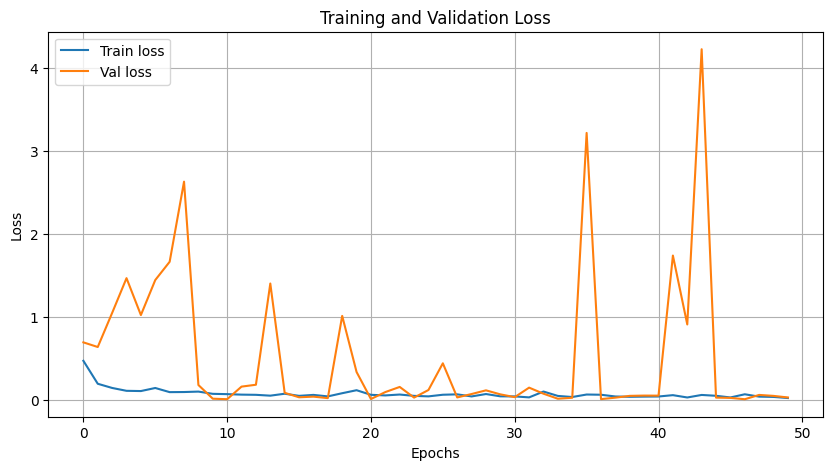

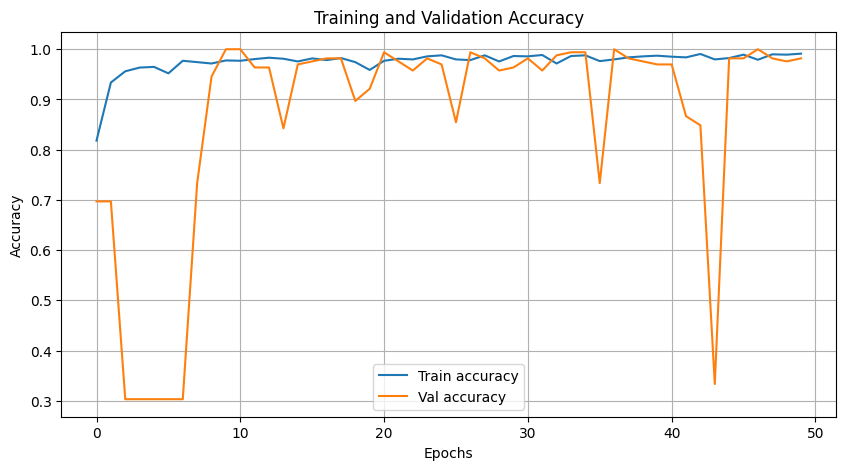

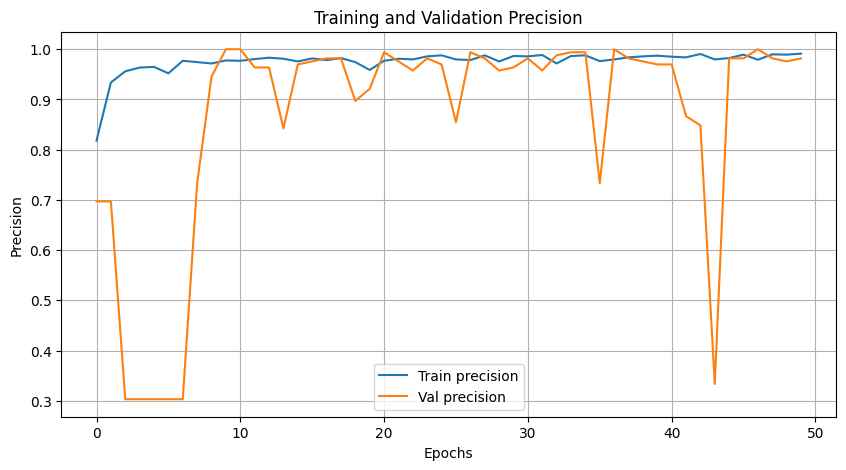

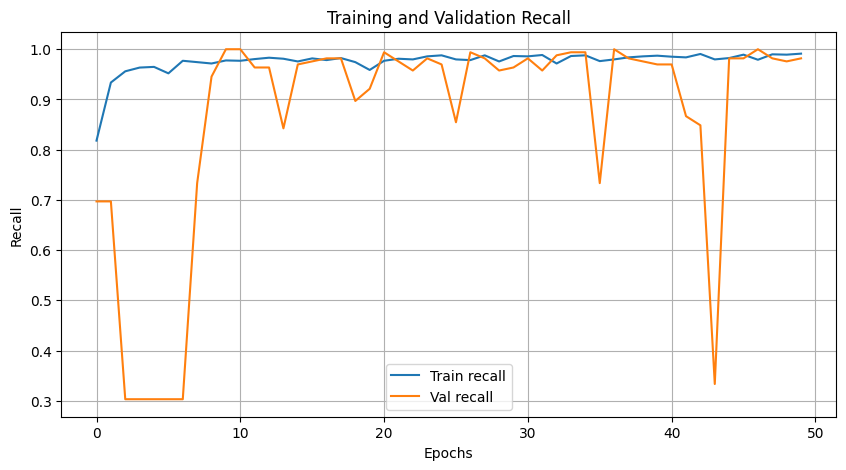

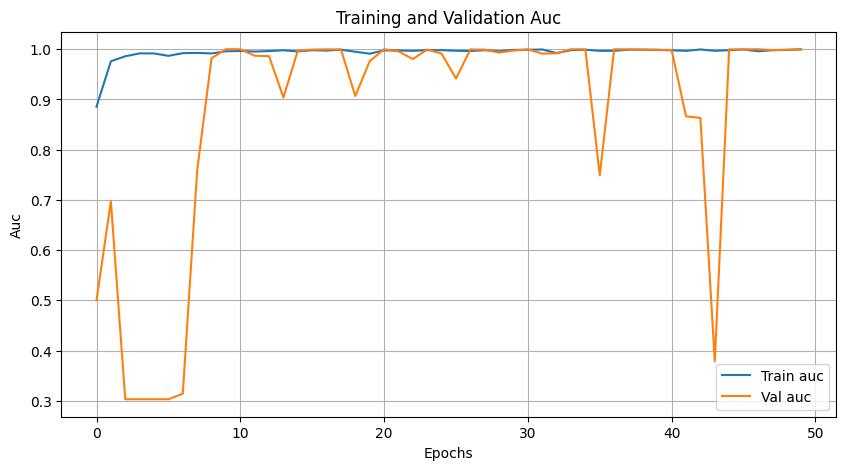

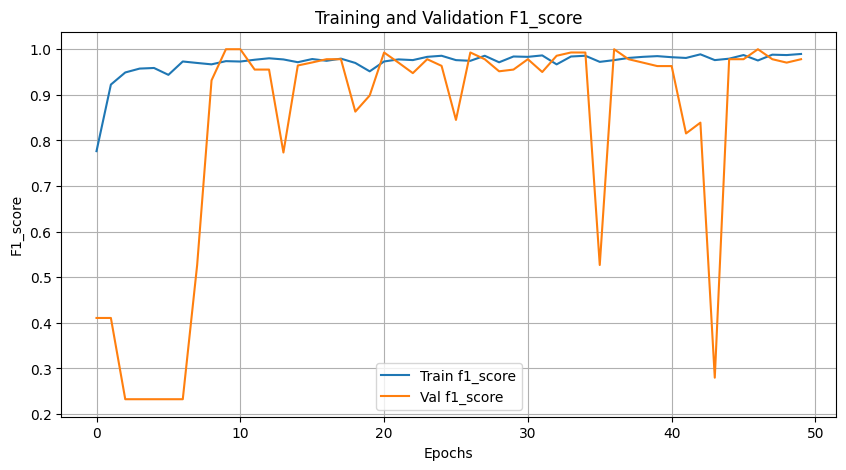

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('Recriar_Estudo_2_Aug_UAVS_train_history.csv', index=False)

In [20]:
model.save('Recriar_Estudo_2_Aug_UAVS.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [21]:
avaliar_modelo(model, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7780, TN=7726, FP=54, FN=0
Accuracy       : 0.9965
Precision      : 0.9931
Recall         : 1.0000
F1-Score       : 0.9965
AUC            : 1.0000
Binary Loss    : 0.0070
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.35 %
Confusion Matrix:
[[7726   54]
 [   0 7780]]


{'TP': 7780,
 'TN': 7726,
 'FP': 54,
 'FN': 0,
 'accuracy': 0.9965295629820051,
 'precision': 0.9931069696196069,
 'recall': 1.0,
 'f1_score': 0.9965415652619444,
 'auc': 0.9999995704495741,
 'loss': 0.007003486877137938,
 'fdr': 100.0,
 'ewr': 0.34704370179948585,
 'confusion_matrix': array([[7726,   54],
        [   0, 7780]])}

In [22]:
model_best = load_model('Recriar_Estudo_2_Aug_UAVS_best.h5')

In [23]:
avaliar_modelo(model_best, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7776, TN=7700, FP=80, FN=4
Accuracy       : 0.9946
Precision      : 0.9898
Recall         : 0.9995
F1-Score       : 0.9946
AUC            : 1.0000
Binary Loss    : 0.0242
FDR (Fire Detection Rate)      : 99.95 %
EWR (Error Warning Rate)       : 0.54 %
Confusion Matrix:
[[7700   80]
 [   4 7776]]


{'TP': 7776,
 'TN': 7700,
 'FP': 80,
 'FN': 4,
 'accuracy': 0.9946015424164525,
 'precision': 0.9898167006109979,
 'recall': 0.9994858611825193,
 'f1_score': 0.9946277820414429,
 'auc': 0.9999702123300798,
 'loss': 0.02415333099927928,
 'fdr': 99.94858611825192,
 'ewr': 0.5398457583547558,
 'confusion_matrix': array([[7700,   80],
        [   4, 7776]])}

## Testar no FLAME train

In [24]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [25]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=12, TN=14087, FP=270, FN=25006
Accuracy       : 0.3581
Precision      : 0.0426
Recall         : 0.0005
F1-Score       : 0.0009
AUC            : 0.5036
Binary Loss    : 5.8497
FDR (Fire Detection Rate)      : 0.05 %
EWR (Error Warning Rate)       : 64.19 %
Confusion Matrix:
[[14087   270]
 [25006    12]]


{'TP': 12,
 'TN': 14087,
 'FP': 270,
 'FN': 25006,
 'accuracy': 0.35806984126984126,
 'precision': 0.0425531914893617,
 'recall': 0.00047965464865296986,
 'f1_score': 0.0009486166007905139,
 'auc': 0.5036110073742657,
 'loss': 5.849676141822508,
 'fdr': 0.047965464865296986,
 'ewr': 64.19301587301587,
 'confusion_matrix': array([[14087,   270],
        [25006,    12]])}

In [26]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=3313, TN=8157, FP=6200, FN=21705
Accuracy       : 0.2913
Precision      : 0.3483
Recall         : 0.1324
F1-Score       : 0.1919
AUC            : 0.4320
Binary Loss    : 4.5953
FDR (Fire Detection Rate)      : 13.24 %
EWR (Error Warning Rate)       : 70.87 %
Confusion Matrix:
[[ 8157  6200]
 [21705  3313]]


{'TP': 3313,
 'TN': 8157,
 'FP': 6200,
 'FN': 21705,
 'accuracy': 0.2913015873015873,
 'precision': 0.3482602754125933,
 'recall': 0.13242465424894076,
 'f1_score': 0.19188555211259445,
 'auc': 0.43199887096126754,
 'loss': 4.595344445978468,
 'fdr': 13.242465424894077,
 'ewr': 70.86984126984127,
 'confusion_matrix': array([[ 8157,  6200],
        [21705,  3313]])}

## Testar no FLAME test

In [27]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [28]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=133, TN=2895, FP=585, FN=5004
Accuracy       : 0.3514
Precision      : 0.1852
Recall         : 0.0259
F1-Score       : 0.0454
AUC            : 0.3438
Binary Loss    : 5.0255
FDR (Fire Detection Rate)      : 2.59 %
EWR (Error Warning Rate)       : 64.86 %
Confusion Matrix:
[[2895  585]
 [5004  133]]


{'TP': 133,
 'TN': 2895,
 'FP': 585,
 'FN': 5004,
 'accuracy': 0.3513983985145642,
 'precision': 0.18523676880222842,
 'recall': 0.025890597625072998,
 'f1_score': 0.045431255337318524,
 'auc': 0.3438228180050524,
 'loss': 5.025464988641428,
 'fdr': 2.5890597625072997,
 'ewr': 64.86016014854357,
 'confusion_matrix': array([[2895,  585],
        [5004,  133]])}

In [29]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1383, TN=1592, FP=1888, FN=3754
Accuracy       : 0.3452
Precision      : 0.4228
Recall         : 0.2692
F1-Score       : 0.3290
AUC            : 0.3199
Binary Loss    : 5.8676
FDR (Fire Detection Rate)      : 26.92 %
EWR (Error Warning Rate)       : 65.48 %
Confusion Matrix:
[[1592 1888]
 [3754 1383]]


{'TP': 1383,
 'TN': 1592,
 'FP': 1888,
 'FN': 3754,
 'accuracy': 0.34524776604386676,
 'precision': 0.42280648119841024,
 'recall': 0.2692232820712478,
 'f1_score': 0.32897240723120835,
 'auc': 0.31987088264316355,
 'loss': 5.8676153916143585,
 'fdr': 26.922328207124778,
 'ewr': 65.47522339561333,
 'confusion_matrix': array([[1592, 1888],
        [3754, 1383]])}

## Testar no UAVS Raw Images

In [30]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [31]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=493, FP=5, FN=0
Accuracy       : 0.9970
Precision      : 0.9957
Recall         : 1.0000
F1-Score       : 0.9978
AUC            : 1.0000
Binary Loss    : 0.0077
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.30 %
Confusion Matrix:
[[ 493    5]
 [   0 1145]]


{'TP': 1145,
 'TN': 493,
 'FP': 5,
 'FN': 0,
 'accuracy': 0.996956786366403,
 'precision': 0.9956521739130435,
 'recall': 1.0,
 'f1_score': 0.9978213507625272,
 'auc': 0.9999982462601498,
 'loss': 0.007702719149140779,
 'fdr': 100.0,
 'ewr': 0.30432136335970783,
 'confusion_matrix': array([[ 493,    5],
        [   0, 1145]])}

In [32]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1141, TN=490, FP=8, FN=4
Accuracy       : 0.9927
Precision      : 0.9930
Recall         : 0.9965
F1-Score       : 0.9948
AUC            : 0.9997
Binary Loss    : 0.0333
FDR (Fire Detection Rate)      : 99.65 %
EWR (Error Warning Rate)       : 0.73 %
Confusion Matrix:
[[ 490    8]
 [   4 1141]]


{'TP': 1141,
 'TN': 490,
 'FP': 8,
 'FN': 4,
 'accuracy': 0.992696287279367,
 'precision': 0.9930374238468234,
 'recall': 0.9965065502183406,
 'f1_score': 0.994768962510898,
 'auc': 0.9996895880465092,
 'loss': 0.03333645254254251,
 'fdr': 99.65065502183405,
 'ewr': 0.7303712720632989,
 'confusion_matrix': array([[ 490,    8],
        [   4, 1141]])}

## Testar no UAVS Augmented Images

In [33]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [34]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7780, TN=7726, FP=54, FN=0
Accuracy       : 0.9965
Precision      : 0.9931
Recall         : 1.0000
F1-Score       : 0.9965
AUC            : 1.0000
Binary Loss    : 0.0070
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.35 %
Confusion Matrix:
[[7726   54]
 [   0 7780]]


{'TP': 7780,
 'TN': 7726,
 'FP': 54,
 'FN': 0,
 'accuracy': 0.9965295629820051,
 'precision': 0.9931069696196069,
 'recall': 1.0,
 'f1_score': 0.9965415652619444,
 'auc': 0.9999995704495741,
 'loss': 0.007003486877137938,
 'fdr': 100.0,
 'ewr': 0.34704370179948585,
 'confusion_matrix': array([[7726,   54],
        [   0, 7780]])}

In [35]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7776, TN=7700, FP=80, FN=4
Accuracy       : 0.9946
Precision      : 0.9898
Recall         : 0.9995
F1-Score       : 0.9946
AUC            : 1.0000
Binary Loss    : 0.0242
FDR (Fire Detection Rate)      : 99.95 %
EWR (Error Warning Rate)       : 0.54 %
Confusion Matrix:
[[7700   80]
 [   4 7776]]


{'TP': 7776,
 'TN': 7700,
 'FP': 80,
 'FN': 4,
 'accuracy': 0.9946015424164525,
 'precision': 0.9898167006109979,
 'recall': 0.9994858611825193,
 'f1_score': 0.9946277820414429,
 'auc': 0.9999702123300798,
 'loss': 0.02415333099927928,
 'fdr': 99.94858611825192,
 'ewr': 0.5398457583547558,
 'confusion_matrix': array([[7700,   80],
        [   4, 7776]])}

## Testar no FireMan

In [36]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [37]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=73, TN=33, FP=0, FN=483
Accuracy       : 0.1800
Precision      : 1.0000
Recall         : 0.1313
F1-Score       : 0.2321
AUC            : 0.7392
Binary Loss    : 6.8067
FDR (Fire Detection Rate)      : 13.13 %
EWR (Error Warning Rate)       : 82.00 %
Confusion Matrix:
[[ 33   0]
 [483  73]]


{'TP': 73,
 'TN': 33,
 'FP': 0,
 'FN': 483,
 'accuracy': 0.1799660441426146,
 'precision': 1.0,
 'recall': 0.13129496402877697,
 'f1_score': 0.23211446740858502,
 'auc': 0.7391541312404621,
 'loss': 6.80671461349138,
 'fdr': 13.129496402877697,
 'ewr': 82.00339558573853,
 'confusion_matrix': array([[ 33,   0],
        [483,  73]])}

In [38]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=97, TN=0, FP=33, FN=459
Accuracy       : 0.1647
Precision      : 0.7462
Recall         : 0.1745
F1-Score       : 0.2828
AUC            : 0.1123
Binary Loss    : 7.4245
FDR (Fire Detection Rate)      : 17.45 %
EWR (Error Warning Rate)       : 83.53 %
Confusion Matrix:
[[  0  33]
 [459  97]]


{'TP': 97,
 'TN': 0,
 'FP': 33,
 'FN': 459,
 'accuracy': 0.16468590831918506,
 'precision': 0.7461538461538462,
 'recall': 0.17446043165467626,
 'f1_score': 0.282798833819242,
 'auc': 0.11232831916285155,
 'loss': 7.424462583264155,
 'fdr': 17.446043165467625,
 'ewr': 83.5314091680815,
 'confusion_matrix': array([[  0,  33],
        [459,  97]])}